In [1]:
from keras.engine import Model
from keras.layers import Lambda
from keras.layers import Dropout, LeakyReLU, Input, Activation, BatchNormalization, Concatenate, multiply, Flatten
from keras.layers.convolutional import Convolution2D, UpSampling2D
from keras.optimizers import RMSprop
from keras.regularizers import l1, l2
from keras.losses import mae
from keras import backend as K
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm, tqdm_notebook
from keras.utils.vis_utils import plot_model
 
from medpy.io import save as savemha
from skimage import color, img_as_float
from skimage.exposure import adjust_gamma
from sklearn.metrics import classification_report
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPool2D, AveragePooling2D, add
from keras.optimizers import SGD
from keras.layers.advanced_activations import LeakyReLU
from keras.callbacks import EarlyStopping
from keras.initializers import glorot_normal
from keras.models import model_from_json
import json
import matplotlib.image as mpimg
    
    
from __future__ import print_function
from glob import glob
from skimage import io
from errno import EEXIST
from os.path import isdir
from os import makedirs
# import subprocess
import progressbar

import os
from sklearn.feature_extraction.image import extract_patches_2d
from skimage.filters.rank import entropy
from skimage.morphology import disk
from skimage.io import imsave, imread
from skimage.transform import rotate
from skimage.color import rgb2gray
from os.path import basename
import random


C:\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
progress = progressbar.ProgressBar(widgets=[progressbar.Bar('*', '[', ']'), progressbar.Percentage(), ' '])
np.random.seed(5)  # for reproducibility

def mkdir_p(path):
    """
    mkdir -p function, makes folder recursively if required
    :param path:
    :return:
    """
    try:
        makedirs(path)
    except OSError as exc:  # Python >2.5
        if exc.errno == EEXIST and isdir(path):
            pass
        else:
            raise


def normalize(slice_el):
    """
    :param slice_el: image to normalize removing 1% from top and bottom
     of histogram (intensity removal)
    :return: normalized slice
    """

    b = np.percentile(slice_el, 1)
    t = np.percentile(slice_el, 99)
    slice_el = np.clip(slice_el, b, t)
    if np.std(slice_el) == 0:
        return slice_el
    else:
        return (slice_el - np.mean(slice_el)) / np.std(slice_el)


class BrainPipeline(object):
    """
    A class for processing brain scans for one patient
    """

    def __init__(self, path, n4itk=False, n4itk_apply=False):
        """
        :param path: path to directory of one patient. Contains following mha files:
        flair, t1, t1c, t2, ground truth (gt)
        :param n4itk:  True to use n4itk normed t1 scans (defaults to True)
        :param n4itk_apply: True to apply and save n4itk filter to t1 and t1c scans for given patient.
        """
        self.path = path
        self.n4itk = n4itk
        self.n4itk_apply = n4itk_apply
        self.modes = ['flair', 't1', 't1c', 't2', 'gt']
        # slices=[[flair x 155], [t1], [t1c], [t2], [gt]], 155 per modality
        self.slices_by_mode, n = self.read_scans()
        # [ [slice1 x 5], [slice2 x 5], ..., [slice155 x 5]]
        self.slices_by_slice = n
        self.normed_slices = self.norm_slices()

    def read_scans(self):
        """
        goes into each modality in patient directory and loads individual scans.
        transforms scans of same slice into strip of 5 images
        """
        print('Loading scans...')
        slices_by_mode = np.zeros((5, 176, 216, 160))
        slices_by_slice = np.zeros((176, 5, 216, 160))
        flair = glob(self.path + '/*Flair*/*.mha')
        t2 = glob(self.path + '/*_T2*/*.mha')
        gt = glob(self.path + '/*more*/*.mha')
        t1s = glob(self.path + '/**/*T1*.mha')
        t1_n4 = glob(self.path + '/*T1*/*_n.mha')
        t1 = [scan for scan in t1s if scan not in t1_n4]
        scans = [flair[0], t1[0], t1[1], t2[0], gt[0]]  # directories to each image (5 total)
        if self.n4itk_apply:
            print('-> Applyling bias correction...')
            for t1_path in t1:
                self.n4itk_norm(t1_path)  # normalize files
            scans = [flair[0], t1_n4[0], t1_n4[1], t2[0], gt[0]]
        elif self.n4itk:
            scans = [flair[0], t1_n4[0], t1_n4[1], t2[0], gt[0]]
        for scan_idx in range(5):
            # read each image directory, save to self.slices
            print(io.imread(scans[scan_idx], plugin='simpleitk').astype(float).shape)
            print(scans[scan_idx])
            print('*' * 100)
            try:
                slices_by_mode[scan_idx] = io.imread(scans[scan_idx], plugin='simpleitk').astype(float)
            except:
                continue
        for mode_ix in range(slices_by_mode.shape[0]):  # modes 1 thru 5
            for slice_ix in range(slices_by_mode.shape[1]):  # slices 1 thru 155
                slices_by_slice[slice_ix][mode_ix] = slices_by_mode[mode_ix][slice_ix]  # reshape by slice
        return slices_by_mode, slices_by_slice

    def norm_slices(self):
        """
        normalizes each slice in self.slices_by_slice, excluding gt
        subtracts mean and div by std dev for each slice
        clips top and bottom one percent of pixel intensities
        if n4itk == True, will apply n4itk bias correction to T1 and T1c images
        """
        print('Normalizing slices...')
        normed_slices = np.zeros((176, 5, 216, 160))
        for slice_ix in range(176):
            normed_slices[slice_ix][-1] = self.slices_by_slice[slice_ix][-1]
            for mode_ix in range(4):
                normed_slices[slice_ix][mode_ix] = normalize(self.slices_by_slice[slice_ix][mode_ix])
        print ('Done.')
        return normed_slices

    def save_patient(self, reg_norm_n4, patient_num):
        """
        saves png in Norm_PNG directory for normed, Training_PNG for reg
        :param reg_norm_n4:  'reg' for original images, 'norm' normalized images,
         'n4' for n4 normalized images
        :param patient_num: unique identifier for each patient
        :return:
        """
        print('Saving scans for patient {}...'.format(patient_num))
        progress.currval = 0
        if reg_norm_n4 == 'norm':  # saved normed slices
            for slice_ix in progress(range(176)):  # reshape to strip
                strip = self.normed_slices[slice_ix].reshape(1080, 160)
                if np.max(strip) != 0:  # set values < 1
                    strip /= np.max(strip)
                if np.min(strip) <= -1:  # set values > -1
                    strip /= abs(np.min(strip))
                # save as patient_slice.png
                try:
                    io.imsave('Norm_PNG/{}_{}.png'.format(patient_num, slice_ix), strip)
                except:
                    mkdir_p('Norm_PNG/')
                    io.imsave('Norm_PNG/{}_{}.png'.format(patient_num, slice_ix), strip)
        elif reg_norm_n4 == 'reg':
            # for slice_ix in progress(range(155)):
            for slice_ix in progress(range(176)):
                strip = self.slices_by_slice[slice_ix].reshape(1080, 160)
                if np.max(strip) != 0:
                    strip /= np.max(strip)
                try:
                    io.imsave('Training_PNG/{}_{}.png'.format(patient_num, slice_ix), strip)
                except:
                    mkdir_p('Training_PNG/')
                    io.imsave('Training_PNG/{}_{}.png'.format(patient_num, slice_ix), strip)
        else:
            for slice_ix in progress(range(176)):  # reshape to strip
                strip = self.normed_slices[slice_ix].reshape(1080, 160)
                if np.max(strip) != 0:  # set values < 1
                    strip /= np.max(strip)
                if np.min(strip) <= -1:  # set values > -1
                    strip /= abs(np.min(strip))
                # save as patient_slice.png
                try:
                    io.imsave('n4_PNG/{}_{}.png'.format(patient_num, slice_ix), strip)
                except:
                    mkdir_p('n4_PNG/')
                    io.imsave('n4_PNG/{}_{}.png'.format(patient_num, slice_ix), strip)

    def n4itk_norm(self, path, n_dims=3, n_iters='[20,20,10,5]'):
        """
        writes n4itk normalized image to parent_dir under orig_filename_n.mha
        :param path: path to mha T1 or T1c file
        :param n_dims:  param for n4itk filter
        :param n_iters: param for n4itk filter
        :return:
        """
        output_fn = path[:-4] + '_n.mha'
        # run n4_bias_correction.py path n_dim n_iters output_fn
        subprocess.call('python n4_bias_correction.py ' + path + ' ' + str(n_dims) + ' ' + n_iters + ' ' + output_fn,
                        shell=True)

In [12]:
def save_patient_slices(patients, type):
    '''
    INPUT   (1) list 'patients': paths to any directories of patients to save. for example- glob("Training/HGG/**")
            (2) string 'type': options = reg (non-normalized), norm (normalized, but no bias correction), n4 (bias corrected and normalized)
    saves strips of patient slices to approriate directory (Training_PNG/, Norm_PNG/ or n4_PNG/) as patient-num_slice-num
    '''
    for patient_num, path in enumerate(patients):
        a = BrainPipeline(path)
        a.save_patient(type, patient_num)


def save_labels(fns):
    '''
    INPUT list 'fns': filepaths to all labels
    '''
    progress.currval = 0
    for label_idx in progress(range(len(labels))):
        slices = io.imread(labels[label_idx], plugin = 'simpleitk')
        for slice_idx in range(len(slices)):
            try:
                io.imsave('Labels/{}_{}L.png'.format(label_idx, slice_idx), slices[slice_idx])
            except:
                mkdir_p('Labels/')
                io.imsave('Labels/{}_{}L.png'.format(label_idx, slice_idx), slices[slice_idx])

In [196]:
labels = glob(r'D:\UB Coursework\Fall 2020- UB\CSE676_Deep_Learning\Project_2_MS_Project\Dataset\BRATS_original\BRATS-2\Image_Data/HG/**/*more*/**.mha')
save_labels(labels)

C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Labels/0_0L.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Labels/0_1L.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Labels/0_2L.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Labels/0_3L.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Labels/0_4L.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Labels/0_5L.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Labels/0_6L.png is a 

C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Labels/0_73L.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Labels/0_74L.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Labels/0_75L.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Labels/0_76L.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Labels/0_77L.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Labels/0_78L.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Labels/0_79L.pn

C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Labels/0_155L.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Labels/0_156L.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Labels/0_157L.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Labels/0_158L.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Labels/0_159L.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Labels/0_160L.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Labels/0_

C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Labels/1_108L.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Labels/1_109L.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Labels/1_110L.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Labels/1_111L.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Labels/1_112L.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Labels/1_113L.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Labels/1_

C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Labels/2_0L.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Labels/2_1L.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Labels/2_2L.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Labels/2_3L.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Labels/2_4L.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Labels/2_5L.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Labels/2_6L.png is a 

C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Labels/2_104L.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Labels/2_105L.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Labels/2_106L.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Labels/2_107L.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Labels/2_108L.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Labels/2_109L.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Labels/2_

C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Labels/3_0L.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Labels/3_1L.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Labels/3_2L.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Labels/3_3L.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Labels/3_4L.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Labels/3_5L.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Labels/3_6L.png is a 

C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Labels/3_89L.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Labels/3_90L.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Labels/3_91L.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Labels/3_92L.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Labels/3_93L.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Labels/3_94L.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Labels/3_95L.pn

C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Labels/3_162L.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Labels/3_163L.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Labels/3_164L.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Labels/3_165L.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Labels/3_166L.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Labels/3_167L.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Labels/3_

C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Labels/4_89L.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Labels/4_90L.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Labels/4_91L.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Labels/4_92L.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Labels/4_93L.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Labels/4_94L.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Labels/4_95L.pn

C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Labels/4_162L.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Labels/4_163L.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Labels/4_164L.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Labels/4_165L.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Labels/4_166L.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Labels/4_167L.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Labels/4_

C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Labels/5_107L.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Labels/5_108L.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Labels/5_109L.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Labels/5_110L.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Labels/5_111L.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Labels/5_112L.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Labels/5_

C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Labels/5_174L.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Labels/5_175L.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Labels/6_0L.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Labels/6_1L.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Labels/6_2L.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Labels/6_3L.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Labels/6_4L.png i

C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Labels/6_110L.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Labels/6_111L.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Labels/6_112L.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Labels/6_113L.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Labels/6_114L.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Labels/6_115L.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Labels/6_

C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Labels/7_0L.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Labels/7_1L.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Labels/7_2L.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Labels/7_3L.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Labels/7_4L.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Labels/7_5L.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Labels/7_6L.png is a 

C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Labels/7_105L.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Labels/7_106L.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Labels/7_107L.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Labels/7_108L.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Labels/7_109L.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Labels/7_110L.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Labels/7_

C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Labels/7_162L.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Labels/7_163L.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Labels/7_164L.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Labels/7_165L.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Labels/7_166L.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Labels/7_167L.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Labels/7_

C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Labels/8_61L.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Labels/8_62L.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Labels/8_63L.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Labels/8_64L.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Labels/8_65L.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Labels/8_66L.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Labels/8_67L.pn

C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Labels/8_160L.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Labels/8_161L.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Labels/8_162L.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Labels/8_163L.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Labels/8_164L.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Labels/8_165L.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Labels/8_

C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Labels/9_68L.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Labels/9_69L.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Labels/9_70L.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Labels/9_71L.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Labels/9_72L.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Labels/9_73L.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Labels/9_74L.pn

C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Labels/9_154L.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Labels/9_155L.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Labels/9_156L.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Labels/9_157L.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Labels/9_158L.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Labels/9_159L.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Labels/9_

C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Labels/10_45L.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Labels/10_46L.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Labels/10_47L.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Labels/10_48L.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Labels/10_49L.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Labels/10_50L.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Labels/10

C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Labels/10_120L.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Labels/10_121L.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Labels/10_122L.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Labels/10_123L.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Labels/10_124L.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Labels/10_125L.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Lab

C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Labels/11_0L.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Labels/11_1L.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Labels/11_2L.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Labels/11_3L.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Labels/11_4L.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Labels/11_5L.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Labels/11_6L.pn

C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Labels/11_93L.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Labels/11_94L.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Labels/11_95L.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Labels/11_96L.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Labels/11_97L.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Labels/11_98L.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Labels/11

C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Labels/12_0L.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Labels/12_1L.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Labels/12_2L.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Labels/12_3L.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Labels/12_4L.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Labels/12_5L.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Labels/12_6L.pn

C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Labels/12_65L.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Labels/12_66L.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Labels/12_67L.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Labels/12_68L.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Labels/12_69L.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Labels/12_70L.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Labels/12

C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Labels/13_0L.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Labels/13_1L.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Labels/13_2L.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Labels/13_3L.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Labels/13_4L.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Labels/13_5L.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Labels/13_6L.pn

C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Labels/13_88L.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Labels/13_89L.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Labels/13_90L.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Labels/13_91L.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Labels/13_92L.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Labels/13_93L.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Labels/13

C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Labels/13_167L.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Labels/13_168L.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Labels/13_169L.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Labels/13_170L.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Labels/13_171L.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Labels/13_172L.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Lab

C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Labels/14_77L.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Labels/14_78L.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Labels/14_79L.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Labels/14_80L.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Labels/14_81L.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Labels/14_82L.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Labels/14

C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Labels/15_0L.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Labels/15_1L.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Labels/15_2L.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Labels/15_3L.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Labels/15_4L.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Labels/15_5L.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Labels/15_6L.pn

C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Labels/15_77L.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Labels/15_78L.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Labels/15_79L.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Labels/15_80L.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Labels/15_81L.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Labels/15_82L.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Labels/15

C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Labels/16_0L.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Labels/16_1L.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Labels/16_2L.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Labels/16_3L.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Labels/16_4L.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Labels/16_5L.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Labels/16_6L.pn

C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Labels/16_106L.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Labels/16_107L.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Labels/16_108L.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Labels/16_109L.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Labels/16_110L.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Labels/16_111L.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Lab

C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Labels/16_204L.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Labels/16_205L.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Labels/16_206L.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Labels/16_207L.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Labels/16_208L.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Labels/16_209L.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Lab

C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Labels/17_18L.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Labels/17_19L.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Labels/17_20L.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Labels/17_21L.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Labels/17_22L.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Labels/17_23L.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Labels/17

C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Labels/17_109L.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Labels/17_110L.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Labels/17_111L.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Labels/17_112L.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Labels/17_113L.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Labels/17_114L.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Lab

C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Labels/17_208L.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Labels/17_209L.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Labels/17_210L.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Labels/17_211L.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Labels/17_212L.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Labels/17_213L.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Lab

C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Labels/18_84L.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Labels/18_85L.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Labels/18_86L.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Labels/18_87L.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Labels/18_88L.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Labels/18_89L.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Labels/18

C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Labels/18_176L.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Labels/18_177L.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Labels/18_178L.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Labels/18_179L.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Labels/18_180L.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Labels/18_181L.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Lab

C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Labels/19_26L.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Labels/19_27L.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Labels/19_28L.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Labels/19_29L.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Labels/19_30L.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Labels/19_31L.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Labels/19

C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Labels/19_82L.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Labels/19_83L.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Labels/19_84L.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Labels/19_85L.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Labels/19_86L.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Labels/19_87L.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Labels/19

C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Labels/19_158L.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Labels/19_159L.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Labels/19_160L.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Labels/19_161L.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Labels/19_162L.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Labels/19_163L.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Lab

[************************************************************************]100% 


In [5]:
patients = glob(r'D:\UB Coursework\Fall 2020- UB\CSE676_Deep_Learning\Project_2_MS_Project\Dataset\BRATS_original\BRATS-2\Image_Data/HG/**')
save_patient_slices(patients, 'reg')
save_patient_slices(patients, 'norm')
save_patient_slices(patients, 'n4')

Loading scans...
(176, 216, 160)
D:\UB Coursework\Fall 2020- UB\CSE676_Deep_Learning\Project_2_MS_Project\Dataset\BRATS_original\BRATS-2\Image_Data/HG\0001\VSD.Brain.XX.O.MR_Flair\VSD.Brain.XX.O.MR_Flair.684.mha
****************************************************************************************************
(176, 216, 160)
D:\UB Coursework\Fall 2020- UB\CSE676_Deep_Learning\Project_2_MS_Project\Dataset\BRATS_original\BRATS-2\Image_Data/HG\0001\VSD.Brain.XX.O.MR_T1\VSD.Brain.XX.O.MR_T1.685.mha
****************************************************************************************************
(176, 216, 160)
D:\UB Coursework\Fall 2020- UB\CSE676_Deep_Learning\Project_2_MS_Project\Dataset\BRATS_original\BRATS-2\Image_Data/HG\0001\VSD.Brain.XX.O.MR_T1c\VSD.Brain.XX.O.MR_T1c.686.mha
****************************************************************************************************
(176, 216, 160)
D:\UB Coursework\Fall 2020- UB\CSE676_Deep_Learning\Project_2_MS_Project\Dataset\BRATS_or

C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Training_PNG/0_0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\util\dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Training_PNG/0_1.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Training_PNG/0_2.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Training_PNG/0_3.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Training_PNG/0_4.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_

Done.
Saving scans for patient 0...


C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Training_PNG/0_15.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Training_PNG/0_16.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Training_PNG/0_17.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Training_PNG/0_18.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Training_PNG/0_19.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Training_PNG/0_20.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132

Loading scans...
(176, 216, 160)
D:\UB Coursework\Fall 2020- UB\CSE676_Deep_Learning\Project_2_MS_Project\Dataset\BRATS_original\BRATS-2\Image_Data/HG\0002\VSD.Brain.XX.O.MR_Flair\VSD.Brain.XX.O.MR_Flair.691.mha
****************************************************************************************************
(176, 216, 160)
D:\UB Coursework\Fall 2020- UB\CSE676_Deep_Learning\Project_2_MS_Project\Dataset\BRATS_original\BRATS-2\Image_Data/HG\0002\VSD.Brain.XX.O.MR_T1\VSD.Brain.XX.O.MR_T1.692.mha
****************************************************************************************************
(176, 216, 160)
D:\UB Coursework\Fall 2020- UB\CSE676_Deep_Learning\Project_2_MS_Project\Dataset\BRATS_original\BRATS-2\Image_Data/HG\0002\VSD.Brain.XX.O.MR_T1c\VSD.Brain.XX.O.MR_T1c.693.mha
****************************************************************************************************
(176, 216, 160)
D:\UB Coursework\Fall 2020- UB\CSE676_Deep_Learning\Project_2_MS_Project\Dataset\BRATS_or

Done.
Saving scans for patient 1...


C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Training_PNG/1_139.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Training_PNG/1_140.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Training_PNG/1_141.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Training_PNG/1_142.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Training_PNG/1_143.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Training_PNG/1_144.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.

Loading scans...
(176, 216, 176)
D:\UB Coursework\Fall 2020- UB\CSE676_Deep_Learning\Project_2_MS_Project\Dataset\BRATS_original\BRATS-2\Image_Data/HG\0003\VSD.Brain.XX.O.MR_Flair\VSD.Brain.XX.O.MR_Flair.697.mha
****************************************************************************************************
(176, 216, 176)
D:\UB Coursework\Fall 2020- UB\CSE676_Deep_Learning\Project_2_MS_Project\Dataset\BRATS_original\BRATS-2\Image_Data/HG\0003\VSD.Brain.XX.O.MR_T1\VSD.Brain.XX.O.MR_T1.698.mha
****************************************************************************************************
(176, 216, 176)
D:\UB Coursework\Fall 2020- UB\CSE676_Deep_Learning\Project_2_MS_Project\Dataset\BRATS_original\BRATS-2\Image_Data/HG\0003\VSD.Brain.XX.O.MR_T1c\VSD.Brain.XX.O.MR_T1c.699.mha
****************************************************************************************************
(176, 216, 176)
D:\UB Coursework\Fall 2020- UB\CSE676_Deep_Learning\Project_2_MS_Project\Dataset\BRATS_or

C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Training_PNG/2_0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Training_PNG/2_1.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Training_PNG/2_2.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Training_PNG/2_3.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Training_PNG/2_4.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Training_PNG/2_5.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: User

Done.
Saving scans for patient 2...


C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Training_PNG/2_10.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Training_PNG/2_11.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Training_PNG/2_12.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Training_PNG/2_13.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Training_PNG/2_14.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Training_PNG/2_15.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132

C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Training_PNG/2_62.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Training_PNG/2_63.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Training_PNG/2_64.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Training_PNG/2_65.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Training_PNG/2_66.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Training_PNG/2_67.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132

C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Training_PNG/2_114.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Training_PNG/2_115.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Training_PNG/2_116.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Training_PNG/2_117.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Training_PNG/2_118.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Training_PNG/2_119.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.

C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Training_PNG/2_166.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Training_PNG/2_167.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Training_PNG/2_168.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Training_PNG/2_169.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Training_PNG/2_170.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Training_PNG/2_171.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.

Loading scans...
(176, 216, 160)
D:\UB Coursework\Fall 2020- UB\CSE676_Deep_Learning\Project_2_MS_Project\Dataset\BRATS_original\BRATS-2\Image_Data/HG\0004\VSD.Brain.XX.O.MR_Flair\VSD.Brain.XX.O.MR_Flair.703.mha
****************************************************************************************************
(176, 216, 160)
D:\UB Coursework\Fall 2020- UB\CSE676_Deep_Learning\Project_2_MS_Project\Dataset\BRATS_original\BRATS-2\Image_Data/HG\0004\VSD.Brain.XX.O.MR_T1\VSD.Brain.XX.O.MR_T1.704.mha
****************************************************************************************************
(176, 216, 160)
D:\UB Coursework\Fall 2020- UB\CSE676_Deep_Learning\Project_2_MS_Project\Dataset\BRATS_original\BRATS-2\Image_Data/HG\0004\VSD.Brain.XX.O.MR_T1c\VSD.Brain.XX.O.MR_T1c.705.mha
****************************************************************************************************
(176, 216, 160)
D:\UB Coursework\Fall 2020- UB\CSE676_Deep_Learning\Project_2_MS_Project\Dataset\BRATS_or

C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Training_PNG/3_0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Training_PNG/3_1.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Training_PNG/3_2.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Training_PNG/3_3.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Training_PNG/3_4.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Training_PNG/3_5.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: User

Done.
Saving scans for patient 3...


C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Training_PNG/3_13.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Training_PNG/3_14.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Training_PNG/3_15.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Training_PNG/3_16.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Training_PNG/3_17.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Training_PNG/3_18.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132

Loading scans...
(176, 216, 160)
D:\UB Coursework\Fall 2020- UB\CSE676_Deep_Learning\Project_2_MS_Project\Dataset\BRATS_original\BRATS-2\Image_Data/HG\0005\VSD.Brain.XX.O.MR_Flair\VSD.Brain.XX.O.MR_Flair.709.mha
****************************************************************************************************
(176, 216, 160)
D:\UB Coursework\Fall 2020- UB\CSE676_Deep_Learning\Project_2_MS_Project\Dataset\BRATS_original\BRATS-2\Image_Data/HG\0005\VSD.Brain.XX.O.MR_T1\VSD.Brain.XX.O.MR_T1.710.mha
****************************************************************************************************
(176, 216, 160)
D:\UB Coursework\Fall 2020- UB\CSE676_Deep_Learning\Project_2_MS_Project\Dataset\BRATS_original\BRATS-2\Image_Data/HG\0005\VSD.Brain.XX.O.MR_T1c\VSD.Brain.XX.O.MR_T1c.711.mha
****************************************************************************************************
(176, 216, 160)
D:\UB Coursework\Fall 2020- UB\CSE676_Deep_Learning\Project_2_MS_Project\Dataset\BRATS_or

C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Training_PNG/4_0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Training_PNG/4_1.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Training_PNG/4_2.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Training_PNG/4_3.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Training_PNG/4_4.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Training_PNG/4_5.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: User

Done.
Saving scans for patient 4...


C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Training_PNG/4_14.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Training_PNG/4_15.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Training_PNG/4_16.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Training_PNG/4_17.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Training_PNG/4_153.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Training_PNG/4_154.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:1

Loading scans...
(176, 236, 216)
D:\UB Coursework\Fall 2020- UB\CSE676_Deep_Learning\Project_2_MS_Project\Dataset\BRATS_original\BRATS-2\Image_Data/HG\0006\VSD.Brain.XX.O.MR_Flair\VSD.Brain.XX.O.MR_Flair.715.mha
****************************************************************************************************
(176, 236, 216)
D:\UB Coursework\Fall 2020- UB\CSE676_Deep_Learning\Project_2_MS_Project\Dataset\BRATS_original\BRATS-2\Image_Data/HG\0006\VSD.Brain.XX.O.MR_T1\VSD.Brain.XX.O.MR_T1.716.mha
****************************************************************************************************
(176, 236, 216)
D:\UB Coursework\Fall 2020- UB\CSE676_Deep_Learning\Project_2_MS_Project\Dataset\BRATS_original\BRATS-2\Image_Data/HG\0006\VSD.Brain.XX.O.MR_T1c\VSD.Brain.XX.O.MR_T1c.717.mha
****************************************************************************************************
(176, 236, 216)
D:\UB Coursework\Fall 2020- UB\CSE676_Deep_Learning\Project_2_MS_Project\Dataset\BRATS_or

C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Training_PNG/5_0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Training_PNG/5_1.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Training_PNG/5_2.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Training_PNG/5_3.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Training_PNG/5_4.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Training_PNG/5_5.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: User

Done.
Saving scans for patient 5...


C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Training_PNG/5_16.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Training_PNG/5_17.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Training_PNG/5_18.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Training_PNG/5_19.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Training_PNG/5_20.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Training_PNG/5_21.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132

C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Training_PNG/5_68.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Training_PNG/5_69.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Training_PNG/5_70.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Training_PNG/5_71.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Training_PNG/5_72.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Training_PNG/5_73.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132

C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Training_PNG/5_120.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Training_PNG/5_121.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Training_PNG/5_122.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Training_PNG/5_123.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Training_PNG/5_124.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Training_PNG/5_125.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.

C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Training_PNG/5_172.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Training_PNG/5_173.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Training_PNG/5_174.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Training_PNG/5_175.png is a low contrast image
  warn('%s is a low contrast image' % fname)


Loading scans...
(176, 216, 176)
D:\UB Coursework\Fall 2020- UB\CSE676_Deep_Learning\Project_2_MS_Project\Dataset\BRATS_original\BRATS-2\Image_Data/HG\0007\VSD.Brain.XX.O.MR_Flair\VSD.Brain.XX.O.MR_Flair.721.mha
****************************************************************************************************
(176, 216, 176)
D:\UB Coursework\Fall 2020- UB\CSE676_Deep_Learning\Project_2_MS_Project\Dataset\BRATS_original\BRATS-2\Image_Data/HG\0007\VSD.Brain.XX.O.MR_T1\VSD.Brain.XX.O.MR_T1.722.mha
****************************************************************************************************
(176, 216, 176)
D:\UB Coursework\Fall 2020- UB\CSE676_Deep_Learning\Project_2_MS_Project\Dataset\BRATS_original\BRATS-2\Image_Data/HG\0007\VSD.Brain.XX.O.MR_T1c\VSD.Brain.XX.O.MR_T1c.723.mha
****************************************************************************************************
(176, 216, 176)
D:\UB Coursework\Fall 2020- UB\CSE676_Deep_Learning\Project_2_MS_Project\Dataset\BRATS_or

C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Training_PNG/6_0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Training_PNG/6_1.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Training_PNG/6_2.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Training_PNG/6_3.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Training_PNG/6_4.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Training_PNG/6_5.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: User

Done.
Saving scans for patient 6...


C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Training_PNG/6_15.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Training_PNG/6_16.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Training_PNG/6_17.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Training_PNG/6_18.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Training_PNG/6_19.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Training_PNG/6_20.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132

C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Training_PNG/6_67.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Training_PNG/6_68.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Training_PNG/6_69.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Training_PNG/6_70.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Training_PNG/6_71.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Training_PNG/6_72.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132

C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Training_PNG/6_119.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Training_PNG/6_120.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Training_PNG/6_121.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Training_PNG/6_122.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Training_PNG/6_123.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Training_PNG/6_124.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.

C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Training_PNG/6_171.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Training_PNG/6_172.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Training_PNG/6_173.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Training_PNG/6_174.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Training_PNG/6_175.png is a low contrast image
  warn('%s is a low contrast image' % fname)


Loading scans...
(176, 216, 160)
D:\UB Coursework\Fall 2020- UB\CSE676_Deep_Learning\Project_2_MS_Project\Dataset\BRATS_original\BRATS-2\Image_Data/HG\0008\VSD.Brain.XX.O.MR_Flair\VSD.Brain.XX.O.MR_Flair.727.mha
****************************************************************************************************
(176, 216, 160)
D:\UB Coursework\Fall 2020- UB\CSE676_Deep_Learning\Project_2_MS_Project\Dataset\BRATS_original\BRATS-2\Image_Data/HG\0008\VSD.Brain.XX.O.MR_T1\VSD.Brain.XX.O.MR_T1.728.mha
****************************************************************************************************
(176, 216, 160)
D:\UB Coursework\Fall 2020- UB\CSE676_Deep_Learning\Project_2_MS_Project\Dataset\BRATS_original\BRATS-2\Image_Data/HG\0008\VSD.Brain.XX.O.MR_T1c\VSD.Brain.XX.O.MR_T1c.729.mha
****************************************************************************************************
(176, 216, 160)
D:\UB Coursework\Fall 2020- UB\CSE676_Deep_Learning\Project_2_MS_Project\Dataset\BRATS_or

C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Training_PNG/7_0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Training_PNG/7_1.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Training_PNG/7_2.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Training_PNG/7_3.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Training_PNG/7_4.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Training_PNG/7_5.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: User

Done.
Saving scans for patient 7...


C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Training_PNG/7_14.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Training_PNG/7_15.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Training_PNG/7_16.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Training_PNG/7_17.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Training_PNG/7_18.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Training_PNG/7_19.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132

Loading scans...
(176, 216, 160)
D:\UB Coursework\Fall 2020- UB\CSE676_Deep_Learning\Project_2_MS_Project\Dataset\BRATS_original\BRATS-2\Image_Data/HG\0009\VSD.Brain.XX.O.MR_Flair\VSD.Brain.XX.O.MR_Flair.733.mha
****************************************************************************************************
(176, 216, 160)
D:\UB Coursework\Fall 2020- UB\CSE676_Deep_Learning\Project_2_MS_Project\Dataset\BRATS_original\BRATS-2\Image_Data/HG\0009\VSD.Brain.XX.O.MR_T1\VSD.Brain.XX.O.MR_T1.734.mha
****************************************************************************************************
(176, 216, 160)
D:\UB Coursework\Fall 2020- UB\CSE676_Deep_Learning\Project_2_MS_Project\Dataset\BRATS_original\BRATS-2\Image_Data/HG\0009\VSD.Brain.XX.O.MR_T1c\VSD.Brain.XX.O.MR_T1c.735.mha
****************************************************************************************************
(176, 216, 160)
D:\UB Coursework\Fall 2020- UB\CSE676_Deep_Learning\Project_2_MS_Project\Dataset\BRATS_or

C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Training_PNG/8_0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Training_PNG/8_1.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Training_PNG/8_2.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Training_PNG/8_3.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Training_PNG/8_4.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Training_PNG/8_5.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: User

Done.
Saving scans for patient 8...


C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Training_PNG/8_13.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Training_PNG/8_14.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Training_PNG/8_15.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Training_PNG/8_16.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Training_PNG/8_17.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Training_PNG/8_18.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132

Loading scans...
(176, 216, 160)
D:\UB Coursework\Fall 2020- UB\CSE676_Deep_Learning\Project_2_MS_Project\Dataset\BRATS_original\BRATS-2\Image_Data/HG\0010\VSD.Brain.XX.O.MR_Flair\VSD.Brain.XX.O.MR_Flair.739.mha
****************************************************************************************************
(176, 216, 160)
D:\UB Coursework\Fall 2020- UB\CSE676_Deep_Learning\Project_2_MS_Project\Dataset\BRATS_original\BRATS-2\Image_Data/HG\0010\VSD.Brain.XX.O.MR_T1\VSD.Brain.XX.O.MR_T1.740.mha
****************************************************************************************************
(176, 216, 160)
D:\UB Coursework\Fall 2020- UB\CSE676_Deep_Learning\Project_2_MS_Project\Dataset\BRATS_original\BRATS-2\Image_Data/HG\0010\VSD.Brain.XX.O.MR_T1c\VSD.Brain.XX.O.MR_T1c.741.mha
****************************************************************************************************
(176, 216, 160)
D:\UB Coursework\Fall 2020- UB\CSE676_Deep_Learning\Project_2_MS_Project\Dataset\BRATS_or

C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Training_PNG/9_0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Training_PNG/9_1.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Training_PNG/9_2.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Training_PNG/9_3.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Training_PNG/9_4.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Training_PNG/9_5.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: User

Done.
Saving scans for patient 9...


C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Training_PNG/9_14.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Training_PNG/9_159.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Training_PNG/9_160.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Training_PNG/9_161.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Training_PNG/9_162.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Training_PNG/9_163.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.p

Loading scans...
(176, 216, 176)
D:\UB Coursework\Fall 2020- UB\CSE676_Deep_Learning\Project_2_MS_Project\Dataset\BRATS_original\BRATS-2\Image_Data/HG\0011\VSD.Brain.XX.O.MR_Flair\VSD.Brain.XX.O.MR_Flair.745.mha
****************************************************************************************************
(176, 216, 176)
D:\UB Coursework\Fall 2020- UB\CSE676_Deep_Learning\Project_2_MS_Project\Dataset\BRATS_original\BRATS-2\Image_Data/HG\0011\VSD.Brain.XX.O.MR_T1\VSD.Brain.XX.O.MR_T1.746.mha
****************************************************************************************************
(176, 216, 176)
D:\UB Coursework\Fall 2020- UB\CSE676_Deep_Learning\Project_2_MS_Project\Dataset\BRATS_original\BRATS-2\Image_Data/HG\0011\VSD.Brain.XX.O.MR_T1c\VSD.Brain.XX.O.MR_T1c.747.mha
****************************************************************************************************
(176, 216, 176)
D:\UB Coursework\Fall 2020- UB\CSE676_Deep_Learning\Project_2_MS_Project\Dataset\BRATS_or

C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Training_PNG/10_0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Training_PNG/10_1.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Training_PNG/10_2.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Training_PNG/10_3.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Training_PNG/10_4.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Training_PNG/10_5.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132

Done.
Saving scans for patient 10...


C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Training_PNG/10_9.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Training_PNG/10_10.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Training_PNG/10_11.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Training_PNG/10_12.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Training_PNG/10_13.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Training_PNG/10_14.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.p

C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Training_PNG/10_61.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Training_PNG/10_62.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Training_PNG/10_63.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Training_PNG/10_64.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Training_PNG/10_65.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Training_PNG/10_66.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.

C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Training_PNG/10_163.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Training_PNG/10_164.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Training_PNG/10_165.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Training_PNG/10_166.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Training_PNG/10_167.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Training_PNG/10_168.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\i

Loading scans...
(176, 216, 176)
D:\UB Coursework\Fall 2020- UB\CSE676_Deep_Learning\Project_2_MS_Project\Dataset\BRATS_original\BRATS-2\Image_Data/HG\0012\VSD.Brain.XX.O.MR_Flair\VSD.Brain.XX.O.MR_Flair.751.mha
****************************************************************************************************
(176, 216, 176)
D:\UB Coursework\Fall 2020- UB\CSE676_Deep_Learning\Project_2_MS_Project\Dataset\BRATS_original\BRATS-2\Image_Data/HG\0012\VSD.Brain.XX.O.MR_T1\VSD.Brain.XX.O.MR_T1.752.mha
****************************************************************************************************
(176, 216, 176)
D:\UB Coursework\Fall 2020- UB\CSE676_Deep_Learning\Project_2_MS_Project\Dataset\BRATS_original\BRATS-2\Image_Data/HG\0012\VSD.Brain.XX.O.MR_T1c\VSD.Brain.XX.O.MR_T1c.753.mha
****************************************************************************************************
(176, 216, 176)
D:\UB Coursework\Fall 2020- UB\CSE676_Deep_Learning\Project_2_MS_Project\Dataset\BRATS_or

C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Training_PNG/11_0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Training_PNG/11_1.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Training_PNG/11_2.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Training_PNG/11_3.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Training_PNG/11_4.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Training_PNG/11_5.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132

Done.
Saving scans for patient 11...


C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Training_PNG/11_18.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Training_PNG/11_19.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Training_PNG/11_20.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Training_PNG/11_21.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Training_PNG/11_22.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Training_PNG/11_23.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.

C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Training_PNG/11_70.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Training_PNG/11_71.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Training_PNG/11_72.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Training_PNG/11_73.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Training_PNG/11_74.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Training_PNG/11_75.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.

C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Training_PNG/11_172.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Training_PNG/11_173.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Training_PNG/11_174.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Training_PNG/11_175.png is a low contrast image
  warn('%s is a low contrast image' % fname)


Loading scans...
(176, 216, 176)
D:\UB Coursework\Fall 2020- UB\CSE676_Deep_Learning\Project_2_MS_Project\Dataset\BRATS_original\BRATS-2\Image_Data/HG\0013\VSD.Brain.XX.O.MR_Flair\VSD.Brain.XX.O.MR_Flair.757.mha
****************************************************************************************************
(176, 216, 176)
D:\UB Coursework\Fall 2020- UB\CSE676_Deep_Learning\Project_2_MS_Project\Dataset\BRATS_original\BRATS-2\Image_Data/HG\0013\VSD.Brain.XX.O.MR_T1\VSD.Brain.XX.O.MR_T1.758.mha
****************************************************************************************************
(176, 216, 176)
D:\UB Coursework\Fall 2020- UB\CSE676_Deep_Learning\Project_2_MS_Project\Dataset\BRATS_original\BRATS-2\Image_Data/HG\0013\VSD.Brain.XX.O.MR_T1c\VSD.Brain.XX.O.MR_T1c.759.mha
****************************************************************************************************
(176, 216, 176)
D:\UB Coursework\Fall 2020- UB\CSE676_Deep_Learning\Project_2_MS_Project\Dataset\BRATS_or

C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Training_PNG/12_0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Training_PNG/12_1.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Training_PNG/12_2.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Training_PNG/12_3.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Training_PNG/12_4.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Training_PNG/12_5.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132

Done.
Saving scans for patient 12...


C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Training_PNG/12_11.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Training_PNG/12_12.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Training_PNG/12_13.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Training_PNG/12_14.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Training_PNG/12_15.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Training_PNG/12_16.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.

C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Training_PNG/12_63.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Training_PNG/12_64.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Training_PNG/12_65.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Training_PNG/12_66.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Training_PNG/12_67.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Training_PNG/12_68.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.

C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Training_PNG/12_165.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Training_PNG/12_166.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Training_PNG/12_167.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Training_PNG/12_168.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Training_PNG/12_169.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Training_PNG/12_170.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\i

Loading scans...
(176, 216, 176)
D:\UB Coursework\Fall 2020- UB\CSE676_Deep_Learning\Project_2_MS_Project\Dataset\BRATS_original\BRATS-2\Image_Data/HG\0014\VSD.Brain.XX.O.MR_Flair\VSD.Brain.XX.O.MR_Flair.763.mha
****************************************************************************************************
(176, 216, 176)
D:\UB Coursework\Fall 2020- UB\CSE676_Deep_Learning\Project_2_MS_Project\Dataset\BRATS_original\BRATS-2\Image_Data/HG\0014\VSD.Brain.XX.O.MR_T1\VSD.Brain.XX.O.MR_T1.764.mha
****************************************************************************************************
(176, 216, 176)
D:\UB Coursework\Fall 2020- UB\CSE676_Deep_Learning\Project_2_MS_Project\Dataset\BRATS_original\BRATS-2\Image_Data/HG\0014\VSD.Brain.XX.O.MR_T1c\VSD.Brain.XX.O.MR_T1c.765.mha
****************************************************************************************************
(176, 216, 176)
D:\UB Coursework\Fall 2020- UB\CSE676_Deep_Learning\Project_2_MS_Project\Dataset\BRATS_or

C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Training_PNG/13_0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Training_PNG/13_1.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Training_PNG/13_2.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Training_PNG/13_3.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Training_PNG/13_4.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Training_PNG/13_5.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132

Done.
Saving scans for patient 13...


C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Training_PNG/13_15.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Training_PNG/13_16.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Training_PNG/13_17.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Training_PNG/13_18.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Training_PNG/13_19.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Training_PNG/13_20.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.

C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Training_PNG/13_67.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Training_PNG/13_68.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Training_PNG/13_69.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Training_PNG/13_70.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Training_PNG/13_71.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Training_PNG/13_72.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.

C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Training_PNG/13_169.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Training_PNG/13_170.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Training_PNG/13_171.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Training_PNG/13_172.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Training_PNG/13_173.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Training_PNG/13_174.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\i

Loading scans...
(176, 216, 160)
D:\UB Coursework\Fall 2020- UB\CSE676_Deep_Learning\Project_2_MS_Project\Dataset\BRATS_original\BRATS-2\Image_Data/HG\0015\VSD.Brain.XX.O.MR_Flair\VSD.Brain.XX.O.MR_Flair.769.mha
****************************************************************************************************
(176, 216, 160)
D:\UB Coursework\Fall 2020- UB\CSE676_Deep_Learning\Project_2_MS_Project\Dataset\BRATS_original\BRATS-2\Image_Data/HG\0015\VSD.Brain.XX.O.MR_T1\VSD.Brain.XX.O.MR_T1.770.mha
****************************************************************************************************
(176, 216, 160)
D:\UB Coursework\Fall 2020- UB\CSE676_Deep_Learning\Project_2_MS_Project\Dataset\BRATS_original\BRATS-2\Image_Data/HG\0015\VSD.Brain.XX.O.MR_T1c\VSD.Brain.XX.O.MR_T1c.771.mha
****************************************************************************************************
(176, 216, 160)
D:\UB Coursework\Fall 2020- UB\CSE676_Deep_Learning\Project_2_MS_Project\Dataset\BRATS_or

C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Training_PNG/14_0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Training_PNG/14_1.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Training_PNG/14_2.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Training_PNG/14_3.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Training_PNG/14_4.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Training_PNG/14_5.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132

Done.
Saving scans for patient 14...


C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Training_PNG/14_153.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Training_PNG/14_154.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Training_PNG/14_155.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Training_PNG/14_156.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Training_PNG/14_157.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Training_PNG/14_158.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\i

Loading scans...
(165, 230, 230)
D:\UB Coursework\Fall 2020- UB\CSE676_Deep_Learning\Project_2_MS_Project\Dataset\BRATS_original\BRATS-2\Image_Data/HG\0022\VSD.Brain.XX.O.MR_Flair\VSD.Brain.XX.O.MR_Flair.775.mha
****************************************************************************************************
(165, 230, 230)
D:\UB Coursework\Fall 2020- UB\CSE676_Deep_Learning\Project_2_MS_Project\Dataset\BRATS_original\BRATS-2\Image_Data/HG\0022\VSD.Brain.XX.O.MR_T1\VSD.Brain.XX.O.MR_T1.776.mha
****************************************************************************************************
(165, 230, 230)
D:\UB Coursework\Fall 2020- UB\CSE676_Deep_Learning\Project_2_MS_Project\Dataset\BRATS_original\BRATS-2\Image_Data/HG\0022\VSD.Brain.XX.O.MR_T1c\VSD.Brain.XX.O.MR_T1c.777.mha
****************************************************************************************************
(165, 230, 230)
D:\UB Coursework\Fall 2020- UB\CSE676_Deep_Learning\Project_2_MS_Project\Dataset\BRATS_or

C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Training_PNG/15_0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Training_PNG/15_1.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Training_PNG/15_2.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Training_PNG/15_3.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Training_PNG/15_4.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Training_PNG/15_5.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132

Done.
Saving scans for patient 15...


C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Training_PNG/15_14.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Training_PNG/15_15.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Training_PNG/15_16.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Training_PNG/15_17.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Training_PNG/15_18.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Training_PNG/15_19.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.

C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Training_PNG/15_66.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Training_PNG/15_67.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Training_PNG/15_68.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Training_PNG/15_69.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Training_PNG/15_70.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Training_PNG/15_71.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.

C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Training_PNG/15_168.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Training_PNG/15_169.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Training_PNG/15_170.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Training_PNG/15_171.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Training_PNG/15_172.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Training_PNG/15_173.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\i

Loading scans...
(240, 240, 168)
D:\UB Coursework\Fall 2020- UB\CSE676_Deep_Learning\Project_2_MS_Project\Dataset\BRATS_original\BRATS-2\Image_Data/HG\0024\VSD.Brain.XX.O.MR_Flair\VSD.Brain.XX.O.MR_Flair.781.mha
****************************************************************************************************
(240, 240, 168)
D:\UB Coursework\Fall 2020- UB\CSE676_Deep_Learning\Project_2_MS_Project\Dataset\BRATS_original\BRATS-2\Image_Data/HG\0024\VSD.Brain.XX.O.MR_T1\VSD.Brain.XX.O.MR_T1.782.mha
****************************************************************************************************
(240, 240, 168)
D:\UB Coursework\Fall 2020- UB\CSE676_Deep_Learning\Project_2_MS_Project\Dataset\BRATS_original\BRATS-2\Image_Data/HG\0024\VSD.Brain.XX.O.MR_T1c\VSD.Brain.XX.O.MR_T1c.783.mha
****************************************************************************************************
(240, 240, 168)
D:\UB Coursework\Fall 2020- UB\CSE676_Deep_Learning\Project_2_MS_Project\Dataset\BRATS_or

C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Training_PNG/16_0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Training_PNG/16_1.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Training_PNG/16_2.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Training_PNG/16_3.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Training_PNG/16_4.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Training_PNG/16_5.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132

Done.
Saving scans for patient 16...


C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Training_PNG/16_15.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Training_PNG/16_16.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Training_PNG/16_17.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Training_PNG/16_18.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Training_PNG/16_19.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Training_PNG/16_20.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.

C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Training_PNG/16_67.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Training_PNG/16_68.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Training_PNG/16_69.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Training_PNG/16_70.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Training_PNG/16_71.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Training_PNG/16_72.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.

C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Training_PNG/16_169.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Training_PNG/16_170.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Training_PNG/16_171.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Training_PNG/16_172.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Training_PNG/16_173.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Training_PNG/16_174.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\i

Loading scans...
(230, 230, 162)
D:\UB Coursework\Fall 2020- UB\CSE676_Deep_Learning\Project_2_MS_Project\Dataset\BRATS_original\BRATS-2\Image_Data/HG\0025\VSD.Brain.XX.O.MR_Flair\VSD.Brain.XX.O.MR_Flair.787.mha
****************************************************************************************************
(230, 230, 162)
D:\UB Coursework\Fall 2020- UB\CSE676_Deep_Learning\Project_2_MS_Project\Dataset\BRATS_original\BRATS-2\Image_Data/HG\0025\VSD.Brain.XX.O.MR_T1\VSD.Brain.XX.O.MR_T1.788.mha
****************************************************************************************************
(230, 230, 162)
D:\UB Coursework\Fall 2020- UB\CSE676_Deep_Learning\Project_2_MS_Project\Dataset\BRATS_original\BRATS-2\Image_Data/HG\0025\VSD.Brain.XX.O.MR_T1c\VSD.Brain.XX.O.MR_T1c.789.mha
****************************************************************************************************
(230, 230, 162)
D:\UB Coursework\Fall 2020- UB\CSE676_Deep_Learning\Project_2_MS_Project\Dataset\BRATS_or

C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Training_PNG/17_0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Training_PNG/17_1.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Training_PNG/17_2.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Training_PNG/17_3.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Training_PNG/17_4.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Training_PNG/17_5.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132

Done.
Saving scans for patient 17...


C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Training_PNG/17_14.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Training_PNG/17_15.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Training_PNG/17_16.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Training_PNG/17_17.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Training_PNG/17_18.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Training_PNG/17_19.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.

C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Training_PNG/17_66.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Training_PNG/17_67.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Training_PNG/17_68.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Training_PNG/17_69.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Training_PNG/17_70.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Training_PNG/17_71.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.

C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Training_PNG/17_168.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Training_PNG/17_169.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Training_PNG/17_170.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Training_PNG/17_171.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Training_PNG/17_172.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Training_PNG/17_173.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\i

Loading scans...
(220, 220, 168)
D:\UB Coursework\Fall 2020- UB\CSE676_Deep_Learning\Project_2_MS_Project\Dataset\BRATS_original\BRATS-2\Image_Data/HG\0026\VSD.Brain.XX.O.MR_Flair\VSD.Brain.XX.O.MR_Flair.793.mha
****************************************************************************************************
(220, 220, 168)
D:\UB Coursework\Fall 2020- UB\CSE676_Deep_Learning\Project_2_MS_Project\Dataset\BRATS_original\BRATS-2\Image_Data/HG\0026\VSD.Brain.XX.O.MR_T1\VSD.Brain.XX.O.MR_T1.794.mha
****************************************************************************************************
(220, 220, 168)
D:\UB Coursework\Fall 2020- UB\CSE676_Deep_Learning\Project_2_MS_Project\Dataset\BRATS_original\BRATS-2\Image_Data/HG\0026\VSD.Brain.XX.O.MR_T1c\VSD.Brain.XX.O.MR_T1c.795.mha
****************************************************************************************************
(220, 220, 168)
D:\UB Coursework\Fall 2020- UB\CSE676_Deep_Learning\Project_2_MS_Project\Dataset\BRATS_or

C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Training_PNG/18_0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Training_PNG/18_1.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Training_PNG/18_2.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Training_PNG/18_3.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Training_PNG/18_4.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Training_PNG/18_5.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132

Done.
Saving scans for patient 18...


C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Training_PNG/18_14.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Training_PNG/18_15.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Training_PNG/18_16.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Training_PNG/18_17.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Training_PNG/18_18.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Training_PNG/18_19.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.

C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Training_PNG/18_66.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Training_PNG/18_67.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Training_PNG/18_68.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Training_PNG/18_69.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Training_PNG/18_70.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Training_PNG/18_71.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.

C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Training_PNG/18_168.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Training_PNG/18_169.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Training_PNG/18_170.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Training_PNG/18_171.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Training_PNG/18_172.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Training_PNG/18_173.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\i

Loading scans...
(230, 230, 162)
D:\UB Coursework\Fall 2020- UB\CSE676_Deep_Learning\Project_2_MS_Project\Dataset\BRATS_original\BRATS-2\Image_Data/HG\0027\VSD.Brain.XX.O.MR_Flair\VSD.Brain.XX.O.MR_Flair.799.mha
****************************************************************************************************
(230, 230, 162)
D:\UB Coursework\Fall 2020- UB\CSE676_Deep_Learning\Project_2_MS_Project\Dataset\BRATS_original\BRATS-2\Image_Data/HG\0027\VSD.Brain.XX.O.MR_T1\VSD.Brain.XX.O.MR_T1.800.mha
****************************************************************************************************
(230, 230, 162)
D:\UB Coursework\Fall 2020- UB\CSE676_Deep_Learning\Project_2_MS_Project\Dataset\BRATS_original\BRATS-2\Image_Data/HG\0027\VSD.Brain.XX.O.MR_T1c\VSD.Brain.XX.O.MR_T1c.801.mha
****************************************************************************************************
(230, 230, 162)
D:\UB Coursework\Fall 2020- UB\CSE676_Deep_Learning\Project_2_MS_Project\Dataset\BRATS_or

C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Training_PNG/19_0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Training_PNG/19_1.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Training_PNG/19_2.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Training_PNG/19_3.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Training_PNG/19_4.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Training_PNG/19_5.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132

Done.
Saving scans for patient 19...


C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Training_PNG/19_15.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Training_PNG/19_16.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Training_PNG/19_17.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Training_PNG/19_18.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Training_PNG/19_19.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Training_PNG/19_20.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.

C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Training_PNG/19_67.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Training_PNG/19_68.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Training_PNG/19_69.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Training_PNG/19_70.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Training_PNG/19_71.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Training_PNG/19_72.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.

C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Training_PNG/19_169.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Training_PNG/19_170.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Training_PNG/19_171.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Training_PNG/19_172.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Training_PNG/19_173.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Training_PNG/19_174.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\i

Loading scans...
(176, 216, 160)
D:\UB Coursework\Fall 2020- UB\CSE676_Deep_Learning\Project_2_MS_Project\Dataset\BRATS_original\BRATS-2\Image_Data/HG\0001\VSD.Brain.XX.O.MR_Flair\VSD.Brain.XX.O.MR_Flair.684.mha
****************************************************************************************************
(176, 216, 160)
D:\UB Coursework\Fall 2020- UB\CSE676_Deep_Learning\Project_2_MS_Project\Dataset\BRATS_original\BRATS-2\Image_Data/HG\0001\VSD.Brain.XX.O.MR_T1\VSD.Brain.XX.O.MR_T1.685.mha
****************************************************************************************************
(176, 216, 160)
D:\UB Coursework\Fall 2020- UB\CSE676_Deep_Learning\Project_2_MS_Project\Dataset\BRATS_original\BRATS-2\Image_Data/HG\0001\VSD.Brain.XX.O.MR_T1c\VSD.Brain.XX.O.MR_T1c.686.mha
****************************************************************************************************
(176, 216, 160)
D:\UB Coursework\Fall 2020- UB\CSE676_Deep_Learning\Project_2_MS_Project\Dataset\BRATS_or

C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Norm_PNG/0_0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Norm_PNG/0_1.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Norm_PNG/0_2.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Norm_PNG/0_3.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Norm_PNG/0_4.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Norm_PNG/0_5.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Norm_PNG/0_6.pn

Done.
Saving scans for patient 0...


C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Norm_PNG/0_14.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Norm_PNG/0_15.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Norm_PNG/0_16.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Norm_PNG/0_17.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Norm_PNG/0_18.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Norm_PNG/0_19.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Norm_PNG/

Loading scans...
(176, 216, 160)
D:\UB Coursework\Fall 2020- UB\CSE676_Deep_Learning\Project_2_MS_Project\Dataset\BRATS_original\BRATS-2\Image_Data/HG\0002\VSD.Brain.XX.O.MR_Flair\VSD.Brain.XX.O.MR_Flair.691.mha
****************************************************************************************************
(176, 216, 160)
D:\UB Coursework\Fall 2020- UB\CSE676_Deep_Learning\Project_2_MS_Project\Dataset\BRATS_original\BRATS-2\Image_Data/HG\0002\VSD.Brain.XX.O.MR_T1\VSD.Brain.XX.O.MR_T1.692.mha
****************************************************************************************************
(176, 216, 160)
D:\UB Coursework\Fall 2020- UB\CSE676_Deep_Learning\Project_2_MS_Project\Dataset\BRATS_original\BRATS-2\Image_Data/HG\0002\VSD.Brain.XX.O.MR_T1c\VSD.Brain.XX.O.MR_T1c.693.mha
****************************************************************************************************
(176, 216, 160)
D:\UB Coursework\Fall 2020- UB\CSE676_Deep_Learning\Project_2_MS_Project\Dataset\BRATS_or

Done.
Saving scans for patient 1...


C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Norm_PNG/1_139.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Norm_PNG/1_140.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Norm_PNG/1_141.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Norm_PNG/1_142.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Norm_PNG/1_143.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Norm_PNG/1_144.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Nor

Loading scans...
(176, 216, 176)
D:\UB Coursework\Fall 2020- UB\CSE676_Deep_Learning\Project_2_MS_Project\Dataset\BRATS_original\BRATS-2\Image_Data/HG\0003\VSD.Brain.XX.O.MR_Flair\VSD.Brain.XX.O.MR_Flair.697.mha
****************************************************************************************************
(176, 216, 176)
D:\UB Coursework\Fall 2020- UB\CSE676_Deep_Learning\Project_2_MS_Project\Dataset\BRATS_original\BRATS-2\Image_Data/HG\0003\VSD.Brain.XX.O.MR_T1\VSD.Brain.XX.O.MR_T1.698.mha
****************************************************************************************************
(176, 216, 176)
D:\UB Coursework\Fall 2020- UB\CSE676_Deep_Learning\Project_2_MS_Project\Dataset\BRATS_original\BRATS-2\Image_Data/HG\0003\VSD.Brain.XX.O.MR_T1c\VSD.Brain.XX.O.MR_T1c.699.mha
****************************************************************************************************
(176, 216, 176)
D:\UB Coursework\Fall 2020- UB\CSE676_Deep_Learning\Project_2_MS_Project\Dataset\BRATS_or

C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Norm_PNG/2_0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Norm_PNG/2_1.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Norm_PNG/2_2.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Norm_PNG/2_3.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Norm_PNG/2_4.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Norm_PNG/2_5.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Norm_PNG/2_6.pn

Done.
Saving scans for patient 2...


C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Norm_PNG/2_16.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Norm_PNG/2_17.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Norm_PNG/2_18.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Norm_PNG/2_19.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Norm_PNG/2_20.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Norm_PNG/2_21.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Norm_PNG/

C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Norm_PNG/2_122.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Norm_PNG/2_123.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Norm_PNG/2_124.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Norm_PNG/2_125.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Norm_PNG/2_126.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Norm_PNG/2_127.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Nor

C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Norm_PNG/2_175.png is a low contrast image
  warn('%s is a low contrast image' % fname)


Loading scans...
(176, 216, 160)
D:\UB Coursework\Fall 2020- UB\CSE676_Deep_Learning\Project_2_MS_Project\Dataset\BRATS_original\BRATS-2\Image_Data/HG\0004\VSD.Brain.XX.O.MR_Flair\VSD.Brain.XX.O.MR_Flair.703.mha
****************************************************************************************************
(176, 216, 160)
D:\UB Coursework\Fall 2020- UB\CSE676_Deep_Learning\Project_2_MS_Project\Dataset\BRATS_original\BRATS-2\Image_Data/HG\0004\VSD.Brain.XX.O.MR_T1\VSD.Brain.XX.O.MR_T1.704.mha
****************************************************************************************************
(176, 216, 160)
D:\UB Coursework\Fall 2020- UB\CSE676_Deep_Learning\Project_2_MS_Project\Dataset\BRATS_original\BRATS-2\Image_Data/HG\0004\VSD.Brain.XX.O.MR_T1c\VSD.Brain.XX.O.MR_T1c.705.mha
****************************************************************************************************
(176, 216, 160)
D:\UB Coursework\Fall 2020- UB\CSE676_Deep_Learning\Project_2_MS_Project\Dataset\BRATS_or

C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Norm_PNG/3_0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Norm_PNG/3_1.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Norm_PNG/3_2.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Norm_PNG/3_3.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Norm_PNG/3_4.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Norm_PNG/3_5.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Norm_PNG/3_6.pn

Done.
Saving scans for patient 3...


C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Norm_PNG/3_15.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Norm_PNG/3_16.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Norm_PNG/3_17.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Norm_PNG/3_18.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Norm_PNG/3_19.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Norm_PNG/3_20.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Norm_PNG/

Loading scans...
(176, 216, 160)
D:\UB Coursework\Fall 2020- UB\CSE676_Deep_Learning\Project_2_MS_Project\Dataset\BRATS_original\BRATS-2\Image_Data/HG\0005\VSD.Brain.XX.O.MR_Flair\VSD.Brain.XX.O.MR_Flair.709.mha
****************************************************************************************************
(176, 216, 160)
D:\UB Coursework\Fall 2020- UB\CSE676_Deep_Learning\Project_2_MS_Project\Dataset\BRATS_original\BRATS-2\Image_Data/HG\0005\VSD.Brain.XX.O.MR_T1\VSD.Brain.XX.O.MR_T1.710.mha
****************************************************************************************************
(176, 216, 160)
D:\UB Coursework\Fall 2020- UB\CSE676_Deep_Learning\Project_2_MS_Project\Dataset\BRATS_original\BRATS-2\Image_Data/HG\0005\VSD.Brain.XX.O.MR_T1c\VSD.Brain.XX.O.MR_T1c.711.mha
****************************************************************************************************
(176, 216, 160)
D:\UB Coursework\Fall 2020- UB\CSE676_Deep_Learning\Project_2_MS_Project\Dataset\BRATS_or

C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Norm_PNG/4_0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Norm_PNG/4_1.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Norm_PNG/4_2.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Norm_PNG/4_3.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Norm_PNG/4_4.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Norm_PNG/4_5.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Norm_PNG/4_6.pn

Done.
Saving scans for patient 4...


C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Norm_PNG/4_15.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Norm_PNG/4_16.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Norm_PNG/4_17.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Norm_PNG/4_153.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Norm_PNG/4_154.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Norm_PNG/4_155.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Norm_P

Loading scans...
(176, 236, 216)
D:\UB Coursework\Fall 2020- UB\CSE676_Deep_Learning\Project_2_MS_Project\Dataset\BRATS_original\BRATS-2\Image_Data/HG\0006\VSD.Brain.XX.O.MR_Flair\VSD.Brain.XX.O.MR_Flair.715.mha
****************************************************************************************************
(176, 236, 216)
D:\UB Coursework\Fall 2020- UB\CSE676_Deep_Learning\Project_2_MS_Project\Dataset\BRATS_original\BRATS-2\Image_Data/HG\0006\VSD.Brain.XX.O.MR_T1\VSD.Brain.XX.O.MR_T1.716.mha
****************************************************************************************************
(176, 236, 216)
D:\UB Coursework\Fall 2020- UB\CSE676_Deep_Learning\Project_2_MS_Project\Dataset\BRATS_original\BRATS-2\Image_Data/HG\0006\VSD.Brain.XX.O.MR_T1c\VSD.Brain.XX.O.MR_T1c.717.mha
****************************************************************************************************
(176, 236, 216)
D:\UB Coursework\Fall 2020- UB\CSE676_Deep_Learning\Project_2_MS_Project\Dataset\BRATS_or

C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Norm_PNG/5_0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Norm_PNG/5_1.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Norm_PNG/5_2.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Norm_PNG/5_3.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Norm_PNG/5_4.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Norm_PNG/5_5.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Norm_PNG/5_6.pn

Done.
Saving scans for patient 5...


C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Norm_PNG/5_15.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Norm_PNG/5_16.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Norm_PNG/5_17.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Norm_PNG/5_18.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Norm_PNG/5_19.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Norm_PNG/5_20.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Norm_PNG/

C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Norm_PNG/5_121.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Norm_PNG/5_122.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Norm_PNG/5_123.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Norm_PNG/5_124.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Norm_PNG/5_125.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Norm_PNG/5_126.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Nor

C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Norm_PNG/5_174.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Norm_PNG/5_175.png is a low contrast image
  warn('%s is a low contrast image' % fname)


Loading scans...
(176, 216, 176)
D:\UB Coursework\Fall 2020- UB\CSE676_Deep_Learning\Project_2_MS_Project\Dataset\BRATS_original\BRATS-2\Image_Data/HG\0007\VSD.Brain.XX.O.MR_Flair\VSD.Brain.XX.O.MR_Flair.721.mha
****************************************************************************************************
(176, 216, 176)
D:\UB Coursework\Fall 2020- UB\CSE676_Deep_Learning\Project_2_MS_Project\Dataset\BRATS_original\BRATS-2\Image_Data/HG\0007\VSD.Brain.XX.O.MR_T1\VSD.Brain.XX.O.MR_T1.722.mha
****************************************************************************************************
(176, 216, 176)
D:\UB Coursework\Fall 2020- UB\CSE676_Deep_Learning\Project_2_MS_Project\Dataset\BRATS_original\BRATS-2\Image_Data/HG\0007\VSD.Brain.XX.O.MR_T1c\VSD.Brain.XX.O.MR_T1c.723.mha
****************************************************************************************************
(176, 216, 176)
D:\UB Coursework\Fall 2020- UB\CSE676_Deep_Learning\Project_2_MS_Project\Dataset\BRATS_or

C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Norm_PNG/6_0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Norm_PNG/6_1.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Norm_PNG/6_2.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Norm_PNG/6_3.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Norm_PNG/6_4.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Norm_PNG/6_5.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Norm_PNG/6_6.pn

Done.
Saving scans for patient 6...


C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Norm_PNG/6_15.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Norm_PNG/6_16.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Norm_PNG/6_17.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Norm_PNG/6_18.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Norm_PNG/6_19.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Norm_PNG/6_20.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Norm_PNG/

C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Norm_PNG/6_121.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Norm_PNG/6_122.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Norm_PNG/6_123.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Norm_PNG/6_124.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Norm_PNG/6_125.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Norm_PNG/6_126.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Nor

C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Norm_PNG/6_174.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Norm_PNG/6_175.png is a low contrast image
  warn('%s is a low contrast image' % fname)


Loading scans...
(176, 216, 160)
D:\UB Coursework\Fall 2020- UB\CSE676_Deep_Learning\Project_2_MS_Project\Dataset\BRATS_original\BRATS-2\Image_Data/HG\0008\VSD.Brain.XX.O.MR_Flair\VSD.Brain.XX.O.MR_Flair.727.mha
****************************************************************************************************
(176, 216, 160)
D:\UB Coursework\Fall 2020- UB\CSE676_Deep_Learning\Project_2_MS_Project\Dataset\BRATS_original\BRATS-2\Image_Data/HG\0008\VSD.Brain.XX.O.MR_T1\VSD.Brain.XX.O.MR_T1.728.mha
****************************************************************************************************
(176, 216, 160)
D:\UB Coursework\Fall 2020- UB\CSE676_Deep_Learning\Project_2_MS_Project\Dataset\BRATS_original\BRATS-2\Image_Data/HG\0008\VSD.Brain.XX.O.MR_T1c\VSD.Brain.XX.O.MR_T1c.729.mha
****************************************************************************************************
(176, 216, 160)
D:\UB Coursework\Fall 2020- UB\CSE676_Deep_Learning\Project_2_MS_Project\Dataset\BRATS_or

C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Norm_PNG/7_0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Norm_PNG/7_1.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Norm_PNG/7_2.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Norm_PNG/7_3.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Norm_PNG/7_4.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Norm_PNG/7_5.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Norm_PNG/7_6.pn

Done.
Saving scans for patient 7...


C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Norm_PNG/7_13.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Norm_PNG/7_14.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Norm_PNG/7_15.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Norm_PNG/7_16.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Norm_PNG/7_17.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Norm_PNG/7_18.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Norm_PNG/

Loading scans...
(176, 216, 160)
D:\UB Coursework\Fall 2020- UB\CSE676_Deep_Learning\Project_2_MS_Project\Dataset\BRATS_original\BRATS-2\Image_Data/HG\0009\VSD.Brain.XX.O.MR_Flair\VSD.Brain.XX.O.MR_Flair.733.mha
****************************************************************************************************
(176, 216, 160)
D:\UB Coursework\Fall 2020- UB\CSE676_Deep_Learning\Project_2_MS_Project\Dataset\BRATS_original\BRATS-2\Image_Data/HG\0009\VSD.Brain.XX.O.MR_T1\VSD.Brain.XX.O.MR_T1.734.mha
****************************************************************************************************
(176, 216, 160)
D:\UB Coursework\Fall 2020- UB\CSE676_Deep_Learning\Project_2_MS_Project\Dataset\BRATS_original\BRATS-2\Image_Data/HG\0009\VSD.Brain.XX.O.MR_T1c\VSD.Brain.XX.O.MR_T1c.735.mha
****************************************************************************************************
(176, 216, 160)
D:\UB Coursework\Fall 2020- UB\CSE676_Deep_Learning\Project_2_MS_Project\Dataset\BRATS_or

C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Norm_PNG/8_0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Norm_PNG/8_1.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Norm_PNG/8_2.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Norm_PNG/8_3.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Norm_PNG/8_4.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Norm_PNG/8_5.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Norm_PNG/8_6.pn

Done.
Saving scans for patient 8...


C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Norm_PNG/8_15.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Norm_PNG/8_16.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Norm_PNG/8_17.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Norm_PNG/8_18.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Norm_PNG/8_19.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Norm_PNG/8_20.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Norm_PNG/

Loading scans...
(176, 216, 160)
D:\UB Coursework\Fall 2020- UB\CSE676_Deep_Learning\Project_2_MS_Project\Dataset\BRATS_original\BRATS-2\Image_Data/HG\0010\VSD.Brain.XX.O.MR_Flair\VSD.Brain.XX.O.MR_Flair.739.mha
****************************************************************************************************
(176, 216, 160)
D:\UB Coursework\Fall 2020- UB\CSE676_Deep_Learning\Project_2_MS_Project\Dataset\BRATS_original\BRATS-2\Image_Data/HG\0010\VSD.Brain.XX.O.MR_T1\VSD.Brain.XX.O.MR_T1.740.mha
****************************************************************************************************
(176, 216, 160)
D:\UB Coursework\Fall 2020- UB\CSE676_Deep_Learning\Project_2_MS_Project\Dataset\BRATS_original\BRATS-2\Image_Data/HG\0010\VSD.Brain.XX.O.MR_T1c\VSD.Brain.XX.O.MR_T1c.741.mha
****************************************************************************************************
(176, 216, 160)
D:\UB Coursework\Fall 2020- UB\CSE676_Deep_Learning\Project_2_MS_Project\Dataset\BRATS_or

C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Norm_PNG/9_0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Norm_PNG/9_1.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Norm_PNG/9_2.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Norm_PNG/9_3.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Norm_PNG/9_4.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Norm_PNG/9_5.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Norm_PNG/9_6.pn

Done.
Saving scans for patient 9...


C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Norm_PNG/9_159.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Norm_PNG/9_160.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Norm_PNG/9_161.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Norm_PNG/9_162.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Norm_PNG/9_163.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Norm_PNG/9_164.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Nor

Loading scans...
(176, 216, 176)
D:\UB Coursework\Fall 2020- UB\CSE676_Deep_Learning\Project_2_MS_Project\Dataset\BRATS_original\BRATS-2\Image_Data/HG\0011\VSD.Brain.XX.O.MR_Flair\VSD.Brain.XX.O.MR_Flair.745.mha
****************************************************************************************************
(176, 216, 176)
D:\UB Coursework\Fall 2020- UB\CSE676_Deep_Learning\Project_2_MS_Project\Dataset\BRATS_original\BRATS-2\Image_Data/HG\0011\VSD.Brain.XX.O.MR_T1\VSD.Brain.XX.O.MR_T1.746.mha
****************************************************************************************************
(176, 216, 176)
D:\UB Coursework\Fall 2020- UB\CSE676_Deep_Learning\Project_2_MS_Project\Dataset\BRATS_original\BRATS-2\Image_Data/HG\0011\VSD.Brain.XX.O.MR_T1c\VSD.Brain.XX.O.MR_T1c.747.mha
****************************************************************************************************
(176, 216, 176)
D:\UB Coursework\Fall 2020- UB\CSE676_Deep_Learning\Project_2_MS_Project\Dataset\BRATS_or

C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Norm_PNG/10_0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Norm_PNG/10_1.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Norm_PNG/10_2.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Norm_PNG/10_3.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Norm_PNG/10_4.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Norm_PNG/10_5.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Norm_PNG/

Done.
Saving scans for patient 10...


C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Norm_PNG/10_15.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Norm_PNG/10_16.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Norm_PNG/10_17.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Norm_PNG/10_18.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Norm_PNG/10_19.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Norm_PNG/10_20.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Nor

C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Norm_PNG/10_68.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Norm_PNG/10_69.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Norm_PNG/10_70.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Norm_PNG/10_71.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Norm_PNG/10_72.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Norm_PNG/10_73.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Nor

C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Norm_PNG/10_121.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Norm_PNG/10_122.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Norm_PNG/10_123.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Norm_PNG/10_124.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Norm_PNG/10_125.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Norm_PNG/10_126.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarnin

C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Norm_PNG/10_174.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Norm_PNG/10_175.png is a low contrast image
  warn('%s is a low contrast image' % fname)


Loading scans...
(176, 216, 176)
D:\UB Coursework\Fall 2020- UB\CSE676_Deep_Learning\Project_2_MS_Project\Dataset\BRATS_original\BRATS-2\Image_Data/HG\0012\VSD.Brain.XX.O.MR_Flair\VSD.Brain.XX.O.MR_Flair.751.mha
****************************************************************************************************
(176, 216, 176)
D:\UB Coursework\Fall 2020- UB\CSE676_Deep_Learning\Project_2_MS_Project\Dataset\BRATS_original\BRATS-2\Image_Data/HG\0012\VSD.Brain.XX.O.MR_T1\VSD.Brain.XX.O.MR_T1.752.mha
****************************************************************************************************
(176, 216, 176)
D:\UB Coursework\Fall 2020- UB\CSE676_Deep_Learning\Project_2_MS_Project\Dataset\BRATS_original\BRATS-2\Image_Data/HG\0012\VSD.Brain.XX.O.MR_T1c\VSD.Brain.XX.O.MR_T1c.753.mha
****************************************************************************************************
(176, 216, 176)
D:\UB Coursework\Fall 2020- UB\CSE676_Deep_Learning\Project_2_MS_Project\Dataset\BRATS_or

C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Norm_PNG/11_0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Norm_PNG/11_1.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Norm_PNG/11_2.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Norm_PNG/11_3.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Norm_PNG/11_4.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Norm_PNG/11_5.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Norm_PNG/

Done.
Saving scans for patient 11...


C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Norm_PNG/11_12.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Norm_PNG/11_13.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Norm_PNG/11_14.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Norm_PNG/11_15.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Norm_PNG/11_16.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Norm_PNG/11_17.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Nor

C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Norm_PNG/11_65.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Norm_PNG/11_66.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Norm_PNG/11_67.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Norm_PNG/11_68.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Norm_PNG/11_69.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Norm_PNG/11_70.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Nor

C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Norm_PNG/11_118.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Norm_PNG/11_119.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Norm_PNG/11_120.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Norm_PNG/11_121.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Norm_PNG/11_122.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Norm_PNG/11_123.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarnin

C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Norm_PNG/11_171.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Norm_PNG/11_172.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Norm_PNG/11_173.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Norm_PNG/11_174.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Norm_PNG/11_175.png is a low contrast image
  warn('%s is a low contrast image' % fname)


Loading scans...
(176, 216, 176)
D:\UB Coursework\Fall 2020- UB\CSE676_Deep_Learning\Project_2_MS_Project\Dataset\BRATS_original\BRATS-2\Image_Data/HG\0013\VSD.Brain.XX.O.MR_Flair\VSD.Brain.XX.O.MR_Flair.757.mha
****************************************************************************************************
(176, 216, 176)
D:\UB Coursework\Fall 2020- UB\CSE676_Deep_Learning\Project_2_MS_Project\Dataset\BRATS_original\BRATS-2\Image_Data/HG\0013\VSD.Brain.XX.O.MR_T1\VSD.Brain.XX.O.MR_T1.758.mha
****************************************************************************************************
(176, 216, 176)
D:\UB Coursework\Fall 2020- UB\CSE676_Deep_Learning\Project_2_MS_Project\Dataset\BRATS_original\BRATS-2\Image_Data/HG\0013\VSD.Brain.XX.O.MR_T1c\VSD.Brain.XX.O.MR_T1c.759.mha
****************************************************************************************************
(176, 216, 176)
D:\UB Coursework\Fall 2020- UB\CSE676_Deep_Learning\Project_2_MS_Project\Dataset\BRATS_or

C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Norm_PNG/12_0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Norm_PNG/12_1.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Norm_PNG/12_2.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Norm_PNG/12_3.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Norm_PNG/12_4.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Norm_PNG/12_5.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Norm_PNG/

Done.
Saving scans for patient 12...


C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Norm_PNG/12_17.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Norm_PNG/12_18.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Norm_PNG/12_19.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Norm_PNG/12_20.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Norm_PNG/12_21.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Norm_PNG/12_22.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Nor

C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Norm_PNG/12_70.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Norm_PNG/12_71.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Norm_PNG/12_72.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Norm_PNG/12_73.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Norm_PNG/12_74.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Norm_PNG/12_75.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Nor

C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Norm_PNG/12_123.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Norm_PNG/12_124.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Norm_PNG/12_125.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Norm_PNG/12_126.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Norm_PNG/12_127.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Norm_PNG/12_128.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarnin

Loading scans...
(176, 216, 176)
D:\UB Coursework\Fall 2020- UB\CSE676_Deep_Learning\Project_2_MS_Project\Dataset\BRATS_original\BRATS-2\Image_Data/HG\0014\VSD.Brain.XX.O.MR_Flair\VSD.Brain.XX.O.MR_Flair.763.mha
****************************************************************************************************
(176, 216, 176)
D:\UB Coursework\Fall 2020- UB\CSE676_Deep_Learning\Project_2_MS_Project\Dataset\BRATS_original\BRATS-2\Image_Data/HG\0014\VSD.Brain.XX.O.MR_T1\VSD.Brain.XX.O.MR_T1.764.mha
****************************************************************************************************
(176, 216, 176)
D:\UB Coursework\Fall 2020- UB\CSE676_Deep_Learning\Project_2_MS_Project\Dataset\BRATS_original\BRATS-2\Image_Data/HG\0014\VSD.Brain.XX.O.MR_T1c\VSD.Brain.XX.O.MR_T1c.765.mha
****************************************************************************************************
(176, 216, 176)
D:\UB Coursework\Fall 2020- UB\CSE676_Deep_Learning\Project_2_MS_Project\Dataset\BRATS_or

C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Norm_PNG/13_0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Norm_PNG/13_1.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Norm_PNG/13_2.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Norm_PNG/13_3.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Norm_PNG/13_4.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Norm_PNG/13_5.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Norm_PNG/

Done.
Saving scans for patient 13...


C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Norm_PNG/13_14.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Norm_PNG/13_15.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Norm_PNG/13_16.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Norm_PNG/13_17.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Norm_PNG/13_18.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Norm_PNG/13_19.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Nor

C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Norm_PNG/13_67.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Norm_PNG/13_68.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Norm_PNG/13_69.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Norm_PNG/13_70.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Norm_PNG/13_71.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Norm_PNG/13_72.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Nor

C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Norm_PNG/13_120.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Norm_PNG/13_121.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Norm_PNG/13_122.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Norm_PNG/13_123.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Norm_PNG/13_124.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Norm_PNG/13_125.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarnin

C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Norm_PNG/13_173.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Norm_PNG/13_174.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Norm_PNG/13_175.png is a low contrast image
  warn('%s is a low contrast image' % fname)


Loading scans...
(176, 216, 160)
D:\UB Coursework\Fall 2020- UB\CSE676_Deep_Learning\Project_2_MS_Project\Dataset\BRATS_original\BRATS-2\Image_Data/HG\0015\VSD.Brain.XX.O.MR_Flair\VSD.Brain.XX.O.MR_Flair.769.mha
****************************************************************************************************
(176, 216, 160)
D:\UB Coursework\Fall 2020- UB\CSE676_Deep_Learning\Project_2_MS_Project\Dataset\BRATS_original\BRATS-2\Image_Data/HG\0015\VSD.Brain.XX.O.MR_T1\VSD.Brain.XX.O.MR_T1.770.mha
****************************************************************************************************
(176, 216, 160)
D:\UB Coursework\Fall 2020- UB\CSE676_Deep_Learning\Project_2_MS_Project\Dataset\BRATS_original\BRATS-2\Image_Data/HG\0015\VSD.Brain.XX.O.MR_T1c\VSD.Brain.XX.O.MR_T1c.771.mha
****************************************************************************************************
(176, 216, 160)
D:\UB Coursework\Fall 2020- UB\CSE676_Deep_Learning\Project_2_MS_Project\Dataset\BRATS_or

C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Norm_PNG/14_0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Norm_PNG/14_1.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Norm_PNG/14_2.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Norm_PNG/14_3.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Norm_PNG/14_4.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Norm_PNG/14_5.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Norm_PNG/

Done.
Saving scans for patient 14...


C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Norm_PNG/14_153.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Norm_PNG/14_154.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Norm_PNG/14_155.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Norm_PNG/14_156.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Norm_PNG/14_157.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Norm_PNG/14_158.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarnin

Loading scans...
(165, 230, 230)
D:\UB Coursework\Fall 2020- UB\CSE676_Deep_Learning\Project_2_MS_Project\Dataset\BRATS_original\BRATS-2\Image_Data/HG\0022\VSD.Brain.XX.O.MR_Flair\VSD.Brain.XX.O.MR_Flair.775.mha
****************************************************************************************************
(165, 230, 230)
D:\UB Coursework\Fall 2020- UB\CSE676_Deep_Learning\Project_2_MS_Project\Dataset\BRATS_original\BRATS-2\Image_Data/HG\0022\VSD.Brain.XX.O.MR_T1\VSD.Brain.XX.O.MR_T1.776.mha
****************************************************************************************************
(165, 230, 230)
D:\UB Coursework\Fall 2020- UB\CSE676_Deep_Learning\Project_2_MS_Project\Dataset\BRATS_original\BRATS-2\Image_Data/HG\0022\VSD.Brain.XX.O.MR_T1c\VSD.Brain.XX.O.MR_T1c.777.mha
****************************************************************************************************
(165, 230, 230)
D:\UB Coursework\Fall 2020- UB\CSE676_Deep_Learning\Project_2_MS_Project\Dataset\BRATS_or

C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Norm_PNG/15_0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Norm_PNG/15_1.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Norm_PNG/15_2.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Norm_PNG/15_3.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Norm_PNG/15_4.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Norm_PNG/15_5.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Norm_PNG/

Done.
Saving scans for patient 15...


C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Norm_PNG/15_14.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Norm_PNG/15_15.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Norm_PNG/15_16.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Norm_PNG/15_17.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Norm_PNG/15_18.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Norm_PNG/15_19.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Nor

C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Norm_PNG/15_67.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Norm_PNG/15_68.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Norm_PNG/15_69.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Norm_PNG/15_70.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Norm_PNG/15_71.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Norm_PNG/15_72.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Nor

C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Norm_PNG/15_120.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Norm_PNG/15_121.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Norm_PNG/15_122.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Norm_PNG/15_123.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Norm_PNG/15_124.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Norm_PNG/15_125.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarnin

C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Norm_PNG/15_173.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Norm_PNG/15_174.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Norm_PNG/15_175.png is a low contrast image
  warn('%s is a low contrast image' % fname)


Loading scans...
(240, 240, 168)
D:\UB Coursework\Fall 2020- UB\CSE676_Deep_Learning\Project_2_MS_Project\Dataset\BRATS_original\BRATS-2\Image_Data/HG\0024\VSD.Brain.XX.O.MR_Flair\VSD.Brain.XX.O.MR_Flair.781.mha
****************************************************************************************************
(240, 240, 168)
D:\UB Coursework\Fall 2020- UB\CSE676_Deep_Learning\Project_2_MS_Project\Dataset\BRATS_original\BRATS-2\Image_Data/HG\0024\VSD.Brain.XX.O.MR_T1\VSD.Brain.XX.O.MR_T1.782.mha
****************************************************************************************************
(240, 240, 168)
D:\UB Coursework\Fall 2020- UB\CSE676_Deep_Learning\Project_2_MS_Project\Dataset\BRATS_original\BRATS-2\Image_Data/HG\0024\VSD.Brain.XX.O.MR_T1c\VSD.Brain.XX.O.MR_T1c.783.mha
****************************************************************************************************
(240, 240, 168)
D:\UB Coursework\Fall 2020- UB\CSE676_Deep_Learning\Project_2_MS_Project\Dataset\BRATS_or

C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Norm_PNG/16_0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Norm_PNG/16_1.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Norm_PNG/16_2.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Norm_PNG/16_3.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Norm_PNG/16_4.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Norm_PNG/16_5.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Norm_PNG/

Done.
Saving scans for patient 16...


C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Norm_PNG/16_15.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Norm_PNG/16_16.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Norm_PNG/16_17.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Norm_PNG/16_18.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Norm_PNG/16_19.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Norm_PNG/16_20.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Nor

C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Norm_PNG/16_68.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Norm_PNG/16_69.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Norm_PNG/16_70.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Norm_PNG/16_71.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Norm_PNG/16_72.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Norm_PNG/16_73.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Nor

C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Norm_PNG/16_121.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Norm_PNG/16_122.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Norm_PNG/16_123.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Norm_PNG/16_124.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Norm_PNG/16_125.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Norm_PNG/16_126.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarnin

C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Norm_PNG/16_174.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Norm_PNG/16_175.png is a low contrast image
  warn('%s is a low contrast image' % fname)


Loading scans...
(230, 230, 162)
D:\UB Coursework\Fall 2020- UB\CSE676_Deep_Learning\Project_2_MS_Project\Dataset\BRATS_original\BRATS-2\Image_Data/HG\0025\VSD.Brain.XX.O.MR_Flair\VSD.Brain.XX.O.MR_Flair.787.mha
****************************************************************************************************
(230, 230, 162)
D:\UB Coursework\Fall 2020- UB\CSE676_Deep_Learning\Project_2_MS_Project\Dataset\BRATS_original\BRATS-2\Image_Data/HG\0025\VSD.Brain.XX.O.MR_T1\VSD.Brain.XX.O.MR_T1.788.mha
****************************************************************************************************
(230, 230, 162)
D:\UB Coursework\Fall 2020- UB\CSE676_Deep_Learning\Project_2_MS_Project\Dataset\BRATS_original\BRATS-2\Image_Data/HG\0025\VSD.Brain.XX.O.MR_T1c\VSD.Brain.XX.O.MR_T1c.789.mha
****************************************************************************************************
(230, 230, 162)
D:\UB Coursework\Fall 2020- UB\CSE676_Deep_Learning\Project_2_MS_Project\Dataset\BRATS_or

C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Norm_PNG/17_0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Norm_PNG/17_1.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Norm_PNG/17_2.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Norm_PNG/17_3.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Norm_PNG/17_4.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Norm_PNG/17_5.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Norm_PNG/

Done.
Saving scans for patient 17...


C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Norm_PNG/17_14.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Norm_PNG/17_15.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Norm_PNG/17_16.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Norm_PNG/17_17.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Norm_PNG/17_18.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Norm_PNG/17_19.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Nor

C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Norm_PNG/17_67.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Norm_PNG/17_68.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Norm_PNG/17_69.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Norm_PNG/17_70.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Norm_PNG/17_71.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Norm_PNG/17_72.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Nor

C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Norm_PNG/17_120.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Norm_PNG/17_121.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Norm_PNG/17_122.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Norm_PNG/17_123.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Norm_PNG/17_124.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Norm_PNG/17_125.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarnin

C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Norm_PNG/17_173.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Norm_PNG/17_174.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Norm_PNG/17_175.png is a low contrast image
  warn('%s is a low contrast image' % fname)


Loading scans...
(220, 220, 168)
D:\UB Coursework\Fall 2020- UB\CSE676_Deep_Learning\Project_2_MS_Project\Dataset\BRATS_original\BRATS-2\Image_Data/HG\0026\VSD.Brain.XX.O.MR_Flair\VSD.Brain.XX.O.MR_Flair.793.mha
****************************************************************************************************
(220, 220, 168)
D:\UB Coursework\Fall 2020- UB\CSE676_Deep_Learning\Project_2_MS_Project\Dataset\BRATS_original\BRATS-2\Image_Data/HG\0026\VSD.Brain.XX.O.MR_T1\VSD.Brain.XX.O.MR_T1.794.mha
****************************************************************************************************
(220, 220, 168)
D:\UB Coursework\Fall 2020- UB\CSE676_Deep_Learning\Project_2_MS_Project\Dataset\BRATS_original\BRATS-2\Image_Data/HG\0026\VSD.Brain.XX.O.MR_T1c\VSD.Brain.XX.O.MR_T1c.795.mha
****************************************************************************************************
(220, 220, 168)
D:\UB Coursework\Fall 2020- UB\CSE676_Deep_Learning\Project_2_MS_Project\Dataset\BRATS_or

C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Norm_PNG/18_0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Norm_PNG/18_1.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Norm_PNG/18_2.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Norm_PNG/18_3.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Norm_PNG/18_4.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Norm_PNG/18_5.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Norm_PNG/

Done.
Saving scans for patient 18...


C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Norm_PNG/18_17.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Norm_PNG/18_18.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Norm_PNG/18_19.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Norm_PNG/18_20.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Norm_PNG/18_21.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Norm_PNG/18_22.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Nor

C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Norm_PNG/18_70.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Norm_PNG/18_71.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Norm_PNG/18_72.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Norm_PNG/18_73.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Norm_PNG/18_74.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Norm_PNG/18_75.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Nor

C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Norm_PNG/18_123.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Norm_PNG/18_124.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Norm_PNG/18_125.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Norm_PNG/18_126.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Norm_PNG/18_127.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Norm_PNG/18_128.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarnin

Loading scans...
(230, 230, 162)
D:\UB Coursework\Fall 2020- UB\CSE676_Deep_Learning\Project_2_MS_Project\Dataset\BRATS_original\BRATS-2\Image_Data/HG\0027\VSD.Brain.XX.O.MR_Flair\VSD.Brain.XX.O.MR_Flair.799.mha
****************************************************************************************************
(230, 230, 162)
D:\UB Coursework\Fall 2020- UB\CSE676_Deep_Learning\Project_2_MS_Project\Dataset\BRATS_original\BRATS-2\Image_Data/HG\0027\VSD.Brain.XX.O.MR_T1\VSD.Brain.XX.O.MR_T1.800.mha
****************************************************************************************************
(230, 230, 162)
D:\UB Coursework\Fall 2020- UB\CSE676_Deep_Learning\Project_2_MS_Project\Dataset\BRATS_original\BRATS-2\Image_Data/HG\0027\VSD.Brain.XX.O.MR_T1c\VSD.Brain.XX.O.MR_T1c.801.mha
****************************************************************************************************
(230, 230, 162)
D:\UB Coursework\Fall 2020- UB\CSE676_Deep_Learning\Project_2_MS_Project\Dataset\BRATS_or

C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Norm_PNG/19_0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Norm_PNG/19_1.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Norm_PNG/19_2.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Norm_PNG/19_3.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Norm_PNG/19_4.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Norm_PNG/19_5.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Norm_PNG/

Done.
Saving scans for patient 19...


C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Norm_PNG/19_15.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Norm_PNG/19_16.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Norm_PNG/19_17.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Norm_PNG/19_18.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Norm_PNG/19_19.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Norm_PNG/19_20.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Nor

C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Norm_PNG/19_68.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Norm_PNG/19_69.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Norm_PNG/19_70.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Norm_PNG/19_71.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Norm_PNG/19_72.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Norm_PNG/19_73.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Nor

C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Norm_PNG/19_121.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Norm_PNG/19_122.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Norm_PNG/19_123.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Norm_PNG/19_124.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Norm_PNG/19_125.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Norm_PNG/19_126.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarnin

C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Norm_PNG/19_174.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: Norm_PNG/19_175.png is a low contrast image
  warn('%s is a low contrast image' % fname)


Loading scans...
(176, 216, 160)
D:\UB Coursework\Fall 2020- UB\CSE676_Deep_Learning\Project_2_MS_Project\Dataset\BRATS_original\BRATS-2\Image_Data/HG\0001\VSD.Brain.XX.O.MR_Flair\VSD.Brain.XX.O.MR_Flair.684.mha
****************************************************************************************************
(176, 216, 160)
D:\UB Coursework\Fall 2020- UB\CSE676_Deep_Learning\Project_2_MS_Project\Dataset\BRATS_original\BRATS-2\Image_Data/HG\0001\VSD.Brain.XX.O.MR_T1\VSD.Brain.XX.O.MR_T1.685.mha
****************************************************************************************************
(176, 216, 160)
D:\UB Coursework\Fall 2020- UB\CSE676_Deep_Learning\Project_2_MS_Project\Dataset\BRATS_original\BRATS-2\Image_Data/HG\0001\VSD.Brain.XX.O.MR_T1c\VSD.Brain.XX.O.MR_T1c.686.mha
****************************************************************************************************
(176, 216, 160)
D:\UB Coursework\Fall 2020- UB\CSE676_Deep_Learning\Project_2_MS_Project\Dataset\BRATS_or

C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: n4_PNG/0_0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: n4_PNG/0_1.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: n4_PNG/0_2.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: n4_PNG/0_3.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: n4_PNG/0_4.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: n4_PNG/0_5.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: n4_PNG/0_6.png is a low con

Done.
Saving scans for patient 0...


C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: n4_PNG/0_13.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: n4_PNG/0_14.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: n4_PNG/0_15.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: n4_PNG/0_16.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: n4_PNG/0_17.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: n4_PNG/0_18.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: n4_PNG/0_19.png is a 

Loading scans...
(176, 216, 160)
D:\UB Coursework\Fall 2020- UB\CSE676_Deep_Learning\Project_2_MS_Project\Dataset\BRATS_original\BRATS-2\Image_Data/HG\0002\VSD.Brain.XX.O.MR_Flair\VSD.Brain.XX.O.MR_Flair.691.mha
****************************************************************************************************
(176, 216, 160)
D:\UB Coursework\Fall 2020- UB\CSE676_Deep_Learning\Project_2_MS_Project\Dataset\BRATS_original\BRATS-2\Image_Data/HG\0002\VSD.Brain.XX.O.MR_T1\VSD.Brain.XX.O.MR_T1.692.mha
****************************************************************************************************
(176, 216, 160)
D:\UB Coursework\Fall 2020- UB\CSE676_Deep_Learning\Project_2_MS_Project\Dataset\BRATS_original\BRATS-2\Image_Data/HG\0002\VSD.Brain.XX.O.MR_T1c\VSD.Brain.XX.O.MR_T1c.693.mha
****************************************************************************************************
(176, 216, 160)
D:\UB Coursework\Fall 2020- UB\CSE676_Deep_Learning\Project_2_MS_Project\Dataset\BRATS_or

Done.
Saving scans for patient 1...


C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: n4_PNG/1_139.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: n4_PNG/1_140.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: n4_PNG/1_141.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: n4_PNG/1_142.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: n4_PNG/1_143.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: n4_PNG/1_144.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: n4_PNG/1_145.pn

Loading scans...
(176, 216, 176)
D:\UB Coursework\Fall 2020- UB\CSE676_Deep_Learning\Project_2_MS_Project\Dataset\BRATS_original\BRATS-2\Image_Data/HG\0003\VSD.Brain.XX.O.MR_Flair\VSD.Brain.XX.O.MR_Flair.697.mha
****************************************************************************************************
(176, 216, 176)
D:\UB Coursework\Fall 2020- UB\CSE676_Deep_Learning\Project_2_MS_Project\Dataset\BRATS_original\BRATS-2\Image_Data/HG\0003\VSD.Brain.XX.O.MR_T1\VSD.Brain.XX.O.MR_T1.698.mha
****************************************************************************************************
(176, 216, 176)
D:\UB Coursework\Fall 2020- UB\CSE676_Deep_Learning\Project_2_MS_Project\Dataset\BRATS_original\BRATS-2\Image_Data/HG\0003\VSD.Brain.XX.O.MR_T1c\VSD.Brain.XX.O.MR_T1c.699.mha
****************************************************************************************************
(176, 216, 176)
D:\UB Coursework\Fall 2020- UB\CSE676_Deep_Learning\Project_2_MS_Project\Dataset\BRATS_or

C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: n4_PNG/2_0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: n4_PNG/2_1.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: n4_PNG/2_2.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: n4_PNG/2_3.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: n4_PNG/2_4.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: n4_PNG/2_5.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: n4_PNG/2_6.png is a low con

Done.
Saving scans for patient 2...


C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: n4_PNG/2_15.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: n4_PNG/2_16.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: n4_PNG/2_17.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: n4_PNG/2_18.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: n4_PNG/2_19.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: n4_PNG/2_20.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: n4_PNG/2_21.png is a 

C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: n4_PNG/2_69.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: n4_PNG/2_70.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: n4_PNG/2_71.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: n4_PNG/2_72.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: n4_PNG/2_73.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: n4_PNG/2_74.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: n4_PNG/2_75.png is a 

C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: n4_PNG/2_123.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: n4_PNG/2_124.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: n4_PNG/2_125.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: n4_PNG/2_126.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: n4_PNG/2_127.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: n4_PNG/2_128.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: n4_PNG/2_129.pn

Loading scans...
(176, 216, 160)
D:\UB Coursework\Fall 2020- UB\CSE676_Deep_Learning\Project_2_MS_Project\Dataset\BRATS_original\BRATS-2\Image_Data/HG\0004\VSD.Brain.XX.O.MR_Flair\VSD.Brain.XX.O.MR_Flair.703.mha
****************************************************************************************************
(176, 216, 160)
D:\UB Coursework\Fall 2020- UB\CSE676_Deep_Learning\Project_2_MS_Project\Dataset\BRATS_original\BRATS-2\Image_Data/HG\0004\VSD.Brain.XX.O.MR_T1\VSD.Brain.XX.O.MR_T1.704.mha
****************************************************************************************************
(176, 216, 160)
D:\UB Coursework\Fall 2020- UB\CSE676_Deep_Learning\Project_2_MS_Project\Dataset\BRATS_original\BRATS-2\Image_Data/HG\0004\VSD.Brain.XX.O.MR_T1c\VSD.Brain.XX.O.MR_T1c.705.mha
****************************************************************************************************
(176, 216, 160)
D:\UB Coursework\Fall 2020- UB\CSE676_Deep_Learning\Project_2_MS_Project\Dataset\BRATS_or

C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: n4_PNG/3_0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: n4_PNG/3_1.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: n4_PNG/3_2.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: n4_PNG/3_3.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: n4_PNG/3_4.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: n4_PNG/3_5.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: n4_PNG/3_6.png is a low con

Done.
Saving scans for patient 3...


C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: n4_PNG/3_15.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: n4_PNG/3_16.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: n4_PNG/3_17.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: n4_PNG/3_18.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: n4_PNG/3_19.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: n4_PNG/3_20.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: n4_PNG/3_21.png is a 

Loading scans...
(176, 216, 160)
D:\UB Coursework\Fall 2020- UB\CSE676_Deep_Learning\Project_2_MS_Project\Dataset\BRATS_original\BRATS-2\Image_Data/HG\0005\VSD.Brain.XX.O.MR_Flair\VSD.Brain.XX.O.MR_Flair.709.mha
****************************************************************************************************
(176, 216, 160)
D:\UB Coursework\Fall 2020- UB\CSE676_Deep_Learning\Project_2_MS_Project\Dataset\BRATS_original\BRATS-2\Image_Data/HG\0005\VSD.Brain.XX.O.MR_T1\VSD.Brain.XX.O.MR_T1.710.mha
****************************************************************************************************
(176, 216, 160)
D:\UB Coursework\Fall 2020- UB\CSE676_Deep_Learning\Project_2_MS_Project\Dataset\BRATS_original\BRATS-2\Image_Data/HG\0005\VSD.Brain.XX.O.MR_T1c\VSD.Brain.XX.O.MR_T1c.711.mha
****************************************************************************************************
(176, 216, 160)
D:\UB Coursework\Fall 2020- UB\CSE676_Deep_Learning\Project_2_MS_Project\Dataset\BRATS_or

C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: n4_PNG/4_0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: n4_PNG/4_1.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: n4_PNG/4_2.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: n4_PNG/4_3.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: n4_PNG/4_4.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: n4_PNG/4_5.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: n4_PNG/4_6.png is a low con

Done.
Saving scans for patient 4...


C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: n4_PNG/4_16.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: n4_PNG/4_17.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: n4_PNG/4_153.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: n4_PNG/4_154.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: n4_PNG/4_155.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: n4_PNG/4_156.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: n4_PNG/4_157.png 

Loading scans...
(176, 236, 216)
D:\UB Coursework\Fall 2020- UB\CSE676_Deep_Learning\Project_2_MS_Project\Dataset\BRATS_original\BRATS-2\Image_Data/HG\0006\VSD.Brain.XX.O.MR_Flair\VSD.Brain.XX.O.MR_Flair.715.mha
****************************************************************************************************
(176, 236, 216)
D:\UB Coursework\Fall 2020- UB\CSE676_Deep_Learning\Project_2_MS_Project\Dataset\BRATS_original\BRATS-2\Image_Data/HG\0006\VSD.Brain.XX.O.MR_T1\VSD.Brain.XX.O.MR_T1.716.mha
****************************************************************************************************
(176, 236, 216)
D:\UB Coursework\Fall 2020- UB\CSE676_Deep_Learning\Project_2_MS_Project\Dataset\BRATS_original\BRATS-2\Image_Data/HG\0006\VSD.Brain.XX.O.MR_T1c\VSD.Brain.XX.O.MR_T1c.717.mha
****************************************************************************************************
(176, 236, 216)
D:\UB Coursework\Fall 2020- UB\CSE676_Deep_Learning\Project_2_MS_Project\Dataset\BRATS_or

C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: n4_PNG/5_0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: n4_PNG/5_1.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: n4_PNG/5_2.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: n4_PNG/5_3.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: n4_PNG/5_4.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: n4_PNG/5_5.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: n4_PNG/5_6.png is a low con

Done.
Saving scans for patient 5...


C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: n4_PNG/5_15.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: n4_PNG/5_16.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: n4_PNG/5_17.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: n4_PNG/5_18.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: n4_PNG/5_19.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: n4_PNG/5_20.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: n4_PNG/5_21.png is a 

C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: n4_PNG/5_69.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: n4_PNG/5_70.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: n4_PNG/5_71.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: n4_PNG/5_72.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: n4_PNG/5_73.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: n4_PNG/5_74.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: n4_PNG/5_75.png is a 

C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: n4_PNG/5_123.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: n4_PNG/5_124.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: n4_PNG/5_125.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: n4_PNG/5_126.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: n4_PNG/5_127.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: n4_PNG/5_128.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: n4_PNG/5_129.pn

Loading scans...
(176, 216, 176)
D:\UB Coursework\Fall 2020- UB\CSE676_Deep_Learning\Project_2_MS_Project\Dataset\BRATS_original\BRATS-2\Image_Data/HG\0007\VSD.Brain.XX.O.MR_Flair\VSD.Brain.XX.O.MR_Flair.721.mha
****************************************************************************************************
(176, 216, 176)
D:\UB Coursework\Fall 2020- UB\CSE676_Deep_Learning\Project_2_MS_Project\Dataset\BRATS_original\BRATS-2\Image_Data/HG\0007\VSD.Brain.XX.O.MR_T1\VSD.Brain.XX.O.MR_T1.722.mha
****************************************************************************************************
(176, 216, 176)
D:\UB Coursework\Fall 2020- UB\CSE676_Deep_Learning\Project_2_MS_Project\Dataset\BRATS_original\BRATS-2\Image_Data/HG\0007\VSD.Brain.XX.O.MR_T1c\VSD.Brain.XX.O.MR_T1c.723.mha
****************************************************************************************************
(176, 216, 176)
D:\UB Coursework\Fall 2020- UB\CSE676_Deep_Learning\Project_2_MS_Project\Dataset\BRATS_or

C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: n4_PNG/6_0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: n4_PNG/6_1.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: n4_PNG/6_2.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: n4_PNG/6_3.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: n4_PNG/6_4.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: n4_PNG/6_5.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: n4_PNG/6_6.png is a low con

Done.
Saving scans for patient 6...


C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: n4_PNG/6_14.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: n4_PNG/6_15.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: n4_PNG/6_16.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: n4_PNG/6_17.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: n4_PNG/6_18.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: n4_PNG/6_19.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: n4_PNG/6_20.png is a 

C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: n4_PNG/6_68.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: n4_PNG/6_69.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: n4_PNG/6_70.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: n4_PNG/6_71.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: n4_PNG/6_72.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: n4_PNG/6_73.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: n4_PNG/6_74.png is a 

C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: n4_PNG/6_122.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: n4_PNG/6_123.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: n4_PNG/6_124.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: n4_PNG/6_125.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: n4_PNG/6_126.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: n4_PNG/6_127.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: n4_PNG/6_128.pn

Loading scans...
(176, 216, 160)
D:\UB Coursework\Fall 2020- UB\CSE676_Deep_Learning\Project_2_MS_Project\Dataset\BRATS_original\BRATS-2\Image_Data/HG\0008\VSD.Brain.XX.O.MR_Flair\VSD.Brain.XX.O.MR_Flair.727.mha
****************************************************************************************************
(176, 216, 160)
D:\UB Coursework\Fall 2020- UB\CSE676_Deep_Learning\Project_2_MS_Project\Dataset\BRATS_original\BRATS-2\Image_Data/HG\0008\VSD.Brain.XX.O.MR_T1\VSD.Brain.XX.O.MR_T1.728.mha
****************************************************************************************************
(176, 216, 160)
D:\UB Coursework\Fall 2020- UB\CSE676_Deep_Learning\Project_2_MS_Project\Dataset\BRATS_original\BRATS-2\Image_Data/HG\0008\VSD.Brain.XX.O.MR_T1c\VSD.Brain.XX.O.MR_T1c.729.mha
****************************************************************************************************
(176, 216, 160)
D:\UB Coursework\Fall 2020- UB\CSE676_Deep_Learning\Project_2_MS_Project\Dataset\BRATS_or

C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: n4_PNG/7_0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: n4_PNG/7_1.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: n4_PNG/7_2.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: n4_PNG/7_3.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: n4_PNG/7_4.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: n4_PNG/7_5.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: n4_PNG/7_6.png is a low con

Done.
Saving scans for patient 7...


C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: n4_PNG/7_14.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: n4_PNG/7_15.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: n4_PNG/7_16.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: n4_PNG/7_17.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: n4_PNG/7_18.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: n4_PNG/7_19.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: n4_PNG/7_20.png is a 

Loading scans...
(176, 216, 160)
D:\UB Coursework\Fall 2020- UB\CSE676_Deep_Learning\Project_2_MS_Project\Dataset\BRATS_original\BRATS-2\Image_Data/HG\0009\VSD.Brain.XX.O.MR_Flair\VSD.Brain.XX.O.MR_Flair.733.mha
****************************************************************************************************
(176, 216, 160)
D:\UB Coursework\Fall 2020- UB\CSE676_Deep_Learning\Project_2_MS_Project\Dataset\BRATS_original\BRATS-2\Image_Data/HG\0009\VSD.Brain.XX.O.MR_T1\VSD.Brain.XX.O.MR_T1.734.mha
****************************************************************************************************
(176, 216, 160)
D:\UB Coursework\Fall 2020- UB\CSE676_Deep_Learning\Project_2_MS_Project\Dataset\BRATS_original\BRATS-2\Image_Data/HG\0009\VSD.Brain.XX.O.MR_T1c\VSD.Brain.XX.O.MR_T1c.735.mha
****************************************************************************************************
(176, 216, 160)
D:\UB Coursework\Fall 2020- UB\CSE676_Deep_Learning\Project_2_MS_Project\Dataset\BRATS_or

C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: n4_PNG/8_0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: n4_PNG/8_1.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: n4_PNG/8_2.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: n4_PNG/8_3.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: n4_PNG/8_4.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: n4_PNG/8_5.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: n4_PNG/8_6.png is a low con

Done.
Saving scans for patient 8...


C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: n4_PNG/8_16.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: n4_PNG/8_17.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: n4_PNG/8_18.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: n4_PNG/8_19.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: n4_PNG/8_20.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: n4_PNG/8_21.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: n4_PNG/8_22.png is a 

Loading scans...
(176, 216, 160)
D:\UB Coursework\Fall 2020- UB\CSE676_Deep_Learning\Project_2_MS_Project\Dataset\BRATS_original\BRATS-2\Image_Data/HG\0010\VSD.Brain.XX.O.MR_Flair\VSD.Brain.XX.O.MR_Flair.739.mha
****************************************************************************************************
(176, 216, 160)
D:\UB Coursework\Fall 2020- UB\CSE676_Deep_Learning\Project_2_MS_Project\Dataset\BRATS_original\BRATS-2\Image_Data/HG\0010\VSD.Brain.XX.O.MR_T1\VSD.Brain.XX.O.MR_T1.740.mha
****************************************************************************************************
(176, 216, 160)
D:\UB Coursework\Fall 2020- UB\CSE676_Deep_Learning\Project_2_MS_Project\Dataset\BRATS_original\BRATS-2\Image_Data/HG\0010\VSD.Brain.XX.O.MR_T1c\VSD.Brain.XX.O.MR_T1c.741.mha
****************************************************************************************************
(176, 216, 160)
D:\UB Coursework\Fall 2020- UB\CSE676_Deep_Learning\Project_2_MS_Project\Dataset\BRATS_or

C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: n4_PNG/9_0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: n4_PNG/9_1.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: n4_PNG/9_2.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: n4_PNG/9_3.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: n4_PNG/9_4.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: n4_PNG/9_5.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: n4_PNG/9_6.png is a low con

Done.
Saving scans for patient 9...


C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: n4_PNG/9_159.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: n4_PNG/9_160.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: n4_PNG/9_161.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: n4_PNG/9_162.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: n4_PNG/9_163.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: n4_PNG/9_164.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: n4_PNG/9_165.pn

Loading scans...
(176, 216, 176)
D:\UB Coursework\Fall 2020- UB\CSE676_Deep_Learning\Project_2_MS_Project\Dataset\BRATS_original\BRATS-2\Image_Data/HG\0011\VSD.Brain.XX.O.MR_Flair\VSD.Brain.XX.O.MR_Flair.745.mha
****************************************************************************************************
(176, 216, 176)
D:\UB Coursework\Fall 2020- UB\CSE676_Deep_Learning\Project_2_MS_Project\Dataset\BRATS_original\BRATS-2\Image_Data/HG\0011\VSD.Brain.XX.O.MR_T1\VSD.Brain.XX.O.MR_T1.746.mha
****************************************************************************************************
(176, 216, 176)
D:\UB Coursework\Fall 2020- UB\CSE676_Deep_Learning\Project_2_MS_Project\Dataset\BRATS_original\BRATS-2\Image_Data/HG\0011\VSD.Brain.XX.O.MR_T1c\VSD.Brain.XX.O.MR_T1c.747.mha
****************************************************************************************************
(176, 216, 176)
D:\UB Coursework\Fall 2020- UB\CSE676_Deep_Learning\Project_2_MS_Project\Dataset\BRATS_or

C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: n4_PNG/10_0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: n4_PNG/10_1.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: n4_PNG/10_2.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: n4_PNG/10_3.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: n4_PNG/10_4.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: n4_PNG/10_5.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: n4_PNG/10_6.png is a 

Done.
Saving scans for patient 10...


C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: n4_PNG/10_17.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: n4_PNG/10_18.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: n4_PNG/10_19.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: n4_PNG/10_20.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: n4_PNG/10_21.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: n4_PNG/10_22.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: n4_PNG/10_23.pn

C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: n4_PNG/10_71.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: n4_PNG/10_72.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: n4_PNG/10_73.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: n4_PNG/10_74.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: n4_PNG/10_75.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: n4_PNG/10_76.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: n4_PNG/10_77.pn

Loading scans...
(176, 216, 176)
D:\UB Coursework\Fall 2020- UB\CSE676_Deep_Learning\Project_2_MS_Project\Dataset\BRATS_original\BRATS-2\Image_Data/HG\0012\VSD.Brain.XX.O.MR_Flair\VSD.Brain.XX.O.MR_Flair.751.mha
****************************************************************************************************
(176, 216, 176)
D:\UB Coursework\Fall 2020- UB\CSE676_Deep_Learning\Project_2_MS_Project\Dataset\BRATS_original\BRATS-2\Image_Data/HG\0012\VSD.Brain.XX.O.MR_T1\VSD.Brain.XX.O.MR_T1.752.mha
****************************************************************************************************
(176, 216, 176)
D:\UB Coursework\Fall 2020- UB\CSE676_Deep_Learning\Project_2_MS_Project\Dataset\BRATS_original\BRATS-2\Image_Data/HG\0012\VSD.Brain.XX.O.MR_T1c\VSD.Brain.XX.O.MR_T1c.753.mha
****************************************************************************************************
(176, 216, 176)
D:\UB Coursework\Fall 2020- UB\CSE676_Deep_Learning\Project_2_MS_Project\Dataset\BRATS_or

C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: n4_PNG/11_0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: n4_PNG/11_1.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: n4_PNG/11_2.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: n4_PNG/11_3.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: n4_PNG/11_4.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: n4_PNG/11_5.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: n4_PNG/11_6.png is a 

Done.
Saving scans for patient 11...


C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: n4_PNG/11_14.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: n4_PNG/11_15.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: n4_PNG/11_16.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: n4_PNG/11_17.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: n4_PNG/11_18.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: n4_PNG/11_19.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: n4_PNG/11_20.pn

C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: n4_PNG/11_68.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: n4_PNG/11_69.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: n4_PNG/11_70.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: n4_PNG/11_71.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: n4_PNG/11_72.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: n4_PNG/11_73.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: n4_PNG/11_74.pn

C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: n4_PNG/11_174.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: n4_PNG/11_175.png is a low contrast image
  warn('%s is a low contrast image' % fname)


Loading scans...
(176, 216, 176)
D:\UB Coursework\Fall 2020- UB\CSE676_Deep_Learning\Project_2_MS_Project\Dataset\BRATS_original\BRATS-2\Image_Data/HG\0013\VSD.Brain.XX.O.MR_Flair\VSD.Brain.XX.O.MR_Flair.757.mha
****************************************************************************************************
(176, 216, 176)
D:\UB Coursework\Fall 2020- UB\CSE676_Deep_Learning\Project_2_MS_Project\Dataset\BRATS_original\BRATS-2\Image_Data/HG\0013\VSD.Brain.XX.O.MR_T1\VSD.Brain.XX.O.MR_T1.758.mha
****************************************************************************************************
(176, 216, 176)
D:\UB Coursework\Fall 2020- UB\CSE676_Deep_Learning\Project_2_MS_Project\Dataset\BRATS_original\BRATS-2\Image_Data/HG\0013\VSD.Brain.XX.O.MR_T1c\VSD.Brain.XX.O.MR_T1c.759.mha
****************************************************************************************************
(176, 216, 176)
D:\UB Coursework\Fall 2020- UB\CSE676_Deep_Learning\Project_2_MS_Project\Dataset\BRATS_or

C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: n4_PNG/12_0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: n4_PNG/12_1.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: n4_PNG/12_2.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: n4_PNG/12_3.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: n4_PNG/12_4.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: n4_PNG/12_5.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: n4_PNG/12_6.png is a 

Done.
Saving scans for patient 12...


C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: n4_PNG/12_16.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: n4_PNG/12_17.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: n4_PNG/12_18.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: n4_PNG/12_19.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: n4_PNG/12_20.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: n4_PNG/12_21.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: n4_PNG/12_22.pn

C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: n4_PNG/12_70.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: n4_PNG/12_71.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: n4_PNG/12_72.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: n4_PNG/12_73.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: n4_PNG/12_74.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: n4_PNG/12_75.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: n4_PNG/12_76.pn

Loading scans...
(176, 216, 176)
D:\UB Coursework\Fall 2020- UB\CSE676_Deep_Learning\Project_2_MS_Project\Dataset\BRATS_original\BRATS-2\Image_Data/HG\0014\VSD.Brain.XX.O.MR_Flair\VSD.Brain.XX.O.MR_Flair.763.mha
****************************************************************************************************
(176, 216, 176)
D:\UB Coursework\Fall 2020- UB\CSE676_Deep_Learning\Project_2_MS_Project\Dataset\BRATS_original\BRATS-2\Image_Data/HG\0014\VSD.Brain.XX.O.MR_T1\VSD.Brain.XX.O.MR_T1.764.mha
****************************************************************************************************
(176, 216, 176)
D:\UB Coursework\Fall 2020- UB\CSE676_Deep_Learning\Project_2_MS_Project\Dataset\BRATS_original\BRATS-2\Image_Data/HG\0014\VSD.Brain.XX.O.MR_T1c\VSD.Brain.XX.O.MR_T1c.765.mha
****************************************************************************************************
(176, 216, 176)
D:\UB Coursework\Fall 2020- UB\CSE676_Deep_Learning\Project_2_MS_Project\Dataset\BRATS_or

C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: n4_PNG/13_0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: n4_PNG/13_1.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: n4_PNG/13_2.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: n4_PNG/13_3.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: n4_PNG/13_4.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: n4_PNG/13_5.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: n4_PNG/13_6.png is a 

Done.
Saving scans for patient 13...


C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: n4_PNG/13_13.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: n4_PNG/13_14.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: n4_PNG/13_15.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: n4_PNG/13_16.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: n4_PNG/13_17.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: n4_PNG/13_18.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: n4_PNG/13_19.pn

C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: n4_PNG/13_67.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: n4_PNG/13_68.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: n4_PNG/13_69.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: n4_PNG/13_70.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: n4_PNG/13_71.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: n4_PNG/13_72.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: n4_PNG/13_73.pn

C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: n4_PNG/13_173.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: n4_PNG/13_174.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: n4_PNG/13_175.png is a low contrast image
  warn('%s is a low contrast image' % fname)


Loading scans...
(176, 216, 160)
D:\UB Coursework\Fall 2020- UB\CSE676_Deep_Learning\Project_2_MS_Project\Dataset\BRATS_original\BRATS-2\Image_Data/HG\0015\VSD.Brain.XX.O.MR_Flair\VSD.Brain.XX.O.MR_Flair.769.mha
****************************************************************************************************
(176, 216, 160)
D:\UB Coursework\Fall 2020- UB\CSE676_Deep_Learning\Project_2_MS_Project\Dataset\BRATS_original\BRATS-2\Image_Data/HG\0015\VSD.Brain.XX.O.MR_T1\VSD.Brain.XX.O.MR_T1.770.mha
****************************************************************************************************
(176, 216, 160)
D:\UB Coursework\Fall 2020- UB\CSE676_Deep_Learning\Project_2_MS_Project\Dataset\BRATS_original\BRATS-2\Image_Data/HG\0015\VSD.Brain.XX.O.MR_T1c\VSD.Brain.XX.O.MR_T1c.771.mha
****************************************************************************************************
(176, 216, 160)
D:\UB Coursework\Fall 2020- UB\CSE676_Deep_Learning\Project_2_MS_Project\Dataset\BRATS_or

C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: n4_PNG/14_0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: n4_PNG/14_1.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: n4_PNG/14_2.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: n4_PNG/14_3.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: n4_PNG/14_4.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: n4_PNG/14_5.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: n4_PNG/14_6.png is a 

Done.
Saving scans for patient 14...


C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: n4_PNG/14_153.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: n4_PNG/14_154.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: n4_PNG/14_155.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: n4_PNG/14_156.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: n4_PNG/14_157.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: n4_PNG/14_158.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: n4_PNG/14

Loading scans...
(165, 230, 230)
D:\UB Coursework\Fall 2020- UB\CSE676_Deep_Learning\Project_2_MS_Project\Dataset\BRATS_original\BRATS-2\Image_Data/HG\0022\VSD.Brain.XX.O.MR_Flair\VSD.Brain.XX.O.MR_Flair.775.mha
****************************************************************************************************
(165, 230, 230)
D:\UB Coursework\Fall 2020- UB\CSE676_Deep_Learning\Project_2_MS_Project\Dataset\BRATS_original\BRATS-2\Image_Data/HG\0022\VSD.Brain.XX.O.MR_T1\VSD.Brain.XX.O.MR_T1.776.mha
****************************************************************************************************
(165, 230, 230)
D:\UB Coursework\Fall 2020- UB\CSE676_Deep_Learning\Project_2_MS_Project\Dataset\BRATS_original\BRATS-2\Image_Data/HG\0022\VSD.Brain.XX.O.MR_T1c\VSD.Brain.XX.O.MR_T1c.777.mha
****************************************************************************************************
(165, 230, 230)
D:\UB Coursework\Fall 2020- UB\CSE676_Deep_Learning\Project_2_MS_Project\Dataset\BRATS_or

C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: n4_PNG/15_0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: n4_PNG/15_1.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: n4_PNG/15_2.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: n4_PNG/15_3.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: n4_PNG/15_4.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: n4_PNG/15_5.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: n4_PNG/15_6.png is a 

Done.
Saving scans for patient 15...


C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: n4_PNG/15_15.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: n4_PNG/15_16.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: n4_PNG/15_17.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: n4_PNG/15_18.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: n4_PNG/15_19.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: n4_PNG/15_20.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: n4_PNG/15_21.pn

C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: n4_PNG/15_69.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: n4_PNG/15_70.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: n4_PNG/15_71.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: n4_PNG/15_72.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: n4_PNG/15_73.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: n4_PNG/15_74.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: n4_PNG/15_75.pn

C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: n4_PNG/15_175.png is a low contrast image
  warn('%s is a low contrast image' % fname)


Loading scans...
(240, 240, 168)
D:\UB Coursework\Fall 2020- UB\CSE676_Deep_Learning\Project_2_MS_Project\Dataset\BRATS_original\BRATS-2\Image_Data/HG\0024\VSD.Brain.XX.O.MR_Flair\VSD.Brain.XX.O.MR_Flair.781.mha
****************************************************************************************************
(240, 240, 168)
D:\UB Coursework\Fall 2020- UB\CSE676_Deep_Learning\Project_2_MS_Project\Dataset\BRATS_original\BRATS-2\Image_Data/HG\0024\VSD.Brain.XX.O.MR_T1\VSD.Brain.XX.O.MR_T1.782.mha
****************************************************************************************************
(240, 240, 168)
D:\UB Coursework\Fall 2020- UB\CSE676_Deep_Learning\Project_2_MS_Project\Dataset\BRATS_original\BRATS-2\Image_Data/HG\0024\VSD.Brain.XX.O.MR_T1c\VSD.Brain.XX.O.MR_T1c.783.mha
****************************************************************************************************
(240, 240, 168)
D:\UB Coursework\Fall 2020- UB\CSE676_Deep_Learning\Project_2_MS_Project\Dataset\BRATS_or

C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: n4_PNG/16_0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: n4_PNG/16_1.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: n4_PNG/16_2.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: n4_PNG/16_3.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: n4_PNG/16_4.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: n4_PNG/16_5.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: n4_PNG/16_6.png is a 

Done.
Saving scans for patient 16...


C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: n4_PNG/16_15.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: n4_PNG/16_16.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: n4_PNG/16_17.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: n4_PNG/16_18.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: n4_PNG/16_19.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: n4_PNG/16_20.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: n4_PNG/16_21.pn

C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: n4_PNG/16_69.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: n4_PNG/16_70.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: n4_PNG/16_71.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: n4_PNG/16_72.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: n4_PNG/16_73.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: n4_PNG/16_74.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: n4_PNG/16_75.pn

C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: n4_PNG/16_175.png is a low contrast image
  warn('%s is a low contrast image' % fname)


Loading scans...
(230, 230, 162)
D:\UB Coursework\Fall 2020- UB\CSE676_Deep_Learning\Project_2_MS_Project\Dataset\BRATS_original\BRATS-2\Image_Data/HG\0025\VSD.Brain.XX.O.MR_Flair\VSD.Brain.XX.O.MR_Flair.787.mha
****************************************************************************************************
(230, 230, 162)
D:\UB Coursework\Fall 2020- UB\CSE676_Deep_Learning\Project_2_MS_Project\Dataset\BRATS_original\BRATS-2\Image_Data/HG\0025\VSD.Brain.XX.O.MR_T1\VSD.Brain.XX.O.MR_T1.788.mha
****************************************************************************************************
(230, 230, 162)
D:\UB Coursework\Fall 2020- UB\CSE676_Deep_Learning\Project_2_MS_Project\Dataset\BRATS_original\BRATS-2\Image_Data/HG\0025\VSD.Brain.XX.O.MR_T1c\VSD.Brain.XX.O.MR_T1c.789.mha
****************************************************************************************************
(230, 230, 162)
D:\UB Coursework\Fall 2020- UB\CSE676_Deep_Learning\Project_2_MS_Project\Dataset\BRATS_or

C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: n4_PNG/17_0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: n4_PNG/17_1.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: n4_PNG/17_2.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: n4_PNG/17_3.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: n4_PNG/17_4.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: n4_PNG/17_5.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: n4_PNG/17_6.png is a 

Done.
Saving scans for patient 17...


C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: n4_PNG/17_13.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: n4_PNG/17_14.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: n4_PNG/17_15.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: n4_PNG/17_16.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: n4_PNG/17_17.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: n4_PNG/17_18.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: n4_PNG/17_19.pn

C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: n4_PNG/17_67.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: n4_PNG/17_68.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: n4_PNG/17_69.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: n4_PNG/17_70.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: n4_PNG/17_71.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: n4_PNG/17_72.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: n4_PNG/17_73.pn

C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: n4_PNG/17_173.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: n4_PNG/17_174.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: n4_PNG/17_175.png is a low contrast image
  warn('%s is a low contrast image' % fname)


Loading scans...
(220, 220, 168)
D:\UB Coursework\Fall 2020- UB\CSE676_Deep_Learning\Project_2_MS_Project\Dataset\BRATS_original\BRATS-2\Image_Data/HG\0026\VSD.Brain.XX.O.MR_Flair\VSD.Brain.XX.O.MR_Flair.793.mha
****************************************************************************************************
(220, 220, 168)
D:\UB Coursework\Fall 2020- UB\CSE676_Deep_Learning\Project_2_MS_Project\Dataset\BRATS_original\BRATS-2\Image_Data/HG\0026\VSD.Brain.XX.O.MR_T1\VSD.Brain.XX.O.MR_T1.794.mha
****************************************************************************************************
(220, 220, 168)
D:\UB Coursework\Fall 2020- UB\CSE676_Deep_Learning\Project_2_MS_Project\Dataset\BRATS_original\BRATS-2\Image_Data/HG\0026\VSD.Brain.XX.O.MR_T1c\VSD.Brain.XX.O.MR_T1c.795.mha
****************************************************************************************************
(220, 220, 168)
D:\UB Coursework\Fall 2020- UB\CSE676_Deep_Learning\Project_2_MS_Project\Dataset\BRATS_or

C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: n4_PNG/18_0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: n4_PNG/18_1.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: n4_PNG/18_2.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: n4_PNG/18_3.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: n4_PNG/18_4.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: n4_PNG/18_5.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: n4_PNG/18_6.png is a 

Done.
Saving scans for patient 18...


C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: n4_PNG/18_15.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: n4_PNG/18_16.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: n4_PNG/18_17.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: n4_PNG/18_18.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: n4_PNG/18_19.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: n4_PNG/18_20.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: n4_PNG/18_21.pn

C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: n4_PNG/18_69.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: n4_PNG/18_70.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: n4_PNG/18_71.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: n4_PNG/18_72.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: n4_PNG/18_73.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: n4_PNG/18_74.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: n4_PNG/18_75.pn

C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: n4_PNG/18_175.png is a low contrast image
  warn('%s is a low contrast image' % fname)


Loading scans...
(230, 230, 162)
D:\UB Coursework\Fall 2020- UB\CSE676_Deep_Learning\Project_2_MS_Project\Dataset\BRATS_original\BRATS-2\Image_Data/HG\0027\VSD.Brain.XX.O.MR_Flair\VSD.Brain.XX.O.MR_Flair.799.mha
****************************************************************************************************
(230, 230, 162)
D:\UB Coursework\Fall 2020- UB\CSE676_Deep_Learning\Project_2_MS_Project\Dataset\BRATS_original\BRATS-2\Image_Data/HG\0027\VSD.Brain.XX.O.MR_T1\VSD.Brain.XX.O.MR_T1.800.mha
****************************************************************************************************
(230, 230, 162)
D:\UB Coursework\Fall 2020- UB\CSE676_Deep_Learning\Project_2_MS_Project\Dataset\BRATS_original\BRATS-2\Image_Data/HG\0027\VSD.Brain.XX.O.MR_T1c\VSD.Brain.XX.O.MR_T1c.801.mha
****************************************************************************************************
(230, 230, 162)
D:\UB Coursework\Fall 2020- UB\CSE676_Deep_Learning\Project_2_MS_Project\Dataset\BRATS_or

C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: n4_PNG/19_0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: n4_PNG/19_1.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: n4_PNG/19_2.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: n4_PNG/19_3.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: n4_PNG/19_4.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: n4_PNG/19_5.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: n4_PNG/19_6.png is a 

Done.
Saving scans for patient 19...


C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: n4_PNG/19_11.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: n4_PNG/19_12.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: n4_PNG/19_13.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: n4_PNG/19_14.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: n4_PNG/19_15.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: n4_PNG/19_16.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: n4_PNG/19_17.pn

C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: n4_PNG/19_65.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: n4_PNG/19_66.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: n4_PNG/19_67.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: n4_PNG/19_68.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: n4_PNG/19_69.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: n4_PNG/19_70.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: n4_PNG/19_71.pn

C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: n4_PNG/19_171.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: n4_PNG/19_172.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: n4_PNG/19_173.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: n4_PNG/19_174.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: n4_PNG/19_175.png is a low contrast image
  warn('%s is a low contrast image' % fname)


In [17]:
np.random.seed(5)
def rotate_patch(patch, angle):
    """
    :param patch: patch of size (4, 33, 33)
    :param angle: says how much rotation must be applied
    :return: rotate_patch
    """

    return np.array([rotate(patch[0], angle, resize=False),
                     rotate(patch[1], angle, resize=False),
                     rotate(patch[2], angle, resize=False),
                     rotate(patch[3], angle, resize=False)])


def get_right_order(filename):
    """
    gives a key_value function for a sorted extraction
    :param filename:  path to image
    :return:
    """
    last_part = filename.split('/')[len(filename.split('/')) - 1]
    number_value = last_part[:-4]
    return int(number_value)


class PatchLibrary(object):
    """
    class for creating patches and subpatches from training data to use as input for segmentation models.
    """

    def __init__(self, patch_size=(33, 33), train_data='empty', num_samples=1000, augmentation_angle=0):
        """
        :param patch_size: tuple, size (in voxels) of patches to extract. Use (33,33) for sequential model
        :param train_data: list of filepaths to all training data saved as pngs. images should have shape (5, 216, 160)
        :param num_samples: the number of patches to collect from training data.
        :param augmentation_angle: the angle used for flipping patches(producing more datas)
        """
        if 'empty' in train_data:
            print(" insert a path for path extraction")
            exit(1)
        self.patch_size = patch_size
        if augmentation_angle % 360 != 0:
            self.augmentation_multiplier = int(float(360) / float(augmentation_angle))
        else:
            self.augmentation_multiplier = 1

        self.num_samples = num_samples
        self.augmentation_angle = augmentation_angle % 360

        self.train_data = train_data
        self.h = self.patch_size[0]
        self.w = self.patch_size[1]

    def find_patches(self, class_num, num_patches):
        """
        Helper function for sampling slices with evenly distributed classes
        :param class_num: class to sample from choice of {0, 1, 2, 3, 4}.
        :param num_patches: number of patches to extract
        :return: num_samples patches from class 'class_num' randomly selected.
        """
        h, w = self.patch_size[0], self.patch_size[1]
        patches, labels = [], np.full(num_patches * self.augmentation_multiplier, class_num, 'float')
        print('Finding patches of class {}...'.format(class_num))

        full = False
        start_value_extraction = 0
        if isdir('patches/') and isdir('patches/class_{}/'.format(class_num)):

            # load all patches
            # check if quantity is enough to work
            path_to_patches = sorted(glob('./patches/class_{}/**.png'.format(class_num)),
                                     key=get_right_order)

            for path_index in range(len(path_to_patches)):
                if path_index < num_patches:
                    patch_to_add = rgb2gray(imread(path_to_patches[path_index],
                                                   dtype=float)).reshape(4,
                                                                         self.patch_size[0],
                                                                         self.patch_size[1])

                    for el in range(len(patch_to_add)):
                        if np.max(patch_to_add[el]) > 1:
                            patch_to_add[el] = patch_to_add[el] / np.max(patch_to_add[el])

                    patches.append(patch_to_add)
                    print('*---> patch {} loaded and added '.format(path_index))
                else:
                    full = True
                    break

            if len(path_to_patches) < num_patches:
                # change start_value_extraction
                start_value_extraction = len(path_to_patches)
            else:
                full = True
        else:
            mkdir_p('patches/class_{}'.format(class_num))
        if not full:
            ct = start_value_extraction
            while ct < num_patches:
                print('searching for patch {}...'.format(ct))
                im_path = random.choice(self.train_data)
                fn = basename(im_path)
                try:
                    label = np.array(
                        imread('Labels/' + fn[:-4] + 'L.png'))
                except:
                    continue
                # resample if class_num not in selected slice
                unique, counts = np.unique(label, return_counts=True)
                labels_unique = dict(zip(unique, counts))
                try:
                    if labels_unique[class_num] < 10:
                        continue
                except:
                    continue
                # select centerpix (p) and patch (p_ix)
                img = imread(im_path).reshape(5, 216, 160)[:-1].astype('float')
                p = random.choice(np.argwhere(label == class_num))
                p_ix = (p[0] - (h // 2), p[0] + ((h + 1) // 2), p[1] - (w // 2), p[1] + ((w + 1) // 2))
                patch = np.array([i[p_ix[0]:p_ix[1], p_ix[2]:p_ix[3]] for i in img])

                # resample if patch is empty or too close to edge
                if patch.shape != (4, h, w) or len(np.argwhere(patch == 0)) > (3 * h * w):
                    if class_num == 0 and patch.shape == (4, h, w):
                        pass
                    else:
                        continue

                for slice_el in range(len(patch)):
                    if np.max(patch[slice_el]) != 0:
                        patch[slice_el] /= np.max(patch[slice_el])
                imsave('./patches/class_{}/{}.png'.format(class_num,
                                                          ct),
                       (np.array(patch.reshape((4 * self.patch_size[0], self.patch_size[1])))))
                patches.append(patch)
                print('*---> patch {} saved and added'.format(ct))
                ct += 1


        if self.augmentation_angle != 0:
            print('_*_*_*_ proceed with data augmentation  for class {} _*_*_*_'.format(class_num))
            print()

            if isdir('./patches/class_{}/rotations'.format(
                    class_num)):
                print("rotations folder present ")
            else:
                mkdir_p('./patches/class_{}/rotations'.format(
                    class_num))
                print("rotations folder created")
            for el_index in range(len(patches)):
                for j in range(1, self.augmentation_multiplier):
                    try:
                        patch_rotated = np.array(rgb2gray(imread('./patches/class_{}/'
                                                                 'rotations/{}_{}.png'.format(class_num,
                                                                                              el_index,
                                                                                              self.augmentation_angle * j)),
                                                          dtype=float)).reshape(4,
                                                                                self.patch_size[0],
                                                                                self.patch_size[1])

                        for slice_el in range(len(patch_rotated)):
                            if np.max(patch_rotated[slice_el]) > 1:
                                patch_rotated[slice_el] /= np.max(patch_rotated[slice_el])

                        patches.append(patch_rotated)
                        print('*---> patch {} loaded and added '
                              'with rotation of {} degrees'.format(el_index,
                                                                   self.augmentation_angle * j))
                    except:

                        final_rotated_patch = rotate_patch(np.array(patches[el_index]), self.augmentation_angle * j)
                        patches.append(final_rotated_patch)
                        imsave('./patches/class_{}/'
                               'rotations/{}_{}.png'.format(class_num,
                                                            el_index,
                                                            self.augmentation_angle * j),
                               np.array(final_rotated_patch).reshape(4 * self.patch_size[0], self.patch_size[1]))
                        print(('*---> patch {} saved and added '
                               'with rotation of {} degrees '.format(el_index,
                                                                     self.augmentation_angle * j)))
            print('augmentation done \n')


        return np.array(patches), labels


    def make_training_patches(self, classes=None):
        """
        Creates datas(X) and labels(y) for training CNN
        :param entropy: if True, half of the patches are chosen based on highest entropy area.
        defaults to False.
        :param classes: list of classes to sample from.
         Only change default if entropy is False and balanced_classes is True
        :return:
        datas : patches (num_samples, 4_chan, h, w)
        labels (num_samples,)
        """
        if classes is None:
            classes = [0, 1, 2, 3, 4]
            per_class = self.num_samples // len(classes)
            patches, labels = [], []
            progress.currval = 0
            for i in progress(range(len(classes))):
                p, l = self.find_patches(classes[i], per_class)
                patches.append(p)
                labels.append(l)
            return np.array(patches).reshape(self.num_samples * self.augmentation_multiplier, 4, self.h,
                                             self.w), np.array(labels).reshape(
                self.num_samples * self.augmentation_multiplier)


In [18]:
train_data = glob(r'D:\UB Coursework\Fall 2020- UB\CSE676_Deep_Learning\Project_2_MS_Project\n4_PNG/**')
patch_extractor = PatchLibrary(train_data=train_data, num_samples=10000,patch_size=(33,33),augmentation_angle = 180)
patches, labels = patch_extractor.make_training_patches()

Finding patches of class 0...
searching for patch 0...


C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\util\dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/1.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/2.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/3.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/4.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packag

*---> patch 0 saved and added
searching for patch 1...
*---> patch 1 saved and added
searching for patch 2...
searching for patch 2...
*---> patch 2 saved and added
searching for patch 3...
*---> patch 3 saved and added
searching for patch 4...
*---> patch 4 saved and added
searching for patch 5...
*---> patch 5 saved and added
searching for patch 6...
*---> patch 6 saved and added
searching for patch 7...
searching for patch 7...
*---> patch 7 saved and added
searching for patch 8...
*---> patch 8 saved and added
searching for patch 9...
searching for patch 9...


C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/8.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/9.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/10.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/11.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/12.png is a low contrast image
  warn('%s is a low contrast image' % fname)


searching for patch 9...
*---> patch 9 saved and added
searching for patch 10...
searching for patch 10...
*---> patch 10 saved and added
searching for patch 11...
*---> patch 11 saved and added
searching for patch 12...
*---> patch 12 saved and added
searching for patch 13...
searching for patch 13...
searching for patch 13...
searching for patch 13...


C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/13.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/14.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/16.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/17.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/18.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/19.png is a low contrast image
  warn('%s is a low contrast image' % fname)


*---> patch 13 saved and added
searching for patch 14...
*---> patch 14 saved and added
searching for patch 15...
searching for patch 15...
searching for patch 15...
*---> patch 15 saved and added
searching for patch 16...
*---> patch 16 saved and added
searching for patch 17...
*---> patch 17 saved and added
searching for patch 18...
*---> patch 18 saved and added
searching for patch 19...
searching for patch 19...
*---> patch 19 saved and added
searching for patch 20...
*---> patch 20 saved and added
searching for patch 21...
*---> patch 21 saved and added
searching for patch 22...
searching for patch 22...
*---> patch 22 saved and added
searching for patch 23...
*---> patch 23 saved and added
searching for patch 24...
searching for patch 24...
searching for patch 24...
*---> patch 24 saved and added
searching for patch 25...
*---> patch 25 saved and added
searching for patch 26...
searching for patch 26...
searching for patch 26...
searching for patch 26...
searching for patch 26...

C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/23.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/24.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/25.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/26.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/27.png is a low contrast image
  warn('%s is a low contrast image' % fname)


searching for patch 28...
searching for patch 28...
*---> patch 28 saved and added
searching for patch 29...
*---> patch 29 saved and added
searching for patch 30...
searching for patch 30...
searching for patch 30...
*---> patch 30 saved and added
searching for patch 31...
searching for patch 31...
*---> patch 31 saved and added
searching for patch 32...
*---> patch 32 saved and added
searching for patch 33...
*---> patch 33 saved and added
searching for patch 34...
searching for patch 34...
*---> patch 34 saved and added
searching for patch 35...
searching for patch 35...
searching for patch 35...


C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/28.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/30.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/31.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/32.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/33.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/34.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\ski

*---> patch 35 saved and added
searching for patch 36...
searching for patch 36...
*---> patch 36 saved and added
searching for patch 37...
searching for patch 37...
*---> patch 37 saved and added
searching for patch 38...
*---> patch 38 saved and added
searching for patch 39...


C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/37.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/38.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/39.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/40.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/41.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/42.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\ski

*---> patch 39 saved and added
searching for patch 40...
*---> patch 40 saved and added
searching for patch 41...
searching for patch 41...
*---> patch 41 saved and added
searching for patch 42...
searching for patch 42...
searching for patch 42...
*---> patch 42 saved and added
searching for patch 43...
searching for patch 43...
searching for patch 43...
*---> patch 43 saved and added
searching for patch 44...
*---> patch 44 saved and added
searching for patch 45...
*---> patch 45 saved and added
searching for patch 46...


C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/46.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/48.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/49.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/52.png is a low contrast image
  warn('%s is a low contrast image' % fname)


*---> patch 46 saved and added
searching for patch 47...
searching for patch 47...
*---> patch 47 saved and added
searching for patch 48...
*---> patch 48 saved and added
searching for patch 49...
*---> patch 49 saved and added
searching for patch 50...
*---> patch 50 saved and added
searching for patch 51...
searching for patch 51...
searching for patch 51...
searching for patch 51...
*---> patch 51 saved and added
searching for patch 52...
*---> patch 52 saved and added
searching for patch 53...
searching for patch 53...
searching for patch 53...
searching for patch 53...
searching for patch 53...


C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/53.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/54.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/55.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/56.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/57.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/58.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\ski

*---> patch 53 saved and added
searching for patch 54...
*---> patch 54 saved and added
searching for patch 55...
*---> patch 55 saved and added
searching for patch 56...
searching for patch 56...
searching for patch 56...
searching for patch 56...
*---> patch 56 saved and added
searching for patch 57...
*---> patch 57 saved and added
searching for patch 58...
*---> patch 58 saved and added
searching for patch 59...
*---> patch 59 saved and added
searching for patch 60...
*---> patch 60 saved and added
searching for patch 61...
*---> patch 61 saved and added
searching for patch 62...
searching for patch 62...
*---> patch 62 saved and added
searching for patch 63...
searching for patch 63...
searching for patch 63...
searching for patch 63...


C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/60.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/62.png is a low contrast image
  warn('%s is a low contrast image' % fname)


searching for patch 63...
*---> patch 63 saved and added
searching for patch 64...
*---> patch 64 saved and added
searching for patch 65...
searching for patch 65...
*---> patch 65 saved and added
searching for patch 66...
*---> patch 66 saved and added
searching for patch 67...
*---> patch 67 saved and added
searching for patch 68...
searching for patch 68...
*---> patch 68 saved and added
searching for patch 69...
*---> patch 69 saved and added
searching for patch 70...
*---> patch 70 saved and added
searching for patch 71...


C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/63.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/64.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/66.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/67.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/69.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/70.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\ski

*---> patch 71 saved and added
searching for patch 72...
searching for patch 72...
*---> patch 72 saved and added
searching for patch 73...
searching for patch 73...
*---> patch 73 saved and added
searching for patch 74...
*---> patch 74 saved and added
searching for patch 75...
*---> patch 75 saved and added
searching for patch 76...
*---> patch 76 saved and added
searching for patch 77...
searching for patch 77...
*---> patch 77 saved and added
searching for patch 78...
searching for patch 78...
*---> patch 78 saved and added
searching for patch 79...
*---> patch 79 saved and added
searching for patch 80...
*---> patch 80 saved and added
searching for patch 81...


C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/75.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/77.png is a low contrast image
  warn('%s is a low contrast image' % fname)


searching for patch 81...
searching for patch 81...
searching for patch 81...
*---> patch 81 saved and added
searching for patch 82...
searching for patch 82...
*---> patch 82 saved and added
searching for patch 83...
*---> patch 83 saved and added
searching for patch 84...
searching for patch 84...
searching for patch 84...


C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/83.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/84.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/85.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/86.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/87.png is a low contrast image
  warn('%s is a low contrast image' % fname)


*---> patch 84 saved and added
searching for patch 85...
*---> patch 85 saved and added
searching for patch 86...
*---> patch 86 saved and added
searching for patch 87...
*---> patch 87 saved and added
searching for patch 88...
*---> patch 88 saved and added
searching for patch 89...


C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/89.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/90.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/91.png is a low contrast image
  warn('%s is a low contrast image' % fname)


*---> patch 89 saved and added
searching for patch 90...
*---> patch 90 saved and added
searching for patch 91...
*---> patch 91 saved and added
searching for patch 92...
*---> patch 92 saved and added
searching for patch 93...
searching for patch 93...
*---> patch 93 saved and added
searching for patch 94...
searching for patch 94...
*---> patch 94 saved and added
searching for patch 95...
*---> patch 95 saved and added
searching for patch 96...


C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/93.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/94.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/95.png is a low contrast image
  warn('%s is a low contrast image' % fname)


*---> patch 96 saved and added
searching for patch 97...
*---> patch 97 saved and added
searching for patch 98...
searching for patch 98...
*---> patch 98 saved and added
searching for patch 99...


C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/97.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/98.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/99.png is a low contrast image
  warn('%s is a low contrast image' % fname)


*---> patch 99 saved and added
searching for patch 100...
searching for patch 100...
searching for patch 100...
*---> patch 100 saved and added
searching for patch 101...
*---> patch 101 saved and added
searching for patch 102...
searching for patch 102...
*---> patch 102 saved and added
searching for patch 103...
*---> patch 103 saved and added
searching for patch 104...


C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/100.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/101.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/102.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/103.png is a low contrast image
  warn('%s is a low contrast image' % fname)


searching for patch 104...
searching for patch 104...
*---> patch 104 saved and added
searching for patch 105...


C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/105.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/106.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/108.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/109.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/110.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/111.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packag

*---> patch 105 saved and added
searching for patch 106...
*---> patch 106 saved and added
searching for patch 107...
*---> patch 107 saved and added
searching for patch 108...
*---> patch 108 saved and added
searching for patch 109...
*---> patch 109 saved and added
searching for patch 110...
searching for patch 110...
*---> patch 110 saved and added
searching for patch 111...
*---> patch 111 saved and added
searching for patch 112...
*---> patch 112 saved and added
searching for patch 113...
searching for patch 113...
searching for patch 113...
*---> patch 113 saved and added
searching for patch 114...
*---> patch 114 saved and added
searching for patch 115...
*---> patch 115 saved and added
searching for patch 116...
*---> patch 116 saved and added
searching for patch 117...
*---> patch 117 saved and added
searching for patch 118...
searching for patch 118...
*---> patch 118 saved and added
searching for patch 119...
*---> patch 119 saved and added
searching for patch 120...
searchi

C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/116.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/117.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/118.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/119.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/121.png is a low contrast image
  warn('%s is a low contrast image' % fname)


*---> patch 122 saved and added
searching for patch 123...
*---> patch 123 saved and added
searching for patch 124...
searching for patch 124...
searching for patch 124...
*---> patch 124 saved and added
searching for patch 125...
*---> patch 125 saved and added
searching for patch 126...
*---> patch 126 saved and added
searching for patch 127...
*---> patch 127 saved and added
searching for patch 128...
searching for patch 128...


C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/123.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/124.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/125.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/126.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/128.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/129.png is a low contrast image
  warn('%s is a low contrast image' % fname)


*---> patch 128 saved and added
searching for patch 129...
*---> patch 129 saved and added
searching for patch 130...
*---> patch 130 saved and added
searching for patch 131...
*---> patch 131 saved and added
searching for patch 132...
*---> patch 132 saved and added
searching for patch 133...
*---> patch 133 saved and added
searching for patch 134...
searching for patch 134...
searching for patch 134...
searching for patch 134...
*---> patch 134 saved and added
searching for patch 135...
*---> patch 135 saved and added
searching for patch 136...
*---> patch 136 saved and added
searching for patch 137...


C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/131.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/132.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/134.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/135.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/136.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/137.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packag

*---> patch 137 saved and added
searching for patch 138...
searching for patch 138...
searching for patch 138...
searching for patch 138...
*---> patch 138 saved and added
searching for patch 139...
*---> patch 139 saved and added
searching for patch 140...
searching for patch 140...
*---> patch 140 saved and added
searching for patch 141...
searching for patch 141...
*---> patch 141 saved and added
searching for patch 142...
*---> patch 142 saved and added
searching for patch 143...


C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/140.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/141.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/142.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/143.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/144.png is a low contrast image
  warn('%s is a low contrast image' % fname)


*---> patch 143 saved and added
searching for patch 144...
searching for patch 144...
*---> patch 144 saved and added
searching for patch 145...
searching for patch 145...
*---> patch 145 saved and added
searching for patch 146...
searching for patch 146...
searching for patch 146...


C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/146.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/150.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/151.png is a low contrast image
  warn('%s is a low contrast image' % fname)


*---> patch 146 saved and added
searching for patch 147...
*---> patch 147 saved and added
searching for patch 148...
*---> patch 148 saved and added
searching for patch 149...
*---> patch 149 saved and added
searching for patch 150...
*---> patch 150 saved and added
searching for patch 151...
*---> patch 151 saved and added
searching for patch 152...
searching for patch 152...
searching for patch 152...
searching for patch 152...
searching for patch 152...
searching for patch 152...
searching for patch 152...
searching for patch 152...
searching for patch 152...
*---> patch 152 saved and added
searching for patch 153...
searching for patch 153...
searching for patch 153...
searching for patch 153...
searching for patch 153...
*---> patch 153 saved and added
searching for patch 154...
*---> patch 154 saved and added
searching for patch 155...
*---> patch 155 saved and added
searching for patch 156...


C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/153.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/155.png is a low contrast image
  warn('%s is a low contrast image' % fname)


*---> patch 156 saved and added
searching for patch 157...
*---> patch 157 saved and added
searching for patch 158...
searching for patch 158...
searching for patch 158...
*---> patch 158 saved and added
searching for patch 159...
*---> patch 159 saved and added
searching for patch 160...
*---> patch 160 saved and added
searching for patch 161...
searching for patch 161...


C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/158.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/159.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/161.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/162.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/163.png is a low contrast image
  warn('%s is a low contrast image' % fname)


*---> patch 161 saved and added
searching for patch 162...
*---> patch 162 saved and added
searching for patch 163...
searching for patch 163...
*---> patch 163 saved and added
searching for patch 164...
*---> patch 164 saved and added
searching for patch 165...
*---> patch 165 saved and added
searching for patch 166...
*---> patch 166 saved and added
searching for patch 167...
*---> patch 167 saved and added
searching for patch 168...


C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/165.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/166.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/167.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/168.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/169.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/170.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packag

searching for patch 168...
searching for patch 168...
*---> patch 168 saved and added
searching for patch 169...
*---> patch 169 saved and added
searching for patch 170...
*---> patch 170 saved and added
searching for patch 171...
*---> patch 171 saved and added
searching for patch 172...
*---> patch 172 saved and added
searching for patch 173...
*---> patch 173 saved and added
searching for patch 174...
searching for patch 174...
searching for patch 174...
*---> patch 174 saved and added
searching for patch 175...
*---> patch 175 saved and added
searching for patch 176...


C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/174.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/175.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/176.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/177.png is a low contrast image
  warn('%s is a low contrast image' % fname)


searching for patch 176...
*---> patch 176 saved and added
searching for patch 177...
searching for patch 177...
*---> patch 177 saved and added
searching for patch 178...
searching for patch 178...
searching for patch 178...
searching for patch 178...
searching for patch 178...
*---> patch 178 saved and added
searching for patch 179...
*---> patch 179 saved and added
searching for patch 180...


C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/178.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/180.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/181.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/183.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/184.png is a low contrast image
  warn('%s is a low contrast image' % fname)


*---> patch 180 saved and added
searching for patch 181...
*---> patch 181 saved and added
searching for patch 182...
searching for patch 182...
searching for patch 182...
*---> patch 182 saved and added
searching for patch 183...
searching for patch 183...
searching for patch 183...
*---> patch 183 saved and added
searching for patch 184...
*---> patch 184 saved and added
searching for patch 185...
*---> patch 185 saved and added
searching for patch 186...


C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/186.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/187.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/190.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/192.png is a low contrast image
  warn('%s is a low contrast image' % fname)


*---> patch 186 saved and added
searching for patch 187...
searching for patch 187...
searching for patch 187...
*---> patch 187 saved and added
searching for patch 188...
searching for patch 188...
*---> patch 188 saved and added
searching for patch 189...
*---> patch 189 saved and added
searching for patch 190...
*---> patch 190 saved and added
searching for patch 191...
searching for patch 191...
*---> patch 191 saved and added
searching for patch 192...
*---> patch 192 saved and added
searching for patch 193...


C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/193.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/194.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/195.png is a low contrast image
  warn('%s is a low contrast image' % fname)


*---> patch 193 saved and added
searching for patch 194...
searching for patch 194...
searching for patch 194...
*---> patch 194 saved and added
searching for patch 195...
searching for patch 195...
searching for patch 195...
*---> patch 195 saved and added
searching for patch 196...
*---> patch 196 saved and added
searching for patch 197...
searching for patch 197...
searching for patch 197...
searching for patch 197...


C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/196.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/197.png is a low contrast image
  warn('%s is a low contrast image' % fname)


*---> patch 197 saved and added
searching for patch 198...
searching for patch 198...
*---> patch 198 saved and added
searching for patch 199...
*---> patch 199 saved and added
searching for patch 200...
*---> patch 200 saved and added
searching for patch 201...
*---> patch 201 saved and added
searching for patch 202...
searching for patch 202...
*---> patch 202 saved and added
searching for patch 203...
*---> patch 203 saved and added
searching for patch 204...
searching for patch 204...
*---> patch 204 saved and added
searching for patch 205...
*---> patch 205 saved and added
searching for patch 206...


C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/199.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/200.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/202.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/203.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/204.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/205.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packag

*---> patch 206 saved and added
searching for patch 207...
searching for patch 207...
*---> patch 207 saved and added
searching for patch 208...
*---> patch 208 saved and added
searching for patch 209...
searching for patch 209...
*---> patch 209 saved and added
searching for patch 210...
*---> patch 210 saved and added
searching for patch 211...


C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/209.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/210.png is a low contrast image
  warn('%s is a low contrast image' % fname)


searching for patch 211...
searching for patch 211...
searching for patch 211...
*---> patch 211 saved and added
searching for patch 212...
*---> patch 212 saved and added
searching for patch 213...
*---> patch 213 saved and added
searching for patch 214...
*---> patch 214 saved and added
searching for patch 215...


C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/211.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/212.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/213.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/214.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/215.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/216.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packag

*---> patch 215 saved and added
searching for patch 216...
*---> patch 216 saved and added
searching for patch 217...
*---> patch 217 saved and added
searching for patch 218...
searching for patch 218...
*---> patch 218 saved and added
searching for patch 219...
searching for patch 219...
searching for patch 219...
searching for patch 219...
*---> patch 219 saved and added
searching for patch 220...
searching for patch 220...
*---> patch 220 saved and added
searching for patch 221...


C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/219.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/221.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/222.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/224.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/225.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/226.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packag

*---> patch 221 saved and added
searching for patch 222...
*---> patch 222 saved and added
searching for patch 223...
*---> patch 223 saved and added
searching for patch 224...
*---> patch 224 saved and added
searching for patch 225...
*---> patch 225 saved and added
searching for patch 226...
*---> patch 226 saved and added
searching for patch 227...
*---> patch 227 saved and added
searching for patch 228...
searching for patch 228...
searching for patch 228...
*---> patch 228 saved and added
searching for patch 229...
searching for patch 229...
searching for patch 229...


C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/229.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/231.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/232.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/233.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/234.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/235.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packag

*---> patch 229 saved and added
searching for patch 230...
searching for patch 230...
*---> patch 230 saved and added
searching for patch 231...
searching for patch 231...
*---> patch 231 saved and added
searching for patch 232...
*---> patch 232 saved and added
searching for patch 233...
*---> patch 233 saved and added
searching for patch 234...
*---> patch 234 saved and added
searching for patch 235...
*---> patch 235 saved and added
searching for patch 236...
searching for patch 236...
*---> patch 236 saved and added
searching for patch 237...
searching for patch 237...


C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/237.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/238.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/239.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/240.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/242.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/243.png is a low contrast image
  warn('%s is a low contrast image' % fname)


*---> patch 237 saved and added
searching for patch 238...
*---> patch 238 saved and added
searching for patch 239...
searching for patch 239...
*---> patch 239 saved and added
searching for patch 240...
searching for patch 240...
*---> patch 240 saved and added
searching for patch 241...
searching for patch 241...
*---> patch 241 saved and added
searching for patch 242...
searching for patch 242...
searching for patch 242...
*---> patch 242 saved and added
searching for patch 243...
searching for patch 243...
*---> patch 243 saved and added
searching for patch 244...
searching for patch 244...
*---> patch 244 saved and added
searching for patch 245...
searching for patch 245...
*---> patch 245 saved and added
searching for patch 246...
*---> patch 246 saved and added
searching for patch 247...
*---> patch 247 saved and added
searching for patch 248...
*---> patch 248 saved and added
searching for patch 249...
*---> patch 249 saved and added
searching for patch 250...
searching for pat

C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/244.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/245.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/246.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/247.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/248.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/249.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packag

*---> patch 251 saved and added
searching for patch 252...
searching for patch 252...
searching for patch 252...
*---> patch 252 saved and added
searching for patch 253...
*---> patch 253 saved and added
searching for patch 254...
searching for patch 254...
*---> patch 254 saved and added
searching for patch 255...
searching for patch 255...
searching for patch 255...


C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/252.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/253.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/254.png is a low contrast image
  warn('%s is a low contrast image' % fname)


searching for patch 255...
*---> patch 255 saved and added
searching for patch 256...
*---> patch 256 saved and added
searching for patch 257...
searching for patch 257...
*---> patch 257 saved and added
searching for patch 258...
*---> patch 258 saved and added
searching for patch 259...


C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/256.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/258.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/259.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/260.png is a low contrast image
  warn('%s is a low contrast image' % fname)


searching for patch 259...
*---> patch 259 saved and added
searching for patch 260...
searching for patch 260...
searching for patch 260...
*---> patch 260 saved and added
searching for patch 261...
*---> patch 261 saved and added
searching for patch 262...
searching for patch 262...
*---> patch 262 saved and added
searching for patch 263...
*---> patch 263 saved and added
searching for patch 264...
searching for patch 264...
*---> patch 264 saved and added
searching for patch 265...
*---> patch 265 saved and added
searching for patch 266...
*---> patch 266 saved and added
searching for patch 267...


C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/261.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/263.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/264.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/265.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/266.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/267.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packag

*---> patch 267 saved and added
searching for patch 268...
searching for patch 268...
*---> patch 268 saved and added
searching for patch 269...
searching for patch 269...
*---> patch 269 saved and added
searching for patch 270...
searching for patch 270...
*---> patch 270 saved and added
searching for patch 271...
*---> patch 271 saved and added
searching for patch 272...
searching for patch 272...
*---> patch 272 saved and added
searching for patch 273...
*---> patch 273 saved and added
searching for patch 274...
searching for patch 274...
*---> patch 274 saved and added
searching for patch 275...
*---> patch 275 saved and added
searching for patch 276...
*---> patch 276 saved and added
searching for patch 277...


C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/272.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/273.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/274.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/275.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/276.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/277.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packag

*---> patch 277 saved and added
searching for patch 278...
searching for patch 278...
*---> patch 278 saved and added
searching for patch 279...
*---> patch 279 saved and added
searching for patch 280...
*---> patch 280 saved and added
searching for patch 281...
searching for patch 281...
searching for patch 281...
*---> patch 281 saved and added
searching for patch 282...
*---> patch 282 saved and added
searching for patch 283...
searching for patch 283...
searching for patch 283...
*---> patch 283 saved and added
searching for patch 284...
searching for patch 284...
searching for patch 284...
*---> patch 284 saved and added
searching for patch 285...
*---> patch 285 saved and added
searching for patch 286...
searching for patch 286...
*---> patch 286 saved and added
searching for patch 287...
searching for patch 287...
searching for patch 287...
*---> patch 287 saved and added
searching for patch 288...
*---> patch 288 saved and added
searching for patch 289...
searching for patch 28

C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/281.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/282.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/283.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/285.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/286.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/287.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packag

*---> patch 290 saved and added
searching for patch 291...
*---> patch 291 saved and added
searching for patch 292...
*---> patch 292 saved and added
searching for patch 293...
searching for patch 293...
*---> patch 293 saved and added
searching for patch 294...
searching for patch 294...
*---> patch 294 saved and added
searching for patch 295...
*---> patch 295 saved and added
searching for patch 296...
searching for patch 296...
*---> patch 296 saved and added
searching for patch 297...
*---> patch 297 saved and added
searching for patch 298...
*---> patch 298 saved and added
searching for patch 299...
searching for patch 299...
*---> patch 299 saved and added
searching for patch 300...
*---> patch 300 saved and added
searching for patch 301...
searching for patch 301...


C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/292.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/293.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/294.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/296.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/297.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/298.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packag

searching for patch 301...
searching for patch 301...
searching for patch 301...
*---> patch 301 saved and added
searching for patch 302...
searching for patch 302...
searching for patch 302...
*---> patch 302 saved and added
searching for patch 303...
*---> patch 303 saved and added
searching for patch 304...
*---> patch 304 saved and added
searching for patch 305...
*---> patch 305 saved and added
searching for patch 306...
*---> patch 306 saved and added
searching for patch 307...
*---> patch 307 saved and added
searching for patch 308...
*---> patch 308 saved and added
searching for patch 309...
*---> patch 309 saved and added
searching for patch 310...


C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/301.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/302.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/304.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/305.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/306.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/307.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packag

*---> patch 310 saved and added
searching for patch 311...
*---> patch 311 saved and added
searching for patch 312...
searching for patch 312...
*---> patch 312 saved and added
searching for patch 313...
searching for patch 313...
searching for patch 313...
searching for patch 313...
*---> patch 313 saved and added
searching for patch 314...
*---> patch 314 saved and added
searching for patch 315...
*---> patch 315 saved and added
searching for patch 316...
*---> patch 316 saved and added
searching for patch 317...
*---> patch 317 saved and added
searching for patch 318...
searching for patch 318...
searching for patch 318...
*---> patch 318 saved and added
searching for patch 319...
searching for patch 319...
*---> patch 319 saved and added
searching for patch 320...
searching for patch 320...
*---> patch 320 saved and added
searching for patch 321...
searching for patch 321...
searching for patch 321...
*---> patch 321 saved and added
searching for patch 322...
*---> patch 322 saved 

C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/319.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/320.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/326.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/327.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/329.png is a low contrast image
  warn('%s is a low contrast image' % fname)


*---> patch 326 saved and added
searching for patch 327...
*---> patch 327 saved and added
searching for patch 328...
*---> patch 328 saved and added
searching for patch 329...
*---> patch 329 saved and added
searching for patch 330...
searching for patch 330...
*---> patch 330 saved and added
searching for patch 331...


C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/330.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/331.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/332.png is a low contrast image
  warn('%s is a low contrast image' % fname)


*---> patch 331 saved and added
searching for patch 332...
searching for patch 332...
*---> patch 332 saved and added
searching for patch 333...
searching for patch 333...
*---> patch 333 saved and added
searching for patch 334...
searching for patch 334...
searching for patch 334...
*---> patch 334 saved and added
searching for patch 335...
*---> patch 335 saved and added
searching for patch 336...
*---> patch 336 saved and added
searching for patch 337...
*---> patch 337 saved and added
searching for patch 338...
*---> patch 338 saved and added
searching for patch 339...
*---> patch 339 saved and added
searching for patch 340...
searching for patch 340...
*---> patch 340 saved and added
searching for patch 341...
*---> patch 341 saved and added
searching for patch 342...
searching for patch 342...
searching for patch 342...
*---> patch 342 saved and added
searching for patch 343...
searching for patch 343...
searching for patch 343...
searching for patch 343...


C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/334.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/335.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/336.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/337.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/338.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/340.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packag

*---> patch 343 saved and added
searching for patch 344...
*---> patch 344 saved and added
searching for patch 345...
*---> patch 345 saved and added
searching for patch 346...
searching for patch 346...
*---> patch 346 saved and added
searching for patch 347...
*---> patch 347 saved and added
searching for patch 348...
*---> patch 348 saved and added
searching for patch 349...
*---> patch 349 saved and added
searching for patch 350...
*---> patch 350 saved and added
searching for patch 351...
*---> patch 351 saved and added
searching for patch 352...
*---> patch 352 saved and added
searching for patch 353...
*---> patch 353 saved and added
searching for patch 354...
searching for patch 354...
searching for patch 354...


C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/345.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/347.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/349.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/350.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/351.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/352.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packag

*---> patch 354 saved and added
searching for patch 355...
searching for patch 355...
*---> patch 355 saved and added
searching for patch 356...
*---> patch 356 saved and added
searching for patch 357...
*---> patch 357 saved and added
searching for patch 358...
*---> patch 358 saved and added
searching for patch 359...
searching for patch 359...
searching for patch 359...
*---> patch 359 saved and added
searching for patch 360...
*---> patch 360 saved and added
searching for patch 361...
searching for patch 361...
searching for patch 361...
searching for patch 361...


C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/358.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/359.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/360.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/361.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/362.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/363.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packag

*---> patch 361 saved and added
searching for patch 362...
*---> patch 362 saved and added
searching for patch 363...
*---> patch 363 saved and added
searching for patch 364...
*---> patch 364 saved and added
searching for patch 365...
*---> patch 365 saved and added
searching for patch 366...
searching for patch 366...
searching for patch 366...
searching for patch 366...
*---> patch 366 saved and added
searching for patch 367...
searching for patch 367...


C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/365.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/367.png is a low contrast image
  warn('%s is a low contrast image' % fname)


*---> patch 367 saved and added
searching for patch 368...
searching for patch 368...
searching for patch 368...
searching for patch 368...
searching for patch 368...
searching for patch 368...
searching for patch 368...
searching for patch 368...
*---> patch 368 saved and added
searching for patch 369...
*---> patch 369 saved and added
searching for patch 370...
*---> patch 370 saved and added
searching for patch 371...
*---> patch 371 saved and added
searching for patch 372...
*---> patch 372 saved and added
searching for patch 373...
*---> patch 373 saved and added
searching for patch 374...
*---> patch 374 saved and added
searching for patch 375...


C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/368.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/369.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/370.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/371.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/372.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/373.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packag

*---> patch 375 saved and added
searching for patch 376...
*---> patch 376 saved and added
searching for patch 377...
*---> patch 377 saved and added
searching for patch 378...
searching for patch 378...
searching for patch 378...
searching for patch 378...
*---> patch 378 saved and added
searching for patch 379...
*---> patch 379 saved and added
searching for patch 380...
*---> patch 380 saved and added
searching for patch 381...
searching for patch 381...
searching for patch 381...
searching for patch 381...


C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/378.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/379.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/380.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/381.png is a low contrast image
  warn('%s is a low contrast image' % fname)


*---> patch 381 saved and added
searching for patch 382...


C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/382.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/383.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/385.png is a low contrast image
  warn('%s is a low contrast image' % fname)


*---> patch 382 saved and added
searching for patch 383...
*---> patch 383 saved and added
searching for patch 384...
searching for patch 384...
searching for patch 384...
searching for patch 384...
*---> patch 384 saved and added
searching for patch 385...
*---> patch 385 saved and added
searching for patch 386...
searching for patch 386...
*---> patch 386 saved and added
searching for patch 387...
searching for patch 387...
*---> patch 387 saved and added
searching for patch 388...
*---> patch 388 saved and added
searching for patch 389...
*---> patch 389 saved and added
searching for patch 390...
searching for patch 390...
searching for patch 390...
searching for patch 390...
*---> patch 390 saved and added
searching for patch 391...
*---> patch 391 saved and added
searching for patch 392...
*---> patch 392 saved and added
searching for patch 393...
searching for patch 393...
*---> patch 393 saved and added
searching for patch 394...
*---> patch 394 saved and added
searching for pat

C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/387.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/388.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/390.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/391.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/392.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/393.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packag

searching for patch 396...
searching for patch 396...
searching for patch 396...
*---> patch 396 saved and added
searching for patch 397...
searching for patch 397...
searching for patch 397...
searching for patch 397...
searching for patch 397...
searching for patch 397...
*---> patch 397 saved and added
searching for patch 398...
*---> patch 398 saved and added
searching for patch 399...
searching for patch 399...
*---> patch 399 saved and added
searching for patch 400...
*---> patch 400 saved and added
searching for patch 401...
searching for patch 401...
searching for patch 401...
searching for patch 401...


C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/396.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/397.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/398.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/399.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/400.png is a low contrast image
  warn('%s is a low contrast image' % fname)


searching for patch 401...
*---> patch 401 saved and added
searching for patch 402...
searching for patch 402...
*---> patch 402 saved and added
searching for patch 403...
searching for patch 403...
*---> patch 403 saved and added
searching for patch 404...
*---> patch 404 saved and added
searching for patch 405...
searching for patch 405...
searching for patch 405...
*---> patch 405 saved and added
searching for patch 406...
*---> patch 406 saved and added
searching for patch 407...
*---> patch 407 saved and added
searching for patch 408...
*---> patch 408 saved and added
searching for patch 409...
searching for patch 409...
searching for patch 409...


C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/401.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/402.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/403.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/405.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/406.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/407.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packag

*---> patch 409 saved and added
searching for patch 410...
searching for patch 410...
*---> patch 410 saved and added
searching for patch 411...
searching for patch 411...
*---> patch 411 saved and added
searching for patch 412...
*---> patch 412 saved and added
searching for patch 413...
*---> patch 413 saved and added
searching for patch 414...
*---> patch 414 saved and added
searching for patch 415...
*---> patch 415 saved and added
searching for patch 416...
*---> patch 416 saved and added
searching for patch 417...
searching for patch 417...


C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/412.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/413.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/414.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/415.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/416.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/417.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packag

*---> patch 417 saved and added
searching for patch 418...
*---> patch 418 saved and added
searching for patch 419...
searching for patch 419...
*---> patch 419 saved and added
searching for patch 420...
searching for patch 420...
searching for patch 420...
*---> patch 420 saved and added
searching for patch 421...
*---> patch 421 saved and added
searching for patch 422...
*---> patch 422 saved and added
searching for patch 423...
searching for patch 423...
searching for patch 423...
*---> patch 423 saved and added
searching for patch 424...
searching for patch 424...
*---> patch 424 saved and added
searching for patch 425...
*---> patch 425 saved and added
searching for patch 426...
*---> patch 426 saved and added
searching for patch 427...
searching for patch 427...
*---> patch 427 saved and added
searching for patch 428...


C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/422.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/424.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/425.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/426.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/427.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/428.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packag

*---> patch 428 saved and added
searching for patch 429...
*---> patch 429 saved and added
searching for patch 430...
*---> patch 430 saved and added
searching for patch 431...
*---> patch 431 saved and added
searching for patch 432...
searching for patch 432...
*---> patch 432 saved and added
searching for patch 433...
*---> patch 433 saved and added
searching for patch 434...
*---> patch 434 saved and added
searching for patch 435...
searching for patch 435...
searching for patch 435...
*---> patch 435 saved and added
searching for patch 436...
*---> patch 436 saved and added
searching for patch 437...
*---> patch 437 saved and added
searching for patch 438...
*---> patch 438 saved and added
searching for patch 439...
searching for patch 439...


C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/438.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/439.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/440.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/442.png is a low contrast image
  warn('%s is a low contrast image' % fname)


*---> patch 439 saved and added
searching for patch 440...
*---> patch 440 saved and added
searching for patch 441...
*---> patch 441 saved and added
searching for patch 442...
searching for patch 442...
*---> patch 442 saved and added
searching for patch 443...
*---> patch 443 saved and added
searching for patch 444...
*---> patch 444 saved and added
searching for patch 445...
*---> patch 445 saved and added
searching for patch 446...
searching for patch 446...


C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/443.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/445.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/446.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/447.png is a low contrast image
  warn('%s is a low contrast image' % fname)


*---> patch 446 saved and added
searching for patch 447...
searching for patch 447...
*---> patch 447 saved and added
searching for patch 448...
searching for patch 448...
searching for patch 448...
*---> patch 448 saved and added
searching for patch 449...
searching for patch 449...
searching for patch 449...
*---> patch 449 saved and added
searching for patch 450...
searching for patch 450...
searching for patch 450...
*---> patch 450 saved and added
searching for patch 451...
*---> patch 451 saved and added
searching for patch 452...


C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/450.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/452.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/456.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/457.png is a low contrast image
  warn('%s is a low contrast image' % fname)


searching for patch 452...
*---> patch 452 saved and added
searching for patch 453...
*---> patch 453 saved and added
searching for patch 454...
*---> patch 454 saved and added
searching for patch 455...
*---> patch 455 saved and added
searching for patch 456...
*---> patch 456 saved and added
searching for patch 457...
*---> patch 457 saved and added
searching for patch 458...
searching for patch 458...
*---> patch 458 saved and added
searching for patch 459...
searching for patch 459...


C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/459.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/460.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/462.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/463.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/464.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/465.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packag

*---> patch 459 saved and added
searching for patch 460...
*---> patch 460 saved and added
searching for patch 461...
*---> patch 461 saved and added
searching for patch 462...
*---> patch 462 saved and added
searching for patch 463...
searching for patch 463...
*---> patch 463 saved and added
searching for patch 464...
*---> patch 464 saved and added
searching for patch 465...
*---> patch 465 saved and added
searching for patch 466...
searching for patch 466...
searching for patch 466...
*---> patch 466 saved and added
searching for patch 467...
searching for patch 467...
searching for patch 467...
searching for patch 467...
searching for patch 467...
searching for patch 467...
searching for patch 467...
*---> patch 467 saved and added
searching for patch 468...
*---> patch 468 saved and added
searching for patch 469...
searching for patch 469...
searching for patch 469...
*---> patch 469 saved and added
searching for patch 470...
*---> patch 470 saved and added
searching for patch 47

C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/468.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/469.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/470.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/471.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/473.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/474.png is a low contrast image
  warn('%s is a low contrast image' % fname)


*---> patch 474 saved and added
searching for patch 475...
*---> patch 475 saved and added
searching for patch 476...
searching for patch 476...
*---> patch 476 saved and added
searching for patch 477...
*---> patch 477 saved and added
searching for patch 478...
*---> patch 478 saved and added
searching for patch 479...
searching for patch 479...
searching for patch 479...
searching for patch 479...
searching for patch 479...
*---> patch 479 saved and added
searching for patch 480...
searching for patch 480...
searching for patch 480...
*---> patch 480 saved and added
searching for patch 481...
*---> patch 481 saved and added
searching for patch 482...
searching for patch 482...
*---> patch 482 saved and added
searching for patch 483...


C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/475.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/476.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/477.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/478.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/479.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/480.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packag

*---> patch 483 saved and added
searching for patch 484...
*---> patch 484 saved and added
searching for patch 485...
searching for patch 485...
*---> patch 485 saved and added
searching for patch 486...
searching for patch 486...
searching for patch 486...
*---> patch 486 saved and added
searching for patch 487...
searching for patch 487...
searching for patch 487...
*---> patch 487 saved and added
searching for patch 488...
*---> patch 488 saved and added
searching for patch 489...
*---> patch 489 saved and added
searching for patch 490...
*---> patch 490 saved and added
searching for patch 491...
searching for patch 491...
*---> patch 491 saved and added
searching for patch 492...
*---> patch 492 saved and added
searching for patch 493...
searching for patch 493...
searching for patch 493...
*---> patch 493 saved and added
searching for patch 494...


C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/485.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/486.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/487.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/488.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/490.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/491.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packag

searching for patch 494...
*---> patch 494 saved and added
searching for patch 495...
searching for patch 495...
searching for patch 495...
searching for patch 495...
searching for patch 495...
*---> patch 495 saved and added
searching for patch 496...
*---> patch 496 saved and added
searching for patch 497...
*---> patch 497 saved and added
searching for patch 498...
searching for patch 498...
*---> patch 498 saved and added
searching for patch 499...
searching for patch 499...


C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/496.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/497.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/498.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/499.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/501.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/502.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packag

*---> patch 499 saved and added
searching for patch 500...
*---> patch 500 saved and added
searching for patch 501...
searching for patch 501...
*---> patch 501 saved and added
searching for patch 502...
searching for patch 502...
*---> patch 502 saved and added
searching for patch 503...
*---> patch 503 saved and added
searching for patch 504...
*---> patch 504 saved and added
searching for patch 505...
searching for patch 505...
searching for patch 505...
searching for patch 505...
searching for patch 505...
searching for patch 505...
*---> patch 505 saved and added
searching for patch 506...
*---> patch 506 saved and added
searching for patch 507...
searching for patch 507...
*---> patch 507 saved and added
searching for patch 508...
searching for patch 508...
*---> patch 508 saved and added
searching for patch 509...


C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/508.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/509.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/511.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/512.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/514.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/515.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packag

*---> patch 509 saved and added
searching for patch 510...
searching for patch 510...
*---> patch 510 saved and added
searching for patch 511...
*---> patch 511 saved and added
searching for patch 512...
searching for patch 512...
searching for patch 512...
*---> patch 512 saved and added
searching for patch 513...
*---> patch 513 saved and added
searching for patch 514...
*---> patch 514 saved and added
searching for patch 515...
searching for patch 515...
*---> patch 515 saved and added
searching for patch 516...
searching for patch 516...
searching for patch 516...
searching for patch 516...
searching for patch 516...
searching for patch 516...
*---> patch 516 saved and added
searching for patch 517...
searching for patch 517...
*---> patch 517 saved and added
searching for patch 518...
*---> patch 518 saved and added
searching for patch 519...
searching for patch 519...
*---> patch 519 saved and added
searching for patch 520...
searching for patch 520...
*---> patch 520 saved and a

C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/519.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/520.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/522.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/523.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/524.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/525.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packag

*---> patch 524 saved and added
searching for patch 525...
searching for patch 525...
searching for patch 525...
*---> patch 525 saved and added
searching for patch 526...
*---> patch 526 saved and added
searching for patch 527...
*---> patch 527 saved and added
searching for patch 528...
*---> patch 528 saved and added
searching for patch 529...
searching for patch 529...
searching for patch 529...
searching for patch 529...
searching for patch 529...
searching for patch 529...
*---> patch 529 saved and added
searching for patch 530...
*---> patch 530 saved and added
searching for patch 531...
searching for patch 531...
*---> patch 531 saved and added
searching for patch 532...
searching for patch 532...
*---> patch 532 saved and added
searching for patch 533...
*---> patch 533 saved and added
searching for patch 534...
*---> patch 534 saved and added
searching for patch 535...


C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/531.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/532.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/534.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/535.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/536.png is a low contrast image
  warn('%s is a low contrast image' % fname)


searching for patch 535...
searching for patch 535...
*---> patch 535 saved and added
searching for patch 536...
*---> patch 536 saved and added
searching for patch 537...
*---> patch 537 saved and added
searching for patch 538...
searching for patch 538...
*---> patch 538 saved and added
searching for patch 539...
*---> patch 539 saved and added
searching for patch 540...
searching for patch 540...
*---> patch 540 saved and added
searching for patch 541...
searching for patch 541...
*---> patch 541 saved and added
searching for patch 542...
searching for patch 542...
*---> patch 542 saved and added
searching for patch 543...
*---> patch 543 saved and added
searching for patch 544...
searching for patch 544...


C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/538.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/539.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/540.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/542.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/544.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/545.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packag

searching for patch 544...
*---> patch 544 saved and added
searching for patch 545...
*---> patch 545 saved and added
searching for patch 546...
*---> patch 546 saved and added
searching for patch 547...
*---> patch 547 saved and added
searching for patch 548...
searching for patch 548...
*---> patch 548 saved and added
searching for patch 549...
*---> patch 549 saved and added
searching for patch 550...
*---> patch 550 saved and added
searching for patch 551...
*---> patch 551 saved and added
searching for patch 552...
*---> patch 552 saved and added
searching for patch 553...
*---> patch 553 saved and added
searching for patch 554...
*---> patch 554 saved and added
searching for patch 555...
*---> patch 555 saved and added
searching for patch 556...
*---> patch 556 saved and added
searching for patch 557...


C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/549.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/551.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/552.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/553.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/554.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/555.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packag

*---> patch 557 saved and added
searching for patch 558...
*---> patch 558 saved and added
searching for patch 559...
*---> patch 559 saved and added
searching for patch 560...
searching for patch 560...
searching for patch 560...
*---> patch 560 saved and added
searching for patch 561...
*---> patch 561 saved and added
searching for patch 562...
*---> patch 562 saved and added
searching for patch 563...
searching for patch 563...
searching for patch 563...
searching for patch 563...
*---> patch 563 saved and added
searching for patch 564...
*---> patch 564 saved and added
searching for patch 565...


C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/560.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/561.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/563.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/564.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/565.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/566.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packag

*---> patch 565 saved and added
searching for patch 566...
*---> patch 566 saved and added
searching for patch 567...
*---> patch 567 saved and added
searching for patch 568...
*---> patch 568 saved and added
searching for patch 569...
searching for patch 569...
searching for patch 569...
*---> patch 569 saved and added
searching for patch 570...
searching for patch 570...
searching for patch 570...
searching for patch 570...
*---> patch 570 saved and added
searching for patch 571...
*---> patch 571 saved and added
searching for patch 572...
searching for patch 572...
searching for patch 572...
*---> patch 572 saved and added
searching for patch 573...
*---> patch 573 saved and added
searching for patch 574...


C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/570.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/572.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/574.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/575.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/576.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/577.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packag

*---> patch 574 saved and added
searching for patch 575...
*---> patch 575 saved and added
searching for patch 576...
*---> patch 576 saved and added
searching for patch 577...
*---> patch 577 saved and added
searching for patch 578...
*---> patch 578 saved and added
searching for patch 579...
*---> patch 579 saved and added
searching for patch 580...
*---> patch 580 saved and added
searching for patch 581...
*---> patch 581 saved and added
searching for patch 582...
*---> patch 582 saved and added
searching for patch 583...
searching for patch 583...
*---> patch 583 saved and added
searching for patch 584...
searching for patch 584...
searching for patch 584...
*---> patch 584 saved and added
searching for patch 585...


C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/583.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/584.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/585.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/586.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/587.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/589.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packag

*---> patch 585 saved and added
searching for patch 586...
searching for patch 586...
*---> patch 586 saved and added
searching for patch 587...
searching for patch 587...
searching for patch 587...
*---> patch 587 saved and added
searching for patch 588...
*---> patch 588 saved and added
searching for patch 589...
*---> patch 589 saved and added
searching for patch 590...
searching for patch 590...
searching for patch 590...
searching for patch 590...
*---> patch 590 saved and added
searching for patch 591...
*---> patch 591 saved and added
searching for patch 592...
searching for patch 592...
*---> patch 592 saved and added
searching for patch 593...
*---> patch 593 saved and added
searching for patch 594...
*---> patch 594 saved and added
searching for patch 595...
*---> patch 595 saved and added
searching for patch 596...


C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/596.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/597.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/598.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/599.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/600.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/601.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packag

*---> patch 596 saved and added
searching for patch 597...
searching for patch 597...
*---> patch 597 saved and added
searching for patch 598...
searching for patch 598...
*---> patch 598 saved and added
searching for patch 599...
searching for patch 599...
*---> patch 599 saved and added
searching for patch 600...
*---> patch 600 saved and added
searching for patch 601...
*---> patch 601 saved and added
searching for patch 602...
*---> patch 602 saved and added
searching for patch 603...
*---> patch 603 saved and added
searching for patch 604...
*---> patch 604 saved and added
searching for patch 605...
*---> patch 605 saved and added
searching for patch 606...
searching for patch 606...
searching for patch 606...
searching for patch 606...
searching for patch 606...
*---> patch 606 saved and added
searching for patch 607...
searching for patch 607...
*---> patch 607 saved and added
searching for patch 608...
*---> patch 608 saved and added
searching for patch 609...
*---> patch 609 s

C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/606.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/607.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/608.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/609.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/610.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/612.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packag

*---> patch 616 saved and added
searching for patch 617...
searching for patch 617...
*---> patch 617 saved and added
searching for patch 618...
*---> patch 618 saved and added
searching for patch 619...
*---> patch 619 saved and added
searching for patch 620...
*---> patch 620 saved and added
searching for patch 621...
*---> patch 621 saved and added
searching for patch 622...
*---> patch 622 saved and added
searching for patch 623...
*---> patch 623 saved and added
searching for patch 624...
searching for patch 624...
*---> patch 624 saved and added
searching for patch 625...
*---> patch 625 saved and added
searching for patch 626...
searching for patch 626...


C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/617.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/618.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/619.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/620.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/621.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/624.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packag

*---> patch 626 saved and added
searching for patch 627...
*---> patch 627 saved and added
searching for patch 628...
*---> patch 628 saved and added
searching for patch 629...
*---> patch 629 saved and added
searching for patch 630...
*---> patch 630 saved and added
searching for patch 631...
searching for patch 631...
*---> patch 631 saved and added
searching for patch 632...
*---> patch 632 saved and added
searching for patch 633...
*---> patch 633 saved and added
searching for patch 634...
searching for patch 634...
*---> patch 634 saved and added
searching for patch 635...
*---> patch 635 saved and added
searching for patch 636...
*---> patch 636 saved and added
searching for patch 637...
*---> patch 637 saved and added
searching for patch 638...
searching for patch 638...


C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/630.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/632.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/633.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/635.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/636.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/637.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packag

*---> patch 638 saved and added
searching for patch 639...
*---> patch 639 saved and added
searching for patch 640...
*---> patch 640 saved and added
searching for patch 641...
*---> patch 641 saved and added
searching for patch 642...
searching for patch 642...
*---> patch 642 saved and added
searching for patch 643...
*---> patch 643 saved and added
searching for patch 644...
searching for patch 644...


C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/643.png is a low contrast image
  warn('%s is a low contrast image' % fname)


*---> patch 644 saved and added
searching for patch 645...
searching for patch 645...
searching for patch 645...
*---> patch 645 saved and added
searching for patch 646...
*---> patch 646 saved and added
searching for patch 647...
*---> patch 647 saved and added
searching for patch 648...
*---> patch 648 saved and added
searching for patch 649...
searching for patch 649...
searching for patch 649...
*---> patch 649 saved and added
searching for patch 650...
searching for patch 650...
*---> patch 650 saved and added
searching for patch 651...
searching for patch 651...


C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/646.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/647.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/648.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/651.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/652.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/653.png is a low contrast image
  warn('%s is a low contrast image' % fname)


*---> patch 651 saved and added
searching for patch 652...
*---> patch 652 saved and added
searching for patch 653...
*---> patch 653 saved and added
searching for patch 654...
searching for patch 654...
*---> patch 654 saved and added
searching for patch 655...
*---> patch 655 saved and added
searching for patch 656...
*---> patch 656 saved and added
searching for patch 657...
*---> patch 657 saved and added
searching for patch 658...
searching for patch 658...
searching for patch 658...
searching for patch 658...


C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/655.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/656.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/657.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/658.png is a low contrast image
  warn('%s is a low contrast image' % fname)


*---> patch 658 saved and added
searching for patch 659...
*---> patch 659 saved and added
searching for patch 660...
searching for patch 660...
*---> patch 660 saved and added
searching for patch 661...
searching for patch 661...
*---> patch 661 saved and added
searching for patch 662...
searching for patch 662...
searching for patch 662...
*---> patch 662 saved and added
searching for patch 663...
*---> patch 663 saved and added
searching for patch 664...
*---> patch 664 saved and added
searching for patch 665...


C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/660.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/662.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/663.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/666.png is a low contrast image
  warn('%s is a low contrast image' % fname)


searching for patch 665...
*---> patch 665 saved and added
searching for patch 666...
*---> patch 666 saved and added
searching for patch 667...
searching for patch 667...
searching for patch 667...
searching for patch 667...
searching for patch 667...
*---> patch 667 saved and added
searching for patch 668...
searching for patch 668...
searching for patch 668...
*---> patch 668 saved and added
searching for patch 669...
*---> patch 669 saved and added
searching for patch 670...
*---> patch 670 saved and added
searching for patch 671...
searching for patch 671...


C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/667.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/668.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/669.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/670.png is a low contrast image
  warn('%s is a low contrast image' % fname)


*---> patch 671 saved and added
searching for patch 672...
*---> patch 672 saved and added
searching for patch 673...


C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/672.png is a low contrast image
  warn('%s is a low contrast image' % fname)


*---> patch 673 saved and added
searching for patch 674...
searching for patch 674...
*---> patch 674 saved and added
searching for patch 675...
searching for patch 675...
*---> patch 675 saved and added
searching for patch 676...
searching for patch 676...
*---> patch 676 saved and added
searching for patch 677...
searching for patch 677...


C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/674.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/676.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/677.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/678.png is a low contrast image
  warn('%s is a low contrast image' % fname)


*---> patch 677 saved and added
searching for patch 678...
*---> patch 678 saved and added
searching for patch 679...
*---> patch 679 saved and added
searching for patch 680...
*---> patch 680 saved and added
searching for patch 681...
searching for patch 681...
searching for patch 681...
searching for patch 681...
*---> patch 681 saved and added
searching for patch 682...
searching for patch 682...
searching for patch 682...


C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/679.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/680.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/682.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/683.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/684.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/685.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packag

*---> patch 682 saved and added
searching for patch 683...
*---> patch 683 saved and added
searching for patch 684...
*---> patch 684 saved and added
searching for patch 685...
searching for patch 685...
*---> patch 685 saved and added
searching for patch 686...
*---> patch 686 saved and added
searching for patch 687...
*---> patch 687 saved and added
searching for patch 688...
*---> patch 688 saved and added
searching for patch 689...
*---> patch 689 saved and added
searching for patch 690...
searching for patch 690...
*---> patch 690 saved and added
searching for patch 691...
*---> patch 691 saved and added
searching for patch 692...
*---> patch 692 saved and added
searching for patch 693...
*---> patch 693 saved and added
searching for patch 694...


C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/689.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/690.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/693.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/694.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/695.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/696.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packag

*---> patch 694 saved and added
searching for patch 695...
*---> patch 695 saved and added
searching for patch 696...
*---> patch 696 saved and added
searching for patch 697...
searching for patch 697...
*---> patch 697 saved and added
searching for patch 698...
*---> patch 698 saved and added
searching for patch 699...
*---> patch 699 saved and added
searching for patch 700...
*---> patch 700 saved and added
searching for patch 701...
searching for patch 701...
*---> patch 701 saved and added
searching for patch 702...
*---> patch 702 saved and added
searching for patch 703...
*---> patch 703 saved and added
searching for patch 704...
*---> patch 704 saved and added
searching for patch 705...
searching for patch 705...
*---> patch 705 saved and added
searching for patch 706...
*---> patch 706 saved and added
searching for patch 707...
*---> patch 707 saved and added
searching for patch 708...
*---> patch 708 saved and added
searching for patch 709...


C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/703.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/704.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/705.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/706.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/707.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/709.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packag

searching for patch 709...
searching for patch 709...
searching for patch 709...
*---> patch 709 saved and added
searching for patch 710...
*---> patch 710 saved and added
searching for patch 711...
*---> patch 711 saved and added
searching for patch 712...
*---> patch 712 saved and added
searching for patch 713...
*---> patch 713 saved and added
searching for patch 714...
*---> patch 714 saved and added
searching for patch 715...
*---> patch 715 saved and added
searching for patch 716...
searching for patch 716...
searching for patch 716...
searching for patch 716...
searching for patch 716...
searching for patch 716...
*---> patch 716 saved and added
searching for patch 717...


C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/715.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/716.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/717.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/718.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/719.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/720.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packag

*---> patch 717 saved and added
searching for patch 718...
*---> patch 718 saved and added
searching for patch 719...
*---> patch 719 saved and added
searching for patch 720...
*---> patch 720 saved and added
searching for patch 721...
*---> patch 721 saved and added
searching for patch 722...
*---> patch 722 saved and added
searching for patch 723...
*---> patch 723 saved and added
searching for patch 724...
searching for patch 724...
*---> patch 724 saved and added
searching for patch 725...
*---> patch 725 saved and added
searching for patch 726...
searching for patch 726...
searching for patch 726...
searching for patch 726...
searching for patch 726...
*---> patch 726 saved and added
searching for patch 727...
*---> patch 727 saved and added
searching for patch 728...
searching for patch 728...
*---> patch 728 saved and added
searching for patch 729...
searching for patch 729...
searching for patch 729...
searching for patch 729...
*---> patch 729 saved and added
searching for pat

C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/729.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/730.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/732.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/733.png is a low contrast image
  warn('%s is a low contrast image' % fname)


*---> patch 731 saved and added
searching for patch 732...
*---> patch 732 saved and added
searching for patch 733...
searching for patch 733...
*---> patch 733 saved and added
searching for patch 734...
*---> patch 734 saved and added
searching for patch 735...


C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/734.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/735.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/736.png is a low contrast image
  warn('%s is a low contrast image' % fname)


searching for patch 735...
*---> patch 735 saved and added
searching for patch 736...
searching for patch 736...
*---> patch 736 saved and added
searching for patch 737...
searching for patch 737...
searching for patch 737...
searching for patch 737...
searching for patch 737...
*---> patch 737 saved and added
searching for patch 738...
searching for patch 738...
*---> patch 738 saved and added
searching for patch 739...
*---> patch 739 saved and added
searching for patch 740...
*---> patch 740 saved and added
searching for patch 741...
*---> patch 741 saved and added
searching for patch 742...
*---> patch 742 saved and added
searching for patch 743...
searching for patch 743...


C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/737.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/738.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/740.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/742.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/743.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/745.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packag

*---> patch 743 saved and added
searching for patch 744...
searching for patch 744...
*---> patch 744 saved and added
searching for patch 745...
*---> patch 745 saved and added
searching for patch 746...
*---> patch 746 saved and added
searching for patch 747...
*---> patch 747 saved and added
searching for patch 748...
*---> patch 748 saved and added
searching for patch 749...
*---> patch 749 saved and added
searching for patch 750...
searching for patch 750...
searching for patch 750...
*---> patch 750 saved and added
searching for patch 751...


C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/750.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/751.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/752.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/753.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/754.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/757.png is a low contrast image
  warn('%s is a low contrast image' % fname)


*---> patch 751 saved and added
searching for patch 752...
searching for patch 752...
searching for patch 752...
*---> patch 752 saved and added
searching for patch 753...
*---> patch 753 saved and added
searching for patch 754...
*---> patch 754 saved and added
searching for patch 755...
searching for patch 755...
*---> patch 755 saved and added
searching for patch 756...
*---> patch 756 saved and added
searching for patch 757...
searching for patch 757...
*---> patch 757 saved and added
searching for patch 758...
searching for patch 758...
*---> patch 758 saved and added
searching for patch 759...
searching for patch 759...
*---> patch 759 saved and added
searching for patch 760...
*---> patch 760 saved and added
searching for patch 761...
searching for patch 761...
*---> patch 761 saved and added
searching for patch 762...
*---> patch 762 saved and added
searching for patch 763...
searching for patch 763...
*---> patch 763 saved and added
searching for patch 764...
*---> patch 764 s

C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/758.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/759.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/761.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/762.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/764.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/765.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packag

*---> patch 769 saved and added
searching for patch 770...
searching for patch 770...
*---> patch 770 saved and added
searching for patch 771...
*---> patch 771 saved and added
searching for patch 772...
*---> patch 772 saved and added
searching for patch 773...
*---> patch 773 saved and added
searching for patch 774...
*---> patch 774 saved and added
searching for patch 775...
*---> patch 775 saved and added
searching for patch 776...
*---> patch 776 saved and added
searching for patch 777...
*---> patch 777 saved and added
searching for patch 778...
*---> patch 778 saved and added
searching for patch 779...
*---> patch 779 saved and added
searching for patch 780...
*---> patch 780 saved and added
searching for patch 781...
*---> patch 781 saved and added
searching for patch 782...
*---> patch 782 saved and added
searching for patch 783...
*---> patch 783 saved and added
searching for patch 784...
*---> patch 784 saved and added
searching for patch 785...


C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/771.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/772.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/773.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/775.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/776.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/777.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packag

*---> patch 785 saved and added
searching for patch 786...
*---> patch 786 saved and added
searching for patch 787...
searching for patch 787...
*---> patch 787 saved and added
searching for patch 788...
searching for patch 788...
*---> patch 788 saved and added
searching for patch 789...
*---> patch 789 saved and added
searching for patch 790...
*---> patch 790 saved and added
searching for patch 791...
*---> patch 791 saved and added
searching for patch 792...
*---> patch 792 saved and added
searching for patch 793...
searching for patch 793...
searching for patch 793...
*---> patch 793 saved and added
searching for patch 794...
*---> patch 794 saved and added
searching for patch 795...


C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/787.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/788.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/789.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/790.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/791.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/792.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packag

*---> patch 795 saved and added
searching for patch 796...
searching for patch 796...
searching for patch 796...
*---> patch 796 saved and added
searching for patch 797...
*---> patch 797 saved and added
searching for patch 798...
*---> patch 798 saved and added
searching for patch 799...
searching for patch 799...
*---> patch 799 saved and added
searching for patch 800...
*---> patch 800 saved and added
searching for patch 801...
searching for patch 801...
*---> patch 801 saved and added
searching for patch 802...
searching for patch 802...
*---> patch 802 saved and added
searching for patch 803...
*---> patch 803 saved and added
searching for patch 804...
searching for patch 804...
*---> patch 804 saved and added
searching for patch 805...
*---> patch 805 saved and added
searching for patch 806...
*---> patch 806 saved and added
searching for patch 807...
*---> patch 807 saved and added
searching for patch 808...
*---> patch 808 saved and added
searching for patch 809...
searching fo

C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/799.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/800.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/801.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/802.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/803.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/804.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packag

searching for patch 809...
searching for patch 809...
*---> patch 809 saved and added
searching for patch 810...
searching for patch 810...
searching for patch 810...
*---> patch 810 saved and added
searching for patch 811...
searching for patch 811...
*---> patch 811 saved and added
searching for patch 812...
*---> patch 812 saved and added
searching for patch 813...
*---> patch 813 saved and added
searching for patch 814...
*---> patch 814 saved and added
searching for patch 815...
*---> patch 815 saved and added
searching for patch 816...
searching for patch 816...
*---> patch 816 saved and added
searching for patch 817...
searching for patch 817...
*---> patch 817 saved and added
searching for patch 818...


C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/811.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/812.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/813.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/814.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/815.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/816.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packag

*---> patch 818 saved and added
searching for patch 819...
searching for patch 819...
*---> patch 819 saved and added
searching for patch 820...
*---> patch 820 saved and added
searching for patch 821...
*---> patch 821 saved and added
searching for patch 822...
*---> patch 822 saved and added
searching for patch 823...
*---> patch 823 saved and added
searching for patch 824...
*---> patch 824 saved and added
searching for patch 825...
searching for patch 825...
*---> patch 825 saved and added
searching for patch 826...
*---> patch 826 saved and added
searching for patch 827...
*---> patch 827 saved and added
searching for patch 828...
searching for patch 828...
searching for patch 828...
*---> patch 828 saved and added
searching for patch 829...
searching for patch 829...


C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/822.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/823.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/824.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/825.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/826.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/827.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packag

*---> patch 829 saved and added
searching for patch 830...
*---> patch 830 saved and added
searching for patch 831...
*---> patch 831 saved and added
searching for patch 832...
*---> patch 832 saved and added
searching for patch 833...
*---> patch 833 saved and added
searching for patch 834...
*---> patch 834 saved and added
searching for patch 835...
*---> patch 835 saved and added
searching for patch 836...
searching for patch 836...
*---> patch 836 saved and added
searching for patch 837...
*---> patch 837 saved and added
searching for patch 838...
searching for patch 838...
*---> patch 838 saved and added
searching for patch 839...
searching for patch 839...
*---> patch 839 saved and added
searching for patch 840...
*---> patch 840 saved and added
searching for patch 841...
*---> patch 841 saved and added
searching for patch 842...
*---> patch 842 saved and added
searching for patch 843...
*---> patch 843 saved and added
searching for patch 844...
searching for patch 844...


C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/836.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/837.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/838.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/840.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/841.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/842.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packag

*---> patch 844 saved and added
searching for patch 845...
*---> patch 845 saved and added
searching for patch 846...
searching for patch 846...
searching for patch 846...
*---> patch 846 saved and added
searching for patch 847...
searching for patch 847...
searching for patch 847...
*---> patch 847 saved and added
searching for patch 848...
searching for patch 848...
*---> patch 848 saved and added
searching for patch 849...
searching for patch 849...
*---> patch 849 saved and added
searching for patch 850...
searching for patch 850...
*---> patch 850 saved and added
searching for patch 851...
searching for patch 851...
searching for patch 851...


C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/848.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/849.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/850.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/851.png is a low contrast image
  warn('%s is a low contrast image' % fname)


*---> patch 851 saved and added
searching for patch 852...
searching for patch 852...
searching for patch 852...
searching for patch 852...
searching for patch 852...
searching for patch 852...
searching for patch 852...
searching for patch 852...
searching for patch 852...
searching for patch 852...
*---> patch 852 saved and added
searching for patch 853...
*---> patch 853 saved and added
searching for patch 854...
*---> patch 854 saved and added
searching for patch 855...
*---> patch 855 saved and added
searching for patch 856...
*---> patch 856 saved and added
searching for patch 857...
searching for patch 857...
searching for patch 857...
*---> patch 857 saved and added
searching for patch 858...


C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/853.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/854.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/855.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/856.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/857.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/858.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packag

searching for patch 858...
*---> patch 858 saved and added
searching for patch 859...
searching for patch 859...
*---> patch 859 saved and added
searching for patch 860...
*---> patch 860 saved and added
searching for patch 861...
searching for patch 861...
*---> patch 861 saved and added
searching for patch 862...
searching for patch 862...
searching for patch 862...
*---> patch 862 saved and added
searching for patch 863...


C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/860.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/861.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/862.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/863.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/864.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/865.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packag

*---> patch 863 saved and added
searching for patch 864...
*---> patch 864 saved and added
searching for patch 865...
*---> patch 865 saved and added
searching for patch 866...
*---> patch 866 saved and added
searching for patch 867...
searching for patch 867...
*---> patch 867 saved and added
searching for patch 868...
searching for patch 868...


C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/867.png is a low contrast image
  warn('%s is a low contrast image' % fname)


searching for patch 868...
searching for patch 868...
*---> patch 868 saved and added
searching for patch 869...
*---> patch 869 saved and added
searching for patch 870...
searching for patch 870...
*---> patch 870 saved and added
searching for patch 871...
searching for patch 871...
*---> patch 871 saved and added
searching for patch 872...


C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/868.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/869.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/871.png is a low contrast image
  warn('%s is a low contrast image' % fname)


searching for patch 872...
searching for patch 872...
searching for patch 872...
*---> patch 872 saved and added
searching for patch 873...
searching for patch 873...
*---> patch 873 saved and added
searching for patch 874...
searching for patch 874...
searching for patch 874...
*---> patch 874 saved and added
searching for patch 875...
searching for patch 875...
*---> patch 875 saved and added
searching for patch 876...
*---> patch 876 saved and added
searching for patch 877...
*---> patch 877 saved and added
searching for patch 878...
*---> patch 878 saved and added
searching for patch 879...
*---> patch 879 saved and added
searching for patch 880...
*---> patch 880 saved and added
searching for patch 881...
*---> patch 881 saved and added
searching for patch 882...
*---> patch 882 saved and added
searching for patch 883...
*---> patch 883 saved and added
searching for patch 884...
searching for patch 884...
*---> patch 884 saved and added
searching for patch 885...
*---> patch 885 s

C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/872.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/873.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/874.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/875.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/876.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/877.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packag

*---> patch 887 saved and added
searching for patch 888...
*---> patch 888 saved and added
searching for patch 889...
*---> patch 889 saved and added
searching for patch 890...
*---> patch 890 saved and added
searching for patch 891...
*---> patch 891 saved and added
searching for patch 892...
*---> patch 892 saved and added
searching for patch 893...
searching for patch 893...
*---> patch 893 saved and added
searching for patch 894...
*---> patch 894 saved and added
searching for patch 895...
searching for patch 895...
*---> patch 895 saved and added
searching for patch 896...
*---> patch 896 saved and added
searching for patch 897...
*---> patch 897 saved and added
searching for patch 898...
*---> patch 898 saved and added
searching for patch 899...
*---> patch 899 saved and added
searching for patch 900...
*---> patch 900 saved and added
searching for patch 901...
*---> patch 901 saved and added
searching for patch 902...
searching for patch 902...
*---> patch 902 saved and added
se

C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/891.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/892.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/893.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/894.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/895.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/896.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packag

*---> patch 904 saved and added
searching for patch 905...
*---> patch 905 saved and added
searching for patch 906...
*---> patch 906 saved and added
searching for patch 907...
*---> patch 907 saved and added
searching for patch 908...
*---> patch 908 saved and added
searching for patch 909...
*---> patch 909 saved and added
searching for patch 910...
*---> patch 910 saved and added
searching for patch 911...
*---> patch 911 saved and added
searching for patch 912...
*---> patch 912 saved and added
searching for patch 913...
searching for patch 913...


C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/907.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/908.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/909.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/910.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/911.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/913.png is a low contrast image
  warn('%s is a low contrast image' % fname)


*---> patch 913 saved and added
searching for patch 914...
searching for patch 914...
searching for patch 914...
*---> patch 914 saved and added
searching for patch 915...
*---> patch 915 saved and added
searching for patch 916...
*---> patch 916 saved and added
searching for patch 917...
*---> patch 917 saved and added
searching for patch 918...
searching for patch 918...
searching for patch 918...
*---> patch 918 saved and added
searching for patch 919...
*---> patch 919 saved and added
searching for patch 920...
*---> patch 920 saved and added
searching for patch 921...
searching for patch 921...
searching for patch 921...
*---> patch 921 saved and added
searching for patch 922...


C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/915.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/916.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/917.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/918.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/919.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/920.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packag

*---> patch 922 saved and added
searching for patch 923...
*---> patch 923 saved and added
searching for patch 924...
*---> patch 924 saved and added
searching for patch 925...
searching for patch 925...
*---> patch 925 saved and added
searching for patch 926...
searching for patch 926...
*---> patch 926 saved and added
searching for patch 927...
searching for patch 927...


C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/923.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/924.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/925.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/926.png is a low contrast image
  warn('%s is a low contrast image' % fname)


searching for patch 927...
*---> patch 927 saved and added
searching for patch 928...
*---> patch 928 saved and added
searching for patch 929...
*---> patch 929 saved and added
searching for patch 930...
*---> patch 930 saved and added
searching for patch 931...
*---> patch 931 saved and added
searching for patch 932...
*---> patch 932 saved and added
searching for patch 933...
*---> patch 933 saved and added
searching for patch 934...
searching for patch 934...
searching for patch 934...


C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/929.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/931.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/932.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/933.png is a low contrast image
  warn('%s is a low contrast image' % fname)


searching for patch 934...
*---> patch 934 saved and added
searching for patch 935...
searching for patch 935...
*---> patch 935 saved and added
searching for patch 936...
*---> patch 936 saved and added
searching for patch 937...
*---> patch 937 saved and added
searching for patch 938...
searching for patch 938...
*---> patch 938 saved and added
searching for patch 939...


C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/934.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/935.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/938.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/939.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/941.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/942.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packag

*---> patch 939 saved and added
searching for patch 940...
*---> patch 940 saved and added
searching for patch 941...
*---> patch 941 saved and added
searching for patch 942...
*---> patch 942 saved and added
searching for patch 943...
*---> patch 943 saved and added
searching for patch 944...
*---> patch 944 saved and added
searching for patch 945...
searching for patch 945...
*---> patch 945 saved and added
searching for patch 946...
*---> patch 946 saved and added
searching for patch 947...
*---> patch 947 saved and added
searching for patch 948...
*---> patch 948 saved and added
searching for patch 949...
searching for patch 949...
searching for patch 949...
*---> patch 949 saved and added
searching for patch 950...
*---> patch 950 saved and added
searching for patch 951...
*---> patch 951 saved and added
searching for patch 952...
*---> patch 952 saved and added
searching for patch 953...
*---> patch 953 saved and added
searching for patch 954...
*---> patch 954 saved and added
se

C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/944.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/946.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/947.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/948.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/949.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/950.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packag

*---> patch 956 saved and added
searching for patch 957...
*---> patch 957 saved and added
searching for patch 958...
*---> patch 958 saved and added
searching for patch 959...
*---> patch 959 saved and added
searching for patch 960...
*---> patch 960 saved and added
searching for patch 961...
searching for patch 961...
*---> patch 961 saved and added
searching for patch 962...
*---> patch 962 saved and added
searching for patch 963...
*---> patch 963 saved and added
searching for patch 964...
*---> patch 964 saved and added
searching for patch 965...
*---> patch 965 saved and added
searching for patch 966...
searching for patch 966...
*---> patch 966 saved and added
searching for patch 967...
*---> patch 967 saved and added
searching for patch 968...


C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/957.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/958.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/959.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/961.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/962.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/963.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packag

*---> patch 968 saved and added
searching for patch 969...
*---> patch 969 saved and added
searching for patch 970...
*---> patch 970 saved and added
searching for patch 971...
*---> patch 971 saved and added
searching for patch 972...
*---> patch 972 saved and added
searching for patch 973...
searching for patch 973...
*---> patch 973 saved and added
searching for patch 974...
*---> patch 974 saved and added
searching for patch 975...
searching for patch 975...
*---> patch 975 saved and added
searching for patch 976...
searching for patch 976...
*---> patch 976 saved and added
searching for patch 977...
*---> patch 977 saved and added
searching for patch 978...
*---> patch 978 saved and added
searching for patch 979...
searching for patch 979...


C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/969.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/970.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/971.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/972.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/974.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/975.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packag

*---> patch 979 saved and added
searching for patch 980...
*---> patch 980 saved and added
searching for patch 981...
*---> patch 981 saved and added
searching for patch 982...
*---> patch 982 saved and added
searching for patch 983...
*---> patch 983 saved and added
searching for patch 984...
*---> patch 984 saved and added
searching for patch 985...
*---> patch 985 saved and added
searching for patch 986...
searching for patch 986...
*---> patch 986 saved and added
searching for patch 987...
*---> patch 987 saved and added
searching for patch 988...
searching for patch 988...
searching for patch 988...
*---> patch 988 saved and added
searching for patch 989...
searching for patch 989...


C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/981.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/982.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/983.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/985.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/986.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/987.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packag

*---> patch 989 saved and added
searching for patch 990...
searching for patch 990...
searching for patch 990...
*---> patch 990 saved and added
searching for patch 991...
*---> patch 991 saved and added
searching for patch 992...
searching for patch 992...
*---> patch 992 saved and added
searching for patch 993...
*---> patch 993 saved and added
searching for patch 994...
searching for patch 994...
searching for patch 994...
searching for patch 994...
*---> patch 994 saved and added
searching for patch 995...
searching for patch 995...
*---> patch 995 saved and added
searching for patch 996...
searching for patch 996...
searching for patch 996...


C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/990.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/991.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/992.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/993.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/994.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/995.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packag

*---> patch 996 saved and added
searching for patch 997...
*---> patch 997 saved and added
searching for patch 998...
searching for patch 998...
*---> patch 998 saved and added
searching for patch 999...
*---> patch 999 saved and added
searching for patch 1000...
*---> patch 1000 saved and added
searching for patch 1001...
*---> patch 1001 saved and added
searching for patch 1002...
*---> patch 1002 saved and added
searching for patch 1003...
*---> patch 1003 saved and added
searching for patch 1004...
*---> patch 1004 saved and added
searching for patch 1005...
searching for patch 1005...
*---> patch 1005 saved and added
searching for patch 1006...


C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/997.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/998.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/1000.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/1001.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/1002.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/1004.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-pa

searching for patch 1006...
searching for patch 1006...
*---> patch 1006 saved and added
searching for patch 1007...
*---> patch 1007 saved and added
searching for patch 1008...
*---> patch 1008 saved and added
searching for patch 1009...
*---> patch 1009 saved and added
searching for patch 1010...
*---> patch 1010 saved and added
searching for patch 1011...
*---> patch 1011 saved and added
searching for patch 1012...
*---> patch 1012 saved and added
searching for patch 1013...
searching for patch 1013...
searching for patch 1013...
*---> patch 1013 saved and added
searching for patch 1014...
*---> patch 1014 saved and added
searching for patch 1015...


C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/1008.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/1009.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/1012.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/1014.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/1015.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/1016.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-

*---> patch 1015 saved and added
searching for patch 1016...
*---> patch 1016 saved and added
searching for patch 1017...
*---> patch 1017 saved and added
searching for patch 1018...
searching for patch 1018...
*---> patch 1018 saved and added
searching for patch 1019...
searching for patch 1019...
searching for patch 1019...
searching for patch 1019...
*---> patch 1019 saved and added
searching for patch 1020...
*---> patch 1020 saved and added
searching for patch 1021...
*---> patch 1021 saved and added
searching for patch 1022...
*---> patch 1022 saved and added
searching for patch 1023...
searching for patch 1023...
searching for patch 1023...
*---> patch 1023 saved and added
searching for patch 1024...
*---> patch 1024 saved and added
searching for patch 1025...
searching for patch 1025...
*---> patch 1025 saved and added
searching for patch 1026...
*---> patch 1026 saved and added
searching for patch 1027...
*---> patch 1027 saved and added
searching for patch 1028...
searching f

C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/1019.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/1020.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/1021.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/1022.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/1023.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/1024.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-

searching for patch 1033...
*---> patch 1033 saved and added
searching for patch 1034...
*---> patch 1034 saved and added
searching for patch 1035...
searching for patch 1035...
*---> patch 1035 saved and added
searching for patch 1036...
*---> patch 1036 saved and added
searching for patch 1037...
searching for patch 1037...
*---> patch 1037 saved and added
searching for patch 1038...
*---> patch 1038 saved and added
searching for patch 1039...
*---> patch 1039 saved and added
searching for patch 1040...
searching for patch 1040...
searching for patch 1040...
searching for patch 1040...
*---> patch 1040 saved and added
searching for patch 1041...
*---> patch 1041 saved and added
searching for patch 1042...
searching for patch 1042...
searching for patch 1042...
searching for patch 1042...


C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/1035.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/1036.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/1037.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/1039.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/1040.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/1041.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-

*---> patch 1042 saved and added
searching for patch 1043...
searching for patch 1043...
searching for patch 1043...
*---> patch 1043 saved and added
searching for patch 1044...
searching for patch 1044...
*---> patch 1044 saved and added
searching for patch 1045...
*---> patch 1045 saved and added
searching for patch 1046...
*---> patch 1046 saved and added
searching for patch 1047...
*---> patch 1047 saved and added
searching for patch 1048...
*---> patch 1048 saved and added
searching for patch 1049...
searching for patch 1049...
searching for patch 1049...
*---> patch 1049 saved and added
searching for patch 1050...
searching for patch 1050...
searching for patch 1050...
searching for patch 1050...
*---> patch 1050 saved and added
searching for patch 1051...
*---> patch 1051 saved and added
searching for patch 1052...
*---> patch 1052 saved and added
searching for patch 1053...
searching for patch 1053...


C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/1043.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/1044.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/1045.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/1046.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/1047.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/1048.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-

*---> patch 1053 saved and added
searching for patch 1054...
*---> patch 1054 saved and added
searching for patch 1055...
*---> patch 1055 saved and added
searching for patch 1056...
*---> patch 1056 saved and added
searching for patch 1057...
*---> patch 1057 saved and added
searching for patch 1058...
searching for patch 1058...
*---> patch 1058 saved and added
searching for patch 1059...
searching for patch 1059...
searching for patch 1059...
*---> patch 1059 saved and added
searching for patch 1060...
*---> patch 1060 saved and added
searching for patch 1061...
*---> patch 1061 saved and added
searching for patch 1062...
searching for patch 1062...
searching for patch 1062...
*---> patch 1062 saved and added
searching for patch 1063...
searching for patch 1063...
searching for patch 1063...
*---> patch 1063 saved and added
searching for patch 1064...
searching for patch 1064...
*---> patch 1064 saved and added
searching for patch 1065...
searching for patch 1065...


C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/1055.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/1056.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/1057.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/1058.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/1060.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/1061.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-

*---> patch 1065 saved and added
searching for patch 1066...
*---> patch 1066 saved and added
searching for patch 1067...
searching for patch 1067...
*---> patch 1067 saved and added
searching for patch 1068...
searching for patch 1068...


C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/1068.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/1070.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/1071.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/1072.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/1073.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/1074.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-

*---> patch 1068 saved and added
searching for patch 1069...
*---> patch 1069 saved and added
searching for patch 1070...
searching for patch 1070...
searching for patch 1070...
*---> patch 1070 saved and added
searching for patch 1071...
*---> patch 1071 saved and added
searching for patch 1072...
*---> patch 1072 saved and added
searching for patch 1073...
*---> patch 1073 saved and added
searching for patch 1074...
searching for patch 1074...
*---> patch 1074 saved and added
searching for patch 1075...
*---> patch 1075 saved and added
searching for patch 1076...
*---> patch 1076 saved and added
searching for patch 1077...
searching for patch 1077...
*---> patch 1077 saved and added
searching for patch 1078...
*---> patch 1078 saved and added
searching for patch 1079...
*---> patch 1079 saved and added
searching for patch 1080...
*---> patch 1080 saved and added
searching for patch 1081...
searching for patch 1081...
*---> patch 1081 saved and added
searching for patch 1082...
search

C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/1085.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/1086.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/1087.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/1089.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/1090.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/1091.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-

*---> patch 1094 saved and added
searching for patch 1095...
*---> patch 1095 saved and added
searching for patch 1096...
*---> patch 1096 saved and added
searching for patch 1097...
*---> patch 1097 saved and added
searching for patch 1098...
*---> patch 1098 saved and added
searching for patch 1099...
searching for patch 1099...
searching for patch 1099...
*---> patch 1099 saved and added
searching for patch 1100...
*---> patch 1100 saved and added
searching for patch 1101...
*---> patch 1101 saved and added
searching for patch 1102...
searching for patch 1102...
*---> patch 1102 saved and added
searching for patch 1103...
searching for patch 1103...
*---> patch 1103 saved and added
searching for patch 1104...
*---> patch 1104 saved and added
searching for patch 1105...
searching for patch 1105...
*---> patch 1105 saved and added
searching for patch 1106...
*---> patch 1106 saved and added
searching for patch 1107...
*---> patch 1107 saved and added
searching for patch 1108...
search

C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/1108.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/1109.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/1110.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/1111.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/1112.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/1114.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-

*---> patch 1108 saved and added
searching for patch 1109...
*---> patch 1109 saved and added
searching for patch 1110...
*---> patch 1110 saved and added
searching for patch 1111...
*---> patch 1111 saved and added
searching for patch 1112...
*---> patch 1112 saved and added
searching for patch 1113...
*---> patch 1113 saved and added
searching for patch 1114...
searching for patch 1114...
*---> patch 1114 saved and added
searching for patch 1115...
*---> patch 1115 saved and added
searching for patch 1116...
*---> patch 1116 saved and added
searching for patch 1117...
searching for patch 1117...
*---> patch 1117 saved and added
searching for patch 1118...
searching for patch 1118...
searching for patch 1118...
searching for patch 1118...


C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/1118.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/1119.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/1120.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/1122.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/1123.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/1125.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-

*---> patch 1118 saved and added
searching for patch 1119...
*---> patch 1119 saved and added
searching for patch 1120...
searching for patch 1120...
*---> patch 1120 saved and added
searching for patch 1121...
*---> patch 1121 saved and added
searching for patch 1122...
searching for patch 1122...
*---> patch 1122 saved and added
searching for patch 1123...
*---> patch 1123 saved and added
searching for patch 1124...
*---> patch 1124 saved and added
searching for patch 1125...
searching for patch 1125...
*---> patch 1125 saved and added
searching for patch 1126...
*---> patch 1126 saved and added
searching for patch 1127...
*---> patch 1127 saved and added
searching for patch 1128...
searching for patch 1128...
searching for patch 1128...
searching for patch 1128...
*---> patch 1128 saved and added
searching for patch 1129...
*---> patch 1129 saved and added
searching for patch 1130...
*---> patch 1130 saved and added
searching for patch 1131...
*---> patch 1131 saved and added
search

C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/1137.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/1138.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/1139.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/1140.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/1141.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/1142.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-

*---> patch 1150 saved and added
searching for patch 1151...
searching for patch 1151...
searching for patch 1151...
*---> patch 1151 saved and added
searching for patch 1152...
*---> patch 1152 saved and added
searching for patch 1153...
*---> patch 1153 saved and added
searching for patch 1154...
*---> patch 1154 saved and added
searching for patch 1155...
*---> patch 1155 saved and added
searching for patch 1156...
searching for patch 1156...
searching for patch 1156...
*---> patch 1156 saved and added
searching for patch 1157...
searching for patch 1157...
*---> patch 1157 saved and added
searching for patch 1158...
*---> patch 1158 saved and added
searching for patch 1159...
*---> patch 1159 saved and added
searching for patch 1160...
*---> patch 1160 saved and added
searching for patch 1161...
searching for patch 1161...
*---> patch 1161 saved and added
searching for patch 1162...
searching for patch 1162...


C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/1162.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/1163.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/1164.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/1165.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/1167.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/1169.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-

*---> patch 1162 saved and added
searching for patch 1163...
searching for patch 1163...
searching for patch 1163...
searching for patch 1163...
*---> patch 1163 saved and added
searching for patch 1164...
searching for patch 1164...
searching for patch 1164...
searching for patch 1164...
searching for patch 1164...
*---> patch 1164 saved and added
searching for patch 1165...
searching for patch 1165...
*---> patch 1165 saved and added
searching for patch 1166...
*---> patch 1166 saved and added
searching for patch 1167...
searching for patch 1167...
*---> patch 1167 saved and added
searching for patch 1168...
*---> patch 1168 saved and added
searching for patch 1169...
*---> patch 1169 saved and added
searching for patch 1170...
*---> patch 1170 saved and added
searching for patch 1171...
*---> patch 1171 saved and added
searching for patch 1172...
searching for patch 1172...
*---> patch 1172 saved and added
searching for patch 1173...
*---> patch 1173 saved and added
searching for pa

C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/1178.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/1179.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/1180.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/1181.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/1182.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/1183.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-

*---> patch 1192 saved and added
searching for patch 1193...
searching for patch 1193...
*---> patch 1193 saved and added
searching for patch 1194...
*---> patch 1194 saved and added
searching for patch 1195...
*---> patch 1195 saved and added
searching for patch 1196...
*---> patch 1196 saved and added
searching for patch 1197...
searching for patch 1197...
*---> patch 1197 saved and added
searching for patch 1198...
searching for patch 1198...
*---> patch 1198 saved and added
searching for patch 1199...
*---> patch 1199 saved and added
searching for patch 1200...
*---> patch 1200 saved and added
searching for patch 1201...
*---> patch 1201 saved and added
searching for patch 1202...
*---> patch 1202 saved and added
searching for patch 1203...
searching for patch 1203...


C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/1193.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/1194.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/1195.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/1196.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/1197.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/1199.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-

searching for patch 1203...
*---> patch 1203 saved and added
searching for patch 1204...
searching for patch 1204...
*---> patch 1204 saved and added
searching for patch 1205...
*---> patch 1205 saved and added
searching for patch 1206...
searching for patch 1206...
*---> patch 1206 saved and added
searching for patch 1207...
*---> patch 1207 saved and added
searching for patch 1208...
searching for patch 1208...
searching for patch 1208...
*---> patch 1208 saved and added
searching for patch 1209...
searching for patch 1209...
*---> patch 1209 saved and added
searching for patch 1210...
*---> patch 1210 saved and added
searching for patch 1211...
searching for patch 1211...
searching for patch 1211...
searching for patch 1211...
searching for patch 1211...
searching for patch 1211...
*---> patch 1211 saved and added
searching for patch 1212...
*---> patch 1212 saved and added
searching for patch 1213...


C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/1203.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/1205.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/1206.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/1207.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/1208.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/1209.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-

*---> patch 1213 saved and added
searching for patch 1214...
*---> patch 1214 saved and added
searching for patch 1215...
*---> patch 1215 saved and added
searching for patch 1216...
searching for patch 1216...
searching for patch 1216...
searching for patch 1216...
searching for patch 1216...
*---> patch 1216 saved and added
searching for patch 1217...
*---> patch 1217 saved and added
searching for patch 1218...
*---> patch 1218 saved and added
searching for patch 1219...
*---> patch 1219 saved and added
searching for patch 1220...
*---> patch 1220 saved and added
searching for patch 1221...
searching for patch 1221...
searching for patch 1221...
searching for patch 1221...
*---> patch 1221 saved and added
searching for patch 1222...
*---> patch 1222 saved and added
searching for patch 1223...
*---> patch 1223 saved and added
searching for patch 1224...
*---> patch 1224 saved and added
searching for patch 1225...
*---> patch 1225 saved and added
searching for patch 1226...
*---> patch

C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/1225.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/1226.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/1228.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/1229.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/1230.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/1231.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-

searching for patch 1237...
*---> patch 1237 saved and added
searching for patch 1238...
searching for patch 1238...
*---> patch 1238 saved and added
searching for patch 1239...
*---> patch 1239 saved and added
searching for patch 1240...
searching for patch 1240...
searching for patch 1240...
*---> patch 1240 saved and added
searching for patch 1241...
searching for patch 1241...
searching for patch 1241...
searching for patch 1241...
*---> patch 1241 saved and added
searching for patch 1242...
*---> patch 1242 saved and added
searching for patch 1243...
*---> patch 1243 saved and added
searching for patch 1244...
*---> patch 1244 saved and added
searching for patch 1245...
searching for patch 1245...
*---> patch 1245 saved and added
searching for patch 1246...
*---> patch 1246 saved and added
searching for patch 1247...
searching for patch 1247...
*---> patch 1247 saved and added
searching for patch 1248...
*---> patch 1248 saved and added
searching for patch 1249...
searching for pa

C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/1237.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/1238.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/1239.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/1240.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/1241.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/1242.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-

*---> patch 1255 saved and added
searching for patch 1256...
*---> patch 1256 saved and added
searching for patch 1257...
searching for patch 1257...
*---> patch 1257 saved and added
searching for patch 1258...
*---> patch 1258 saved and added
searching for patch 1259...
searching for patch 1259...
*---> patch 1259 saved and added
searching for patch 1260...
searching for patch 1260...
*---> patch 1260 saved and added
searching for patch 1261...
searching for patch 1261...
*---> patch 1261 saved and added
searching for patch 1262...
*---> patch 1262 saved and added
searching for patch 1263...
*---> patch 1263 saved and added
searching for patch 1264...
*---> patch 1264 saved and added
searching for patch 1265...
*---> patch 1265 saved and added
searching for patch 1266...
*---> patch 1266 saved and added
searching for patch 1267...
searching for patch 1267...
searching for patch 1267...
*---> patch 1267 saved and added
searching for patch 1268...
searching for patch 1268...
searching f

C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/1269.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/1270.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/1271.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/1272.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/1273.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/1275.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-

*---> patch 1280 saved and added
searching for patch 1281...
*---> patch 1281 saved and added
searching for patch 1282...
searching for patch 1282...
searching for patch 1282...
*---> patch 1282 saved and added
searching for patch 1283...
searching for patch 1283...
searching for patch 1283...
searching for patch 1283...
*---> patch 1283 saved and added
searching for patch 1284...
*---> patch 1284 saved and added
searching for patch 1285...
*---> patch 1285 saved and added
searching for patch 1286...
searching for patch 1286...
*---> patch 1286 saved and added
searching for patch 1287...
searching for patch 1287...
*---> patch 1287 saved and added
searching for patch 1288...
searching for patch 1288...
*---> patch 1288 saved and added
searching for patch 1289...
searching for patch 1289...
*---> patch 1289 saved and added
searching for patch 1290...
*---> patch 1290 saved and added
searching for patch 1291...


C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/1282.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/1283.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/1284.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/1285.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/1286.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/1287.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-

*---> patch 1291 saved and added
searching for patch 1292...
*---> patch 1292 saved and added
searching for patch 1293...
*---> patch 1293 saved and added
searching for patch 1294...
*---> patch 1294 saved and added
searching for patch 1295...
*---> patch 1295 saved and added
searching for patch 1296...
*---> patch 1296 saved and added
searching for patch 1297...
*---> patch 1297 saved and added
searching for patch 1298...
searching for patch 1298...
searching for patch 1298...
*---> patch 1298 saved and added
searching for patch 1299...
*---> patch 1299 saved and added
searching for patch 1300...
*---> patch 1300 saved and added
searching for patch 1301...
*---> patch 1301 saved and added
searching for patch 1302...
*---> patch 1302 saved and added
searching for patch 1303...
*---> patch 1303 saved and added
searching for patch 1304...
searching for patch 1304...
searching for patch 1304...
*---> patch 1304 saved and added
searching for patch 1305...
searching for patch 1305...
search

C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/1296.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/1297.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/1298.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/1299.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/1300.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/1301.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-

searching for patch 1305...
searching for patch 1305...
searching for patch 1305...
*---> patch 1305 saved and added
searching for patch 1306...
searching for patch 1306...
searching for patch 1306...
*---> patch 1306 saved and added
searching for patch 1307...
searching for patch 1307...
*---> patch 1307 saved and added
searching for patch 1308...
*---> patch 1308 saved and added
searching for patch 1309...
*---> patch 1309 saved and added
searching for patch 1310...
*---> patch 1310 saved and added
searching for patch 1311...
searching for patch 1311...
*---> patch 1311 saved and added
searching for patch 1312...
*---> patch 1312 saved and added
searching for patch 1313...
*---> patch 1313 saved and added
searching for patch 1314...
*---> patch 1314 saved and added
searching for patch 1315...
searching for patch 1315...
searching for patch 1315...


C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/1306.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/1308.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/1309.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/1310.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/1311.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/1312.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-

*---> patch 1315 saved and added
searching for patch 1316...
*---> patch 1316 saved and added
searching for patch 1317...
*---> patch 1317 saved and added
searching for patch 1318...
searching for patch 1318...
searching for patch 1318...
searching for patch 1318...
*---> patch 1318 saved and added
searching for patch 1319...
searching for patch 1319...


C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/1317.png is a low contrast image
  warn('%s is a low contrast image' % fname)


*---> patch 1319 saved and added
searching for patch 1320...
searching for patch 1320...
*---> patch 1320 saved and added
searching for patch 1321...
searching for patch 1321...
*---> patch 1321 saved and added
searching for patch 1322...
searching for patch 1322...
*---> patch 1322 saved and added
searching for patch 1323...
*---> patch 1323 saved and added
searching for patch 1324...
searching for patch 1324...
searching for patch 1324...
*---> patch 1324 saved and added
searching for patch 1325...
*---> patch 1325 saved and added
searching for patch 1326...
searching for patch 1326...
*---> patch 1326 saved and added
searching for patch 1327...
*---> patch 1327 saved and added
searching for patch 1328...
*---> patch 1328 saved and added
searching for patch 1329...


C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/1320.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/1321.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/1323.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/1324.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/1325.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/1326.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-

searching for patch 1329...
*---> patch 1329 saved and added
searching for patch 1330...
*---> patch 1330 saved and added
searching for patch 1331...
*---> patch 1331 saved and added
searching for patch 1332...
*---> patch 1332 saved and added
searching for patch 1333...
searching for patch 1333...
searching for patch 1333...
*---> patch 1333 saved and added
searching for patch 1334...
searching for patch 1334...
*---> patch 1334 saved and added
searching for patch 1335...
searching for patch 1335...
searching for patch 1335...
*---> patch 1335 saved and added
searching for patch 1336...
*---> patch 1336 saved and added
searching for patch 1337...
*---> patch 1337 saved and added
searching for patch 1338...
*---> patch 1338 saved and added
searching for patch 1339...
searching for patch 1339...


C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/1332.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/1333.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/1334.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/1336.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/1337.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/1338.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-

*---> patch 1339 saved and added
searching for patch 1340...
*---> patch 1340 saved and added
searching for patch 1341...
*---> patch 1341 saved and added
searching for patch 1342...
*---> patch 1342 saved and added
searching for patch 1343...
searching for patch 1343...
searching for patch 1343...
searching for patch 1343...
*---> patch 1343 saved and added
searching for patch 1344...
searching for patch 1344...
searching for patch 1344...
*---> patch 1344 saved and added
searching for patch 1345...
searching for patch 1345...
*---> patch 1345 saved and added
searching for patch 1346...
*---> patch 1346 saved and added
searching for patch 1347...
*---> patch 1347 saved and added
searching for patch 1348...
searching for patch 1348...
searching for patch 1348...
*---> patch 1348 saved and added
searching for patch 1349...
*---> patch 1349 saved and added
searching for patch 1350...
*---> patch 1350 saved and added
searching for patch 1351...
*---> patch 1351 saved and added
searching f

C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/1342.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/1343.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/1344.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/1345.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/1346.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/1347.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-

*---> patch 1353 saved and added
searching for patch 1354...
*---> patch 1354 saved and added
searching for patch 1355...
*---> patch 1355 saved and added
searching for patch 1356...
*---> patch 1356 saved and added
searching for patch 1357...
*---> patch 1357 saved and added
searching for patch 1358...
*---> patch 1358 saved and added
searching for patch 1359...
*---> patch 1359 saved and added
searching for patch 1360...
*---> patch 1360 saved and added
searching for patch 1361...
*---> patch 1361 saved and added
searching for patch 1362...
*---> patch 1362 saved and added
searching for patch 1363...
*---> patch 1363 saved and added
searching for patch 1364...
*---> patch 1364 saved and added
searching for patch 1365...
searching for patch 1365...
searching for patch 1365...


C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/1356.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/1357.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/1358.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/1359.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/1362.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/1365.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-

*---> patch 1365 saved and added
searching for patch 1366...
*---> patch 1366 saved and added
searching for patch 1367...
searching for patch 1367...
*---> patch 1367 saved and added
searching for patch 1368...
*---> patch 1368 saved and added
searching for patch 1369...
*---> patch 1369 saved and added
searching for patch 1370...
*---> patch 1370 saved and added
searching for patch 1371...
*---> patch 1371 saved and added
searching for patch 1372...
*---> patch 1372 saved and added
searching for patch 1373...
searching for patch 1373...
*---> patch 1373 saved and added
searching for patch 1374...
*---> patch 1374 saved and added
searching for patch 1375...
*---> patch 1375 saved and added
searching for patch 1376...
*---> patch 1376 saved and added
searching for patch 1377...
searching for patch 1377...
*---> patch 1377 saved and added
searching for patch 1378...
searching for patch 1378...
*---> patch 1378 saved and added
searching for patch 1379...
searching for patch 1379...
*---> 

C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/1371.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/1372.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/1373.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/1374.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/1375.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/1376.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-

*---> patch 1383 saved and added
searching for patch 1384...
searching for patch 1384...
*---> patch 1384 saved and added
searching for patch 1385...
*---> patch 1385 saved and added
searching for patch 1386...
*---> patch 1386 saved and added
searching for patch 1387...
*---> patch 1387 saved and added
searching for patch 1388...
*---> patch 1388 saved and added
searching for patch 1389...
*---> patch 1389 saved and added
searching for patch 1390...
searching for patch 1390...
*---> patch 1390 saved and added
searching for patch 1391...
*---> patch 1391 saved and added
searching for patch 1392...
searching for patch 1392...


C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/1386.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/1387.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/1388.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/1390.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/1391.png is a low contrast image
  warn('%s is a low contrast image' % fname)


searching for patch 1392...
*---> patch 1392 saved and added
searching for patch 1393...
*---> patch 1393 saved and added
searching for patch 1394...
*---> patch 1394 saved and added
searching for patch 1395...
searching for patch 1395...
*---> patch 1395 saved and added
searching for patch 1396...
searching for patch 1396...
*---> patch 1396 saved and added
searching for patch 1397...
*---> patch 1397 saved and added
searching for patch 1398...
searching for patch 1398...


C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/1394.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/1396.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/1397.png is a low contrast image
  warn('%s is a low contrast image' % fname)


searching for patch 1398...
*---> patch 1398 saved and added
searching for patch 1399...
*---> patch 1399 saved and added
searching for patch 1400...
*---> patch 1400 saved and added
searching for patch 1401...
*---> patch 1401 saved and added
searching for patch 1402...
*---> patch 1402 saved and added
searching for patch 1403...
*---> patch 1403 saved and added
searching for patch 1404...
*---> patch 1404 saved and added
searching for patch 1405...
searching for patch 1405...
*---> patch 1405 saved and added
searching for patch 1406...
*---> patch 1406 saved and added
searching for patch 1407...
searching for patch 1407...
*---> patch 1407 saved and added
searching for patch 1408...
*---> patch 1408 saved and added
searching for patch 1409...
searching for patch 1409...
searching for patch 1409...
*---> patch 1409 saved and added
searching for patch 1410...
searching for patch 1410...
*---> patch 1410 saved and added
searching for patch 1411...
searching for patch 1411...
searching f

C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/1398.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/1399.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/1400.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/1401.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/1402.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/1403.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-

*---> patch 1417 saved and added
searching for patch 1418...
searching for patch 1418...
*---> patch 1418 saved and added
searching for patch 1419...
searching for patch 1419...
*---> patch 1419 saved and added
searching for patch 1420...
*---> patch 1420 saved and added
searching for patch 1421...
searching for patch 1421...
searching for patch 1421...


C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/1418.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/1419.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/1420.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/1421.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/1422.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/1423.png is a low contrast image
  warn('%s is a low contrast image' % fname)


*---> patch 1421 saved and added
searching for patch 1422...
*---> patch 1422 saved and added
searching for patch 1423...
*---> patch 1423 saved and added
searching for patch 1424...
*---> patch 1424 saved and added
searching for patch 1425...
searching for patch 1425...
*---> patch 1425 saved and added
searching for patch 1426...
searching for patch 1426...
*---> patch 1426 saved and added
searching for patch 1427...
*---> patch 1427 saved and added
searching for patch 1428...


C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/1425.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/1426.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/1427.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/1428.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/1429.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/1430.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-

*---> patch 1428 saved and added
searching for patch 1429...
*---> patch 1429 saved and added
searching for patch 1430...
*---> patch 1430 saved and added
searching for patch 1431...
searching for patch 1431...
*---> patch 1431 saved and added
searching for patch 1432...
searching for patch 1432...
searching for patch 1432...
searching for patch 1432...
*---> patch 1432 saved and added
searching for patch 1433...
searching for patch 1433...
searching for patch 1433...
*---> patch 1433 saved and added
searching for patch 1434...
searching for patch 1434...
searching for patch 1434...
*---> patch 1434 saved and added
searching for patch 1435...
*---> patch 1435 saved and added
searching for patch 1436...
searching for patch 1436...
searching for patch 1436...
*---> patch 1436 saved and added
searching for patch 1437...
*---> patch 1437 saved and added
searching for patch 1438...


C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/1432.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/1433.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/1434.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/1435.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/1436.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/1437.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-

*---> patch 1438 saved and added
searching for patch 1439...
*---> patch 1439 saved and added
searching for patch 1440...
*---> patch 1440 saved and added
searching for patch 1441...
searching for patch 1441...
*---> patch 1441 saved and added
searching for patch 1442...
searching for patch 1442...
*---> patch 1442 saved and added
searching for patch 1443...
*---> patch 1443 saved and added
searching for patch 1444...
*---> patch 1444 saved and added
searching for patch 1445...
searching for patch 1445...
searching for patch 1445...
*---> patch 1445 saved and added
searching for patch 1446...
*---> patch 1446 saved and added
searching for patch 1447...
searching for patch 1447...
*---> patch 1447 saved and added
searching for patch 1448...
*---> patch 1448 saved and added
searching for patch 1449...
searching for patch 1449...
searching for patch 1449...
*---> patch 1449 saved and added
searching for patch 1450...
searching for patch 1450...
searching for patch 1450...
searching for pa

C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/1440.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/1441.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/1442.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/1443.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/1444.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/1445.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-

*---> patch 1450 saved and added
searching for patch 1451...
*---> patch 1451 saved and added
searching for patch 1452...
*---> patch 1452 saved and added
searching for patch 1453...
searching for patch 1453...
searching for patch 1453...
searching for patch 1453...
*---> patch 1453 saved and added
searching for patch 1454...
searching for patch 1454...
searching for patch 1454...
*---> patch 1454 saved and added
searching for patch 1455...
searching for patch 1455...
*---> patch 1455 saved and added
searching for patch 1456...
searching for patch 1456...
*---> patch 1456 saved and added
searching for patch 1457...
searching for patch 1457...
*---> patch 1457 saved and added
searching for patch 1458...
*---> patch 1458 saved and added
searching for patch 1459...
*---> patch 1459 saved and added
searching for patch 1460...
searching for patch 1460...
searching for patch 1460...
*---> patch 1460 saved and added
searching for patch 1461...
searching for patch 1461...
searching for patch 1

C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/1458.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/1459.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/1460.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/1462.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/1465.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/1466.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-

searching for patch 1470...
*---> patch 1470 saved and added
searching for patch 1471...
searching for patch 1471...
searching for patch 1471...
*---> patch 1471 saved and added
searching for patch 1472...
*---> patch 1472 saved and added
searching for patch 1473...
*---> patch 1473 saved and added
searching for patch 1474...
searching for patch 1474...
*---> patch 1474 saved and added
searching for patch 1475...
*---> patch 1475 saved and added
searching for patch 1476...
*---> patch 1476 saved and added
searching for patch 1477...
*---> patch 1477 saved and added
searching for patch 1478...
*---> patch 1478 saved and added
searching for patch 1479...
*---> patch 1479 saved and added
searching for patch 1480...
*---> patch 1480 saved and added
searching for patch 1481...
*---> patch 1481 saved and added
searching for patch 1482...
searching for patch 1482...
*---> patch 1482 saved and added
searching for patch 1483...
*---> patch 1483 saved and added
searching for patch 1484...
*---> 

C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/1471.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/1472.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/1473.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/1474.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/1475.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/1477.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-

*---> patch 1485 saved and added
searching for patch 1486...
searching for patch 1486...
*---> patch 1486 saved and added
searching for patch 1487...
*---> patch 1487 saved and added
searching for patch 1488...
*---> patch 1488 saved and added
searching for patch 1489...
*---> patch 1489 saved and added
searching for patch 1490...
searching for patch 1490...
searching for patch 1490...
*---> patch 1490 saved and added
searching for patch 1491...
*---> patch 1491 saved and added
searching for patch 1492...
*---> patch 1492 saved and added
searching for patch 1493...
*---> patch 1493 saved and added
searching for patch 1494...
*---> patch 1494 saved and added
searching for patch 1495...
*---> patch 1495 saved and added
searching for patch 1496...
*---> patch 1496 saved and added
searching for patch 1497...
*---> patch 1497 saved and added
searching for patch 1498...
*---> patch 1498 saved and added
searching for patch 1499...
searching for patch 1499...
searching for patch 1499...
*---> 

C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/1491.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/1492.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/1493.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/1495.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/1497.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/1498.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-

*---> patch 1501 saved and added
searching for patch 1502...
*---> patch 1502 saved and added
searching for patch 1503...
*---> patch 1503 saved and added
searching for patch 1504...
*---> patch 1504 saved and added
searching for patch 1505...
*---> patch 1505 saved and added
searching for patch 1506...
*---> patch 1506 saved and added
searching for patch 1507...
searching for patch 1507...
*---> patch 1507 saved and added
searching for patch 1508...
*---> patch 1508 saved and added
searching for patch 1509...
*---> patch 1509 saved and added
searching for patch 1510...
searching for patch 1510...
searching for patch 1510...
searching for patch 1510...
*---> patch 1510 saved and added
searching for patch 1511...
*---> patch 1511 saved and added
searching for patch 1512...
searching for patch 1512...
*---> patch 1512 saved and added
searching for patch 1513...
searching for patch 1513...
*---> patch 1513 saved and added
searching for patch 1514...
*---> patch 1514 saved and added
search

C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/1510.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/1511.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/1512.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/1514.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/1515.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/1517.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-

*---> patch 1517 saved and added
searching for patch 1518...
searching for patch 1518...
searching for patch 1518...
searching for patch 1518...
*---> patch 1518 saved and added
searching for patch 1519...
*---> patch 1519 saved and added
searching for patch 1520...
*---> patch 1520 saved and added
searching for patch 1521...


C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/1521.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/1522.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/1523.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/1526.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/1527.png is a low contrast image
  warn('%s is a low contrast image' % fname)


*---> patch 1521 saved and added
searching for patch 1522...
searching for patch 1522...
*---> patch 1522 saved and added
searching for patch 1523...
searching for patch 1523...
*---> patch 1523 saved and added
searching for patch 1524...
searching for patch 1524...
searching for patch 1524...
*---> patch 1524 saved and added
searching for patch 1525...
searching for patch 1525...
*---> patch 1525 saved and added
searching for patch 1526...
*---> patch 1526 saved and added
searching for patch 1527...
*---> patch 1527 saved and added
searching for patch 1528...
*---> patch 1528 saved and added
searching for patch 1529...
searching for patch 1529...
*---> patch 1529 saved and added
searching for patch 1530...
searching for patch 1530...
*---> patch 1530 saved and added
searching for patch 1531...
*---> patch 1531 saved and added
searching for patch 1532...
*---> patch 1532 saved and added
searching for patch 1533...
searching for patch 1533...
searching for patch 1533...
*---> patch 1533

C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/1530.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/1531.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/1532.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/1533.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/1534.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/1535.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-

*---> patch 1539 saved and added
searching for patch 1540...
*---> patch 1540 saved and added
searching for patch 1541...
*---> patch 1541 saved and added
searching for patch 1542...
searching for patch 1542...
searching for patch 1542...
*---> patch 1542 saved and added
searching for patch 1543...
searching for patch 1543...
searching for patch 1543...
*---> patch 1543 saved and added
searching for patch 1544...
*---> patch 1544 saved and added
searching for patch 1545...
*---> patch 1545 saved and added
searching for patch 1546...
searching for patch 1546...
*---> patch 1546 saved and added
searching for patch 1547...
*---> patch 1547 saved and added
searching for patch 1548...
searching for patch 1548...
*---> patch 1548 saved and added
searching for patch 1549...
*---> patch 1549 saved and added
searching for patch 1550...
*---> patch 1550 saved and added
searching for patch 1551...
searching for patch 1551...
searching for patch 1551...
*---> patch 1551 saved and added
searching f

C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/1543.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/1544.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/1545.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/1546.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/1547.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/1548.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-

*---> patch 1553 saved and added
searching for patch 1554...
searching for patch 1554...
*---> patch 1554 saved and added
searching for patch 1555...
*---> patch 1555 saved and added
searching for patch 1556...
searching for patch 1556...
*---> patch 1556 saved and added
searching for patch 1557...
searching for patch 1557...
*---> patch 1557 saved and added
searching for patch 1558...
*---> patch 1558 saved and added
searching for patch 1559...
searching for patch 1559...
searching for patch 1559...
*---> patch 1559 saved and added
searching for patch 1560...
searching for patch 1560...
*---> patch 1560 saved and added
searching for patch 1561...
*---> patch 1561 saved and added
searching for patch 1562...
*---> patch 1562 saved and added
searching for patch 1563...
*---> patch 1563 saved and added
searching for patch 1564...
searching for patch 1564...
searching for patch 1564...
searching for patch 1564...
searching for patch 1564...
*---> patch 1564 saved and added
searching for pa

C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/1560.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/1561.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/1562.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/1563.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/1564.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/1565.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-

*---> patch 1570 saved and added
searching for patch 1571...
searching for patch 1571...
searching for patch 1571...
*---> patch 1571 saved and added
searching for patch 1572...
*---> patch 1572 saved and added
searching for patch 1573...
searching for patch 1573...
*---> patch 1573 saved and added
searching for patch 1574...
*---> patch 1574 saved and added
searching for patch 1575...
*---> patch 1575 saved and added
searching for patch 1576...


C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/1573.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/1574.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/1575.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/1576.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/1577.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/1578.png is a low contrast image
  warn('%s is a low contrast image' % fname)


*---> patch 1576 saved and added
searching for patch 1577...
*---> patch 1577 saved and added
searching for patch 1578...
searching for patch 1578...
searching for patch 1578...
*---> patch 1578 saved and added
searching for patch 1579...
searching for patch 1579...
*---> patch 1579 saved and added
searching for patch 1580...
*---> patch 1580 saved and added
searching for patch 1581...
*---> patch 1581 saved and added
searching for patch 1582...
searching for patch 1582...
*---> patch 1582 saved and added
searching for patch 1583...
*---> patch 1583 saved and added
searching for patch 1584...
*---> patch 1584 saved and added
searching for patch 1585...
*---> patch 1585 saved and added
searching for patch 1586...
*---> patch 1586 saved and added
searching for patch 1587...
*---> patch 1587 saved and added
searching for patch 1588...
*---> patch 1588 saved and added
searching for patch 1589...
searching for patch 1589...
*---> patch 1589 saved and added
searching for patch 1590...


C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/1579.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/1580.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/1581.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/1582.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/1583.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/1584.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-

*---> patch 1590 saved and added
searching for patch 1591...
searching for patch 1591...
*---> patch 1591 saved and added
searching for patch 1592...
*---> patch 1592 saved and added
searching for patch 1593...
*---> patch 1593 saved and added
searching for patch 1594...
*---> patch 1594 saved and added
searching for patch 1595...
searching for patch 1595...
searching for patch 1595...
*---> patch 1595 saved and added
searching for patch 1596...
*---> patch 1596 saved and added
searching for patch 1597...
*---> patch 1597 saved and added
searching for patch 1598...
*---> patch 1598 saved and added
searching for patch 1599...
*---> patch 1599 saved and added
searching for patch 1600...
*---> patch 1600 saved and added
searching for patch 1601...
searching for patch 1601...


C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/1596.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/1597.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/1598.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/1599.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/1600.png is a low contrast image
  warn('%s is a low contrast image' % fname)


searching for patch 1601...
searching for patch 1601...
*---> patch 1601 saved and added
searching for patch 1602...
searching for patch 1602...
searching for patch 1602...
*---> patch 1602 saved and added
searching for patch 1603...
searching for patch 1603...
*---> patch 1603 saved and added
searching for patch 1604...
searching for patch 1604...
*---> patch 1604 saved and added
searching for patch 1605...
*---> patch 1605 saved and added
searching for patch 1606...
searching for patch 1606...
*---> patch 1606 saved and added
searching for patch 1607...
searching for patch 1607...
searching for patch 1607...
*---> patch 1607 saved and added
searching for patch 1608...
*---> patch 1608 saved and added
searching for patch 1609...
searching for patch 1609...
*---> patch 1609 saved and added
searching for patch 1610...
searching for patch 1610...
*---> patch 1610 saved and added
searching for patch 1611...
*---> patch 1611 saved and added
searching for patch 1612...


C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/1602.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/1603.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/1604.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/1605.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/1606.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/1607.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-

searching for patch 1612...
*---> patch 1612 saved and added
searching for patch 1613...
searching for patch 1613...
*---> patch 1613 saved and added
searching for patch 1614...
*---> patch 1614 saved and added
searching for patch 1615...
*---> patch 1615 saved and added
searching for patch 1616...
*---> patch 1616 saved and added
searching for patch 1617...
*---> patch 1617 saved and added
searching for patch 1618...
searching for patch 1618...
*---> patch 1618 saved and added
searching for patch 1619...
searching for patch 1619...
*---> patch 1619 saved and added
searching for patch 1620...
*---> patch 1620 saved and added
searching for patch 1621...
*---> patch 1621 saved and added
searching for patch 1622...
searching for patch 1622...
*---> patch 1622 saved and added
searching for patch 1623...
searching for patch 1623...
*---> patch 1623 saved and added
searching for patch 1624...
*---> patch 1624 saved and added
searching for patch 1625...
*---> patch 1625 saved and added
search

C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/1616.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/1617.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/1618.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/1619.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/1620.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/1621.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-

*---> patch 1627 saved and added
searching for patch 1628...
*---> patch 1628 saved and added
searching for patch 1629...
*---> patch 1629 saved and added
searching for patch 1630...
*---> patch 1630 saved and added
searching for patch 1631...
*---> patch 1631 saved and added
searching for patch 1632...
*---> patch 1632 saved and added
searching for patch 1633...
*---> patch 1633 saved and added
searching for patch 1634...
*---> patch 1634 saved and added
searching for patch 1635...
searching for patch 1635...
*---> patch 1635 saved and added
searching for patch 1636...
*---> patch 1636 saved and added
searching for patch 1637...
searching for patch 1637...
searching for patch 1637...
*---> patch 1637 saved and added
searching for patch 1638...
searching for patch 1638...
*---> patch 1638 saved and added
searching for patch 1639...
searching for patch 1639...
searching for patch 1639...
*---> patch 1639 saved and added
searching for patch 1640...
searching for patch 1640...
*---> patch

C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/1631.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/1634.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/1635.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/1636.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/1638.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/1639.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-

*---> patch 1643 saved and added
searching for patch 1644...
searching for patch 1644...
searching for patch 1644...
searching for patch 1644...
*---> patch 1644 saved and added
searching for patch 1645...
searching for patch 1645...
searching for patch 1645...
*---> patch 1645 saved and added
searching for patch 1646...
*---> patch 1646 saved and added
searching for patch 1647...
*---> patch 1647 saved and added
searching for patch 1648...
*---> patch 1648 saved and added
searching for patch 1649...
searching for patch 1649...
*---> patch 1649 saved and added
searching for patch 1650...
*---> patch 1650 saved and added
searching for patch 1651...
searching for patch 1651...
searching for patch 1651...
*---> patch 1651 saved and added
searching for patch 1652...
searching for patch 1652...
searching for patch 1652...
searching for patch 1652...
*---> patch 1652 saved and added
searching for patch 1653...
searching for patch 1653...


C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/1646.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/1648.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/1649.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/1650.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/1651.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/1653.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-

*---> patch 1653 saved and added
searching for patch 1654...
*---> patch 1654 saved and added
searching for patch 1655...
searching for patch 1655...
*---> patch 1655 saved and added
searching for patch 1656...
searching for patch 1656...
*---> patch 1656 saved and added
searching for patch 1657...
searching for patch 1657...
searching for patch 1657...
searching for patch 1657...
searching for patch 1657...
*---> patch 1657 saved and added
searching for patch 1658...
*---> patch 1658 saved and added
searching for patch 1659...
*---> patch 1659 saved and added
searching for patch 1660...


C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/1656.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/1657.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/1658.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/1659.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/1660.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/1661.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-

*---> patch 1660 saved and added
searching for patch 1661...
*---> patch 1661 saved and added
searching for patch 1662...
*---> patch 1662 saved and added
searching for patch 1663...
*---> patch 1663 saved and added
searching for patch 1664...
searching for patch 1664...
searching for patch 1664...
*---> patch 1664 saved and added
searching for patch 1665...
searching for patch 1665...
searching for patch 1665...
searching for patch 1665...
*---> patch 1665 saved and added
searching for patch 1666...
searching for patch 1666...
searching for patch 1666...
*---> patch 1666 saved and added
searching for patch 1667...
searching for patch 1667...
*---> patch 1667 saved and added
searching for patch 1668...
searching for patch 1668...
*---> patch 1668 saved and added
searching for patch 1669...
*---> patch 1669 saved and added
searching for patch 1670...
*---> patch 1670 saved and added
searching for patch 1671...
searching for patch 1671...
*---> patch 1671 saved and added
searching for pa

C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/1678.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/1679.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/1680.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/1681.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/1683.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/1684.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-

*---> patch 1682 saved and added
searching for patch 1683...
*---> patch 1683 saved and added
searching for patch 1684...
searching for patch 1684...
searching for patch 1684...
*---> patch 1684 saved and added
searching for patch 1685...
*---> patch 1685 saved and added
searching for patch 1686...
*---> patch 1686 saved and added
searching for patch 1687...
searching for patch 1687...
*---> patch 1687 saved and added
searching for patch 1688...
*---> patch 1688 saved and added
searching for patch 1689...
searching for patch 1689...
*---> patch 1689 saved and added
searching for patch 1690...
*---> patch 1690 saved and added
searching for patch 1691...
*---> patch 1691 saved and added
searching for patch 1692...
searching for patch 1692...
*---> patch 1692 saved and added
searching for patch 1693...
searching for patch 1693...
*---> patch 1693 saved and added
searching for patch 1694...
searching for patch 1694...
*---> patch 1694 saved and added
searching for patch 1695...
searching f

C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/1687.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/1688.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/1689.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/1690.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/1691.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/1692.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-

searching for patch 1695...
*---> patch 1695 saved and added
searching for patch 1696...
searching for patch 1696...
searching for patch 1696...
*---> patch 1696 saved and added
searching for patch 1697...
searching for patch 1697...
searching for patch 1697...
*---> patch 1697 saved and added
searching for patch 1698...
searching for patch 1698...
*---> patch 1698 saved and added
searching for patch 1699...
*---> patch 1699 saved and added
searching for patch 1700...
searching for patch 1700...
searching for patch 1700...
*---> patch 1700 saved and added
searching for patch 1701...
*---> patch 1701 saved and added
searching for patch 1702...
*---> patch 1702 saved and added
searching for patch 1703...
searching for patch 1703...


C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/1698.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/1700.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/1701.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/1702.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/1703.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/1705.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-

*---> patch 1703 saved and added
searching for patch 1704...
*---> patch 1704 saved and added
searching for patch 1705...
searching for patch 1705...
searching for patch 1705...
*---> patch 1705 saved and added
searching for patch 1706...
*---> patch 1706 saved and added
searching for patch 1707...
searching for patch 1707...
searching for patch 1707...
*---> patch 1707 saved and added
searching for patch 1708...
searching for patch 1708...
searching for patch 1708...
searching for patch 1708...
*---> patch 1708 saved and added
searching for patch 1709...
*---> patch 1709 saved and added
searching for patch 1710...
*---> patch 1710 saved and added
searching for patch 1711...
searching for patch 1711...
*---> patch 1711 saved and added
searching for patch 1712...
*---> patch 1712 saved and added
searching for patch 1713...
*---> patch 1713 saved and added
searching for patch 1714...
*---> patch 1714 saved and added
searching for patch 1715...
*---> patch 1715 saved and added
searching f

C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/1708.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/1709.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/1711.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/1715.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/1716.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/1717.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-

*---> patch 1717 saved and added
searching for patch 1718...
*---> patch 1718 saved and added
searching for patch 1719...
*---> patch 1719 saved and added
searching for patch 1720...
*---> patch 1720 saved and added
searching for patch 1721...
searching for patch 1721...
*---> patch 1721 saved and added
searching for patch 1722...
searching for patch 1722...
*---> patch 1722 saved and added
searching for patch 1723...
*---> patch 1723 saved and added
searching for patch 1724...


C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/1724.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/1725.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/1726.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/1728.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/1729.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/1730.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-

*---> patch 1724 saved and added
searching for patch 1725...
searching for patch 1725...
searching for patch 1725...
*---> patch 1725 saved and added
searching for patch 1726...
*---> patch 1726 saved and added
searching for patch 1727...
searching for patch 1727...
searching for patch 1727...
*---> patch 1727 saved and added
searching for patch 1728...
*---> patch 1728 saved and added
searching for patch 1729...
searching for patch 1729...
*---> patch 1729 saved and added
searching for patch 1730...
searching for patch 1730...
searching for patch 1730...
*---> patch 1730 saved and added
searching for patch 1731...
*---> patch 1731 saved and added
searching for patch 1732...
searching for patch 1732...
*---> patch 1732 saved and added
searching for patch 1733...
*---> patch 1733 saved and added
searching for patch 1734...
*---> patch 1734 saved and added
searching for patch 1735...
searching for patch 1735...
*---> patch 1735 saved and added
searching for patch 1736...
*---> patch 1736

C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/1746.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/1747.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/1748.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/1749.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/1750.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/1751.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-

*---> patch 1758 saved and added
searching for patch 1759...
searching for patch 1759...
*---> patch 1759 saved and added
searching for patch 1760...
*---> patch 1760 saved and added
searching for patch 1761...
searching for patch 1761...
*---> patch 1761 saved and added
searching for patch 1762...


C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/1759.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/1760.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/1761.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/1762.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/1764.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/1765.png is a low contrast image
  warn('%s is a low contrast image' % fname)


*---> patch 1762 saved and added
searching for patch 1763...
*---> patch 1763 saved and added
searching for patch 1764...
searching for patch 1764...
*---> patch 1764 saved and added
searching for patch 1765...
*---> patch 1765 saved and added
searching for patch 1766...
*---> patch 1766 saved and added
searching for patch 1767...
*---> patch 1767 saved and added
searching for patch 1768...
*---> patch 1768 saved and added
searching for patch 1769...
searching for patch 1769...
*---> patch 1769 saved and added
searching for patch 1770...
*---> patch 1770 saved and added
searching for patch 1771...
*---> patch 1771 saved and added
searching for patch 1772...
*---> patch 1772 saved and added
searching for patch 1773...
*---> patch 1773 saved and added
searching for patch 1774...
*---> patch 1774 saved and added
searching for patch 1775...
searching for patch 1775...
*---> patch 1775 saved and added
searching for patch 1776...
searching for patch 1776...
searching for patch 1776...
*---> 

C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/1767.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/1768.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/1769.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/1770.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/1771.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/1772.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-

*---> patch 1784 saved and added
searching for patch 1785...
*---> patch 1785 saved and added
searching for patch 1786...
searching for patch 1786...
*---> patch 1786 saved and added
searching for patch 1787...
*---> patch 1787 saved and added
searching for patch 1788...
*---> patch 1788 saved and added
searching for patch 1789...
*---> patch 1789 saved and added
searching for patch 1790...
*---> patch 1790 saved and added
searching for patch 1791...
*---> patch 1791 saved and added
searching for patch 1792...
*---> patch 1792 saved and added
searching for patch 1793...
*---> patch 1793 saved and added
searching for patch 1794...
*---> patch 1794 saved and added
searching for patch 1795...
searching for patch 1795...
searching for patch 1795...
*---> patch 1795 saved and added
searching for patch 1796...
searching for patch 1796...
searching for patch 1796...
*---> patch 1796 saved and added
searching for patch 1797...
*---> patch 1797 saved and added
searching for patch 1798...
search

C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/1792.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/1793.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/1794.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/1795.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/1796.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/1797.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-

searching for patch 1801...
*---> patch 1801 saved and added
searching for patch 1802...
*---> patch 1802 saved and added
searching for patch 1803...
searching for patch 1803...
searching for patch 1803...
*---> patch 1803 saved and added
searching for patch 1804...
*---> patch 1804 saved and added
searching for patch 1805...
*---> patch 1805 saved and added
searching for patch 1806...
*---> patch 1806 saved and added
searching for patch 1807...
searching for patch 1807...
searching for patch 1807...
*---> patch 1807 saved and added
searching for patch 1808...
searching for patch 1808...


C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/1802.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/1803.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/1804.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/1807.png is a low contrast image
  warn('%s is a low contrast image' % fname)


*---> patch 1808 saved and added
searching for patch 1809...
searching for patch 1809...
*---> patch 1809 saved and added
searching for patch 1810...
*---> patch 1810 saved and added
searching for patch 1811...
*---> patch 1811 saved and added
searching for patch 1812...
*---> patch 1812 saved and added
searching for patch 1813...
searching for patch 1813...
*---> patch 1813 saved and added
searching for patch 1814...
*---> patch 1814 saved and added
searching for patch 1815...
*---> patch 1815 saved and added
searching for patch 1816...


C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/1810.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/1811.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/1812.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/1814.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/1815.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/1816.png is a low contrast image
  warn('%s is a low contrast image' % fname)


*---> patch 1816 saved and added
searching for patch 1817...
*---> patch 1817 saved and added
searching for patch 1818...
*---> patch 1818 saved and added
searching for patch 1819...
searching for patch 1819...
*---> patch 1819 saved and added
searching for patch 1820...
*---> patch 1820 saved and added
searching for patch 1821...
*---> patch 1821 saved and added
searching for patch 1822...
*---> patch 1822 saved and added
searching for patch 1823...
*---> patch 1823 saved and added
searching for patch 1824...
searching for patch 1824...
*---> patch 1824 saved and added
searching for patch 1825...
*---> patch 1825 saved and added
searching for patch 1826...
*---> patch 1826 saved and added
searching for patch 1827...
*---> patch 1827 saved and added
searching for patch 1828...
*---> patch 1828 saved and added
searching for patch 1829...
*---> patch 1829 saved and added
searching for patch 1830...
*---> patch 1830 saved and added
searching for patch 1831...
searching for patch 1831...
s

C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/1818.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/1819.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/1820.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/1822.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/1824.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/1826.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-

*---> patch 1837 saved and added
searching for patch 1838...
*---> patch 1838 saved and added
searching for patch 1839...
*---> patch 1839 saved and added
searching for patch 1840...
searching for patch 1840...
*---> patch 1840 saved and added
searching for patch 1841...
*---> patch 1841 saved and added
searching for patch 1842...
searching for patch 1842...
*---> patch 1842 saved and added
searching for patch 1843...
searching for patch 1843...
searching for patch 1843...
*---> patch 1843 saved and added
searching for patch 1844...
*---> patch 1844 saved and added
searching for patch 1845...
searching for patch 1845...
*---> patch 1845 saved and added
searching for patch 1846...
searching for patch 1846...
*---> patch 1846 saved and added
searching for patch 1847...
*---> patch 1847 saved and added
searching for patch 1848...


C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/1839.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/1840.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/1841.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/1842.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/1843.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/1844.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-

*---> patch 1848 saved and added
searching for patch 1849...
*---> patch 1849 saved and added
searching for patch 1850...
searching for patch 1850...
*---> patch 1850 saved and added
searching for patch 1851...
searching for patch 1851...
*---> patch 1851 saved and added
searching for patch 1852...
*---> patch 1852 saved and added
searching for patch 1853...
*---> patch 1853 saved and added
searching for patch 1854...
*---> patch 1854 saved and added
searching for patch 1855...
searching for patch 1855...
searching for patch 1855...
*---> patch 1855 saved and added
searching for patch 1856...
searching for patch 1856...
*---> patch 1856 saved and added
searching for patch 1857...
*---> patch 1857 saved and added
searching for patch 1858...
*---> patch 1858 saved and added
searching for patch 1859...
searching for patch 1859...
*---> patch 1859 saved and added
searching for patch 1860...
searching for patch 1860...
searching for patch 1860...
*---> patch 1860 saved and added
searching f

C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/1860.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/1861.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/1862.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/1863.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/1864.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/1865.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-

*---> patch 1876 saved and added
searching for patch 1877...
searching for patch 1877...
searching for patch 1877...
*---> patch 1877 saved and added
searching for patch 1878...
*---> patch 1878 saved and added
searching for patch 1879...
searching for patch 1879...
searching for patch 1879...
searching for patch 1879...
*---> patch 1879 saved and added
searching for patch 1880...
searching for patch 1880...
searching for patch 1880...
*---> patch 1880 saved and added
searching for patch 1881...
*---> patch 1881 saved and added
searching for patch 1882...
*---> patch 1882 saved and added
searching for patch 1883...
*---> patch 1883 saved and added
searching for patch 1884...
*---> patch 1884 saved and added
searching for patch 1885...
searching for patch 1885...
*---> patch 1885 saved and added
searching for patch 1886...
searching for patch 1886...
searching for patch 1886...
*---> patch 1886 saved and added
searching for patch 1887...
*---> patch 1887 saved and added
searching for pa

C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/1877.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/1878.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/1879.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/1881.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/1882.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/1883.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-

*---> patch 1890 saved and added
searching for patch 1891...
*---> patch 1891 saved and added
searching for patch 1892...
*---> patch 1892 saved and added
searching for patch 1893...
*---> patch 1893 saved and added
searching for patch 1894...
searching for patch 1894...
*---> patch 1894 saved and added
searching for patch 1895...
*---> patch 1895 saved and added
searching for patch 1896...
searching for patch 1896...
searching for patch 1896...
*---> patch 1896 saved and added
searching for patch 1897...
*---> patch 1897 saved and added
searching for patch 1898...
*---> patch 1898 saved and added
searching for patch 1899...
searching for patch 1899...
*---> patch 1899 saved and added
searching for patch 1900...
searching for patch 1900...
*---> patch 1900 saved and added
searching for patch 1901...
*---> patch 1901 saved and added
searching for patch 1902...
searching for patch 1902...
*---> patch 1902 saved and added
searching for patch 1903...
*---> patch 1903 saved and added
search

C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/1892.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/1895.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/1896.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/1897.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/1898.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/1899.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-

*---> patch 1909 saved and added
searching for patch 1910...
*---> patch 1910 saved and added
searching for patch 1911...
*---> patch 1911 saved and added
searching for patch 1912...
searching for patch 1912...
*---> patch 1912 saved and added
searching for patch 1913...
searching for patch 1913...
searching for patch 1913...
searching for patch 1913...
*---> patch 1913 saved and added
searching for patch 1914...
searching for patch 1914...
*---> patch 1914 saved and added
searching for patch 1915...
*---> patch 1915 saved and added
searching for patch 1916...
*---> patch 1916 saved and added
searching for patch 1917...
*---> patch 1917 saved and added
searching for patch 1918...
searching for patch 1918...
searching for patch 1918...
*---> patch 1918 saved and added
searching for patch 1919...
*---> patch 1919 saved and added
searching for patch 1920...
*---> patch 1920 saved and added
searching for patch 1921...
*---> patch 1921 saved and added
searching for patch 1922...
searching f

C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/1910.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/1911.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/1912.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/1913.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/1914.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/1915.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-

*---> patch 1925 saved and added
searching for patch 1926...
*---> patch 1926 saved and added
searching for patch 1927...
*---> patch 1927 saved and added
searching for patch 1928...
*---> patch 1928 saved and added
searching for patch 1929...
*---> patch 1929 saved and added
searching for patch 1930...
*---> patch 1930 saved and added
searching for patch 1931...
searching for patch 1931...
*---> patch 1931 saved and added
searching for patch 1932...
searching for patch 1932...
searching for patch 1932...
*---> patch 1932 saved and added
searching for patch 1933...
searching for patch 1933...
*---> patch 1933 saved and added
searching for patch 1934...
*---> patch 1934 saved and added
searching for patch 1935...
*---> patch 1935 saved and added
searching for patch 1936...
searching for patch 1936...
*---> patch 1936 saved and added
searching for patch 1937...
*---> patch 1937 saved and added
searching for patch 1938...
searching for patch 1938...
searching for patch 1938...
searching f

C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/1927.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/1928.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/1929.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/1932.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/1933.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/1934.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-

*---> patch 1940 saved and added
searching for patch 1941...
*---> patch 1941 saved and added
searching for patch 1942...
searching for patch 1942...
*---> patch 1942 saved and added
searching for patch 1943...
*---> patch 1943 saved and added
searching for patch 1944...
searching for patch 1944...
*---> patch 1944 saved and added
searching for patch 1945...
*---> patch 1945 saved and added
searching for patch 1946...
*---> patch 1946 saved and added
searching for patch 1947...
*---> patch 1947 saved and added
searching for patch 1948...
searching for patch 1948...
searching for patch 1948...
*---> patch 1948 saved and added
searching for patch 1949...
searching for patch 1949...
*---> patch 1949 saved and added
searching for patch 1950...
*---> patch 1950 saved and added
searching for patch 1951...
*---> patch 1951 saved and added
searching for patch 1952...
*---> patch 1952 saved and added
searching for patch 1953...
searching for patch 1953...
*---> patch 1953 saved and added
search

C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/1943.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/1945.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/1946.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/1947.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/1948.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/1949.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-

searching for patch 1958...
*---> patch 1958 saved and added
searching for patch 1959...
*---> patch 1959 saved and added
searching for patch 1960...
*---> patch 1960 saved and added
searching for patch 1961...
searching for patch 1961...
searching for patch 1961...
*---> patch 1961 saved and added
searching for patch 1962...
searching for patch 1962...
*---> patch 1962 saved and added
searching for patch 1963...
*---> patch 1963 saved and added
searching for patch 1964...
searching for patch 1964...
searching for patch 1964...
*---> patch 1964 saved and added
searching for patch 1965...
*---> patch 1965 saved and added
searching for patch 1966...
searching for patch 1966...
searching for patch 1966...
searching for patch 1966...
*---> patch 1966 saved and added
searching for patch 1967...
searching for patch 1967...
searching for patch 1967...
*---> patch 1967 saved and added
searching for patch 1968...
*---> patch 1968 saved and added
searching for patch 1969...
searching for patch 1

C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/1962.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/1963.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/1964.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/1965.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/1966.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/1967.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-

*---> patch 1975 saved and added
searching for patch 1976...
*---> patch 1976 saved and added
searching for patch 1977...
searching for patch 1977...
searching for patch 1977...
*---> patch 1977 saved and added
searching for patch 1978...
searching for patch 1978...
searching for patch 1978...
*---> patch 1978 saved and added
searching for patch 1979...
searching for patch 1979...
searching for patch 1979...
*---> patch 1979 saved and added
searching for patch 1980...
*---> patch 1980 saved and added
searching for patch 1981...
searching for patch 1981...
*---> patch 1981 saved and added
searching for patch 1982...
*---> patch 1982 saved and added
searching for patch 1983...
searching for patch 1983...


C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/1979.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/1983.png is a low contrast image
  warn('%s is a low contrast image' % fname)


searching for patch 1983...
searching for patch 1983...
*---> patch 1983 saved and added
searching for patch 1984...
searching for patch 1984...
searching for patch 1984...
searching for patch 1984...
*---> patch 1984 saved and added
searching for patch 1985...
*---> patch 1985 saved and added
searching for patch 1986...
*---> patch 1986 saved and added
searching for patch 1987...
*---> patch 1987 saved and added
searching for patch 1988...
searching for patch 1988...
searching for patch 1988...
*---> patch 1988 saved and added
searching for patch 1989...


C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/1984.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/1985.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/1986.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/1987.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/1988.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/1989.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-

*---> patch 1989 saved and added
searching for patch 1990...
*---> patch 1990 saved and added
searching for patch 1991...
*---> patch 1991 saved and added
searching for patch 1992...
searching for patch 1992...
searching for patch 1992...
*---> patch 1992 saved and added
searching for patch 1993...
searching for patch 1993...
searching for patch 1993...
*---> patch 1993 saved and added
searching for patch 1994...
searching for patch 1994...
searching for patch 1994...
searching for patch 1994...
*---> patch 1994 saved and added
searching for patch 1995...
*---> patch 1995 saved and added
searching for patch 1996...
searching for patch 1996...
searching for patch 1996...
*---> patch 1996 saved and added
searching for patch 1997...
*---> patch 1997 saved and added
searching for patch 1998...
searching for patch 1998...
searching for patch 1998...
*---> patch 1998 saved and added
searching for patch 1999...
searching for patch 1999...
searching for patch 1999...
*---> patch 1999 saved and

C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/1997.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/1999.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/rotations/0_180.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/rotations/1_180.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/rotations/2_180.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/rotations/3_180.png is a low contrast image
  warn('%s is a low con

*---> patch 0 saved and added with rotation of 180 degrees 
*---> patch 1 saved and added with rotation of 180 degrees 
*---> patch 2 saved and added with rotation of 180 degrees 
*---> patch 3 saved and added with rotation of 180 degrees 
*---> patch 4 saved and added with rotation of 180 degrees 
*---> patch 5 saved and added with rotation of 180 degrees 
*---> patch 6 saved and added with rotation of 180 degrees 
*---> patch 7 saved and added with rotation of 180 degrees 
*---> patch 8 saved and added with rotation of 180 degrees 
*---> patch 9 saved and added with rotation of 180 degrees 
*---> patch 10 saved and added with rotation of 180 degrees 
*---> patch 11 saved and added with rotation of 180 degrees 
*---> patch 12 saved and added with rotation of 180 degrees 
*---> patch 13 saved and added with rotation of 180 degrees 
*---> patch 14 saved and added with rotation of 180 degrees 
*---> patch 15 saved and added with rotation of 180 degrees 
*---> patch 16 saved and added wit

C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/rotations/14_180.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/rotations/16_180.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/rotations/17_180.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/rotations/18_180.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/rotations/19_180.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/rotations/23_180.png is a low contrast i

*---> patch 91 saved and added with rotation of 180 degrees 
*---> patch 92 saved and added with rotation of 180 degrees 
*---> patch 93 saved and added with rotation of 180 degrees 
*---> patch 94 saved and added with rotation of 180 degrees 
*---> patch 95 saved and added with rotation of 180 degrees 
*---> patch 96 saved and added with rotation of 180 degrees 
*---> patch 97 saved and added with rotation of 180 degrees 
*---> patch 98 saved and added with rotation of 180 degrees 
*---> patch 99 saved and added with rotation of 180 degrees 
*---> patch 100 saved and added with rotation of 180 degrees 
*---> patch 101 saved and added with rotation of 180 degrees 
*---> patch 102 saved and added with rotation of 180 degrees 
*---> patch 103 saved and added with rotation of 180 degrees 
*---> patch 104 saved and added with rotation of 180 degrees 
*---> patch 105 saved and added with rotation of 180 degrees 
*---> patch 106 saved and added with rotation of 180 degrees 
*---> patch 107 s

C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/rotations/101_180.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/rotations/102_180.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/rotations/103_180.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/rotations/105_180.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/rotations/106_180.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/rotations/108_180.png is a low cont

*---> patch 180 saved and added with rotation of 180 degrees 
*---> patch 181 saved and added with rotation of 180 degrees 
*---> patch 182 saved and added with rotation of 180 degrees 
*---> patch 183 saved and added with rotation of 180 degrees 
*---> patch 184 saved and added with rotation of 180 degrees 
*---> patch 185 saved and added with rotation of 180 degrees 
*---> patch 186 saved and added with rotation of 180 degrees 
*---> patch 187 saved and added with rotation of 180 degrees 
*---> patch 188 saved and added with rotation of 180 degrees 
*---> patch 189 saved and added with rotation of 180 degrees 
*---> patch 190 saved and added with rotation of 180 degrees 
*---> patch 191 saved and added with rotation of 180 degrees 
*---> patch 192 saved and added with rotation of 180 degrees 
*---> patch 193 saved and added with rotation of 180 degrees 
*---> patch 194 saved and added with rotation of 180 degrees 
*---> patch 195 saved and added with rotation of 180 degrees 
*---> pa

C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/rotations/199_180.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/rotations/200_180.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/rotations/202_180.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/rotations/203_180.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/rotations/204_180.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/rotations/205_180.png is a low cont

*---> patch 258 saved and added with rotation of 180 degrees 
*---> patch 259 saved and added with rotation of 180 degrees 
*---> patch 260 saved and added with rotation of 180 degrees 
*---> patch 261 saved and added with rotation of 180 degrees 
*---> patch 262 saved and added with rotation of 180 degrees 
*---> patch 263 saved and added with rotation of 180 degrees 
*---> patch 264 saved and added with rotation of 180 degrees 
*---> patch 265 saved and added with rotation of 180 degrees 
*---> patch 266 saved and added with rotation of 180 degrees 
*---> patch 267 saved and added with rotation of 180 degrees 
*---> patch 268 saved and added with rotation of 180 degrees 
*---> patch 269 saved and added with rotation of 180 degrees 
*---> patch 270 saved and added with rotation of 180 degrees 
*---> patch 271 saved and added with rotation of 180 degrees 
*---> patch 272 saved and added with rotation of 180 degrees 
*---> patch 273 saved and added with rotation of 180 degrees 
*---> pa

C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/rotations/279_180.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/rotations/281_180.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/rotations/282_180.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/rotations/283_180.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/rotations/285_180.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/rotations/286_180.png is a low cont

*---> patch 327 saved and added with rotation of 180 degrees 
*---> patch 328 saved and added with rotation of 180 degrees 
*---> patch 329 saved and added with rotation of 180 degrees 
*---> patch 330 saved and added with rotation of 180 degrees 
*---> patch 331 saved and added with rotation of 180 degrees 
*---> patch 332 saved and added with rotation of 180 degrees 
*---> patch 333 saved and added with rotation of 180 degrees 
*---> patch 334 saved and added with rotation of 180 degrees 
*---> patch 335 saved and added with rotation of 180 degrees 
*---> patch 336 saved and added with rotation of 180 degrees 
*---> patch 337 saved and added with rotation of 180 degrees 
*---> patch 338 saved and added with rotation of 180 degrees 
*---> patch 339 saved and added with rotation of 180 degrees 
*---> patch 340 saved and added with rotation of 180 degrees 
*---> patch 341 saved and added with rotation of 180 degrees 
*---> patch 342 saved and added with rotation of 180 degrees 
*---> pa

C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/rotations/341_180.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/rotations/342_180.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/rotations/343_180.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/rotations/345_180.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/rotations/347_180.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/rotations/349_180.png is a low cont

*---> patch 384 saved and added with rotation of 180 degrees 
*---> patch 385 saved and added with rotation of 180 degrees 
*---> patch 386 saved and added with rotation of 180 degrees 
*---> patch 387 saved and added with rotation of 180 degrees 
*---> patch 388 saved and added with rotation of 180 degrees 
*---> patch 389 saved and added with rotation of 180 degrees 
*---> patch 390 saved and added with rotation of 180 degrees 
*---> patch 391 saved and added with rotation of 180 degrees 
*---> patch 392 saved and added with rotation of 180 degrees 
*---> patch 393 saved and added with rotation of 180 degrees 
*---> patch 394 saved and added with rotation of 180 degrees 
*---> patch 395 saved and added with rotation of 180 degrees 
*---> patch 396 saved and added with rotation of 180 degrees 
*---> patch 397 saved and added with rotation of 180 degrees 
*---> patch 398 saved and added with rotation of 180 degrees 
*---> patch 399 saved and added with rotation of 180 degrees 
*---> pa

C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/rotations/398_180.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/rotations/399_180.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/rotations/400_180.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/rotations/401_180.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/rotations/402_180.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/rotations/403_180.png is a low cont

*---> patch 451 saved and added with rotation of 180 degrees 
*---> patch 452 saved and added with rotation of 180 degrees 
*---> patch 453 saved and added with rotation of 180 degrees 
*---> patch 454 saved and added with rotation of 180 degrees 
*---> patch 455 saved and added with rotation of 180 degrees 
*---> patch 456 saved and added with rotation of 180 degrees 
*---> patch 457 saved and added with rotation of 180 degrees 
*---> patch 458 saved and added with rotation of 180 degrees 
*---> patch 459 saved and added with rotation of 180 degrees 
*---> patch 460 saved and added with rotation of 180 degrees 
*---> patch 461 saved and added with rotation of 180 degrees 
*---> patch 462 saved and added with rotation of 180 degrees 
*---> patch 463 saved and added with rotation of 180 degrees 
*---> patch 464 saved and added with rotation of 180 degrees 
*---> patch 465 saved and added with rotation of 180 degrees 
*---> patch 466 saved and added with rotation of 180 degrees 
*---> pa

C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/rotations/469_180.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/rotations/470_180.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/rotations/471_180.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/rotations/473_180.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/rotations/474_180.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/rotations/475_180.png is a low cont

*---> patch 517 saved and added with rotation of 180 degrees 
*---> patch 518 saved and added with rotation of 180 degrees 
*---> patch 519 saved and added with rotation of 180 degrees 
*---> patch 520 saved and added with rotation of 180 degrees 
*---> patch 521 saved and added with rotation of 180 degrees 
*---> patch 522 saved and added with rotation of 180 degrees 
*---> patch 523 saved and added with rotation of 180 degrees 
*---> patch 524 saved and added with rotation of 180 degrees 
*---> patch 525 saved and added with rotation of 180 degrees 
*---> patch 526 saved and added with rotation of 180 degrees 
*---> patch 527 saved and added with rotation of 180 degrees 
*---> patch 528 saved and added with rotation of 180 degrees 
*---> patch 529 saved and added with rotation of 180 degrees 
*---> patch 530 saved and added with rotation of 180 degrees 
*---> patch 531 saved and added with rotation of 180 degrees 
*---> patch 532 saved and added with rotation of 180 degrees 
*---> pa

C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/rotations/531_180.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/rotations/532_180.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/rotations/534_180.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/rotations/535_180.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/rotations/536_180.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/rotations/538_180.png is a low cont


*---> patch 574 saved and added with rotation of 180 degrees 
*---> patch 575 saved and added with rotation of 180 degrees 
*---> patch 576 saved and added with rotation of 180 degrees 
*---> patch 577 saved and added with rotation of 180 degrees 
*---> patch 578 saved and added with rotation of 180 degrees 
*---> patch 579 saved and added with rotation of 180 degrees 
*---> patch 580 saved and added with rotation of 180 degrees 
*---> patch 581 saved and added with rotation of 180 degrees 
*---> patch 582 saved and added with rotation of 180 degrees 
*---> patch 583 saved and added with rotation of 180 degrees 
*---> patch 584 saved and added with rotation of 180 degrees 
*---> patch 585 saved and added with rotation of 180 degrees 
*---> patch 586 saved and added with rotation of 180 degrees 
*---> patch 587 saved and added with rotation of 180 degrees 
*---> patch 588 saved and added with rotation of 180 degrees 
*---> patch 589 saved and added with rotation of 180 degrees 
*---> p

C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/rotations/589_180.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/rotations/590_180.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/rotations/591_180.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/rotations/592_180.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/rotations/593_180.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/rotations/594_180.png is a low cont

*---> patch 619 saved and added with rotation of 180 degrees 
*---> patch 620 saved and added with rotation of 180 degrees 
*---> patch 621 saved and added with rotation of 180 degrees 
*---> patch 622 saved and added with rotation of 180 degrees 
*---> patch 623 saved and added with rotation of 180 degrees 
*---> patch 624 saved and added with rotation of 180 degrees 
*---> patch 625 saved and added with rotation of 180 degrees 
*---> patch 626 saved and added with rotation of 180 degrees 
*---> patch 627 saved and added with rotation of 180 degrees 
*---> patch 628 saved and added with rotation of 180 degrees 
*---> patch 629 saved and added with rotation of 180 degrees 
*---> patch 630 saved and added with rotation of 180 degrees 
*---> patch 631 saved and added with rotation of 180 degrees 
*---> patch 632 saved and added with rotation of 180 degrees 
*---> patch 633 saved and added with rotation of 180 degrees 
*---> patch 634 saved and added with rotation of 180 degrees 
*---> pa

C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/rotations/630_180.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/rotations/632_180.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/rotations/633_180.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/rotations/635_180.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/rotations/636_180.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/rotations/637_180.png is a low cont

*---> patch 677 saved and added with rotation of 180 degrees 
*---> patch 678 saved and added with rotation of 180 degrees 
*---> patch 679 saved and added with rotation of 180 degrees 
*---> patch 680 saved and added with rotation of 180 degrees 
*---> patch 681 saved and added with rotation of 180 degrees 
*---> patch 682 saved and added with rotation of 180 degrees 
*---> patch 683 saved and added with rotation of 180 degrees 
*---> patch 684 saved and added with rotation of 180 degrees 
*---> patch 685 saved and added with rotation of 180 degrees 
*---> patch 686 saved and added with rotation of 180 degrees 
*---> patch 687 saved and added with rotation of 180 degrees 
*---> patch 688 saved and added with rotation of 180 degrees 
*---> patch 689 saved and added with rotation of 180 degrees 
*---> patch 690 saved and added with rotation of 180 degrees 
*---> patch 691 saved and added with rotation of 180 degrees 
*---> patch 692 saved and added with rotation of 180 degrees 
*---> pa

C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/rotations/694_180.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/rotations/695_180.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/rotations/696_180.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/rotations/698_180.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/rotations/699_180.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/rotations/700_180.png is a low cont

*---> patch 733 saved and added with rotation of 180 degrees 
*---> patch 734 saved and added with rotation of 180 degrees 
*---> patch 735 saved and added with rotation of 180 degrees 
*---> patch 736 saved and added with rotation of 180 degrees 
*---> patch 737 saved and added with rotation of 180 degrees 
*---> patch 738 saved and added with rotation of 180 degrees 
*---> patch 739 saved and added with rotation of 180 degrees 
*---> patch 740 saved and added with rotation of 180 degrees 
*---> patch 741 saved and added with rotation of 180 degrees 
*---> patch 742 saved and added with rotation of 180 degrees 
*---> patch 743 saved and added with rotation of 180 degrees 
*---> patch 744 saved and added with rotation of 180 degrees 
*---> patch 745 saved and added with rotation of 180 degrees 
*---> patch 746 saved and added with rotation of 180 degrees 
*---> patch 747 saved and added with rotation of 180 degrees 
*---> patch 748 saved and added with rotation of 180 degrees 
*---> pa

C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/rotations/743_180.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/rotations/745_180.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/rotations/746_180.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/rotations/747_180.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/rotations/748_180.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/rotations/750_180.png is a low cont

*---> patch 778 saved and added with rotation of 180 degrees 
*---> patch 779 saved and added with rotation of 180 degrees 
*---> patch 780 saved and added with rotation of 180 degrees 
*---> patch 781 saved and added with rotation of 180 degrees 
*---> patch 782 saved and added with rotation of 180 degrees 
*---> patch 783 saved and added with rotation of 180 degrees 
*---> patch 784 saved and added with rotation of 180 degrees 
*---> patch 785 saved and added with rotation of 180 degrees 
*---> patch 786 saved and added with rotation of 180 degrees 
*---> patch 787 saved and added with rotation of 180 degrees 
*---> patch 788 saved and added with rotation of 180 degrees 
*---> patch 789 saved and added with rotation of 180 degrees 
*---> patch 790 saved and added with rotation of 180 degrees 
*---> patch 791 saved and added with rotation of 180 degrees 
*---> patch 792 saved and added with rotation of 180 degrees 
*---> patch 793 saved and added with rotation of 180 degrees 
*---> pa

C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/rotations/796_180.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/rotations/797_180.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/rotations/799_180.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/rotations/800_180.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/rotations/801_180.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/rotations/802_180.png is a low cont

*---> patch 862 saved and added with rotation of 180 degrees 
*---> patch 863 saved and added with rotation of 180 degrees 
*---> patch 864 saved and added with rotation of 180 degrees 
*---> patch 865 saved and added with rotation of 180 degrees 
*---> patch 866 saved and added with rotation of 180 degrees 
*---> patch 867 saved and added with rotation of 180 degrees 
*---> patch 868 saved and added with rotation of 180 degrees 
*---> patch 869 saved and added with rotation of 180 degrees 
*---> patch 870 saved and added with rotation of 180 degrees 
*---> patch 871 saved and added with rotation of 180 degrees 
*---> patch 872 saved and added with rotation of 180 degrees 
*---> patch 873 saved and added with rotation of 180 degrees 
*---> patch 874 saved and added with rotation of 180 degrees 
*---> patch 875 saved and added with rotation of 180 degrees 
*---> patch 876 saved and added with rotation of 180 degrees 
*---> patch 877 saved and added with rotation of 180 degrees 
*---> pa

C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/rotations/885_180.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/rotations/887_180.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/rotations/888_180.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/rotations/889_180.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/rotations/890_180.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/rotations/891_180.png is a low cont

*---> patch 949 saved and added with rotation of 180 degrees 
*---> patch 950 saved and added with rotation of 180 degrees 
*---> patch 951 saved and added with rotation of 180 degrees 
*---> patch 952 saved and added with rotation of 180 degrees 
*---> patch 953 saved and added with rotation of 180 degrees 
*---> patch 954 saved and added with rotation of 180 degrees 
*---> patch 955 saved and added with rotation of 180 degrees 
*---> patch 956 saved and added with rotation of 180 degrees 
*---> patch 957 saved and added with rotation of 180 degrees 
*---> patch 958 saved and added with rotation of 180 degrees 
*---> patch 959 saved and added with rotation of 180 degrees 
*---> patch 960 saved and added with rotation of 180 degrees 
*---> patch 961 saved and added with rotation of 180 degrees 
*---> patch 962 saved and added with rotation of 180 degrees 
*---> patch 963 saved and added with rotation of 180 degrees 
*---> patch 964 saved and added with rotation of 180 degrees 
*---> pa

C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/rotations/971_180.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/rotations/972_180.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/rotations/974_180.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/rotations/975_180.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/rotations/976_180.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/rotations/978_180.png is a low cont

*---> patch 1020 saved and added with rotation of 180 degrees 
*---> patch 1021 saved and added with rotation of 180 degrees 
*---> patch 1022 saved and added with rotation of 180 degrees 
*---> patch 1023 saved and added with rotation of 180 degrees 
*---> patch 1024 saved and added with rotation of 180 degrees 
*---> patch 1025 saved and added with rotation of 180 degrees 
*---> patch 1026 saved and added with rotation of 180 degrees 
*---> patch 1027 saved and added with rotation of 180 degrees 
*---> patch 1028 saved and added with rotation of 180 degrees 
*---> patch 1029 saved and added with rotation of 180 degrees 
*---> patch 1030 saved and added with rotation of 180 degrees 
*---> patch 1031 saved and added with rotation of 180 degrees 
*---> patch 1032 saved and added with rotation of 180 degrees 
*---> patch 1033 saved and added with rotation of 180 degrees 
*---> patch 1034 saved and added with rotation of 180 degrees 
*---> patch 1035 saved and added with rotation of 180 d

C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/rotations/1035_180.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/rotations/1036_180.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/rotations/1037_180.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/rotations/1039_180.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/rotations/1040_180.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/rotations/1041_180.png is a lo

*---> patch 1074 saved and added with rotation of 180 degrees 
*---> patch 1075 saved and added with rotation of 180 degrees 
*---> patch 1076 saved and added with rotation of 180 degrees 
*---> patch 1077 saved and added with rotation of 180 degrees 
*---> patch 1078 saved and added with rotation of 180 degrees 
*---> patch 1079 saved and added with rotation of 180 degrees 
*---> patch 1080 saved and added with rotation of 180 degrees 
*---> patch 1081 saved and added with rotation of 180 degrees 
*---> patch 1082 saved and added with rotation of 180 degrees 
*---> patch 1083 saved and added with rotation of 180 degrees 
*---> patch 1084 saved and added with rotation of 180 degrees 
*---> patch 1085 saved and added with rotation of 180 degrees 
*---> patch 1086 saved and added with rotation of 180 degrees 
*---> patch 1087 saved and added with rotation of 180 degrees 
*---> patch 1088 saved and added with rotation of 180 degrees 
*---> patch 1089 saved and added with rotation of 180 d

C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/rotations/1089_180.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/rotations/1090_180.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/rotations/1091_180.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/rotations/1092_180.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/rotations/1094_180.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/rotations/1095_180.png is a lo

*---> patch 1126 saved and added with rotation of 180 degrees 
*---> patch 1127 saved and added with rotation of 180 degrees 
*---> patch 1128 saved and added with rotation of 180 degrees 
*---> patch 1129 saved and added with rotation of 180 degrees 
*---> patch 1130 saved and added with rotation of 180 degrees 
*---> patch 1131 saved and added with rotation of 180 degrees 
*---> patch 1132 saved and added with rotation of 180 degrees 
*---> patch 1133 saved and added with rotation of 180 degrees 
*---> patch 1134 saved and added with rotation of 180 degrees 
*---> patch 1135 saved and added with rotation of 180 degrees 
*---> patch 1136 saved and added with rotation of 180 degrees 
*---> patch 1137 saved and added with rotation of 180 degrees 
*---> patch 1138 saved and added with rotation of 180 degrees 
*---> patch 1139 saved and added with rotation of 180 degrees 
*---> patch 1140 saved and added with rotation of 180 degrees 
*---> patch 1141 saved and added with rotation of 180 d

C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/rotations/1140_180.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/rotations/1141_180.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/rotations/1142_180.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/rotations/1143_180.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/rotations/1145_180.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/rotations/1147_180.png is a lo

*---> patch 1179 saved and added with rotation of 180 degrees 
*---> patch 1180 saved and added with rotation of 180 degrees 
*---> patch 1181 saved and added with rotation of 180 degrees 
*---> patch 1182 saved and added with rotation of 180 degrees 
*---> patch 1183 saved and added with rotation of 180 degrees 
*---> patch 1184 saved and added with rotation of 180 degrees 
*---> patch 1185 saved and added with rotation of 180 degrees 
*---> patch 1186 saved and added with rotation of 180 degrees 
*---> patch 1187 saved and added with rotation of 180 degrees 
*---> patch 1188 saved and added with rotation of 180 degrees 
*---> patch 1189 saved and added with rotation of 180 degrees 
*---> patch 1190 saved and added with rotation of 180 degrees 
*---> patch 1191 saved and added with rotation of 180 degrees 
*---> patch 1192 saved and added with rotation of 180 degrees 
*---> patch 1193 saved and added with rotation of 180 degrees 
*---> patch 1194 saved and added with rotation of 180 d

C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/rotations/1187_180.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/rotations/1188_180.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/rotations/1189_180.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/rotations/1191_180.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/rotations/1192_180.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/rotations/1193_180.png is a lo

*---> patch 1247 saved and added with rotation of 180 degrees 
*---> patch 1248 saved and added with rotation of 180 degrees 
*---> patch 1249 saved and added with rotation of 180 degrees 
*---> patch 1250 saved and added with rotation of 180 degrees 
*---> patch 1251 saved and added with rotation of 180 degrees 
*---> patch 1252 saved and added with rotation of 180 degrees 
*---> patch 1253 saved and added with rotation of 180 degrees 
*---> patch 1254 saved and added with rotation of 180 degrees 
*---> patch 1255 saved and added with rotation of 180 degrees 
*---> patch 1256 saved and added with rotation of 180 degrees 
*---> patch 1257 saved and added with rotation of 180 degrees 
*---> patch 1258 saved and added with rotation of 180 degrees 
*---> patch 1259 saved and added with rotation of 180 degrees 
*---> patch 1260 saved and added with rotation of 180 degrees 
*---> patch 1261 saved and added with rotation of 180 degrees 
*---> patch 1262 saved and added with rotation of 180 d

C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/rotations/1265_180.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/rotations/1266_180.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/rotations/1268_180.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/rotations/1269_180.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/rotations/1270_180.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/rotations/1271_180.png is a lo

*---> patch 1311 saved and added with rotation of 180 degrees 
*---> patch 1312 saved and added with rotation of 180 degrees 
*---> patch 1313 saved and added with rotation of 180 degrees 
*---> patch 1314 saved and added with rotation of 180 degrees 
*---> patch 1315 saved and added with rotation of 180 degrees 
*---> patch 1316 saved and added with rotation of 180 degrees 
*---> patch 1317 saved and added with rotation of 180 degrees 
*---> patch 1318 saved and added with rotation of 180 degrees 
*---> patch 1319 saved and added with rotation of 180 degrees 
*---> patch 1320 saved and added with rotation of 180 degrees 
*---> patch 1321 saved and added with rotation of 180 degrees 
*---> patch 1322 saved and added with rotation of 180 degrees 
*---> patch 1323 saved and added with rotation of 180 degrees 
*---> patch 1324 saved and added with rotation of 180 degrees 
*---> patch 1325 saved and added with rotation of 180 degrees 
*---> patch 1326 saved and added with rotation of 180 d

C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/rotations/1327_180.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/rotations/1329_180.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/rotations/1330_180.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/rotations/1331_180.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/rotations/1332_180.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/rotations/1333_180.png is a lo

*---> patch 1353 saved and added with rotation of 180 degrees 
*---> patch 1354 saved and added with rotation of 180 degrees 
*---> patch 1355 saved and added with rotation of 180 degrees 
*---> patch 1356 saved and added with rotation of 180 degrees 
*---> patch 1357 saved and added with rotation of 180 degrees 
*---> patch 1358 saved and added with rotation of 180 degrees 
*---> patch 1359 saved and added with rotation of 180 degrees 
*---> patch 1360 saved and added with rotation of 180 degrees 
*---> patch 1361 saved and added with rotation of 180 degrees 
*---> patch 1362 saved and added with rotation of 180 degrees 
*---> patch 1363 saved and added with rotation of 180 degrees 
*---> patch 1364 saved and added with rotation of 180 degrees 
*---> patch 1365 saved and added with rotation of 180 degrees 
*---> patch 1366 saved and added with rotation of 180 degrees 
*---> patch 1367 saved and added with rotation of 180 degrees 
*---> patch 1368 saved and added with rotation of 180 d

C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/rotations/1362_180.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/rotations/1365_180.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/rotations/1366_180.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/rotations/1367_180.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/rotations/1368_180.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/rotations/1369_180.png is a lo

*---> patch 1370 saved and added with rotation of 180 degrees 
*---> patch 1371 saved and added with rotation of 180 degrees 
*---> patch 1372 saved and added with rotation of 180 degrees 
*---> patch 1373 saved and added with rotation of 180 degrees 
*---> patch 1374 saved and added with rotation of 180 degrees 
*---> patch 1375 saved and added with rotation of 180 degrees 
*---> patch 1376 saved and added with rotation of 180 degrees 
*---> patch 1377 saved and added with rotation of 180 degrees 
*---> patch 1378 saved and added with rotation of 180 degrees 
*---> patch 1379 saved and added with rotation of 180 degrees 
*---> patch 1380 saved and added with rotation of 180 degrees 
*---> patch 1381 saved and added with rotation of 180 degrees 
*---> patch 1382 saved and added with rotation of 180 degrees 
*---> patch 1383 saved and added with rotation of 180 degrees 
*---> patch 1384 saved and added with rotation of 180 degrees 
*---> patch 1385 saved and added with rotation of 180 d

C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/rotations/1371_180.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/rotations/1372_180.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/rotations/1373_180.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/rotations/1374_180.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/rotations/1375_180.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/rotations/1376_180.png is a lo

*---> patch 1414 saved and added with rotation of 180 degrees 
*---> patch 1415 saved and added with rotation of 180 degrees 
*---> patch 1416 saved and added with rotation of 180 degrees 
*---> patch 1417 saved and added with rotation of 180 degrees 
*---> patch 1418 saved and added with rotation of 180 degrees 
*---> patch 1419 saved and added with rotation of 180 degrees 
*---> patch 1420 saved and added with rotation of 180 degrees 
*---> patch 1421 saved and added with rotation of 180 degrees 
*---> patch 1422 saved and added with rotation of 180 degrees 
*---> patch 1423 saved and added with rotation of 180 degrees 
*---> patch 1424 saved and added with rotation of 180 degrees 
*---> patch 1425 saved and added with rotation of 180 degrees 
*---> patch 1426 saved and added with rotation of 180 degrees 
*---> patch 1427 saved and added with rotation of 180 degrees 
*---> patch 1428 saved and added with rotation of 180 degrees 
*---> patch 1429 saved and added with rotation of 180 d

C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/rotations/1416_180.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/rotations/1417_180.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/rotations/1418_180.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/rotations/1419_180.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/rotations/1420_180.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/rotations/1421_180.png is a lo

*---> patch 1445 saved and added with rotation of 180 degrees 
*---> patch 1446 saved and added with rotation of 180 degrees 
*---> patch 1447 saved and added with rotation of 180 degrees 
*---> patch 1448 saved and added with rotation of 180 degrees 
*---> patch 1449 saved and added with rotation of 180 degrees 
*---> patch 1450 saved and added with rotation of 180 degrees 
*---> patch 1451 saved and added with rotation of 180 degrees 
*---> patch 1452 saved and added with rotation of 180 degrees 
*---> patch 1453 saved and added with rotation of 180 degrees 
*---> patch 1454 saved and added with rotation of 180 degrees 
*---> patch 1455 saved and added with rotation of 180 degrees 
*---> patch 1456 saved and added with rotation of 180 degrees 
*---> patch 1457 saved and added with rotation of 180 degrees 
*---> patch 1458 saved and added with rotation of 180 degrees 
*---> patch 1459 saved and added with rotation of 180 degrees 
*---> patch 1460 saved and added with rotation of 180 d

C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/rotations/1448_180.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/rotations/1449_180.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/rotations/1450_180.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/rotations/1451_180.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/rotations/1452_180.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/rotations/1453_180.png is a lo

*---> patch 1478 saved and added with rotation of 180 degrees 
*---> patch 1479 saved and added with rotation of 180 degrees 
*---> patch 1480 saved and added with rotation of 180 degrees 
*---> patch 1481 saved and added with rotation of 180 degrees 
*---> patch 1482 saved and added with rotation of 180 degrees 
*---> patch 1483 saved and added with rotation of 180 degrees 
*---> patch 1484 saved and added with rotation of 180 degrees 
*---> patch 1485 saved and added with rotation of 180 degrees 
*---> patch 1486 saved and added with rotation of 180 degrees 
*---> patch 1487 saved and added with rotation of 180 degrees 
*---> patch 1488 saved and added with rotation of 180 degrees 
*---> patch 1489 saved and added with rotation of 180 degrees 
*---> patch 1490 saved and added with rotation of 180 degrees 
*---> patch 1491 saved and added with rotation of 180 degrees 
*---> patch 1492 saved and added with rotation of 180 degrees 
*---> patch 1493 saved and added with rotation of 180 d

C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/rotations/1481_180.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/rotations/1483_180.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/rotations/1484_180.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/rotations/1485_180.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/rotations/1486_180.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/rotations/1491_180.png is a lo

*---> patch 1515 saved and added with rotation of 180 degrees 
*---> patch 1516 saved and added with rotation of 180 degrees 
*---> patch 1517 saved and added with rotation of 180 degrees 
*---> patch 1518 saved and added with rotation of 180 degrees 
*---> patch 1519 saved and added with rotation of 180 degrees 
*---> patch 1520 saved and added with rotation of 180 degrees 
*---> patch 1521 saved and added with rotation of 180 degrees 
*---> patch 1522 saved and added with rotation of 180 degrees 
*---> patch 1523 saved and added with rotation of 180 degrees 
*---> patch 1524 saved and added with rotation of 180 degrees 
*---> patch 1525 saved and added with rotation of 180 degrees 
*---> patch 1526 saved and added with rotation of 180 degrees 
*---> patch 1527 saved and added with rotation of 180 degrees 
*---> patch 1528 saved and added with rotation of 180 degrees 
*---> patch 1529 saved and added with rotation of 180 degrees 
*---> patch 1530 saved and added with rotation of 180 d

C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/rotations/1518_180.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/rotations/1519_180.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/rotations/1520_180.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/rotations/1521_180.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/rotations/1522_180.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/rotations/1523_180.png is a lo

*---> patch 1561 saved and added with rotation of 180 degrees 
*---> patch 1562 saved and added with rotation of 180 degrees 
*---> patch 1563 saved and added with rotation of 180 degrees 
*---> patch 1564 saved and added with rotation of 180 degrees 
*---> patch 1565 saved and added with rotation of 180 degrees 
*---> patch 1566 saved and added with rotation of 180 degrees 
*---> patch 1567 saved and added with rotation of 180 degrees 
*---> patch 1568 saved and added with rotation of 180 degrees 
*---> patch 1569 saved and added with rotation of 180 degrees 
*---> patch 1570 saved and added with rotation of 180 degrees 
*---> patch 1571 saved and added with rotation of 180 degrees 
*---> patch 1572 saved and added with rotation of 180 degrees 
*---> patch 1573 saved and added with rotation of 180 degrees 
*---> patch 1574 saved and added with rotation of 180 degrees 
*---> patch 1575 saved and added with rotation of 180 degrees 
*---> patch 1576 saved and added with rotation of 180 d

C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/rotations/1564_180.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/rotations/1565_180.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/rotations/1566_180.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/rotations/1567_180.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/rotations/1568_180.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/rotations/1569_180.png is a lo

*---> patch 1603 saved and added with rotation of 180 degrees 
*---> patch 1604 saved and added with rotation of 180 degrees 
*---> patch 1605 saved and added with rotation of 180 degrees 
*---> patch 1606 saved and added with rotation of 180 degrees 
*---> patch 1607 saved and added with rotation of 180 degrees 
*---> patch 1608 saved and added with rotation of 180 degrees 
*---> patch 1609 saved and added with rotation of 180 degrees 
*---> patch 1610 saved and added with rotation of 180 degrees 
*---> patch 1611 saved and added with rotation of 180 degrees 
*---> patch 1612 saved and added with rotation of 180 degrees 
*---> patch 1613 saved and added with rotation of 180 degrees 
*---> patch 1614 saved and added with rotation of 180 degrees 
*---> patch 1615 saved and added with rotation of 180 degrees 
*---> patch 1616 saved and added with rotation of 180 degrees 
*---> patch 1617 saved and added with rotation of 180 degrees 
*---> patch 1618 saved and added with rotation of 180 d

C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/rotations/1607_180.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/rotations/1609_180.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/rotations/1610_180.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/rotations/1612_180.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/rotations/1614_180.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/rotations/1616_180.png is a lo

*---> patch 1633 saved and added with rotation of 180 degrees 
*---> patch 1634 saved and added with rotation of 180 degrees 
*---> patch 1635 saved and added with rotation of 180 degrees 


C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/rotations/1634_180.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/rotations/1635_180.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/rotations/1636_180.png is a low contrast image
  warn('%s is a low contrast image' % fname)


*---> patch 1636 saved and added with rotation of 180 degrees 
*---> patch 1637 saved and added with rotation of 180 degrees 
*---> patch 1638 saved and added with rotation of 180 degrees 
*---> patch 1639 saved and added with rotation of 180 degrees 
*---> patch 1640 saved and added with rotation of 180 degrees 
*---> patch 1641 saved and added with rotation of 180 degrees 
*---> patch 1642 saved and added with rotation of 180 degrees 


C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/rotations/1638_180.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/rotations/1639_180.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/rotations/1640_180.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/rotations/1642_180.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/rotations/1643_180.png is a low contrast image
  warn('%s is a low contrast image' % fname)


*---> patch 1643 saved and added with rotation of 180 degrees 
*---> patch 1644 saved and added with rotation of 180 degrees 
*---> patch 1645 saved and added with rotation of 180 degrees 
*---> patch 1646 saved and added with rotation of 180 degrees 
*---> patch 1647 saved and added with rotation of 180 degrees 
*---> patch 1648 saved and added with rotation of 180 degrees 
*---> patch 1649 saved and added with rotation of 180 degrees 
*---> patch 1650 saved and added with rotation of 180 degrees 
*---> patch 1651 saved and added with rotation of 180 degrees 
*---> patch 1652 saved and added with rotation of 180 degrees 
*---> patch 1653 saved and added with rotation of 180 degrees 
*---> patch 1654 saved and added with rotation of 180 degrees 
*---> patch 1655 saved and added with rotation of 180 degrees 
*---> patch 1656 saved and added with rotation of 180 degrees 
*---> patch 1657 saved and added with rotation of 180 degrees 
*---> patch 1658 saved and added with rotation of 180 d

C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/rotations/1646_180.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/rotations/1648_180.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/rotations/1649_180.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/rotations/1650_180.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/rotations/1651_180.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/rotations/1653_180.png is a lo

*---> patch 1698 saved and added with rotation of 180 degrees 
*---> patch 1699 saved and added with rotation of 180 degrees 
*---> patch 1700 saved and added with rotation of 180 degrees 
*---> patch 1701 saved and added with rotation of 180 degrees 
*---> patch 1702 saved and added with rotation of 180 degrees 
*---> patch 1703 saved and added with rotation of 180 degrees 
*---> patch 1704 saved and added with rotation of 180 degrees 
*---> patch 1705 saved and added with rotation of 180 degrees 
*---> patch 1706 saved and added with rotation of 180 degrees 
*---> patch 1707 saved and added with rotation of 180 degrees 
*---> patch 1708 saved and added with rotation of 180 degrees 
*---> patch 1709 saved and added with rotation of 180 degrees 
*---> patch 1710 saved and added with rotation of 180 degrees 
*---> patch 1711 saved and added with rotation of 180 degrees 
*---> patch 1712 saved and added with rotation of 180 degrees 
*---> patch 1713 saved and added with rotation of 180 d

C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/rotations/1700_180.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/rotations/1701_180.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/rotations/1702_180.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/rotations/1703_180.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/rotations/1705_180.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/rotations/1707_180.png is a lo

*---> patch 1765 saved and added with rotation of 180 degrees 
*---> patch 1766 saved and added with rotation of 180 degrees 
*---> patch 1767 saved and added with rotation of 180 degrees 
*---> patch 1768 saved and added with rotation of 180 degrees 
*---> patch 1769 saved and added with rotation of 180 degrees 
*---> patch 1770 saved and added with rotation of 180 degrees 
*---> patch 1771 saved and added with rotation of 180 degrees 
*---> patch 1772 saved and added with rotation of 180 degrees 
*---> patch 1773 saved and added with rotation of 180 degrees 
*---> patch 1774 saved and added with rotation of 180 degrees 
*---> patch 1775 saved and added with rotation of 180 degrees 


C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/rotations/1767_180.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/rotations/1768_180.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/rotations/1769_180.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/rotations/1770_180.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/rotations/1771_180.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/rotations/1772_180.png is a lo

*---> patch 1776 saved and added with rotation of 180 degrees 
*---> patch 1777 saved and added with rotation of 180 degrees 
*---> patch 1778 saved and added with rotation of 180 degrees 
*---> patch 1779 saved and added with rotation of 180 degrees 
*---> patch 1780 saved and added with rotation of 180 degrees 
*---> patch 1781 saved and added with rotation of 180 degrees 
*---> patch 1782 saved and added with rotation of 180 degrees 
*---> patch 1783 saved and added with rotation of 180 degrees 
*---> patch 1784 saved and added with rotation of 180 degrees 
*---> patch 1785 saved and added with rotation of 180 degrees 
*---> patch 1786 saved and added with rotation of 180 degrees 
*---> patch 1787 saved and added with rotation of 180 degrees 
*---> patch 1788 saved and added with rotation of 180 degrees 
*---> patch 1789 saved and added with rotation of 180 degrees 
*---> patch 1790 saved and added with rotation of 180 degrees 
*---> patch 1791 saved and added with rotation of 180 d

C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/rotations/1777_180.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/rotations/1778_180.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/rotations/1779_180.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/rotations/1780_180.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/rotations/1781_180.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/rotations/1782_180.png is a lo

*---> patch 1847 saved and added with rotation of 180 degrees 
*---> patch 1848 saved and added with rotation of 180 degrees 
*---> patch 1849 saved and added with rotation of 180 degrees 
*---> patch 1850 saved and added with rotation of 180 degrees 
*---> patch 1851 saved and added with rotation of 180 degrees 
*---> patch 1852 saved and added with rotation of 180 degrees 
*---> patch 1853 saved and added with rotation of 180 degrees 
*---> patch 1854 saved and added with rotation of 180 degrees 
*---> patch 1855 saved and added with rotation of 180 degrees 
*---> patch 1856 saved and added with rotation of 180 degrees 
*---> patch 1857 saved and added with rotation of 180 degrees 
*---> patch 1858 saved and added with rotation of 180 degrees 
*---> patch 1859 saved and added with rotation of 180 degrees 
*---> patch 1860 saved and added with rotation of 180 degrees 
*---> patch 1861 saved and added with rotation of 180 degrees 
*---> patch 1862 saved and added with rotation of 180 d

C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/rotations/1848_180.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/rotations/1851_180.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/rotations/1854_180.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/rotations/1855_180.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/rotations/1856_180.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/rotations/1857_180.png is a lo

*---> patch 1926 saved and added with rotation of 180 degrees 
*---> patch 1927 saved and added with rotation of 180 degrees 
*---> patch 1928 saved and added with rotation of 180 degrees 
*---> patch 1929 saved and added with rotation of 180 degrees 
*---> patch 1930 saved and added with rotation of 180 degrees 
*---> patch 1931 saved and added with rotation of 180 degrees 
*---> patch 1932 saved and added with rotation of 180 degrees 
*---> patch 1933 saved and added with rotation of 180 degrees 
*---> patch 1934 saved and added with rotation of 180 degrees 
*---> patch 1935 saved and added with rotation of 180 degrees 
*---> patch 1936 saved and added with rotation of 180 degrees 
*---> patch 1937 saved and added with rotation of 180 degrees 
*---> patch 1938 saved and added with rotation of 180 degrees 
*---> patch 1939 saved and added with rotation of 180 degrees 
*---> patch 1940 saved and added with rotation of 180 degrees 
*---> patch 1941 saved and added with rotation of 180 d

C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/rotations/1927_180.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/rotations/1928_180.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/rotations/1929_180.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/rotations/1932_180.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/rotations/1933_180.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./patches/class_0/rotations/1934_180.png is a lo

*---> patch 1999 saved and added with rotation of 180 degrees 

augmentation done 

Finding patches of class 1...
searching for patch 0...
searching for patch 0...
searching for patch 0...
searching for patch 0...
searching for patch 0...
*---> patch 0 saved and added
searching for patch 1...
searching for patch 1...
searching for patch 1...
searching for patch 1...
searching for patch 1...
searching for patch 1...
searching for patch 1...
searching for patch 1...
searching for patch 1...
searching for patch 1...
searching for patch 1...
searching for patch 1...
searching for patch 1...
searching for patch 1...
searching for patch 1...
searching for patch 1...
searching for patch 1...
searching for patch 1...
searching for patch 1...
searching for patch 1...
searching for patch 1...
searching for patch 1...
searching for patch 1...
*---> patch 1 saved and added
searching for patch 2...
searching for patch 2...
searching for patch 2...
searching for patch 2...
*---> patch 2 saved and ad

*---> patch 23 saved and added
searching for patch 24...
searching for patch 24...
searching for patch 24...
searching for patch 24...
searching for patch 24...
searching for patch 24...
searching for patch 24...
searching for patch 24...
searching for patch 24...
searching for patch 24...
searching for patch 24...
searching for patch 24...
searching for patch 24...
searching for patch 24...
searching for patch 24...
searching for patch 24...
searching for patch 24...
searching for patch 24...
searching for patch 24...
searching for patch 24...
searching for patch 24...
searching for patch 24...
searching for patch 24...
searching for patch 24...
searching for patch 24...
searching for patch 24...
searching for patch 24...
searching for patch 24...
searching for patch 24...
searching for patch 24...
searching for patch 24...
*---> patch 24 saved and added
searching for patch 25...
searching for patch 25...
searching for patch 25...
searching for patch 25...
searching for patch 25...
*-

searching for patch 46...
searching for patch 46...
searching for patch 46...
searching for patch 46...
searching for patch 46...
searching for patch 46...
searching for patch 46...
searching for patch 46...
searching for patch 46...
searching for patch 46...
searching for patch 46...
searching for patch 46...
searching for patch 46...
searching for patch 46...
searching for patch 46...
searching for patch 46...
searching for patch 46...
searching for patch 46...
*---> patch 46 saved and added
searching for patch 47...
searching for patch 47...
searching for patch 47...
searching for patch 47...
searching for patch 47...
searching for patch 47...
searching for patch 47...
searching for patch 47...
searching for patch 47...
searching for patch 47...
searching for patch 47...
searching for patch 47...
searching for patch 47...
searching for patch 47...
searching for patch 47...
searching for patch 47...
searching for patch 47...
searching for patch 47...
searching for patch 47...
*---> p

searching for patch 66...
searching for patch 66...
searching for patch 66...
searching for patch 66...
searching for patch 66...
searching for patch 66...
searching for patch 66...
searching for patch 66...
searching for patch 66...
searching for patch 66...
searching for patch 66...
searching for patch 66...
searching for patch 66...
searching for patch 66...
searching for patch 66...
searching for patch 66...
searching for patch 66...
searching for patch 66...
searching for patch 66...
searching for patch 66...
searching for patch 66...
searching for patch 66...
searching for patch 66...
searching for patch 66...
searching for patch 66...
searching for patch 66...
searching for patch 66...
searching for patch 66...
searching for patch 66...
searching for patch 66...
searching for patch 66...
searching for patch 66...
searching for patch 66...
searching for patch 66...
*---> patch 66 saved and added
searching for patch 67...
searching for patch 67...
searching for patch 67...
searchi

searching for patch 90...
searching for patch 90...
searching for patch 90...
searching for patch 90...
searching for patch 90...
searching for patch 90...
searching for patch 90...
searching for patch 90...
searching for patch 90...
searching for patch 90...
searching for patch 90...
searching for patch 90...
searching for patch 90...
searching for patch 90...
searching for patch 90...
searching for patch 90...
searching for patch 90...
searching for patch 90...
searching for patch 90...
searching for patch 90...
*---> patch 90 saved and added
searching for patch 91...
*---> patch 91 saved and added
searching for patch 92...
searching for patch 92...
searching for patch 92...
searching for patch 92...
searching for patch 92...
searching for patch 92...
*---> patch 92 saved and added
searching for patch 93...
searching for patch 93...
searching for patch 93...
searching for patch 93...
searching for patch 93...
searching for patch 93...
searching for patch 93...
searching for patch 93.

searching for patch 111...
searching for patch 111...
searching for patch 111...
searching for patch 111...
searching for patch 111...
searching for patch 111...
searching for patch 111...
*---> patch 111 saved and added
searching for patch 112...
searching for patch 112...
searching for patch 112...
searching for patch 112...
searching for patch 112...
searching for patch 112...
*---> patch 112 saved and added
searching for patch 113...
searching for patch 113...
searching for patch 113...
searching for patch 113...
searching for patch 113...
searching for patch 113...
searching for patch 113...
searching for patch 113...
searching for patch 113...
searching for patch 113...
searching for patch 113...
searching for patch 113...
searching for patch 113...
searching for patch 113...
searching for patch 113...
searching for patch 113...
searching for patch 113...
searching for patch 113...
searching for patch 113...
searching for patch 113...
*---> patch 113 saved and added
searching for

*---> patch 129 saved and added
searching for patch 130...
searching for patch 130...
searching for patch 130...
searching for patch 130...
searching for patch 130...
searching for patch 130...
*---> patch 130 saved and added
searching for patch 131...
searching for patch 131...
searching for patch 131...
searching for patch 131...
searching for patch 131...
searching for patch 131...
searching for patch 131...
searching for patch 131...
searching for patch 131...
searching for patch 131...
searching for patch 131...
searching for patch 131...
searching for patch 131...
searching for patch 131...
searching for patch 131...
searching for patch 131...
searching for patch 131...
searching for patch 131...
searching for patch 131...
searching for patch 131...
searching for patch 131...
searching for patch 131...
searching for patch 131...
searching for patch 131...
searching for patch 131...
searching for patch 131...
searching for patch 131...
searching for patch 131...
searching for patc

searching for patch 155...
searching for patch 155...
searching for patch 155...
searching for patch 155...
searching for patch 155...
searching for patch 155...
searching for patch 155...
searching for patch 155...
searching for patch 155...
searching for patch 155...
*---> patch 155 saved and added
searching for patch 156...
searching for patch 156...
searching for patch 156...
searching for patch 156...
searching for patch 156...
searching for patch 156...
searching for patch 156...
searching for patch 156...
searching for patch 156...
searching for patch 156...
searching for patch 156...
searching for patch 156...
searching for patch 156...
searching for patch 156...
searching for patch 156...
searching for patch 156...
searching for patch 156...
searching for patch 156...
searching for patch 156...
*---> patch 156 saved and added
searching for patch 157...
searching for patch 157...
searching for patch 157...
searching for patch 157...
searching for patch 157...
searching for patc

searching for patch 184...
searching for patch 184...
searching for patch 184...
searching for patch 184...
searching for patch 184...
searching for patch 184...
searching for patch 184...
searching for patch 184...
searching for patch 184...
searching for patch 184...
searching for patch 184...
searching for patch 184...
*---> patch 184 saved and added
searching for patch 185...
searching for patch 185...
searching for patch 185...
searching for patch 185...
searching for patch 185...
searching for patch 185...
searching for patch 185...
searching for patch 185...
searching for patch 185...
searching for patch 185...
searching for patch 185...
searching for patch 185...
searching for patch 185...
searching for patch 185...
searching for patch 185...
searching for patch 185...
searching for patch 185...
searching for patch 185...
searching for patch 185...
searching for patch 185...
searching for patch 185...
searching for patch 185...
searching for patch 185...
searching for patch 185

*---> patch 210 saved and added
searching for patch 211...
*---> patch 211 saved and added
searching for patch 212...
searching for patch 212...
searching for patch 212...
searching for patch 212...
searching for patch 212...
*---> patch 212 saved and added
searching for patch 213...
searching for patch 213...
searching for patch 213...
searching for patch 213...
searching for patch 213...
searching for patch 213...
searching for patch 213...
*---> patch 213 saved and added
searching for patch 214...
searching for patch 214...
searching for patch 214...
searching for patch 214...
searching for patch 214...
searching for patch 214...
searching for patch 214...
searching for patch 214...
searching for patch 214...
searching for patch 214...
*---> patch 214 saved and added
searching for patch 215...
searching for patch 215...
searching for patch 215...
*---> patch 215 saved and added
searching for patch 216...
searching for patch 216...
searching for patch 216...
searching for patch 216..

searching for patch 238...
searching for patch 238...
searching for patch 238...
searching for patch 238...
searching for patch 238...
searching for patch 238...
searching for patch 238...
searching for patch 238...
searching for patch 238...
searching for patch 238...
*---> patch 238 saved and added
searching for patch 239...
searching for patch 239...
searching for patch 239...
searching for patch 239...
searching for patch 239...
searching for patch 239...
searching for patch 239...
searching for patch 239...
searching for patch 239...
searching for patch 239...
searching for patch 239...
searching for patch 239...
searching for patch 239...
searching for patch 239...
searching for patch 239...
searching for patch 239...
searching for patch 239...
*---> patch 239 saved and added
searching for patch 240...
searching for patch 240...
searching for patch 240...
searching for patch 240...
searching for patch 240...
searching for patch 240...
searching for patch 240...
searching for patc

searching for patch 273...
searching for patch 273...
searching for patch 273...
searching for patch 273...
searching for patch 273...
searching for patch 273...
*---> patch 273 saved and added
searching for patch 274...
searching for patch 274...
searching for patch 274...
searching for patch 274...
searching for patch 274...
searching for patch 274...
searching for patch 274...
searching for patch 274...
searching for patch 274...
searching for patch 274...
searching for patch 274...
*---> patch 274 saved and added
searching for patch 275...
searching for patch 275...
searching for patch 275...
searching for patch 275...
searching for patch 275...
*---> patch 275 saved and added
searching for patch 276...
searching for patch 276...
searching for patch 276...
searching for patch 276...
searching for patch 276...
searching for patch 276...
searching for patch 276...
searching for patch 276...
searching for patch 276...
searching for patch 276...
searching for patch 276...
searching for

*---> patch 304 saved and added
searching for patch 305...
searching for patch 305...
searching for patch 305...
searching for patch 305...
searching for patch 305...
searching for patch 305...
searching for patch 305...
searching for patch 305...
searching for patch 305...
searching for patch 305...
*---> patch 305 saved and added
searching for patch 306...
*---> patch 306 saved and added
searching for patch 307...
searching for patch 307...
searching for patch 307...
searching for patch 307...
searching for patch 307...
searching for patch 307...
searching for patch 307...
searching for patch 307...
searching for patch 307...
searching for patch 307...
searching for patch 307...
searching for patch 307...
searching for patch 307...
searching for patch 307...
searching for patch 307...
searching for patch 307...
searching for patch 307...
searching for patch 307...
searching for patch 307...
searching for patch 307...
searching for patch 307...
searching for patch 307...
searching for

searching for patch 327...
searching for patch 327...
searching for patch 327...
searching for patch 327...
searching for patch 327...
searching for patch 327...
searching for patch 327...
searching for patch 327...
*---> patch 327 saved and added
searching for patch 328...
searching for patch 328...
searching for patch 328...
searching for patch 328...
searching for patch 328...
searching for patch 328...
searching for patch 328...
searching for patch 328...
searching for patch 328...
searching for patch 328...
searching for patch 328...
searching for patch 328...
searching for patch 328...
searching for patch 328...
searching for patch 328...
searching for patch 328...
searching for patch 328...
searching for patch 328...
searching for patch 328...
*---> patch 328 saved and added
searching for patch 329...
searching for patch 329...
searching for patch 329...
searching for patch 329...
searching for patch 329...
searching for patch 329...
searching for patch 329...
searching for patc

searching for patch 346...
*---> patch 346 saved and added
searching for patch 347...
searching for patch 347...
searching for patch 347...
*---> patch 347 saved and added
searching for patch 348...
searching for patch 348...
searching for patch 348...
*---> patch 348 saved and added
searching for patch 349...
searching for patch 349...
searching for patch 349...
searching for patch 349...
searching for patch 349...
searching for patch 349...
searching for patch 349...
searching for patch 349...
searching for patch 349...
searching for patch 349...
searching for patch 349...
searching for patch 349...
searching for patch 349...
searching for patch 349...
searching for patch 349...
searching for patch 349...
searching for patch 349...
searching for patch 349...
searching for patch 349...
*---> patch 349 saved and added
searching for patch 350...
*---> patch 350 saved and added
searching for patch 351...
searching for patch 351...
searching for patch 351...
searching for patch 351...
sea

*---> patch 378 saved and added
searching for patch 379...
searching for patch 379...
searching for patch 379...
searching for patch 379...
searching for patch 379...
searching for patch 379...
searching for patch 379...
searching for patch 379...
searching for patch 379...
searching for patch 379...
searching for patch 379...
searching for patch 379...
searching for patch 379...
searching for patch 379...
searching for patch 379...
searching for patch 379...
searching for patch 379...
searching for patch 379...
searching for patch 379...
searching for patch 379...
searching for patch 379...
searching for patch 379...
searching for patch 379...
searching for patch 379...
*---> patch 379 saved and added
searching for patch 380...
searching for patch 380...
searching for patch 380...
searching for patch 380...
searching for patch 380...
*---> patch 380 saved and added
searching for patch 381...
searching for patch 381...
searching for patch 381...
searching for patch 381...
searching for

searching for patch 402...
searching for patch 402...
searching for patch 402...
searching for patch 402...
searching for patch 402...
searching for patch 402...
searching for patch 402...
searching for patch 402...
searching for patch 402...
searching for patch 402...
searching for patch 402...
*---> patch 402 saved and added
searching for patch 403...
searching for patch 403...
searching for patch 403...
searching for patch 403...
searching for patch 403...
*---> patch 403 saved and added
searching for patch 404...
searching for patch 404...
searching for patch 404...
searching for patch 404...
searching for patch 404...
searching for patch 404...
searching for patch 404...
searching for patch 404...
searching for patch 404...
searching for patch 404...
searching for patch 404...
*---> patch 404 saved and added
searching for patch 405...
searching for patch 405...
searching for patch 405...
searching for patch 405...
searching for patch 405...
searching for patch 405...
searching for

searching for patch 428...
searching for patch 428...
searching for patch 428...
searching for patch 428...
searching for patch 428...
searching for patch 428...
searching for patch 428...
*---> patch 428 saved and added
searching for patch 429...
searching for patch 429...
searching for patch 429...
searching for patch 429...
searching for patch 429...
searching for patch 429...
searching for patch 429...
searching for patch 429...
searching for patch 429...
searching for patch 429...
searching for patch 429...
searching for patch 429...
searching for patch 429...
searching for patch 429...
searching for patch 429...
searching for patch 429...
searching for patch 429...
*---> patch 429 saved and added
searching for patch 430...
searching for patch 430...
searching for patch 430...
searching for patch 430...
searching for patch 430...
searching for patch 430...
searching for patch 430...
searching for patch 430...
searching for patch 430...
searching for patch 430...
searching for patc

searching for patch 443...
searching for patch 443...
searching for patch 443...
searching for patch 443...
searching for patch 443...
searching for patch 443...
searching for patch 443...
searching for patch 443...
searching for patch 443...
searching for patch 443...
searching for patch 443...
searching for patch 443...
searching for patch 443...
searching for patch 443...
searching for patch 443...
searching for patch 443...
searching for patch 443...
searching for patch 443...
searching for patch 443...
searching for patch 443...
searching for patch 443...
searching for patch 443...
searching for patch 443...
searching for patch 443...
searching for patch 443...
searching for patch 443...
searching for patch 443...
searching for patch 443...
searching for patch 443...
searching for patch 443...
searching for patch 443...
searching for patch 443...
searching for patch 443...
searching for patch 443...
searching for patch 443...
*---> patch 443 saved and added
searching for patch 444

searching for patch 463...
searching for patch 463...
searching for patch 463...
searching for patch 463...
*---> patch 463 saved and added
searching for patch 464...
searching for patch 464...
searching for patch 464...
searching for patch 464...
*---> patch 464 saved and added
searching for patch 465...
searching for patch 465...
searching for patch 465...
searching for patch 465...
searching for patch 465...
searching for patch 465...
searching for patch 465...
searching for patch 465...
searching for patch 465...
searching for patch 465...
searching for patch 465...
searching for patch 465...
searching for patch 465...
searching for patch 465...
searching for patch 465...
searching for patch 465...
*---> patch 465 saved and added
searching for patch 466...
*---> patch 466 saved and added
searching for patch 467...
searching for patch 467...
searching for patch 467...
searching for patch 467...
searching for patch 467...
searching for patch 467...
searching for patch 467...
searchin

searching for patch 485...
searching for patch 485...
searching for patch 485...
searching for patch 485...
searching for patch 485...
searching for patch 485...
searching for patch 485...
searching for patch 485...
searching for patch 485...
searching for patch 485...
searching for patch 485...
searching for patch 485...
searching for patch 485...
searching for patch 485...
searching for patch 485...
searching for patch 485...
searching for patch 485...
*---> patch 485 saved and added
searching for patch 486...
searching for patch 486...
searching for patch 486...
searching for patch 486...
searching for patch 486...
searching for patch 486...
searching for patch 486...
searching for patch 486...
searching for patch 486...
searching for patch 486...
searching for patch 486...
searching for patch 486...
searching for patch 486...
searching for patch 486...
searching for patch 486...
searching for patch 486...
searching for patch 486...
searching for patch 486...
searching for patch 486

searching for patch 507...
searching for patch 507...
searching for patch 507...
searching for patch 507...
searching for patch 507...
searching for patch 507...
searching for patch 507...
searching for patch 507...
searching for patch 507...
searching for patch 507...
searching for patch 507...
searching for patch 507...
searching for patch 507...
searching for patch 507...
searching for patch 507...
searching for patch 507...
searching for patch 507...
searching for patch 507...
searching for patch 507...
searching for patch 507...
searching for patch 507...
searching for patch 507...
searching for patch 507...
*---> patch 507 saved and added
searching for patch 508...
searching for patch 508...
searching for patch 508...
searching for patch 508...
*---> patch 508 saved and added
searching for patch 509...
searching for patch 509...
searching for patch 509...
searching for patch 509...
searching for patch 509...
*---> patch 509 saved and added
searching for patch 510...
searching for

searching for patch 532...
searching for patch 532...
searching for patch 532...
searching for patch 532...
searching for patch 532...
*---> patch 532 saved and added
searching for patch 533...
searching for patch 533...
searching for patch 533...
searching for patch 533...
searching for patch 533...
searching for patch 533...
searching for patch 533...
searching for patch 533...
searching for patch 533...
searching for patch 533...
searching for patch 533...
searching for patch 533...
searching for patch 533...
searching for patch 533...
searching for patch 533...
searching for patch 533...
searching for patch 533...
searching for patch 533...
searching for patch 533...
searching for patch 533...
searching for patch 533...
searching for patch 533...
searching for patch 533...
searching for patch 533...
searching for patch 533...
searching for patch 533...
searching for patch 533...
*---> patch 533 saved and added
searching for patch 534...
searching for patch 534...
searching for patc

searching for patch 560...
searching for patch 560...
searching for patch 560...
searching for patch 560...
searching for patch 560...
searching for patch 560...
searching for patch 560...
searching for patch 560...
searching for patch 560...
searching for patch 560...
searching for patch 560...
searching for patch 560...
searching for patch 560...
searching for patch 560...
searching for patch 560...
searching for patch 560...
searching for patch 560...
searching for patch 560...
searching for patch 560...
*---> patch 560 saved and added
searching for patch 561...
searching for patch 561...
searching for patch 561...
searching for patch 561...
searching for patch 561...
searching for patch 561...
searching for patch 561...
searching for patch 561...
searching for patch 561...
*---> patch 561 saved and added
searching for patch 562...
searching for patch 562...
searching for patch 562...
searching for patch 562...
searching for patch 562...
searching for patch 562...
searching for patc

*---> patch 593 saved and added
searching for patch 594...
searching for patch 594...
searching for patch 594...
searching for patch 594...
searching for patch 594...
searching for patch 594...
searching for patch 594...
searching for patch 594...
*---> patch 594 saved and added
searching for patch 595...
searching for patch 595...
searching for patch 595...
searching for patch 595...
searching for patch 595...
searching for patch 595...
searching for patch 595...
searching for patch 595...
searching for patch 595...
searching for patch 595...
searching for patch 595...
searching for patch 595...
searching for patch 595...
searching for patch 595...
searching for patch 595...
searching for patch 595...
searching for patch 595...
searching for patch 595...
searching for patch 595...
searching for patch 595...
searching for patch 595...
searching for patch 595...
searching for patch 595...
searching for patch 595...
*---> patch 595 saved and added
searching for patch 596...
searching for

searching for patch 614...
searching for patch 614...
searching for patch 614...
searching for patch 614...
searching for patch 614...
searching for patch 614...
*---> patch 614 saved and added
searching for patch 615...
searching for patch 615...
searching for patch 615...
searching for patch 615...
searching for patch 615...
searching for patch 615...
searching for patch 615...
*---> patch 615 saved and added
searching for patch 616...
searching for patch 616...
searching for patch 616...
searching for patch 616...
searching for patch 616...
searching for patch 616...
searching for patch 616...
searching for patch 616...
searching for patch 616...
searching for patch 616...
searching for patch 616...
searching for patch 616...
searching for patch 616...
searching for patch 616...
searching for patch 616...
searching for patch 616...
searching for patch 616...
searching for patch 616...
searching for patch 616...
searching for patch 616...
searching for patch 616...
searching for patc

searching for patch 637...
searching for patch 637...
searching for patch 637...
searching for patch 637...
searching for patch 637...
searching for patch 637...
searching for patch 637...
*---> patch 637 saved and added
searching for patch 638...
searching for patch 638...
searching for patch 638...
searching for patch 638...
searching for patch 638...
searching for patch 638...
searching for patch 638...
searching for patch 638...
searching for patch 638...
searching for patch 638...
searching for patch 638...
*---> patch 638 saved and added
searching for patch 639...
searching for patch 639...
*---> patch 639 saved and added
searching for patch 640...
searching for patch 640...
searching for patch 640...
searching for patch 640...
searching for patch 640...
searching for patch 640...
searching for patch 640...
searching for patch 640...
*---> patch 640 saved and added
searching for patch 641...
searching for patch 641...
searching for patch 641...
searching for patch 641...
searchin

searching for patch 666...
searching for patch 666...
searching for patch 666...
searching for patch 666...
searching for patch 666...
searching for patch 666...
searching for patch 666...
searching for patch 666...
searching for patch 666...
searching for patch 666...
searching for patch 666...
searching for patch 666...
searching for patch 666...
searching for patch 666...
searching for patch 666...
searching for patch 666...
searching for patch 666...
searching for patch 666...
searching for patch 666...
searching for patch 666...
searching for patch 666...
searching for patch 666...
searching for patch 666...
searching for patch 666...
searching for patch 666...
*---> patch 666 saved and added
searching for patch 667...
searching for patch 667...
searching for patch 667...
searching for patch 667...
searching for patch 667...
searching for patch 667...
searching for patch 667...
searching for patch 667...
searching for patch 667...
searching for patch 667...
searching for patch 667

searching for patch 698...
searching for patch 698...
searching for patch 698...
searching for patch 698...
searching for patch 698...
*---> patch 698 saved and added
searching for patch 699...
searching for patch 699...
searching for patch 699...
searching for patch 699...
searching for patch 699...
searching for patch 699...
searching for patch 699...
searching for patch 699...
*---> patch 699 saved and added
searching for patch 700...
searching for patch 700...
searching for patch 700...
searching for patch 700...
searching for patch 700...
*---> patch 700 saved and added
searching for patch 701...
searching for patch 701...
searching for patch 701...
searching for patch 701...
searching for patch 701...
searching for patch 701...
searching for patch 701...
searching for patch 701...
searching for patch 701...
searching for patch 701...
searching for patch 701...
searching for patch 701...
searching for patch 701...
searching for patch 701...
searching for patch 701...
searching for

searching for patch 728...
searching for patch 728...
searching for patch 728...
searching for patch 728...
searching for patch 728...
searching for patch 728...
searching for patch 728...
searching for patch 728...
searching for patch 728...
searching for patch 728...
searching for patch 728...
searching for patch 728...
searching for patch 728...
searching for patch 728...
searching for patch 728...
searching for patch 728...
searching for patch 728...
searching for patch 728...
searching for patch 728...
searching for patch 728...
searching for patch 728...
searching for patch 728...
searching for patch 728...
searching for patch 728...
searching for patch 728...
searching for patch 728...
searching for patch 728...
searching for patch 728...
searching for patch 728...
searching for patch 728...
searching for patch 728...
searching for patch 728...
searching for patch 728...
searching for patch 728...
searching for patch 728...
*---> patch 728 saved and added
searching for patch 729

searching for patch 759...
searching for patch 759...
searching for patch 759...
searching for patch 759...
searching for patch 759...
searching for patch 759...
searching for patch 759...
searching for patch 759...
searching for patch 759...
searching for patch 759...
searching for patch 759...
searching for patch 759...
searching for patch 759...
*---> patch 759 saved and added
searching for patch 760...
*---> patch 760 saved and added
searching for patch 761...
searching for patch 761...
searching for patch 761...
searching for patch 761...
searching for patch 761...
searching for patch 761...
searching for patch 761...
searching for patch 761...
searching for patch 761...
searching for patch 761...
searching for patch 761...
searching for patch 761...
searching for patch 761...
searching for patch 761...
searching for patch 761...
searching for patch 761...
searching for patch 761...
searching for patch 761...
searching for patch 761...
searching for patch 761...
searching for patc

*---> patch 788 saved and added
searching for patch 789...
searching for patch 789...
searching for patch 789...
searching for patch 789...
searching for patch 789...
searching for patch 789...
*---> patch 789 saved and added
searching for patch 790...
searching for patch 790...
searching for patch 790...
searching for patch 790...
searching for patch 790...
searching for patch 790...
searching for patch 790...
searching for patch 790...
searching for patch 790...
searching for patch 790...
searching for patch 790...
searching for patch 790...
*---> patch 790 saved and added
searching for patch 791...
searching for patch 791...
searching for patch 791...
searching for patch 791...
searching for patch 791...
searching for patch 791...
searching for patch 791...
searching for patch 791...
searching for patch 791...
searching for patch 791...
searching for patch 791...
searching for patch 791...
*---> patch 791 saved and added
searching for patch 792...
searching for patch 792...
searchin

searching for patch 815...
searching for patch 815...
searching for patch 815...
searching for patch 815...
searching for patch 815...
searching for patch 815...
searching for patch 815...
searching for patch 815...
searching for patch 815...
searching for patch 815...
searching for patch 815...
searching for patch 815...
searching for patch 815...
searching for patch 815...
searching for patch 815...
searching for patch 815...
searching for patch 815...
*---> patch 815 saved and added
searching for patch 816...
searching for patch 816...
searching for patch 816...
searching for patch 816...
searching for patch 816...
searching for patch 816...
searching for patch 816...
*---> patch 816 saved and added
searching for patch 817...
*---> patch 817 saved and added
searching for patch 818...
searching for patch 818...
searching for patch 818...
searching for patch 818...
searching for patch 818...
searching for patch 818...
searching for patch 818...
searching for patch 818...
*---> patch 8

searching for patch 839...
searching for patch 839...
searching for patch 839...
searching for patch 839...
searching for patch 839...
searching for patch 839...
searching for patch 839...
searching for patch 839...
searching for patch 839...
searching for patch 839...
*---> patch 839 saved and added
searching for patch 840...
searching for patch 840...
searching for patch 840...
*---> patch 840 saved and added
searching for patch 841...
*---> patch 841 saved and added
searching for patch 842...
searching for patch 842...
searching for patch 842...
searching for patch 842...
searching for patch 842...
searching for patch 842...
searching for patch 842...
searching for patch 842...
searching for patch 842...
searching for patch 842...
searching for patch 842...
searching for patch 842...
searching for patch 842...
searching for patch 842...
searching for patch 842...
searching for patch 842...
searching for patch 842...
searching for patch 842...
searching for patch 842...
searching for

searching for patch 863...
searching for patch 863...
searching for patch 863...
searching for patch 863...
searching for patch 863...
searching for patch 863...
searching for patch 863...
searching for patch 863...
*---> patch 863 saved and added
searching for patch 864...
searching for patch 864...
*---> patch 864 saved and added
searching for patch 865...
searching for patch 865...
*---> patch 865 saved and added
searching for patch 866...
searching for patch 866...
*---> patch 866 saved and added
searching for patch 867...
searching for patch 867...
searching for patch 867...
searching for patch 867...
searching for patch 867...
searching for patch 867...
searching for patch 867...
searching for patch 867...
searching for patch 867...
searching for patch 867...
searching for patch 867...
searching for patch 867...
searching for patch 867...
searching for patch 867...
searching for patch 867...
searching for patch 867...
searching for patch 867...
*---> patch 867 saved and added
sea

*---> patch 889 saved and added
searching for patch 890...
searching for patch 890...
searching for patch 890...
*---> patch 890 saved and added
searching for patch 891...
searching for patch 891...
searching for patch 891...
searching for patch 891...
searching for patch 891...
searching for patch 891...
searching for patch 891...
searching for patch 891...
searching for patch 891...
searching for patch 891...
searching for patch 891...
searching for patch 891...
searching for patch 891...
*---> patch 891 saved and added
searching for patch 892...
searching for patch 892...
searching for patch 892...
searching for patch 892...
searching for patch 892...
searching for patch 892...
searching for patch 892...
searching for patch 892...
searching for patch 892...
searching for patch 892...
searching for patch 892...
searching for patch 892...
searching for patch 892...
*---> patch 892 saved and added
searching for patch 893...
searching for patch 893...
searching for patch 893...
searchin

searching for patch 910...
searching for patch 910...
searching for patch 910...
searching for patch 910...
searching for patch 910...
searching for patch 910...
searching for patch 910...
searching for patch 910...
searching for patch 910...
searching for patch 910...
searching for patch 910...
searching for patch 910...
searching for patch 910...
searching for patch 910...
searching for patch 910...
searching for patch 910...
searching for patch 910...
searching for patch 910...
searching for patch 910...
searching for patch 910...
searching for patch 910...
searching for patch 910...
searching for patch 910...
searching for patch 910...
searching for patch 910...
searching for patch 910...
searching for patch 910...
searching for patch 910...
searching for patch 910...
searching for patch 910...
searching for patch 910...
searching for patch 910...
searching for patch 910...
searching for patch 910...
searching for patch 910...
searching for patch 910...
searching for patch 910...
s

searching for patch 930...
searching for patch 930...
searching for patch 930...
searching for patch 930...
*---> patch 930 saved and added
searching for patch 931...
searching for patch 931...
searching for patch 931...
searching for patch 931...
searching for patch 931...
searching for patch 931...
searching for patch 931...
searching for patch 931...
searching for patch 931...
searching for patch 931...
searching for patch 931...
searching for patch 931...
searching for patch 931...
searching for patch 931...
searching for patch 931...
*---> patch 931 saved and added
searching for patch 932...
searching for patch 932...
searching for patch 932...
searching for patch 932...
searching for patch 932...
searching for patch 932...
searching for patch 932...
searching for patch 932...
searching for patch 932...
searching for patch 932...
searching for patch 932...
searching for patch 932...
searching for patch 932...
searching for patch 932...
searching for patch 932...
searching for patc

searching for patch 949...
searching for patch 949...
searching for patch 949...
searching for patch 949...
searching for patch 949...
searching for patch 949...
searching for patch 949...
*---> patch 949 saved and added
searching for patch 950...
searching for patch 950...
searching for patch 950...
searching for patch 950...
searching for patch 950...
searching for patch 950...
searching for patch 950...
searching for patch 950...
searching for patch 950...
searching for patch 950...
*---> patch 950 saved and added
searching for patch 951...
searching for patch 951...
searching for patch 951...
*---> patch 951 saved and added
searching for patch 952...
searching for patch 952...
searching for patch 952...
searching for patch 952...
searching for patch 952...
searching for patch 952...
searching for patch 952...
searching for patch 952...
searching for patch 952...
searching for patch 952...
searching for patch 952...
searching for patch 952...
searching for patch 952...
searching for

searching for patch 990...
searching for patch 990...
searching for patch 990...
searching for patch 990...
searching for patch 990...
searching for patch 990...
searching for patch 990...
searching for patch 990...
searching for patch 990...
searching for patch 990...
searching for patch 990...
searching for patch 990...
searching for patch 990...
searching for patch 990...
searching for patch 990...
searching for patch 990...
searching for patch 990...
searching for patch 990...
*---> patch 990 saved and added
searching for patch 991...
searching for patch 991...
searching for patch 991...
searching for patch 991...
searching for patch 991...
*---> patch 991 saved and added
searching for patch 992...
searching for patch 992...
searching for patch 992...
*---> patch 992 saved and added
searching for patch 993...
searching for patch 993...
searching for patch 993...
searching for patch 993...
searching for patch 993...
searching for patch 993...
searching for patch 993...
*---> patch 9

searching for patch 1019...
searching for patch 1019...
searching for patch 1019...
searching for patch 1019...
searching for patch 1019...
searching for patch 1019...
searching for patch 1019...
searching for patch 1019...
searching for patch 1019...
searching for patch 1019...
searching for patch 1019...
searching for patch 1019...
searching for patch 1019...
searching for patch 1019...
searching for patch 1019...
searching for patch 1019...
searching for patch 1019...
searching for patch 1019...
searching for patch 1019...
searching for patch 1019...
searching for patch 1019...
*---> patch 1019 saved and added
searching for patch 1020...
searching for patch 1020...
searching for patch 1020...
searching for patch 1020...
searching for patch 1020...
searching for patch 1020...
searching for patch 1020...
searching for patch 1020...
searching for patch 1020...
searching for patch 1020...
searching for patch 1020...
searching for patch 1020...
searching for patch 1020...
searching for p

searching for patch 1046...
*---> patch 1046 saved and added
searching for patch 1047...
*---> patch 1047 saved and added
searching for patch 1048...
searching for patch 1048...
searching for patch 1048...
searching for patch 1048...
searching for patch 1048...
searching for patch 1048...
searching for patch 1048...
searching for patch 1048...
searching for patch 1048...
searching for patch 1048...
searching for patch 1048...
searching for patch 1048...
searching for patch 1048...
searching for patch 1048...
searching for patch 1048...
searching for patch 1048...
searching for patch 1048...
searching for patch 1048...
searching for patch 1048...
searching for patch 1048...
searching for patch 1048...
searching for patch 1048...
searching for patch 1048...
*---> patch 1048 saved and added
searching for patch 1049...
searching for patch 1049...
*---> patch 1049 saved and added
searching for patch 1050...
searching for patch 1050...
searching for patch 1050...
searching for patch 1050...


*---> patch 1066 saved and added
searching for patch 1067...
searching for patch 1067...
searching for patch 1067...
searching for patch 1067...
searching for patch 1067...
searching for patch 1067...
searching for patch 1067...
searching for patch 1067...
searching for patch 1067...
searching for patch 1067...
searching for patch 1067...
searching for patch 1067...
searching for patch 1067...
searching for patch 1067...
*---> patch 1067 saved and added
searching for patch 1068...
searching for patch 1068...
searching for patch 1068...
*---> patch 1068 saved and added
searching for patch 1069...
searching for patch 1069...
*---> patch 1069 saved and added
searching for patch 1070...
searching for patch 1070...
searching for patch 1070...
searching for patch 1070...
searching for patch 1070...
searching for patch 1070...
searching for patch 1070...
searching for patch 1070...
*---> patch 1070 saved and added
searching for patch 1071...
searching for patch 1071...
searching for patch 107

searching for patch 1094...
*---> patch 1094 saved and added
searching for patch 1095...
searching for patch 1095...
*---> patch 1095 saved and added
searching for patch 1096...
searching for patch 1096...
searching for patch 1096...
searching for patch 1096...
searching for patch 1096...
searching for patch 1096...
searching for patch 1096...
searching for patch 1096...
searching for patch 1096...
searching for patch 1096...
*---> patch 1096 saved and added
searching for patch 1097...
searching for patch 1097...
searching for patch 1097...
searching for patch 1097...
searching for patch 1097...
searching for patch 1097...
searching for patch 1097...
searching for patch 1097...
searching for patch 1097...
searching for patch 1097...
searching for patch 1097...
searching for patch 1097...
*---> patch 1097 saved and added
searching for patch 1098...
searching for patch 1098...
searching for patch 1098...
searching for patch 1098...
searching for patch 1098...
searching for patch 1098...


searching for patch 1119...
searching for patch 1119...
searching for patch 1119...
searching for patch 1119...
searching for patch 1119...
searching for patch 1119...
searching for patch 1119...
searching for patch 1119...
searching for patch 1119...
searching for patch 1119...
searching for patch 1119...
searching for patch 1119...
searching for patch 1119...
searching for patch 1119...
searching for patch 1119...
searching for patch 1119...
searching for patch 1119...
searching for patch 1119...
searching for patch 1119...
searching for patch 1119...
searching for patch 1119...
searching for patch 1119...
searching for patch 1119...
searching for patch 1119...
searching for patch 1119...
searching for patch 1119...
searching for patch 1119...
searching for patch 1119...
searching for patch 1119...
searching for patch 1119...
searching for patch 1119...
searching for patch 1119...
searching for patch 1119...
searching for patch 1119...
searching for patch 1119...
*---> patch 1119 sav

searching for patch 1146...
searching for patch 1146...
searching for patch 1146...
searching for patch 1146...
searching for patch 1146...
searching for patch 1146...
searching for patch 1146...
searching for patch 1146...
searching for patch 1146...
searching for patch 1146...
searching for patch 1146...
searching for patch 1146...
searching for patch 1146...
searching for patch 1146...
searching for patch 1146...
searching for patch 1146...
searching for patch 1146...
searching for patch 1146...
searching for patch 1146...
searching for patch 1146...
searching for patch 1146...
searching for patch 1146...
searching for patch 1146...
searching for patch 1146...
searching for patch 1146...
searching for patch 1146...
searching for patch 1146...
searching for patch 1146...
searching for patch 1146...
searching for patch 1146...
searching for patch 1146...
searching for patch 1146...
searching for patch 1146...
searching for patch 1146...
searching for patch 1146...
searching for patch 

searching for patch 1177...
searching for patch 1177...
searching for patch 1177...
*---> patch 1177 saved and added
searching for patch 1178...
searching for patch 1178...
searching for patch 1178...
searching for patch 1178...
searching for patch 1178...
*---> patch 1178 saved and added
searching for patch 1179...
searching for patch 1179...
searching for patch 1179...
searching for patch 1179...
searching for patch 1179...
searching for patch 1179...
searching for patch 1179...
searching for patch 1179...
searching for patch 1179...
searching for patch 1179...
searching for patch 1179...
searching for patch 1179...
searching for patch 1179...
searching for patch 1179...
searching for patch 1179...
searching for patch 1179...
searching for patch 1179...
searching for patch 1179...
searching for patch 1179...
searching for patch 1179...
searching for patch 1179...
searching for patch 1179...
searching for patch 1179...
searching for patch 1179...
searching for patch 1179...
searching 

searching for patch 1209...
searching for patch 1209...
searching for patch 1209...
searching for patch 1209...
searching for patch 1209...
searching for patch 1209...
searching for patch 1209...
searching for patch 1209...
searching for patch 1209...
searching for patch 1209...
searching for patch 1209...
searching for patch 1209...
searching for patch 1209...
searching for patch 1209...
searching for patch 1209...
searching for patch 1209...
*---> patch 1209 saved and added
searching for patch 1210...
searching for patch 1210...
*---> patch 1210 saved and added
searching for patch 1211...
searching for patch 1211...
searching for patch 1211...
searching for patch 1211...
searching for patch 1211...
searching for patch 1211...
searching for patch 1211...
searching for patch 1211...
searching for patch 1211...
searching for patch 1211...
searching for patch 1211...
searching for patch 1211...
searching for patch 1211...
searching for patch 1211...
searching for patch 1211...
searching 

searching for patch 1236...
searching for patch 1236...
searching for patch 1236...
searching for patch 1236...
searching for patch 1236...
searching for patch 1236...
searching for patch 1236...
searching for patch 1236...
searching for patch 1236...
searching for patch 1236...
searching for patch 1236...
searching for patch 1236...
searching for patch 1236...
searching for patch 1236...
searching for patch 1236...
searching for patch 1236...
searching for patch 1236...
searching for patch 1236...
searching for patch 1236...
searching for patch 1236...
searching for patch 1236...
searching for patch 1236...
searching for patch 1236...
searching for patch 1236...
*---> patch 1236 saved and added
searching for patch 1237...
searching for patch 1237...
searching for patch 1237...
searching for patch 1237...
searching for patch 1237...
searching for patch 1237...
searching for patch 1237...
searching for patch 1237...
searching for patch 1237...
searching for patch 1237...
searching for p

*---> patch 1264 saved and added
searching for patch 1265...
searching for patch 1265...
searching for patch 1265...
searching for patch 1265...
searching for patch 1265...
searching for patch 1265...
searching for patch 1265...
searching for patch 1265...
searching for patch 1265...
searching for patch 1265...
searching for patch 1265...
searching for patch 1265...
searching for patch 1265...
*---> patch 1265 saved and added
searching for patch 1266...
*---> patch 1266 saved and added
searching for patch 1267...
searching for patch 1267...
searching for patch 1267...
searching for patch 1267...
searching for patch 1267...
searching for patch 1267...
searching for patch 1267...
searching for patch 1267...
searching for patch 1267...
searching for patch 1267...
searching for patch 1267...
searching for patch 1267...
searching for patch 1267...
searching for patch 1267...
searching for patch 1267...
searching for patch 1267...
searching for patch 1267...
searching for patch 1267...
searc

searching for patch 1291...
searching for patch 1291...
searching for patch 1291...
searching for patch 1291...
searching for patch 1291...
searching for patch 1291...
searching for patch 1291...
searching for patch 1291...
searching for patch 1291...
searching for patch 1291...
searching for patch 1291...
searching for patch 1291...
searching for patch 1291...
searching for patch 1291...
searching for patch 1291...
searching for patch 1291...
searching for patch 1291...
searching for patch 1291...
searching for patch 1291...
searching for patch 1291...
searching for patch 1291...
searching for patch 1291...
*---> patch 1291 saved and added
searching for patch 1292...
searching for patch 1292...
searching for patch 1292...
searching for patch 1292...
searching for patch 1292...
searching for patch 1292...
searching for patch 1292...
searching for patch 1292...
searching for patch 1292...
searching for patch 1292...
searching for patch 1292...
searching for patch 1292...
*---> patch 129

searching for patch 1322...
searching for patch 1322...
searching for patch 1322...
searching for patch 1322...
searching for patch 1322...
searching for patch 1322...
searching for patch 1322...
searching for patch 1322...
searching for patch 1322...
searching for patch 1322...
searching for patch 1322...
searching for patch 1322...
searching for patch 1322...
searching for patch 1322...
searching for patch 1322...
searching for patch 1322...
searching for patch 1322...
searching for patch 1322...
searching for patch 1322...
searching for patch 1322...
searching for patch 1322...
searching for patch 1322...
searching for patch 1322...
*---> patch 1322 saved and added
searching for patch 1323...
searching for patch 1323...
searching for patch 1323...
*---> patch 1323 saved and added
searching for patch 1324...
searching for patch 1324...
searching for patch 1324...
searching for patch 1324...
searching for patch 1324...
searching for patch 1324...
searching for patch 1324...
searching 

searching for patch 1353...
searching for patch 1353...
searching for patch 1353...
searching for patch 1353...
searching for patch 1353...
searching for patch 1353...
searching for patch 1353...
searching for patch 1353...
searching for patch 1353...
searching for patch 1353...
searching for patch 1353...
searching for patch 1353...
searching for patch 1353...
searching for patch 1353...
searching for patch 1353...
searching for patch 1353...
searching for patch 1353...
searching for patch 1353...
searching for patch 1353...
searching for patch 1353...
searching for patch 1353...
searching for patch 1353...
searching for patch 1353...
searching for patch 1353...
*---> patch 1353 saved and added
searching for patch 1354...
searching for patch 1354...
searching for patch 1354...
searching for patch 1354...
searching for patch 1354...
searching for patch 1354...
searching for patch 1354...
searching for patch 1354...
*---> patch 1354 saved and added
searching for patch 1355...
searching 

searching for patch 1376...
searching for patch 1376...
searching for patch 1376...
searching for patch 1376...
searching for patch 1376...
searching for patch 1376...
searching for patch 1376...
searching for patch 1376...
searching for patch 1376...
searching for patch 1376...
searching for patch 1376...
searching for patch 1376...
searching for patch 1376...
searching for patch 1376...
searching for patch 1376...
searching for patch 1376...
searching for patch 1376...
searching for patch 1376...
searching for patch 1376...
searching for patch 1376...
searching for patch 1376...
searching for patch 1376...
searching for patch 1376...
searching for patch 1376...
searching for patch 1376...
searching for patch 1376...
searching for patch 1376...
searching for patch 1376...
searching for patch 1376...
searching for patch 1376...
searching for patch 1376...
searching for patch 1376...
*---> patch 1376 saved and added
searching for patch 1377...
searching for patch 1377...
searching for p

searching for patch 1403...
searching for patch 1403...
searching for patch 1403...
searching for patch 1403...
searching for patch 1403...
searching for patch 1403...
searching for patch 1403...
searching for patch 1403...
*---> patch 1403 saved and added
searching for patch 1404...
searching for patch 1404...
searching for patch 1404...
searching for patch 1404...
searching for patch 1404...
*---> patch 1404 saved and added
searching for patch 1405...
searching for patch 1405...
searching for patch 1405...
searching for patch 1405...
searching for patch 1405...
searching for patch 1405...
searching for patch 1405...
searching for patch 1405...
searching for patch 1405...
searching for patch 1405...
searching for patch 1405...
searching for patch 1405...
searching for patch 1405...
searching for patch 1405...
searching for patch 1405...
searching for patch 1405...
searching for patch 1405...
searching for patch 1405...
searching for patch 1405...
searching for patch 1405...
searching 

searching for patch 1425...
searching for patch 1425...
searching for patch 1425...
searching for patch 1425...
searching for patch 1425...
searching for patch 1425...
searching for patch 1425...
searching for patch 1425...
searching for patch 1425...
searching for patch 1425...
*---> patch 1425 saved and added
searching for patch 1426...
searching for patch 1426...
searching for patch 1426...
*---> patch 1426 saved and added
searching for patch 1427...
searching for patch 1427...
searching for patch 1427...
searching for patch 1427...
searching for patch 1427...
*---> patch 1427 saved and added
searching for patch 1428...
searching for patch 1428...
*---> patch 1428 saved and added
searching for patch 1429...
searching for patch 1429...
searching for patch 1429...
searching for patch 1429...
searching for patch 1429...
searching for patch 1429...
searching for patch 1429...
searching for patch 1429...
searching for patch 1429...
searching for patch 1429...
searching for patch 1429...


searching for patch 1450...
searching for patch 1450...
searching for patch 1450...
searching for patch 1450...
searching for patch 1450...
searching for patch 1450...
searching for patch 1450...
searching for patch 1450...
searching for patch 1450...
searching for patch 1450...
searching for patch 1450...
searching for patch 1450...
searching for patch 1450...
searching for patch 1450...
searching for patch 1450...
searching for patch 1450...
searching for patch 1450...
searching for patch 1450...
*---> patch 1450 saved and added
searching for patch 1451...
searching for patch 1451...
searching for patch 1451...
searching for patch 1451...
searching for patch 1451...
searching for patch 1451...
searching for patch 1451...
searching for patch 1451...
searching for patch 1451...
searching for patch 1451...
searching for patch 1451...
searching for patch 1451...
searching for patch 1451...
searching for patch 1451...
searching for patch 1451...
searching for patch 1451...
searching for p

searching for patch 1472...
searching for patch 1472...
searching for patch 1472...
searching for patch 1472...
searching for patch 1472...
searching for patch 1472...
searching for patch 1472...
searching for patch 1472...
searching for patch 1472...
searching for patch 1472...
searching for patch 1472...
searching for patch 1472...
searching for patch 1472...
searching for patch 1472...
searching for patch 1472...
searching for patch 1472...
searching for patch 1472...
*---> patch 1472 saved and added
searching for patch 1473...
searching for patch 1473...
searching for patch 1473...
searching for patch 1473...
searching for patch 1473...
searching for patch 1473...
searching for patch 1473...
searching for patch 1473...
searching for patch 1473...
searching for patch 1473...
searching for patch 1473...
*---> patch 1473 saved and added
searching for patch 1474...
searching for patch 1474...
searching for patch 1474...
searching for patch 1474...
searching for patch 1474...
searching 

searching for patch 1497...
searching for patch 1497...
searching for patch 1497...
searching for patch 1497...
searching for patch 1497...
searching for patch 1497...
searching for patch 1497...
searching for patch 1497...
searching for patch 1497...
searching for patch 1497...
searching for patch 1497...
searching for patch 1497...
*---> patch 1497 saved and added
searching for patch 1498...
searching for patch 1498...
searching for patch 1498...
searching for patch 1498...
searching for patch 1498...
searching for patch 1498...
searching for patch 1498...
searching for patch 1498...
searching for patch 1498...
searching for patch 1498...
searching for patch 1498...
searching for patch 1498...
searching for patch 1498...
searching for patch 1498...
searching for patch 1498...
searching for patch 1498...
searching for patch 1498...
*---> patch 1498 saved and added
searching for patch 1499...
searching for patch 1499...
searching for patch 1499...
searching for patch 1499...
searching 

searching for patch 1521...
searching for patch 1521...
searching for patch 1521...
*---> patch 1521 saved and added
searching for patch 1522...
searching for patch 1522...
searching for patch 1522...
searching for patch 1522...
searching for patch 1522...
searching for patch 1522...
searching for patch 1522...
searching for patch 1522...
searching for patch 1522...
searching for patch 1522...
searching for patch 1522...
searching for patch 1522...
searching for patch 1522...
searching for patch 1522...
searching for patch 1522...
*---> patch 1522 saved and added
searching for patch 1523...
searching for patch 1523...
searching for patch 1523...
searching for patch 1523...
searching for patch 1523...
searching for patch 1523...
searching for patch 1523...
searching for patch 1523...
searching for patch 1523...
searching for patch 1523...
searching for patch 1523...
searching for patch 1523...
searching for patch 1523...
searching for patch 1523...
searching for patch 1523...
searching 

*---> patch 1543 saved and added
searching for patch 1544...
searching for patch 1544...
searching for patch 1544...
searching for patch 1544...
searching for patch 1544...
searching for patch 1544...
searching for patch 1544...
searching for patch 1544...
searching for patch 1544...
searching for patch 1544...
searching for patch 1544...
searching for patch 1544...
searching for patch 1544...
searching for patch 1544...
*---> patch 1544 saved and added
searching for patch 1545...
*---> patch 1545 saved and added
searching for patch 1546...
searching for patch 1546...
searching for patch 1546...
searching for patch 1546...
searching for patch 1546...
searching for patch 1546...
searching for patch 1546...
searching for patch 1546...
searching for patch 1546...
searching for patch 1546...
*---> patch 1546 saved and added
searching for patch 1547...
searching for patch 1547...
searching for patch 1547...
searching for patch 1547...
searching for patch 1547...
searching for patch 1547...


searching for patch 1562...
searching for patch 1562...
searching for patch 1562...
searching for patch 1562...
searching for patch 1562...
searching for patch 1562...
searching for patch 1562...
searching for patch 1562...
searching for patch 1562...
searching for patch 1562...
searching for patch 1562...
searching for patch 1562...
searching for patch 1562...
searching for patch 1562...
searching for patch 1562...
searching for patch 1562...
searching for patch 1562...
searching for patch 1562...
searching for patch 1562...
searching for patch 1562...
searching for patch 1562...
searching for patch 1562...
searching for patch 1562...
searching for patch 1562...
searching for patch 1562...
searching for patch 1562...
searching for patch 1562...
searching for patch 1562...
searching for patch 1562...
searching for patch 1562...
searching for patch 1562...
*---> patch 1562 saved and added
searching for patch 1563...
searching for patch 1563...
searching for patch 1563...
searching for p

searching for patch 1588...
searching for patch 1588...
searching for patch 1588...
searching for patch 1588...
searching for patch 1588...
searching for patch 1588...
searching for patch 1588...
searching for patch 1588...
searching for patch 1588...
searching for patch 1588...
searching for patch 1588...
searching for patch 1588...
searching for patch 1588...
searching for patch 1588...
searching for patch 1588...
searching for patch 1588...
searching for patch 1588...
searching for patch 1588...
searching for patch 1588...
searching for patch 1588...
searching for patch 1588...
searching for patch 1588...
searching for patch 1588...
searching for patch 1588...
searching for patch 1588...
searching for patch 1588...
searching for patch 1588...
searching for patch 1588...
searching for patch 1588...
searching for patch 1588...
*---> patch 1588 saved and added
searching for patch 1589...
searching for patch 1589...
searching for patch 1589...
searching for patch 1589...
searching for p

searching for patch 1605...
searching for patch 1605...
searching for patch 1605...
searching for patch 1605...
searching for patch 1605...
searching for patch 1605...
searching for patch 1605...
searching for patch 1605...
searching for patch 1605...
searching for patch 1605...
searching for patch 1605...
searching for patch 1605...
searching for patch 1605...
searching for patch 1605...
searching for patch 1605...
searching for patch 1605...
searching for patch 1605...
searching for patch 1605...
searching for patch 1605...
searching for patch 1605...
searching for patch 1605...
searching for patch 1605...
searching for patch 1605...
searching for patch 1605...
searching for patch 1605...
searching for patch 1605...
searching for patch 1605...
searching for patch 1605...
searching for patch 1605...
searching for patch 1605...
searching for patch 1605...
searching for patch 1605...
searching for patch 1605...
searching for patch 1605...
searching for patch 1605...
searching for patch 

searching for patch 1622...
searching for patch 1622...
searching for patch 1622...
searching for patch 1622...
searching for patch 1622...
searching for patch 1622...
searching for patch 1622...
searching for patch 1622...
searching for patch 1622...
searching for patch 1622...
searching for patch 1622...
searching for patch 1622...
searching for patch 1622...
searching for patch 1622...
searching for patch 1622...
searching for patch 1622...
searching for patch 1622...
searching for patch 1622...
searching for patch 1622...
searching for patch 1622...
*---> patch 1622 saved and added
searching for patch 1623...
searching for patch 1623...
searching for patch 1623...
searching for patch 1623...
searching for patch 1623...
searching for patch 1623...
searching for patch 1623...
searching for patch 1623...
searching for patch 1623...
searching for patch 1623...
searching for patch 1623...
searching for patch 1623...
searching for patch 1623...
searching for patch 1623...
searching for p

*---> patch 1640 saved and added
searching for patch 1641...
searching for patch 1641...
searching for patch 1641...
searching for patch 1641...
searching for patch 1641...
searching for patch 1641...
searching for patch 1641...
searching for patch 1641...
searching for patch 1641...
searching for patch 1641...
searching for patch 1641...
searching for patch 1641...
searching for patch 1641...
searching for patch 1641...
searching for patch 1641...
searching for patch 1641...
*---> patch 1641 saved and added
searching for patch 1642...
searching for patch 1642...
searching for patch 1642...
searching for patch 1642...
searching for patch 1642...
searching for patch 1642...
searching for patch 1642...
searching for patch 1642...
*---> patch 1642 saved and added
searching for patch 1643...
searching for patch 1643...
searching for patch 1643...
searching for patch 1643...
searching for patch 1643...
searching for patch 1643...
searching for patch 1643...
searching for patch 1643...
searc

searching for patch 1667...
searching for patch 1667...
searching for patch 1667...
*---> patch 1667 saved and added
searching for patch 1668...
searching for patch 1668...
searching for patch 1668...
searching for patch 1668...
searching for patch 1668...
searching for patch 1668...
searching for patch 1668...
searching for patch 1668...
searching for patch 1668...
searching for patch 1668...
searching for patch 1668...
searching for patch 1668...
searching for patch 1668...
searching for patch 1668...
searching for patch 1668...
searching for patch 1668...
*---> patch 1668 saved and added
searching for patch 1669...
searching for patch 1669...
*---> patch 1669 saved and added
searching for patch 1670...
searching for patch 1670...
searching for patch 1670...
searching for patch 1670...
searching for patch 1670...
searching for patch 1670...
searching for patch 1670...
searching for patch 1670...
searching for patch 1670...
searching for patch 1670...
searching for patch 1670...
searc

searching for patch 1683...
searching for patch 1683...
searching for patch 1683...
searching for patch 1683...
searching for patch 1683...
searching for patch 1683...
searching for patch 1683...
searching for patch 1683...
searching for patch 1683...
searching for patch 1683...
*---> patch 1683 saved and added
searching for patch 1684...
searching for patch 1684...
*---> patch 1684 saved and added
searching for patch 1685...
searching for patch 1685...
searching for patch 1685...
searching for patch 1685...
searching for patch 1685...
searching for patch 1685...
searching for patch 1685...
searching for patch 1685...
searching for patch 1685...
searching for patch 1685...
searching for patch 1685...
*---> patch 1685 saved and added
searching for patch 1686...
searching for patch 1686...
*---> patch 1686 saved and added
searching for patch 1687...
searching for patch 1687...
searching for patch 1687...
searching for patch 1687...
searching for patch 1687...
searching for patch 1687...


searching for patch 1710...
searching for patch 1710...
searching for patch 1710...
searching for patch 1710...
searching for patch 1710...
searching for patch 1710...
searching for patch 1710...
searching for patch 1710...
searching for patch 1710...
searching for patch 1710...
searching for patch 1710...
searching for patch 1710...
searching for patch 1710...
searching for patch 1710...
searching for patch 1710...
searching for patch 1710...
searching for patch 1710...
searching for patch 1710...
searching for patch 1710...
searching for patch 1710...
searching for patch 1710...
searching for patch 1710...
searching for patch 1710...
searching for patch 1710...
searching for patch 1710...
searching for patch 1710...
searching for patch 1710...
searching for patch 1710...
searching for patch 1710...
searching for patch 1710...
searching for patch 1710...
searching for patch 1710...
*---> patch 1710 saved and added
searching for patch 1711...
searching for patch 1711...
searching for p

searching for patch 1730...
searching for patch 1730...
searching for patch 1730...
searching for patch 1730...
searching for patch 1730...
*---> patch 1730 saved and added
searching for patch 1731...
searching for patch 1731...
searching for patch 1731...
searching for patch 1731...
*---> patch 1731 saved and added
searching for patch 1732...
searching for patch 1732...
searching for patch 1732...
searching for patch 1732...
searching for patch 1732...
searching for patch 1732...
searching for patch 1732...
searching for patch 1732...
searching for patch 1732...
searching for patch 1732...
searching for patch 1732...
searching for patch 1732...
searching for patch 1732...
searching for patch 1732...
searching for patch 1732...
searching for patch 1732...
searching for patch 1732...
searching for patch 1732...
searching for patch 1732...
searching for patch 1732...
searching for patch 1732...
searching for patch 1732...
searching for patch 1732...
searching for patch 1732...
searching 

searching for patch 1761...
searching for patch 1761...
searching for patch 1761...
searching for patch 1761...
searching for patch 1761...
searching for patch 1761...
searching for patch 1761...
searching for patch 1761...
searching for patch 1761...
searching for patch 1761...
searching for patch 1761...
searching for patch 1761...
searching for patch 1761...
searching for patch 1761...
searching for patch 1761...
searching for patch 1761...
searching for patch 1761...
searching for patch 1761...
searching for patch 1761...
searching for patch 1761...
searching for patch 1761...
*---> patch 1761 saved and added
searching for patch 1762...
searching for patch 1762...
searching for patch 1762...
searching for patch 1762...
searching for patch 1762...
searching for patch 1762...
searching for patch 1762...
searching for patch 1762...
searching for patch 1762...
searching for patch 1762...
searching for patch 1762...
searching for patch 1762...
searching for patch 1762...
searching for p

searching for patch 1779...
searching for patch 1779...
searching for patch 1779...
searching for patch 1779...
searching for patch 1779...
searching for patch 1779...
searching for patch 1779...
searching for patch 1779...
searching for patch 1779...
searching for patch 1779...
searching for patch 1779...
searching for patch 1779...
searching for patch 1779...
searching for patch 1779...
*---> patch 1779 saved and added
searching for patch 1780...
searching for patch 1780...
*---> patch 1780 saved and added
searching for patch 1781...
searching for patch 1781...
searching for patch 1781...
*---> patch 1781 saved and added
searching for patch 1782...
searching for patch 1782...
searching for patch 1782...
searching for patch 1782...
searching for patch 1782...
searching for patch 1782...
searching for patch 1782...
searching for patch 1782...
searching for patch 1782...
searching for patch 1782...
searching for patch 1782...
searching for patch 1782...
*---> patch 1782 saved and added


*---> patch 1802 saved and added
searching for patch 1803...
searching for patch 1803...
searching for patch 1803...
searching for patch 1803...
searching for patch 1803...
searching for patch 1803...
searching for patch 1803...
searching for patch 1803...
searching for patch 1803...
searching for patch 1803...
searching for patch 1803...
searching for patch 1803...
searching for patch 1803...
searching for patch 1803...
searching for patch 1803...
searching for patch 1803...
searching for patch 1803...
searching for patch 1803...
searching for patch 1803...
searching for patch 1803...
searching for patch 1803...
searching for patch 1803...
searching for patch 1803...
searching for patch 1803...
searching for patch 1803...
searching for patch 1803...
searching for patch 1803...
searching for patch 1803...
searching for patch 1803...
searching for patch 1803...
searching for patch 1803...
searching for patch 1803...
searching for patch 1803...
searching for patch 1803...
searching for p

*---> patch 1826 saved and added
searching for patch 1827...
searching for patch 1827...
searching for patch 1827...
searching for patch 1827...
*---> patch 1827 saved and added
searching for patch 1828...
searching for patch 1828...
searching for patch 1828...
searching for patch 1828...
searching for patch 1828...
searching for patch 1828...
searching for patch 1828...
searching for patch 1828...
*---> patch 1828 saved and added
searching for patch 1829...
searching for patch 1829...
searching for patch 1829...
searching for patch 1829...
searching for patch 1829...
searching for patch 1829...
searching for patch 1829...
searching for patch 1829...
searching for patch 1829...
searching for patch 1829...
searching for patch 1829...
searching for patch 1829...
searching for patch 1829...
searching for patch 1829...
searching for patch 1829...
searching for patch 1829...
searching for patch 1829...
searching for patch 1829...
searching for patch 1829...
searching for patch 1829...
searc

*---> patch 1850 saved and added
searching for patch 1851...
searching for patch 1851...
searching for patch 1851...
searching for patch 1851...
searching for patch 1851...
*---> patch 1851 saved and added
searching for patch 1852...
searching for patch 1852...
searching for patch 1852...
searching for patch 1852...
searching for patch 1852...
searching for patch 1852...
searching for patch 1852...
searching for patch 1852...
searching for patch 1852...
searching for patch 1852...
searching for patch 1852...
searching for patch 1852...
searching for patch 1852...
searching for patch 1852...
searching for patch 1852...
searching for patch 1852...
searching for patch 1852...
searching for patch 1852...
searching for patch 1852...
searching for patch 1852...
searching for patch 1852...
searching for patch 1852...
searching for patch 1852...
searching for patch 1852...
searching for patch 1852...
*---> patch 1852 saved and added
searching for patch 1853...
searching for patch 1853...
searc

searching for patch 1871...
searching for patch 1871...
searching for patch 1871...
searching for patch 1871...
searching for patch 1871...
searching for patch 1871...
searching for patch 1871...
searching for patch 1871...
*---> patch 1871 saved and added
searching for patch 1872...
searching for patch 1872...
searching for patch 1872...
searching for patch 1872...
searching for patch 1872...
searching for patch 1872...
searching for patch 1872...
searching for patch 1872...
searching for patch 1872...
*---> patch 1872 saved and added
searching for patch 1873...
*---> patch 1873 saved and added
searching for patch 1874...
searching for patch 1874...
searching for patch 1874...
searching for patch 1874...
*---> patch 1874 saved and added
searching for patch 1875...
searching for patch 1875...
searching for patch 1875...
searching for patch 1875...
searching for patch 1875...
searching for patch 1875...
searching for patch 1875...
searching for patch 1875...
*---> patch 1875 saved and a

searching for patch 1897...
searching for patch 1897...
searching for patch 1897...
*---> patch 1897 saved and added
searching for patch 1898...
searching for patch 1898...
searching for patch 1898...
searching for patch 1898...
searching for patch 1898...
searching for patch 1898...
searching for patch 1898...
searching for patch 1898...
searching for patch 1898...
searching for patch 1898...
searching for patch 1898...
searching for patch 1898...
searching for patch 1898...
searching for patch 1898...
searching for patch 1898...
searching for patch 1898...
searching for patch 1898...
searching for patch 1898...
searching for patch 1898...
searching for patch 1898...
searching for patch 1898...
searching for patch 1898...
searching for patch 1898...
searching for patch 1898...
searching for patch 1898...
searching for patch 1898...
searching for patch 1898...
searching for patch 1898...
searching for patch 1898...
searching for patch 1898...
searching for patch 1898...
searching for p

searching for patch 1915...
searching for patch 1915...
searching for patch 1915...
searching for patch 1915...
searching for patch 1915...
searching for patch 1915...
searching for patch 1915...
searching for patch 1915...
searching for patch 1915...
searching for patch 1915...
searching for patch 1915...
searching for patch 1915...
searching for patch 1915...
searching for patch 1915...
searching for patch 1915...
searching for patch 1915...
*---> patch 1915 saved and added
searching for patch 1916...
searching for patch 1916...
*---> patch 1916 saved and added
searching for patch 1917...
searching for patch 1917...
searching for patch 1917...
searching for patch 1917...
searching for patch 1917...
searching for patch 1917...
searching for patch 1917...
searching for patch 1917...
searching for patch 1917...
*---> patch 1917 saved and added
searching for patch 1918...
searching for patch 1918...
searching for patch 1918...
searching for patch 1918...
searching for patch 1918...
searc

searching for patch 1945...
searching for patch 1945...
searching for patch 1945...
searching for patch 1945...
searching for patch 1945...
searching for patch 1945...
searching for patch 1945...
searching for patch 1945...
searching for patch 1945...
*---> patch 1945 saved and added
searching for patch 1946...
searching for patch 1946...
searching for patch 1946...
searching for patch 1946...
searching for patch 1946...
searching for patch 1946...
searching for patch 1946...
*---> patch 1946 saved and added
searching for patch 1947...
searching for patch 1947...
searching for patch 1947...
searching for patch 1947...
searching for patch 1947...
searching for patch 1947...
searching for patch 1947...
searching for patch 1947...
searching for patch 1947...
searching for patch 1947...
searching for patch 1947...
searching for patch 1947...
searching for patch 1947...
searching for patch 1947...
searching for patch 1947...
searching for patch 1947...
searching for patch 1947...
searching 

searching for patch 1966...
*---> patch 1966 saved and added
searching for patch 1967...
searching for patch 1967...
*---> patch 1967 saved and added
searching for patch 1968...
searching for patch 1968...
searching for patch 1968...
searching for patch 1968...
searching for patch 1968...
searching for patch 1968...
searching for patch 1968...
searching for patch 1968...
searching for patch 1968...
*---> patch 1968 saved and added
searching for patch 1969...
searching for patch 1969...
*---> patch 1969 saved and added
searching for patch 1970...
*---> patch 1970 saved and added
searching for patch 1971...
searching for patch 1971...
searching for patch 1971...
searching for patch 1971...
searching for patch 1971...
searching for patch 1971...
searching for patch 1971...
searching for patch 1971...
searching for patch 1971...
searching for patch 1971...
searching for patch 1971...
searching for patch 1971...
*---> patch 1971 saved and added
searching for patch 1972...
searching for patc

searching for patch 1993...
searching for patch 1993...
*---> patch 1993 saved and added
searching for patch 1994...
searching for patch 1994...
searching for patch 1994...
searching for patch 1994...
searching for patch 1994...
*---> patch 1994 saved and added
searching for patch 1995...
searching for patch 1995...
searching for patch 1995...
searching for patch 1995...
*---> patch 1995 saved and added
searching for patch 1996...
*---> patch 1996 saved and added
searching for patch 1997...
searching for patch 1997...
searching for patch 1997...
*---> patch 1997 saved and added
searching for patch 1998...
searching for patch 1998...
searching for patch 1998...
searching for patch 1998...
searching for patch 1998...
searching for patch 1998...
*---> patch 1998 saved and added
searching for patch 1999...
searching for patch 1999...
searching for patch 1999...
searching for patch 1999...
searching for patch 1999...
searching for patch 1999...
searching for patch 1999...
searching for patc

*---> patch 131 saved and added with rotation of 180 degrees 
*---> patch 132 saved and added with rotation of 180 degrees 
*---> patch 133 saved and added with rotation of 180 degrees 
*---> patch 134 saved and added with rotation of 180 degrees 
*---> patch 135 saved and added with rotation of 180 degrees 
*---> patch 136 saved and added with rotation of 180 degrees 
*---> patch 137 saved and added with rotation of 180 degrees 
*---> patch 138 saved and added with rotation of 180 degrees 
*---> patch 139 saved and added with rotation of 180 degrees 
*---> patch 140 saved and added with rotation of 180 degrees 
*---> patch 141 saved and added with rotation of 180 degrees 
*---> patch 142 saved and added with rotation of 180 degrees 
*---> patch 143 saved and added with rotation of 180 degrees 
*---> patch 144 saved and added with rotation of 180 degrees 
*---> patch 145 saved and added with rotation of 180 degrees 
*---> patch 146 saved and added with rotation of 180 degrees 
*---> pa

*---> patch 285 saved and added with rotation of 180 degrees 
*---> patch 286 saved and added with rotation of 180 degrees 
*---> patch 287 saved and added with rotation of 180 degrees 
*---> patch 288 saved and added with rotation of 180 degrees 
*---> patch 289 saved and added with rotation of 180 degrees 
*---> patch 290 saved and added with rotation of 180 degrees 
*---> patch 291 saved and added with rotation of 180 degrees 
*---> patch 292 saved and added with rotation of 180 degrees 
*---> patch 293 saved and added with rotation of 180 degrees 
*---> patch 294 saved and added with rotation of 180 degrees 
*---> patch 295 saved and added with rotation of 180 degrees 
*---> patch 296 saved and added with rotation of 180 degrees 
*---> patch 297 saved and added with rotation of 180 degrees 
*---> patch 298 saved and added with rotation of 180 degrees 
*---> patch 299 saved and added with rotation of 180 degrees 
*---> patch 300 saved and added with rotation of 180 degrees 
*---> pa

*---> patch 437 saved and added with rotation of 180 degrees 
*---> patch 438 saved and added with rotation of 180 degrees 
*---> patch 439 saved and added with rotation of 180 degrees 
*---> patch 440 saved and added with rotation of 180 degrees 
*---> patch 441 saved and added with rotation of 180 degrees 
*---> patch 442 saved and added with rotation of 180 degrees 
*---> patch 443 saved and added with rotation of 180 degrees 
*---> patch 444 saved and added with rotation of 180 degrees 
*---> patch 445 saved and added with rotation of 180 degrees 
*---> patch 446 saved and added with rotation of 180 degrees 
*---> patch 447 saved and added with rotation of 180 degrees 
*---> patch 448 saved and added with rotation of 180 degrees 
*---> patch 449 saved and added with rotation of 180 degrees 
*---> patch 450 saved and added with rotation of 180 degrees 
*---> patch 451 saved and added with rotation of 180 degrees 
*---> patch 452 saved and added with rotation of 180 degrees 
*---> pa

*---> patch 591 saved and added with rotation of 180 degrees 
*---> patch 592 saved and added with rotation of 180 degrees 
*---> patch 593 saved and added with rotation of 180 degrees 
*---> patch 594 saved and added with rotation of 180 degrees 
*---> patch 595 saved and added with rotation of 180 degrees 
*---> patch 596 saved and added with rotation of 180 degrees 
*---> patch 597 saved and added with rotation of 180 degrees 
*---> patch 598 saved and added with rotation of 180 degrees 
*---> patch 599 saved and added with rotation of 180 degrees 
*---> patch 600 saved and added with rotation of 180 degrees 
*---> patch 601 saved and added with rotation of 180 degrees 
*---> patch 602 saved and added with rotation of 180 degrees 
*---> patch 603 saved and added with rotation of 180 degrees 
*---> patch 604 saved and added with rotation of 180 degrees 
*---> patch 605 saved and added with rotation of 180 degrees 
*---> patch 606 saved and added with rotation of 180 degrees 
*---> pa

*---> patch 749 saved and added with rotation of 180 degrees 
*---> patch 750 saved and added with rotation of 180 degrees 
*---> patch 751 saved and added with rotation of 180 degrees 
*---> patch 752 saved and added with rotation of 180 degrees 
*---> patch 753 saved and added with rotation of 180 degrees 
*---> patch 754 saved and added with rotation of 180 degrees 
*---> patch 755 saved and added with rotation of 180 degrees 
*---> patch 756 saved and added with rotation of 180 degrees 
*---> patch 757 saved and added with rotation of 180 degrees 
*---> patch 758 saved and added with rotation of 180 degrees 
*---> patch 759 saved and added with rotation of 180 degrees 
*---> patch 760 saved and added with rotation of 180 degrees 
*---> patch 761 saved and added with rotation of 180 degrees 
*---> patch 762 saved and added with rotation of 180 degrees 
*---> patch 763 saved and added with rotation of 180 degrees 
*---> patch 764 saved and added with rotation of 180 degrees 
*---> pa

*---> patch 882 saved and added with rotation of 180 degrees 
*---> patch 883 saved and added with rotation of 180 degrees 
*---> patch 884 saved and added with rotation of 180 degrees 
*---> patch 885 saved and added with rotation of 180 degrees 
*---> patch 886 saved and added with rotation of 180 degrees 
*---> patch 887 saved and added with rotation of 180 degrees 
*---> patch 888 saved and added with rotation of 180 degrees 
*---> patch 889 saved and added with rotation of 180 degrees 
*---> patch 890 saved and added with rotation of 180 degrees 
*---> patch 891 saved and added with rotation of 180 degrees 
*---> patch 892 saved and added with rotation of 180 degrees 
*---> patch 893 saved and added with rotation of 180 degrees 
*---> patch 894 saved and added with rotation of 180 degrees 
*---> patch 895 saved and added with rotation of 180 degrees 
*---> patch 896 saved and added with rotation of 180 degrees 
*---> patch 897 saved and added with rotation of 180 degrees 
*---> pa

*---> patch 1048 saved and added with rotation of 180 degrees 
*---> patch 1049 saved and added with rotation of 180 degrees 
*---> patch 1050 saved and added with rotation of 180 degrees 
*---> patch 1051 saved and added with rotation of 180 degrees 
*---> patch 1052 saved and added with rotation of 180 degrees 
*---> patch 1053 saved and added with rotation of 180 degrees 
*---> patch 1054 saved and added with rotation of 180 degrees 
*---> patch 1055 saved and added with rotation of 180 degrees 
*---> patch 1056 saved and added with rotation of 180 degrees 
*---> patch 1057 saved and added with rotation of 180 degrees 
*---> patch 1058 saved and added with rotation of 180 degrees 
*---> patch 1059 saved and added with rotation of 180 degrees 
*---> patch 1060 saved and added with rotation of 180 degrees 
*---> patch 1061 saved and added with rotation of 180 degrees 
*---> patch 1062 saved and added with rotation of 180 degrees 
*---> patch 1063 saved and added with rotation of 180 d

*---> patch 1216 saved and added with rotation of 180 degrees 
*---> patch 1217 saved and added with rotation of 180 degrees 
*---> patch 1218 saved and added with rotation of 180 degrees 
*---> patch 1219 saved and added with rotation of 180 degrees 
*---> patch 1220 saved and added with rotation of 180 degrees 
*---> patch 1221 saved and added with rotation of 180 degrees 
*---> patch 1222 saved and added with rotation of 180 degrees 
*---> patch 1223 saved and added with rotation of 180 degrees 
*---> patch 1224 saved and added with rotation of 180 degrees 
*---> patch 1225 saved and added with rotation of 180 degrees 
*---> patch 1226 saved and added with rotation of 180 degrees 
*---> patch 1227 saved and added with rotation of 180 degrees 
*---> patch 1228 saved and added with rotation of 180 degrees 
*---> patch 1229 saved and added with rotation of 180 degrees 
*---> patch 1230 saved and added with rotation of 180 degrees 
*---> patch 1231 saved and added with rotation of 180 d

*---> patch 1358 saved and added with rotation of 180 degrees 
*---> patch 1359 saved and added with rotation of 180 degrees 
*---> patch 1360 saved and added with rotation of 180 degrees 
*---> patch 1361 saved and added with rotation of 180 degrees 
*---> patch 1362 saved and added with rotation of 180 degrees 
*---> patch 1363 saved and added with rotation of 180 degrees 
*---> patch 1364 saved and added with rotation of 180 degrees 
*---> patch 1365 saved and added with rotation of 180 degrees 
*---> patch 1366 saved and added with rotation of 180 degrees 
*---> patch 1367 saved and added with rotation of 180 degrees 
*---> patch 1368 saved and added with rotation of 180 degrees 
*---> patch 1369 saved and added with rotation of 180 degrees 
*---> patch 1370 saved and added with rotation of 180 degrees 
*---> patch 1371 saved and added with rotation of 180 degrees 
*---> patch 1372 saved and added with rotation of 180 degrees 
*---> patch 1373 saved and added with rotation of 180 d

*---> patch 1515 saved and added with rotation of 180 degrees 
*---> patch 1516 saved and added with rotation of 180 degrees 
*---> patch 1517 saved and added with rotation of 180 degrees 
*---> patch 1518 saved and added with rotation of 180 degrees 
*---> patch 1519 saved and added with rotation of 180 degrees 
*---> patch 1520 saved and added with rotation of 180 degrees 
*---> patch 1521 saved and added with rotation of 180 degrees 
*---> patch 1522 saved and added with rotation of 180 degrees 
*---> patch 1523 saved and added with rotation of 180 degrees 
*---> patch 1524 saved and added with rotation of 180 degrees 
*---> patch 1525 saved and added with rotation of 180 degrees 
*---> patch 1526 saved and added with rotation of 180 degrees 
*---> patch 1527 saved and added with rotation of 180 degrees 
*---> patch 1528 saved and added with rotation of 180 degrees 
*---> patch 1529 saved and added with rotation of 180 degrees 
*---> patch 1530 saved and added with rotation of 180 d

*---> patch 1675 saved and added with rotation of 180 degrees 
*---> patch 1676 saved and added with rotation of 180 degrees 
*---> patch 1677 saved and added with rotation of 180 degrees 
*---> patch 1678 saved and added with rotation of 180 degrees 
*---> patch 1679 saved and added with rotation of 180 degrees 
*---> patch 1680 saved and added with rotation of 180 degrees 
*---> patch 1681 saved and added with rotation of 180 degrees 
*---> patch 1682 saved and added with rotation of 180 degrees 
*---> patch 1683 saved and added with rotation of 180 degrees 
*---> patch 1684 saved and added with rotation of 180 degrees 
*---> patch 1685 saved and added with rotation of 180 degrees 
*---> patch 1686 saved and added with rotation of 180 degrees 
*---> patch 1687 saved and added with rotation of 180 degrees 
*---> patch 1688 saved and added with rotation of 180 degrees 
*---> patch 1689 saved and added with rotation of 180 degrees 
*---> patch 1690 saved and added with rotation of 180 d

*---> patch 1825 saved and added with rotation of 180 degrees 
*---> patch 1826 saved and added with rotation of 180 degrees 
*---> patch 1827 saved and added with rotation of 180 degrees 
*---> patch 1828 saved and added with rotation of 180 degrees 
*---> patch 1829 saved and added with rotation of 180 degrees 
*---> patch 1830 saved and added with rotation of 180 degrees 
*---> patch 1831 saved and added with rotation of 180 degrees 
*---> patch 1832 saved and added with rotation of 180 degrees 
*---> patch 1833 saved and added with rotation of 180 degrees 
*---> patch 1834 saved and added with rotation of 180 degrees 
*---> patch 1835 saved and added with rotation of 180 degrees 
*---> patch 1836 saved and added with rotation of 180 degrees 
*---> patch 1837 saved and added with rotation of 180 degrees 
*---> patch 1838 saved and added with rotation of 180 degrees 
*---> patch 1839 saved and added with rotation of 180 degrees 
*---> patch 1840 saved and added with rotation of 180 d

*---> patch 1985 saved and added with rotation of 180 degrees 
*---> patch 1986 saved and added with rotation of 180 degrees 
*---> patch 1987 saved and added with rotation of 180 degrees 
*---> patch 1988 saved and added with rotation of 180 degrees 
*---> patch 1989 saved and added with rotation of 180 degrees 
*---> patch 1990 saved and added with rotation of 180 degrees 
*---> patch 1991 saved and added with rotation of 180 degrees 
*---> patch 1992 saved and added with rotation of 180 degrees 
*---> patch 1993 saved and added with rotation of 180 degrees 
*---> patch 1994 saved and added with rotation of 180 degrees 
*---> patch 1995 saved and added with rotation of 180 degrees 
*---> patch 1996 saved and added with rotation of 180 degrees 
*---> patch 1997 saved and added with rotation of 180 degrees 
*---> patch 1998 saved and added with rotation of 180 degrees 
*---> patch 1999 saved and added with rotation of 180 degrees 

augmentation done 



Finding patches of class 2...
searching for patch 0...
searching for patch 0...
searching for patch 0...
*---> patch 0 saved and added
searching for patch 1...
searching for patch 1...
searching for patch 1...
*---> patch 1 saved and added
searching for patch 2...
searching for patch 2...
searching for patch 2...
searching for patch 2...
searching for patch 2...
searching for patch 2...
searching for patch 2...
*---> patch 2 saved and added
searching for patch 3...
searching for patch 3...
searching for patch 3...
*---> patch 3 saved and added
searching for patch 4...
searching for patch 4...
searching for patch 4...
searching for patch 4...
*---> patch 4 saved and added
searching for patch 5...
searching for patch 5...
searching for patch 5...
searching for patch 5...
searching for patch 5...
searching for patch 5...
searching for patch 5...
searching for patch 5...
searching for patch 5...
searching for patch 5...
searching for patch 5...
searching for patch 5...
*---> patch 5 saved 

searching for patch 46...
searching for patch 46...
searching for patch 46...
searching for patch 46...
searching for patch 46...
searching for patch 46...
searching for patch 46...
searching for patch 46...
searching for patch 46...
*---> patch 46 saved and added
searching for patch 47...
searching for patch 47...
searching for patch 47...
*---> patch 47 saved and added
searching for patch 48...
searching for patch 48...
searching for patch 48...
searching for patch 48...
searching for patch 48...
*---> patch 48 saved and added
searching for patch 49...
searching for patch 49...
*---> patch 49 saved and added
searching for patch 50...
searching for patch 50...
searching for patch 50...
*---> patch 50 saved and added
searching for patch 51...
*---> patch 51 saved and added
searching for patch 52...
*---> patch 52 saved and added
searching for patch 53...
searching for patch 53...
searching for patch 53...
searching for patch 53...
searching for patch 53...
searching for patch 53...
sea

searching for patch 93...
searching for patch 93...
searching for patch 93...
searching for patch 93...
*---> patch 93 saved and added
searching for patch 94...
searching for patch 94...
searching for patch 94...
searching for patch 94...
searching for patch 94...
*---> patch 94 saved and added
searching for patch 95...
searching for patch 95...
*---> patch 95 saved and added
searching for patch 96...
searching for patch 96...
searching for patch 96...
searching for patch 96...
searching for patch 96...
searching for patch 96...
searching for patch 96...
searching for patch 96...
searching for patch 96...
*---> patch 96 saved and added
searching for patch 97...
searching for patch 97...
searching for patch 97...
searching for patch 97...
*---> patch 97 saved and added
searching for patch 98...
searching for patch 98...
searching for patch 98...
searching for patch 98...
searching for patch 98...
searching for patch 98...
searching for patch 98...
*---> patch 98 saved and added
searchin

searching for patch 138...
searching for patch 138...
searching for patch 138...
searching for patch 138...
searching for patch 138...
searching for patch 138...
searching for patch 138...
*---> patch 138 saved and added
searching for patch 139...
searching for patch 139...
searching for patch 139...
*---> patch 139 saved and added
searching for patch 140...
searching for patch 140...
searching for patch 140...
searching for patch 140...
searching for patch 140...
*---> patch 140 saved and added
searching for patch 141...
searching for patch 141...
*---> patch 141 saved and added
searching for patch 142...
searching for patch 142...
searching for patch 142...
searching for patch 142...
searching for patch 142...
searching for patch 142...
searching for patch 142...
searching for patch 142...
searching for patch 142...
*---> patch 142 saved and added
searching for patch 143...
searching for patch 143...
searching for patch 143...
searching for patch 143...
searching for patch 143...
sea

searching for patch 178...
searching for patch 178...
searching for patch 178...
searching for patch 178...
searching for patch 178...
searching for patch 178...
*---> patch 178 saved and added
searching for patch 179...
searching for patch 179...
searching for patch 179...
*---> patch 179 saved and added
searching for patch 180...
searching for patch 180...
searching for patch 180...
searching for patch 180...
searching for patch 180...
searching for patch 180...
searching for patch 180...
searching for patch 180...
searching for patch 180...
searching for patch 180...
searching for patch 180...
searching for patch 180...
*---> patch 180 saved and added
searching for patch 181...
searching for patch 181...
*---> patch 181 saved and added
searching for patch 182...
*---> patch 182 saved and added
searching for patch 183...
searching for patch 183...
searching for patch 183...
searching for patch 183...
searching for patch 183...
searching for patch 183...
*---> patch 183 saved and adde

*---> patch 223 saved and added
searching for patch 224...
searching for patch 224...
searching for patch 224...
searching for patch 224...
*---> patch 224 saved and added
searching for patch 225...
searching for patch 225...
searching for patch 225...
searching for patch 225...
searching for patch 225...
searching for patch 225...
searching for patch 225...
searching for patch 225...
searching for patch 225...
searching for patch 225...
*---> patch 225 saved and added
searching for patch 226...
searching for patch 226...
searching for patch 226...
searching for patch 226...
searching for patch 226...
searching for patch 226...
searching for patch 226...
searching for patch 226...
*---> patch 226 saved and added
searching for patch 227...
searching for patch 227...
searching for patch 227...
searching for patch 227...
searching for patch 227...
searching for patch 227...
*---> patch 227 saved and added
searching for patch 228...
searching for patch 228...
searching for patch 228...
sea

searching for patch 273...
searching for patch 273...
searching for patch 273...
searching for patch 273...
searching for patch 273...
searching for patch 273...
searching for patch 273...
*---> patch 273 saved and added
searching for patch 274...
searching for patch 274...
searching for patch 274...
*---> patch 274 saved and added
searching for patch 275...
searching for patch 275...
searching for patch 275...
*---> patch 275 saved and added
searching for patch 276...
searching for patch 276...
searching for patch 276...
searching for patch 276...
searching for patch 276...
searching for patch 276...
searching for patch 276...
searching for patch 276...
searching for patch 276...
*---> patch 276 saved and added
searching for patch 277...
*---> patch 277 saved and added
searching for patch 278...
searching for patch 278...
searching for patch 278...
searching for patch 278...
*---> patch 278 saved and added
searching for patch 279...
searching for patch 279...
searching for patch 279..

searching for patch 332...
*---> patch 332 saved and added
searching for patch 333...
searching for patch 333...
searching for patch 333...
searching for patch 333...
searching for patch 333...
searching for patch 333...
searching for patch 333...
searching for patch 333...
searching for patch 333...
searching for patch 333...
searching for patch 333...
*---> patch 333 saved and added
searching for patch 334...
searching for patch 334...
searching for patch 334...
searching for patch 334...
searching for patch 334...
searching for patch 334...
searching for patch 334...
*---> patch 334 saved and added
searching for patch 335...
searching for patch 335...
*---> patch 335 saved and added
searching for patch 336...
searching for patch 336...
searching for patch 336...
searching for patch 336...
searching for patch 336...
searching for patch 336...
*---> patch 336 saved and added
searching for patch 337...
searching for patch 337...
*---> patch 337 saved and added
searching for patch 338..

searching for patch 380...
searching for patch 380...
searching for patch 380...
searching for patch 380...
searching for patch 380...
searching for patch 380...
searching for patch 380...
searching for patch 380...
searching for patch 380...
searching for patch 380...
searching for patch 380...
searching for patch 380...
searching for patch 380...
searching for patch 380...
searching for patch 380...
searching for patch 380...
searching for patch 380...
searching for patch 380...
*---> patch 380 saved and added
searching for patch 381...
searching for patch 381...
searching for patch 381...
searching for patch 381...
searching for patch 381...
searching for patch 381...
searching for patch 381...
searching for patch 381...
searching for patch 381...
*---> patch 381 saved and added
searching for patch 382...
searching for patch 382...
searching for patch 382...
searching for patch 382...
searching for patch 382...
*---> patch 382 saved and added
searching for patch 383...
searching for

searching for patch 422...
searching for patch 422...
searching for patch 422...
searching for patch 422...
searching for patch 422...
searching for patch 422...
*---> patch 422 saved and added
searching for patch 423...
searching for patch 423...
searching for patch 423...
searching for patch 423...
searching for patch 423...
*---> patch 423 saved and added
searching for patch 424...
*---> patch 424 saved and added
searching for patch 425...
*---> patch 425 saved and added
searching for patch 426...
searching for patch 426...
searching for patch 426...
searching for patch 426...
searching for patch 426...
*---> patch 426 saved and added
searching for patch 427...
*---> patch 427 saved and added
searching for patch 428...
searching for patch 428...
searching for patch 428...
*---> patch 428 saved and added
searching for patch 429...
searching for patch 429...
searching for patch 429...
searching for patch 429...
searching for patch 429...
searching for patch 429...
searching for patch 

*---> patch 468 saved and added
searching for patch 469...
searching for patch 469...
searching for patch 469...
searching for patch 469...
searching for patch 469...
searching for patch 469...
searching for patch 469...
searching for patch 469...
searching for patch 469...
searching for patch 469...
searching for patch 469...
*---> patch 469 saved and added
searching for patch 470...
*---> patch 470 saved and added
searching for patch 471...
searching for patch 471...
searching for patch 471...
searching for patch 471...
*---> patch 471 saved and added
searching for patch 472...
*---> patch 472 saved and added
searching for patch 473...
searching for patch 473...
searching for patch 473...
searching for patch 473...
searching for patch 473...
*---> patch 473 saved and added
searching for patch 474...
*---> patch 474 saved and added
searching for patch 475...
searching for patch 475...
searching for patch 475...
*---> patch 475 saved and added
searching for patch 476...
searching for p

*---> patch 522 saved and added
searching for patch 523...
searching for patch 523...
*---> patch 523 saved and added
searching for patch 524...
searching for patch 524...
searching for patch 524...
searching for patch 524...
searching for patch 524...
*---> patch 524 saved and added
searching for patch 525...
searching for patch 525...
searching for patch 525...
searching for patch 525...
*---> patch 525 saved and added
searching for patch 526...
*---> patch 526 saved and added
searching for patch 527...
searching for patch 527...
*---> patch 527 saved and added
searching for patch 528...
searching for patch 528...
searching for patch 528...
searching for patch 528...
searching for patch 528...
searching for patch 528...
*---> patch 528 saved and added
searching for patch 529...
*---> patch 529 saved and added
searching for patch 530...
searching for patch 530...
searching for patch 530...
searching for patch 530...
searching for patch 530...
searching for patch 530...
searching for p

searching for patch 573...
*---> patch 573 saved and added
searching for patch 574...
searching for patch 574...
searching for patch 574...
searching for patch 574...
searching for patch 574...
searching for patch 574...
*---> patch 574 saved and added
searching for patch 575...
searching for patch 575...
searching for patch 575...
searching for patch 575...
*---> patch 575 saved and added
searching for patch 576...
searching for patch 576...
searching for patch 576...
searching for patch 576...
searching for patch 576...
searching for patch 576...
searching for patch 576...
searching for patch 576...
searching for patch 576...
searching for patch 576...
searching for patch 576...
*---> patch 576 saved and added
searching for patch 577...
*---> patch 577 saved and added
searching for patch 578...
searching for patch 578...
searching for patch 578...
searching for patch 578...
searching for patch 578...
searching for patch 578...
searching for patch 578...
searching for patch 578...
sea

searching for patch 610...
searching for patch 610...
searching for patch 610...
searching for patch 610...
searching for patch 610...
searching for patch 610...
searching for patch 610...
searching for patch 610...
searching for patch 610...
searching for patch 610...
searching for patch 610...
searching for patch 610...
searching for patch 610...
searching for patch 610...
searching for patch 610...
searching for patch 610...
searching for patch 610...
*---> patch 610 saved and added
searching for patch 611...
*---> patch 611 saved and added
searching for patch 612...
searching for patch 612...
searching for patch 612...
searching for patch 612...
searching for patch 612...
*---> patch 612 saved and added
searching for patch 613...
searching for patch 613...
searching for patch 613...
searching for patch 613...
searching for patch 613...
*---> patch 613 saved and added
searching for patch 614...
*---> patch 614 saved and added
searching for patch 615...
searching for patch 615...
sea

searching for patch 654...
*---> patch 654 saved and added
searching for patch 655...
searching for patch 655...
searching for patch 655...
searching for patch 655...
searching for patch 655...
searching for patch 655...
searching for patch 655...
searching for patch 655...
searching for patch 655...
*---> patch 655 saved and added
searching for patch 656...
searching for patch 656...
searching for patch 656...
*---> patch 656 saved and added
searching for patch 657...
searching for patch 657...
searching for patch 657...
searching for patch 657...
searching for patch 657...
searching for patch 657...
searching for patch 657...
searching for patch 657...
searching for patch 657...
searching for patch 657...
searching for patch 657...
searching for patch 657...
*---> patch 657 saved and added
searching for patch 658...
searching for patch 658...
searching for patch 658...
searching for patch 658...
searching for patch 658...
searching for patch 658...
searching for patch 658...
searchin

searching for patch 700...
searching for patch 700...
searching for patch 700...
searching for patch 700...
searching for patch 700...
searching for patch 700...
*---> patch 700 saved and added
searching for patch 701...
searching for patch 701...
searching for patch 701...
searching for patch 701...
searching for patch 701...
searching for patch 701...
searching for patch 701...
searching for patch 701...
searching for patch 701...
searching for patch 701...
searching for patch 701...
searching for patch 701...
searching for patch 701...
searching for patch 701...
searching for patch 701...
searching for patch 701...
searching for patch 701...
searching for patch 701...
searching for patch 701...
searching for patch 701...
searching for patch 701...
*---> patch 701 saved and added
searching for patch 702...
*---> patch 702 saved and added
searching for patch 703...
*---> patch 703 saved and added
searching for patch 704...
searching for patch 704...
searching for patch 704...
searchin

searching for patch 742...
searching for patch 742...
searching for patch 742...
searching for patch 742...
searching for patch 742...
searching for patch 742...
searching for patch 742...
searching for patch 742...
searching for patch 742...
searching for patch 742...
searching for patch 742...
searching for patch 742...
searching for patch 742...
searching for patch 742...
searching for patch 742...
searching for patch 742...
searching for patch 742...
searching for patch 742...
searching for patch 742...
searching for patch 742...
searching for patch 742...
*---> patch 742 saved and added
searching for patch 743...
searching for patch 743...
searching for patch 743...
searching for patch 743...
searching for patch 743...
searching for patch 743...
*---> patch 743 saved and added
searching for patch 744...
searching for patch 744...
*---> patch 744 saved and added
searching for patch 745...
searching for patch 745...
searching for patch 745...
searching for patch 745...
searching for

searching for patch 795...
searching for patch 795...
searching for patch 795...
searching for patch 795...
*---> patch 795 saved and added
searching for patch 796...
searching for patch 796...
*---> patch 796 saved and added
searching for patch 797...
*---> patch 797 saved and added
searching for patch 798...
searching for patch 798...
*---> patch 798 saved and added
searching for patch 799...
searching for patch 799...
searching for patch 799...
searching for patch 799...
searching for patch 799...
searching for patch 799...
searching for patch 799...
*---> patch 799 saved and added
searching for patch 800...
searching for patch 800...
*---> patch 800 saved and added
searching for patch 801...
searching for patch 801...
searching for patch 801...
searching for patch 801...
searching for patch 801...
searching for patch 801...
*---> patch 801 saved and added
searching for patch 802...
searching for patch 802...
searching for patch 802...
searching for patch 802...
*---> patch 802 save

searching for patch 834...
searching for patch 834...
searching for patch 834...
searching for patch 834...
searching for patch 834...
searching for patch 834...
searching for patch 834...
searching for patch 834...
searching for patch 834...
searching for patch 834...
searching for patch 834...
searching for patch 834...
searching for patch 834...
searching for patch 834...
searching for patch 834...
searching for patch 834...
searching for patch 834...
*---> patch 834 saved and added
searching for patch 835...
searching for patch 835...
searching for patch 835...
*---> patch 835 saved and added
searching for patch 836...
searching for patch 836...
searching for patch 836...
searching for patch 836...
searching for patch 836...
searching for patch 836...
searching for patch 836...
*---> patch 836 saved and added
searching for patch 837...
searching for patch 837...
searching for patch 837...
*---> patch 837 saved and added
searching for patch 838...
searching for patch 838...
searchin

searching for patch 879...
searching for patch 879...
searching for patch 879...
searching for patch 879...
*---> patch 879 saved and added
searching for patch 880...
*---> patch 880 saved and added
searching for patch 881...
searching for patch 881...
searching for patch 881...
searching for patch 881...
searching for patch 881...
searching for patch 881...
searching for patch 881...
searching for patch 881...
searching for patch 881...
searching for patch 881...
searching for patch 881...
searching for patch 881...
searching for patch 881...
searching for patch 881...
searching for patch 881...
*---> patch 881 saved and added
searching for patch 882...
searching for patch 882...
searching for patch 882...
searching for patch 882...
searching for patch 882...
*---> patch 882 saved and added
searching for patch 883...
searching for patch 883...
searching for patch 883...
searching for patch 883...
searching for patch 883...
searching for patch 883...
searching for patch 883...
searchin

searching for patch 934...
searching for patch 934...
searching for patch 934...
searching for patch 934...
searching for patch 934...
searching for patch 934...
searching for patch 934...
searching for patch 934...
searching for patch 934...
*---> patch 934 saved and added
searching for patch 935...
*---> patch 935 saved and added
searching for patch 936...
searching for patch 936...
searching for patch 936...
searching for patch 936...
searching for patch 936...
searching for patch 936...
searching for patch 936...
searching for patch 936...
searching for patch 936...
*---> patch 936 saved and added
searching for patch 937...
*---> patch 937 saved and added
searching for patch 938...
searching for patch 938...
*---> patch 938 saved and added
searching for patch 939...
searching for patch 939...
searching for patch 939...
*---> patch 939 saved and added
searching for patch 940...
searching for patch 940...
searching for patch 940...
searching for patch 940...
searching for patch 940..

searching for patch 975...
searching for patch 975...
searching for patch 975...
searching for patch 975...
searching for patch 975...
searching for patch 975...
*---> patch 975 saved and added
searching for patch 976...
searching for patch 976...
searching for patch 976...
searching for patch 976...
searching for patch 976...
*---> patch 976 saved and added
searching for patch 977...
searching for patch 977...
searching for patch 977...
searching for patch 977...
searching for patch 977...
searching for patch 977...
searching for patch 977...
searching for patch 977...
*---> patch 977 saved and added
searching for patch 978...
*---> patch 978 saved and added
searching for patch 979...
*---> patch 979 saved and added
searching for patch 980...
searching for patch 980...
*---> patch 980 saved and added
searching for patch 981...
searching for patch 981...
searching for patch 981...
searching for patch 981...
searching for patch 981...
*---> patch 981 saved and added
searching for patch 

searching for patch 1023...
searching for patch 1023...
searching for patch 1023...
searching for patch 1023...
searching for patch 1023...
searching for patch 1023...
searching for patch 1023...
*---> patch 1023 saved and added
searching for patch 1024...
searching for patch 1024...
searching for patch 1024...
searching for patch 1024...
searching for patch 1024...
searching for patch 1024...
searching for patch 1024...
searching for patch 1024...
searching for patch 1024...
searching for patch 1024...
searching for patch 1024...
*---> patch 1024 saved and added
searching for patch 1025...
searching for patch 1025...
searching for patch 1025...
searching for patch 1025...
searching for patch 1025...
searching for patch 1025...
searching for patch 1025...
searching for patch 1025...
searching for patch 1025...
searching for patch 1025...
*---> patch 1025 saved and added
searching for patch 1026...
searching for patch 1026...
searching for patch 1026...
searching for patch 1026...
*--->

searching for patch 1073...
searching for patch 1073...
searching for patch 1073...
searching for patch 1073...
searching for patch 1073...
searching for patch 1073...
*---> patch 1073 saved and added
searching for patch 1074...
searching for patch 1074...
searching for patch 1074...
searching for patch 1074...
searching for patch 1074...
*---> patch 1074 saved and added
searching for patch 1075...
searching for patch 1075...
*---> patch 1075 saved and added
searching for patch 1076...
searching for patch 1076...
searching for patch 1076...
searching for patch 1076...
searching for patch 1076...
searching for patch 1076...
searching for patch 1076...
*---> patch 1076 saved and added
searching for patch 1077...
searching for patch 1077...
searching for patch 1077...
searching for patch 1077...
searching for patch 1077...
searching for patch 1077...
searching for patch 1077...
searching for patch 1077...
searching for patch 1077...
searching for patch 1077...
*---> patch 1077 saved and a

searching for patch 1117...
searching for patch 1117...
*---> patch 1117 saved and added
searching for patch 1118...
*---> patch 1118 saved and added
searching for patch 1119...
searching for patch 1119...
*---> patch 1119 saved and added
searching for patch 1120...
searching for patch 1120...
searching for patch 1120...
searching for patch 1120...
searching for patch 1120...
searching for patch 1120...
searching for patch 1120...
*---> patch 1120 saved and added
searching for patch 1121...
searching for patch 1121...
searching for patch 1121...
searching for patch 1121...
*---> patch 1121 saved and added
searching for patch 1122...
searching for patch 1122...
*---> patch 1122 saved and added
searching for patch 1123...
searching for patch 1123...
searching for patch 1123...
searching for patch 1123...
searching for patch 1123...
searching for patch 1123...
searching for patch 1123...
*---> patch 1123 saved and added
searching for patch 1124...
searching for patch 1124...
searching for

searching for patch 1164...
searching for patch 1164...
*---> patch 1164 saved and added
searching for patch 1165...
searching for patch 1165...
searching for patch 1165...
searching for patch 1165...
searching for patch 1165...
*---> patch 1165 saved and added
searching for patch 1166...
searching for patch 1166...
searching for patch 1166...
searching for patch 1166...
searching for patch 1166...
searching for patch 1166...
searching for patch 1166...
searching for patch 1166...
searching for patch 1166...
searching for patch 1166...
searching for patch 1166...
searching for patch 1166...
*---> patch 1166 saved and added
searching for patch 1167...
searching for patch 1167...
searching for patch 1167...
*---> patch 1167 saved and added
searching for patch 1168...
searching for patch 1168...
searching for patch 1168...
searching for patch 1168...
*---> patch 1168 saved and added
searching for patch 1169...
searching for patch 1169...
searching for patch 1169...
searching for patch 116

*---> patch 1219 saved and added
searching for patch 1220...
searching for patch 1220...
searching for patch 1220...
searching for patch 1220...
searching for patch 1220...
searching for patch 1220...
searching for patch 1220...
searching for patch 1220...
searching for patch 1220...
searching for patch 1220...
*---> patch 1220 saved and added
searching for patch 1221...
searching for patch 1221...
searching for patch 1221...
searching for patch 1221...
*---> patch 1221 saved and added
searching for patch 1222...
*---> patch 1222 saved and added
searching for patch 1223...
searching for patch 1223...
searching for patch 1223...
searching for patch 1223...
searching for patch 1223...
searching for patch 1223...
*---> patch 1223 saved and added
searching for patch 1224...
searching for patch 1224...
searching for patch 1224...
searching for patch 1224...
searching for patch 1224...
searching for patch 1224...
searching for patch 1224...
searching for patch 1224...
searching for patch 122

searching for patch 1268...
searching for patch 1268...
searching for patch 1268...
searching for patch 1268...
searching for patch 1268...
*---> patch 1268 saved and added
searching for patch 1269...
*---> patch 1269 saved and added
searching for patch 1270...
searching for patch 1270...
searching for patch 1270...
searching for patch 1270...
*---> patch 1270 saved and added
searching for patch 1271...
searching for patch 1271...
searching for patch 1271...
searching for patch 1271...
searching for patch 1271...
*---> patch 1271 saved and added
searching for patch 1272...
searching for patch 1272...
searching for patch 1272...
searching for patch 1272...
searching for patch 1272...
searching for patch 1272...
searching for patch 1272...
searching for patch 1272...
searching for patch 1272...
searching for patch 1272...
searching for patch 1272...
searching for patch 1272...
searching for patch 1272...
searching for patch 1272...
searching for patch 1272...
searching for patch 1272...


searching for patch 1316...
searching for patch 1316...
*---> patch 1316 saved and added
searching for patch 1317...
searching for patch 1317...
searching for patch 1317...
*---> patch 1317 saved and added
searching for patch 1318...
searching for patch 1318...
searching for patch 1318...
searching for patch 1318...
searching for patch 1318...
*---> patch 1318 saved and added
searching for patch 1319...
searching for patch 1319...
searching for patch 1319...
searching for patch 1319...
searching for patch 1319...
searching for patch 1319...
searching for patch 1319...
searching for patch 1319...
*---> patch 1319 saved and added
searching for patch 1320...
searching for patch 1320...
searching for patch 1320...
searching for patch 1320...
searching for patch 1320...
searching for patch 1320...
searching for patch 1320...
searching for patch 1320...
searching for patch 1320...
*---> patch 1320 saved and added
searching for patch 1321...
searching for patch 1321...
searching for patch 132

*---> patch 1369 saved and added
searching for patch 1370...
searching for patch 1370...
searching for patch 1370...
*---> patch 1370 saved and added
searching for patch 1371...
searching for patch 1371...
searching for patch 1371...
searching for patch 1371...
searching for patch 1371...
searching for patch 1371...
searching for patch 1371...
searching for patch 1371...
searching for patch 1371...
searching for patch 1371...
searching for patch 1371...
searching for patch 1371...
searching for patch 1371...
searching for patch 1371...
searching for patch 1371...
searching for patch 1371...
*---> patch 1371 saved and added
searching for patch 1372...
searching for patch 1372...
searching for patch 1372...
searching for patch 1372...
searching for patch 1372...
searching for patch 1372...
searching for patch 1372...
searching for patch 1372...
*---> patch 1372 saved and added
searching for patch 1373...
searching for patch 1373...
*---> patch 1373 saved and added
searching for patch 137

searching for patch 1419...
searching for patch 1419...
searching for patch 1419...
searching for patch 1419...
searching for patch 1419...
searching for patch 1419...
searching for patch 1419...
searching for patch 1419...
searching for patch 1419...
searching for patch 1419...
searching for patch 1419...
searching for patch 1419...
searching for patch 1419...
searching for patch 1419...
searching for patch 1419...
searching for patch 1419...
*---> patch 1419 saved and added
searching for patch 1420...
searching for patch 1420...
*---> patch 1420 saved and added
searching for patch 1421...
searching for patch 1421...
searching for patch 1421...
searching for patch 1421...
searching for patch 1421...
searching for patch 1421...
searching for patch 1421...
searching for patch 1421...
searching for patch 1421...
searching for patch 1421...
*---> patch 1421 saved and added
searching for patch 1422...
searching for patch 1422...
searching for patch 1422...
searching for patch 1422...
*--->

searching for patch 1465...
searching for patch 1465...
searching for patch 1465...
searching for patch 1465...
searching for patch 1465...
searching for patch 1465...
*---> patch 1465 saved and added
searching for patch 1466...
searching for patch 1466...
*---> patch 1466 saved and added
searching for patch 1467...
searching for patch 1467...
searching for patch 1467...
searching for patch 1467...
searching for patch 1467...
searching for patch 1467...
searching for patch 1467...
searching for patch 1467...
*---> patch 1467 saved and added
searching for patch 1468...
*---> patch 1468 saved and added
searching for patch 1469...
searching for patch 1469...
searching for patch 1469...
searching for patch 1469...
searching for patch 1469...
searching for patch 1469...
*---> patch 1469 saved and added
searching for patch 1470...
searching for patch 1470...
*---> patch 1470 saved and added
searching for patch 1471...
searching for patch 1471...
searching for patch 1471...
searching for patc

searching for patch 1511...
searching for patch 1511...
searching for patch 1511...
searching for patch 1511...
searching for patch 1511...
searching for patch 1511...
searching for patch 1511...
*---> patch 1511 saved and added
searching for patch 1512...
searching for patch 1512...
searching for patch 1512...
*---> patch 1512 saved and added
searching for patch 1513...
searching for patch 1513...
searching for patch 1513...
searching for patch 1513...
searching for patch 1513...
searching for patch 1513...
searching for patch 1513...
searching for patch 1513...
searching for patch 1513...
*---> patch 1513 saved and added
searching for patch 1514...
searching for patch 1514...
searching for patch 1514...
searching for patch 1514...
searching for patch 1514...
searching for patch 1514...
searching for patch 1514...
searching for patch 1514...
searching for patch 1514...
searching for patch 1514...
searching for patch 1514...
*---> patch 1514 saved and added
searching for patch 1515...


searching for patch 1565...
searching for patch 1565...
searching for patch 1565...
searching for patch 1565...
searching for patch 1565...
searching for patch 1565...
searching for patch 1565...
searching for patch 1565...
searching for patch 1565...
searching for patch 1565...
searching for patch 1565...
searching for patch 1565...
searching for patch 1565...
searching for patch 1565...
*---> patch 1565 saved and added
searching for patch 1566...
searching for patch 1566...
searching for patch 1566...
searching for patch 1566...
searching for patch 1566...
searching for patch 1566...
searching for patch 1566...
searching for patch 1566...
searching for patch 1566...
searching for patch 1566...
searching for patch 1566...
searching for patch 1566...
searching for patch 1566...
searching for patch 1566...
searching for patch 1566...
searching for patch 1566...
searching for patch 1566...
searching for patch 1566...
searching for patch 1566...
searching for patch 1566...
searching for p

searching for patch 1618...
*---> patch 1618 saved and added
searching for patch 1619...
searching for patch 1619...
searching for patch 1619...
searching for patch 1619...
*---> patch 1619 saved and added
searching for patch 1620...
*---> patch 1620 saved and added
searching for patch 1621...
searching for patch 1621...
searching for patch 1621...
searching for patch 1621...
searching for patch 1621...
*---> patch 1621 saved and added
searching for patch 1622...
searching for patch 1622...
searching for patch 1622...
searching for patch 1622...
searching for patch 1622...
searching for patch 1622...
*---> patch 1622 saved and added
searching for patch 1623...
searching for patch 1623...
searching for patch 1623...
searching for patch 1623...
*---> patch 1623 saved and added
searching for patch 1624...
searching for patch 1624...
searching for patch 1624...
searching for patch 1624...
*---> patch 1624 saved and added
searching for patch 1625...
searching for patch 1625...
searching for

*---> patch 1670 saved and added
searching for patch 1671...
searching for patch 1671...
*---> patch 1671 saved and added
searching for patch 1672...
searching for patch 1672...
searching for patch 1672...
searching for patch 1672...
searching for patch 1672...
searching for patch 1672...
searching for patch 1672...
searching for patch 1672...
searching for patch 1672...
searching for patch 1672...
searching for patch 1672...
searching for patch 1672...
searching for patch 1672...
searching for patch 1672...
searching for patch 1672...
searching for patch 1672...
searching for patch 1672...
*---> patch 1672 saved and added
searching for patch 1673...
*---> patch 1673 saved and added
searching for patch 1674...
searching for patch 1674...
searching for patch 1674...
searching for patch 1674...
searching for patch 1674...
searching for patch 1674...
searching for patch 1674...
searching for patch 1674...
*---> patch 1674 saved and added
searching for patch 1675...
searching for patch 167

searching for patch 1713...
*---> patch 1713 saved and added
searching for patch 1714...
searching for patch 1714...
searching for patch 1714...
searching for patch 1714...
*---> patch 1714 saved and added
searching for patch 1715...
searching for patch 1715...
searching for patch 1715...
searching for patch 1715...
searching for patch 1715...
searching for patch 1715...
searching for patch 1715...
searching for patch 1715...
searching for patch 1715...
searching for patch 1715...
*---> patch 1715 saved and added
searching for patch 1716...
*---> patch 1716 saved and added
searching for patch 1717...
searching for patch 1717...
searching for patch 1717...
*---> patch 1717 saved and added
searching for patch 1718...
searching for patch 1718...
*---> patch 1718 saved and added
searching for patch 1719...
searching for patch 1719...
searching for patch 1719...
searching for patch 1719...
*---> patch 1719 saved and added
searching for patch 1720...
searching for patch 1720...
*---> patch 1

searching for patch 1770...
*---> patch 1770 saved and added
searching for patch 1771...
searching for patch 1771...
*---> patch 1771 saved and added
searching for patch 1772...
*---> patch 1772 saved and added
searching for patch 1773...
*---> patch 1773 saved and added
searching for patch 1774...
searching for patch 1774...
searching for patch 1774...
searching for patch 1774...
searching for patch 1774...
searching for patch 1774...
searching for patch 1774...
searching for patch 1774...
*---> patch 1774 saved and added
searching for patch 1775...
searching for patch 1775...
*---> patch 1775 saved and added
searching for patch 1776...
searching for patch 1776...
searching for patch 1776...
searching for patch 1776...
searching for patch 1776...
searching for patch 1776...
searching for patch 1776...
searching for patch 1776...
searching for patch 1776...
searching for patch 1776...
searching for patch 1776...
searching for patch 1776...
*---> patch 1776 saved and added
searching for

searching for patch 1818...
searching for patch 1818...
searching for patch 1818...
*---> patch 1818 saved and added
searching for patch 1819...
searching for patch 1819...
searching for patch 1819...
*---> patch 1819 saved and added
searching for patch 1820...
searching for patch 1820...
searching for patch 1820...
searching for patch 1820...
searching for patch 1820...
searching for patch 1820...
searching for patch 1820...
*---> patch 1820 saved and added
searching for patch 1821...
searching for patch 1821...
searching for patch 1821...
searching for patch 1821...
*---> patch 1821 saved and added
searching for patch 1822...
*---> patch 1822 saved and added
searching for patch 1823...
searching for patch 1823...
*---> patch 1823 saved and added
searching for patch 1824...
searching for patch 1824...
searching for patch 1824...
*---> patch 1824 saved and added
searching for patch 1825...
searching for patch 1825...
searching for patch 1825...
searching for patch 1825...
searching for

searching for patch 1864...
searching for patch 1864...
searching for patch 1864...
searching for patch 1864...
searching for patch 1864...
*---> patch 1864 saved and added
searching for patch 1865...
searching for patch 1865...
*---> patch 1865 saved and added
searching for patch 1866...
*---> patch 1866 saved and added
searching for patch 1867...
searching for patch 1867...
*---> patch 1867 saved and added
searching for patch 1868...
searching for patch 1868...
searching for patch 1868...
searching for patch 1868...
searching for patch 1868...
searching for patch 1868...
searching for patch 1868...
searching for patch 1868...
*---> patch 1868 saved and added
searching for patch 1869...
searching for patch 1869...
searching for patch 1869...
searching for patch 1869...
searching for patch 1869...
*---> patch 1869 saved and added
searching for patch 1870...
searching for patch 1870...
searching for patch 1870...
searching for patch 1870...
searching for patch 1870...
searching for patc

searching for patch 1909...
searching for patch 1909...
searching for patch 1909...
searching for patch 1909...
searching for patch 1909...
searching for patch 1909...
searching for patch 1909...
searching for patch 1909...
searching for patch 1909...
searching for patch 1909...
searching for patch 1909...
*---> patch 1909 saved and added
searching for patch 1910...
searching for patch 1910...
searching for patch 1910...
searching for patch 1910...
searching for patch 1910...
*---> patch 1910 saved and added
searching for patch 1911...
*---> patch 1911 saved and added
searching for patch 1912...
searching for patch 1912...
searching for patch 1912...
searching for patch 1912...
searching for patch 1912...
searching for patch 1912...
searching for patch 1912...
searching for patch 1912...
searching for patch 1912...
searching for patch 1912...
searching for patch 1912...
searching for patch 1912...
searching for patch 1912...
*---> patch 1912 saved and added
searching for patch 1913...


*---> patch 1950 saved and added
searching for patch 1951...
searching for patch 1951...
searching for patch 1951...
searching for patch 1951...
searching for patch 1951...
searching for patch 1951...
searching for patch 1951...
searching for patch 1951...
searching for patch 1951...
searching for patch 1951...
searching for patch 1951...
searching for patch 1951...
searching for patch 1951...
searching for patch 1951...
searching for patch 1951...
searching for patch 1951...
searching for patch 1951...
*---> patch 1951 saved and added
searching for patch 1952...
searching for patch 1952...
*---> patch 1952 saved and added
searching for patch 1953...
*---> patch 1953 saved and added
searching for patch 1954...
searching for patch 1954...
searching for patch 1954...
searching for patch 1954...
searching for patch 1954...
searching for patch 1954...
searching for patch 1954...
searching for patch 1954...
searching for patch 1954...
searching for patch 1954...
searching for patch 1954...


*---> patch 9 saved and added with rotation of 180 degrees 
*---> patch 10 saved and added with rotation of 180 degrees 
*---> patch 11 saved and added with rotation of 180 degrees 
*---> patch 12 saved and added with rotation of 180 degrees 
*---> patch 13 saved and added with rotation of 180 degrees 
*---> patch 14 saved and added with rotation of 180 degrees 
*---> patch 15 saved and added with rotation of 180 degrees 
*---> patch 16 saved and added with rotation of 180 degrees 
*---> patch 17 saved and added with rotation of 180 degrees 
*---> patch 18 saved and added with rotation of 180 degrees 
*---> patch 19 saved and added with rotation of 180 degrees 
*---> patch 20 saved and added with rotation of 180 degrees 
*---> patch 21 saved and added with rotation of 180 degrees 
*---> patch 22 saved and added with rotation of 180 degrees 
*---> patch 23 saved and added with rotation of 180 degrees 
*---> patch 24 saved and added with rotation of 180 degrees 
*---> patch 25 saved and 

*---> patch 154 saved and added with rotation of 180 degrees 
*---> patch 155 saved and added with rotation of 180 degrees 
*---> patch 156 saved and added with rotation of 180 degrees 
*---> patch 157 saved and added with rotation of 180 degrees 
*---> patch 158 saved and added with rotation of 180 degrees 
*---> patch 159 saved and added with rotation of 180 degrees 
*---> patch 160 saved and added with rotation of 180 degrees 
*---> patch 161 saved and added with rotation of 180 degrees 
*---> patch 162 saved and added with rotation of 180 degrees 
*---> patch 163 saved and added with rotation of 180 degrees 
*---> patch 164 saved and added with rotation of 180 degrees 
*---> patch 165 saved and added with rotation of 180 degrees 
*---> patch 166 saved and added with rotation of 180 degrees 
*---> patch 167 saved and added with rotation of 180 degrees 
*---> patch 168 saved and added with rotation of 180 degrees 
*---> patch 169 saved and added with rotation of 180 degrees 
*---> pa

*---> patch 290 saved and added with rotation of 180 degrees 
*---> patch 291 saved and added with rotation of 180 degrees 
*---> patch 292 saved and added with rotation of 180 degrees 
*---> patch 293 saved and added with rotation of 180 degrees 
*---> patch 294 saved and added with rotation of 180 degrees 
*---> patch 295 saved and added with rotation of 180 degrees 
*---> patch 296 saved and added with rotation of 180 degrees 
*---> patch 297 saved and added with rotation of 180 degrees 
*---> patch 298 saved and added with rotation of 180 degrees 
*---> patch 299 saved and added with rotation of 180 degrees 
*---> patch 300 saved and added with rotation of 180 degrees 
*---> patch 301 saved and added with rotation of 180 degrees 
*---> patch 302 saved and added with rotation of 180 degrees 
*---> patch 303 saved and added with rotation of 180 degrees 
*---> patch 304 saved and added with rotation of 180 degrees 
*---> patch 305 saved and added with rotation of 180 degrees 
*---> pa

*---> patch 437 saved and added with rotation of 180 degrees 
*---> patch 438 saved and added with rotation of 180 degrees 
*---> patch 439 saved and added with rotation of 180 degrees 
*---> patch 440 saved and added with rotation of 180 degrees 
*---> patch 441 saved and added with rotation of 180 degrees 
*---> patch 442 saved and added with rotation of 180 degrees 
*---> patch 443 saved and added with rotation of 180 degrees 
*---> patch 444 saved and added with rotation of 180 degrees 
*---> patch 445 saved and added with rotation of 180 degrees 
*---> patch 446 saved and added with rotation of 180 degrees 
*---> patch 447 saved and added with rotation of 180 degrees 
*---> patch 448 saved and added with rotation of 180 degrees 
*---> patch 449 saved and added with rotation of 180 degrees 
*---> patch 450 saved and added with rotation of 180 degrees 
*---> patch 451 saved and added with rotation of 180 degrees 
*---> patch 452 saved and added with rotation of 180 degrees 
*---> pa

*---> patch 589 saved and added with rotation of 180 degrees 
*---> patch 590 saved and added with rotation of 180 degrees 
*---> patch 591 saved and added with rotation of 180 degrees 
*---> patch 592 saved and added with rotation of 180 degrees 
*---> patch 593 saved and added with rotation of 180 degrees 
*---> patch 594 saved and added with rotation of 180 degrees 
*---> patch 595 saved and added with rotation of 180 degrees 
*---> patch 596 saved and added with rotation of 180 degrees 
*---> patch 597 saved and added with rotation of 180 degrees 
*---> patch 598 saved and added with rotation of 180 degrees 
*---> patch 599 saved and added with rotation of 180 degrees 
*---> patch 600 saved and added with rotation of 180 degrees 
*---> patch 601 saved and added with rotation of 180 degrees 
*---> patch 602 saved and added with rotation of 180 degrees 
*---> patch 603 saved and added with rotation of 180 degrees 
*---> patch 604 saved and added with rotation of 180 degrees 
*---> pa

*---> patch 731 saved and added with rotation of 180 degrees 
*---> patch 732 saved and added with rotation of 180 degrees 
*---> patch 733 saved and added with rotation of 180 degrees 
*---> patch 734 saved and added with rotation of 180 degrees 
*---> patch 735 saved and added with rotation of 180 degrees 
*---> patch 736 saved and added with rotation of 180 degrees 
*---> patch 737 saved and added with rotation of 180 degrees 
*---> patch 738 saved and added with rotation of 180 degrees 
*---> patch 739 saved and added with rotation of 180 degrees 
*---> patch 740 saved and added with rotation of 180 degrees 
*---> patch 741 saved and added with rotation of 180 degrees 
*---> patch 742 saved and added with rotation of 180 degrees 
*---> patch 743 saved and added with rotation of 180 degrees 
*---> patch 744 saved and added with rotation of 180 degrees 
*---> patch 745 saved and added with rotation of 180 degrees 
*---> patch 746 saved and added with rotation of 180 degrees 
*---> pa

*---> patch 868 saved and added with rotation of 180 degrees 
*---> patch 869 saved and added with rotation of 180 degrees 
*---> patch 870 saved and added with rotation of 180 degrees 
*---> patch 871 saved and added with rotation of 180 degrees 
*---> patch 872 saved and added with rotation of 180 degrees 
*---> patch 873 saved and added with rotation of 180 degrees 
*---> patch 874 saved and added with rotation of 180 degrees 
*---> patch 875 saved and added with rotation of 180 degrees 
*---> patch 876 saved and added with rotation of 180 degrees 
*---> patch 877 saved and added with rotation of 180 degrees 
*---> patch 878 saved and added with rotation of 180 degrees 
*---> patch 879 saved and added with rotation of 180 degrees 
*---> patch 880 saved and added with rotation of 180 degrees 
*---> patch 881 saved and added with rotation of 180 degrees 
*---> patch 882 saved and added with rotation of 180 degrees 
*---> patch 883 saved and added with rotation of 180 degrees 
*---> pa

*---> patch 1013 saved and added with rotation of 180 degrees 
*---> patch 1014 saved and added with rotation of 180 degrees 
*---> patch 1015 saved and added with rotation of 180 degrees 
*---> patch 1016 saved and added with rotation of 180 degrees 
*---> patch 1017 saved and added with rotation of 180 degrees 
*---> patch 1018 saved and added with rotation of 180 degrees 
*---> patch 1019 saved and added with rotation of 180 degrees 
*---> patch 1020 saved and added with rotation of 180 degrees 
*---> patch 1021 saved and added with rotation of 180 degrees 
*---> patch 1022 saved and added with rotation of 180 degrees 
*---> patch 1023 saved and added with rotation of 180 degrees 
*---> patch 1024 saved and added with rotation of 180 degrees 
*---> patch 1025 saved and added with rotation of 180 degrees 
*---> patch 1026 saved and added with rotation of 180 degrees 
*---> patch 1027 saved and added with rotation of 180 degrees 
*---> patch 1028 saved and added with rotation of 180 d

*---> patch 1167 saved and added with rotation of 180 degrees 
*---> patch 1168 saved and added with rotation of 180 degrees 
*---> patch 1169 saved and added with rotation of 180 degrees 
*---> patch 1170 saved and added with rotation of 180 degrees 
*---> patch 1171 saved and added with rotation of 180 degrees 
*---> patch 1172 saved and added with rotation of 180 degrees 
*---> patch 1173 saved and added with rotation of 180 degrees 
*---> patch 1174 saved and added with rotation of 180 degrees 
*---> patch 1175 saved and added with rotation of 180 degrees 
*---> patch 1176 saved and added with rotation of 180 degrees 
*---> patch 1177 saved and added with rotation of 180 degrees 
*---> patch 1178 saved and added with rotation of 180 degrees 
*---> patch 1179 saved and added with rotation of 180 degrees 
*---> patch 1180 saved and added with rotation of 180 degrees 
*---> patch 1181 saved and added with rotation of 180 degrees 
*---> patch 1182 saved and added with rotation of 180 d

*---> patch 1309 saved and added with rotation of 180 degrees 
*---> patch 1310 saved and added with rotation of 180 degrees 
*---> patch 1311 saved and added with rotation of 180 degrees 
*---> patch 1312 saved and added with rotation of 180 degrees 
*---> patch 1313 saved and added with rotation of 180 degrees 
*---> patch 1314 saved and added with rotation of 180 degrees 
*---> patch 1315 saved and added with rotation of 180 degrees 
*---> patch 1316 saved and added with rotation of 180 degrees 
*---> patch 1317 saved and added with rotation of 180 degrees 
*---> patch 1318 saved and added with rotation of 180 degrees 
*---> patch 1319 saved and added with rotation of 180 degrees 
*---> patch 1320 saved and added with rotation of 180 degrees 
*---> patch 1321 saved and added with rotation of 180 degrees 
*---> patch 1322 saved and added with rotation of 180 degrees 
*---> patch 1323 saved and added with rotation of 180 degrees 
*---> patch 1324 saved and added with rotation of 180 d

*---> patch 1493 saved and added with rotation of 180 degrees 
*---> patch 1494 saved and added with rotation of 180 degrees 
*---> patch 1495 saved and added with rotation of 180 degrees 
*---> patch 1496 saved and added with rotation of 180 degrees 
*---> patch 1497 saved and added with rotation of 180 degrees 
*---> patch 1498 saved and added with rotation of 180 degrees 
*---> patch 1499 saved and added with rotation of 180 degrees 
*---> patch 1500 saved and added with rotation of 180 degrees 
*---> patch 1501 saved and added with rotation of 180 degrees 
*---> patch 1502 saved and added with rotation of 180 degrees 
*---> patch 1503 saved and added with rotation of 180 degrees 
*---> patch 1504 saved and added with rotation of 180 degrees 
*---> patch 1505 saved and added with rotation of 180 degrees 
*---> patch 1506 saved and added with rotation of 180 degrees 
*---> patch 1507 saved and added with rotation of 180 degrees 
*---> patch 1508 saved and added with rotation of 180 d

*---> patch 1648 saved and added with rotation of 180 degrees 
*---> patch 1649 saved and added with rotation of 180 degrees 
*---> patch 1650 saved and added with rotation of 180 degrees 
*---> patch 1651 saved and added with rotation of 180 degrees 
*---> patch 1652 saved and added with rotation of 180 degrees 
*---> patch 1653 saved and added with rotation of 180 degrees 
*---> patch 1654 saved and added with rotation of 180 degrees 
*---> patch 1655 saved and added with rotation of 180 degrees 
*---> patch 1656 saved and added with rotation of 180 degrees 
*---> patch 1657 saved and added with rotation of 180 degrees 
*---> patch 1658 saved and added with rotation of 180 degrees 
*---> patch 1659 saved and added with rotation of 180 degrees 
*---> patch 1660 saved and added with rotation of 180 degrees 
*---> patch 1661 saved and added with rotation of 180 degrees 
*---> patch 1662 saved and added with rotation of 180 degrees 
*---> patch 1663 saved and added with rotation of 180 d

*---> patch 1794 saved and added with rotation of 180 degrees 
*---> patch 1795 saved and added with rotation of 180 degrees 
*---> patch 1796 saved and added with rotation of 180 degrees 
*---> patch 1797 saved and added with rotation of 180 degrees 
*---> patch 1798 saved and added with rotation of 180 degrees 
*---> patch 1799 saved and added with rotation of 180 degrees 
*---> patch 1800 saved and added with rotation of 180 degrees 
*---> patch 1801 saved and added with rotation of 180 degrees 
*---> patch 1802 saved and added with rotation of 180 degrees 
*---> patch 1803 saved and added with rotation of 180 degrees 
*---> patch 1804 saved and added with rotation of 180 degrees 
*---> patch 1805 saved and added with rotation of 180 degrees 
*---> patch 1806 saved and added with rotation of 180 degrees 
*---> patch 1807 saved and added with rotation of 180 degrees 
*---> patch 1808 saved and added with rotation of 180 degrees 
*---> patch 1809 saved and added with rotation of 180 d

*---> patch 1947 saved and added with rotation of 180 degrees 
*---> patch 1948 saved and added with rotation of 180 degrees 
*---> patch 1949 saved and added with rotation of 180 degrees 
*---> patch 1950 saved and added with rotation of 180 degrees 
*---> patch 1951 saved and added with rotation of 180 degrees 
*---> patch 1952 saved and added with rotation of 180 degrees 
*---> patch 1953 saved and added with rotation of 180 degrees 
*---> patch 1954 saved and added with rotation of 180 degrees 
*---> patch 1955 saved and added with rotation of 180 degrees 
*---> patch 1956 saved and added with rotation of 180 degrees 
*---> patch 1957 saved and added with rotation of 180 degrees 
*---> patch 1958 saved and added with rotation of 180 degrees 
*---> patch 1959 saved and added with rotation of 180 degrees 
*---> patch 1960 saved and added with rotation of 180 degrees 
*---> patch 1961 saved and added with rotation of 180 degrees 
*---> patch 1962 saved and added with rotation of 180 d

Finding patches of class 3...
searching for patch 0...
searching for patch 0...
searching for patch 0...
searching for patch 0...
searching for patch 0...
searching for patch 0...
searching for patch 0...
searching for patch 0...
searching for patch 0...
*---> patch 0 saved and added
searching for patch 1...
searching for patch 1...
searching for patch 1...
searching for patch 1...
searching for patch 1...
searching for patch 1...
searching for patch 1...
searching for patch 1...
searching for patch 1...
searching for patch 1...
searching for patch 1...
searching for patch 1...
searching for patch 1...
searching for patch 1...
searching for patch 1...
searching for patch 1...
*---> patch 1 saved and added
searching for patch 2...
searching for patch 2...
searching for patch 2...
searching for patch 2...
searching for patch 2...
searching for patch 2...
searching for patch 2...
*---> patch 2 saved and added
searching for patch 3...
searching for patch 3...
searching for patch 3...
searc

searching for patch 31...
searching for patch 31...
searching for patch 31...
searching for patch 31...
searching for patch 31...
searching for patch 31...
searching for patch 31...
*---> patch 31 saved and added
searching for patch 32...
searching for patch 32...
searching for patch 32...
searching for patch 32...
searching for patch 32...
searching for patch 32...
searching for patch 32...
searching for patch 32...
searching for patch 32...
searching for patch 32...
searching for patch 32...
searching for patch 32...
searching for patch 32...
searching for patch 32...
searching for patch 32...
searching for patch 32...
searching for patch 32...
searching for patch 32...
searching for patch 32...
searching for patch 32...
searching for patch 32...
searching for patch 32...
searching for patch 32...
searching for patch 32...
searching for patch 32...
searching for patch 32...
searching for patch 32...
searching for patch 32...
searching for patch 32...
searching for patch 32...
searchi

searching for patch 61...
searching for patch 61...
*---> patch 61 saved and added
searching for patch 62...
searching for patch 62...
searching for patch 62...
searching for patch 62...
searching for patch 62...
searching for patch 62...
searching for patch 62...
searching for patch 62...
searching for patch 62...
searching for patch 62...
searching for patch 62...
searching for patch 62...
searching for patch 62...
searching for patch 62...
searching for patch 62...
searching for patch 62...
*---> patch 62 saved and added
searching for patch 63...
searching for patch 63...
searching for patch 63...
searching for patch 63...
searching for patch 63...
searching for patch 63...
searching for patch 63...
searching for patch 63...
searching for patch 63...
searching for patch 63...
searching for patch 63...
searching for patch 63...
searching for patch 63...
searching for patch 63...
*---> patch 63 saved and added
searching for patch 64...
searching for patch 64...
*---> patch 64 saved an

searching for patch 90...
searching for patch 90...
searching for patch 90...
searching for patch 90...
searching for patch 90...
searching for patch 90...
searching for patch 90...
searching for patch 90...
searching for patch 90...
searching for patch 90...
searching for patch 90...
searching for patch 90...
searching for patch 90...
searching for patch 90...
searching for patch 90...
searching for patch 90...
searching for patch 90...
*---> patch 90 saved and added
searching for patch 91...
searching for patch 91...
searching for patch 91...
searching for patch 91...
*---> patch 91 saved and added
searching for patch 92...
searching for patch 92...
*---> patch 92 saved and added
searching for patch 93...
searching for patch 93...
searching for patch 93...
searching for patch 93...
searching for patch 93...
searching for patch 93...
searching for patch 93...
*---> patch 93 saved and added
searching for patch 94...
searching for patch 94...
*---> patch 94 saved and added
searching for

searching for patch 123...
searching for patch 123...
searching for patch 123...
searching for patch 123...
searching for patch 123...
searching for patch 123...
searching for patch 123...
searching for patch 123...
searching for patch 123...
searching for patch 123...
searching for patch 123...
*---> patch 123 saved and added
searching for patch 124...
searching for patch 124...
searching for patch 124...
searching for patch 124...
searching for patch 124...
searching for patch 124...
searching for patch 124...
searching for patch 124...
searching for patch 124...
searching for patch 124...
searching for patch 124...
*---> patch 124 saved and added
searching for patch 125...
searching for patch 125...
searching for patch 125...
searching for patch 125...
*---> patch 125 saved and added
searching for patch 126...
searching for patch 126...
searching for patch 126...
searching for patch 126...
searching for patch 126...
searching for patch 126...
searching for patch 126...
searching for

searching for patch 153...
searching for patch 153...
searching for patch 153...
searching for patch 153...
searching for patch 153...
searching for patch 153...
searching for patch 153...
searching for patch 153...
searching for patch 153...
searching for patch 153...
searching for patch 153...
searching for patch 153...
searching for patch 153...
searching for patch 153...
*---> patch 153 saved and added
searching for patch 154...
searching for patch 154...
searching for patch 154...
searching for patch 154...
searching for patch 154...
searching for patch 154...
searching for patch 154...
searching for patch 154...
searching for patch 154...
searching for patch 154...
*---> patch 154 saved and added
searching for patch 155...
searching for patch 155...
searching for patch 155...
searching for patch 155...
searching for patch 155...
searching for patch 155...
searching for patch 155...
searching for patch 155...
searching for patch 155...
searching for patch 155...
searching for patc

searching for patch 182...
searching for patch 182...
searching for patch 182...
searching for patch 182...
searching for patch 182...
searching for patch 182...
*---> patch 182 saved and added
searching for patch 183...
searching for patch 183...
searching for patch 183...
searching for patch 183...
searching for patch 183...
searching for patch 183...
searching for patch 183...
searching for patch 183...
searching for patch 183...
searching for patch 183...
searching for patch 183...
searching for patch 183...
searching for patch 183...
searching for patch 183...
searching for patch 183...
searching for patch 183...
searching for patch 183...
searching for patch 183...
searching for patch 183...
searching for patch 183...
searching for patch 183...
*---> patch 183 saved and added
searching for patch 184...
searching for patch 184...
searching for patch 184...
searching for patch 184...
searching for patch 184...
searching for patch 184...
searching for patch 184...
searching for patc

searching for patch 207...
searching for patch 207...
searching for patch 207...
searching for patch 207...
searching for patch 207...
searching for patch 207...
searching for patch 207...
searching for patch 207...
searching for patch 207...
searching for patch 207...
searching for patch 207...
*---> patch 207 saved and added
searching for patch 208...
searching for patch 208...
searching for patch 208...
searching for patch 208...
searching for patch 208...
searching for patch 208...
searching for patch 208...
searching for patch 208...
searching for patch 208...
searching for patch 208...
searching for patch 208...
searching for patch 208...
searching for patch 208...
searching for patch 208...
searching for patch 208...
*---> patch 208 saved and added
searching for patch 209...
searching for patch 209...
searching for patch 209...
searching for patch 209...
searching for patch 209...
searching for patch 209...
searching for patch 209...
searching for patch 209...
searching for patc

searching for patch 245...
searching for patch 245...
searching for patch 245...
searching for patch 245...
searching for patch 245...
*---> patch 245 saved and added
searching for patch 246...
searching for patch 246...
searching for patch 246...
searching for patch 246...
searching for patch 246...
searching for patch 246...
searching for patch 246...
searching for patch 246...
searching for patch 246...
searching for patch 246...
searching for patch 246...
searching for patch 246...
searching for patch 246...
searching for patch 246...
searching for patch 246...
*---> patch 246 saved and added
searching for patch 247...
searching for patch 247...
*---> patch 247 saved and added
searching for patch 248...
searching for patch 248...
*---> patch 248 saved and added
searching for patch 249...
searching for patch 249...
searching for patch 249...
searching for patch 249...
searching for patch 249...
searching for patch 249...
searching for patch 249...
*---> patch 249 saved and added
sea

searching for patch 281...
searching for patch 281...
searching for patch 281...
searching for patch 281...
searching for patch 281...
searching for patch 281...
searching for patch 281...
searching for patch 281...
searching for patch 281...
searching for patch 281...
searching for patch 281...
*---> patch 281 saved and added
searching for patch 282...
*---> patch 282 saved and added
searching for patch 283...
searching for patch 283...
searching for patch 283...
searching for patch 283...
searching for patch 283...
searching for patch 283...
searching for patch 283...
*---> patch 283 saved and added
searching for patch 284...
searching for patch 284...
searching for patch 284...
searching for patch 284...
searching for patch 284...
searching for patch 284...
searching for patch 284...
searching for patch 284...
searching for patch 284...
searching for patch 284...
searching for patch 284...
searching for patch 284...
searching for patch 284...
searching for patch 284...
searching for

searching for patch 311...
*---> patch 311 saved and added
searching for patch 312...
*---> patch 312 saved and added
searching for patch 313...
searching for patch 313...
searching for patch 313...
searching for patch 313...
searching for patch 313...
searching for patch 313...
searching for patch 313...
searching for patch 313...
searching for patch 313...
searching for patch 313...
searching for patch 313...
searching for patch 313...
searching for patch 313...
searching for patch 313...
searching for patch 313...
searching for patch 313...
searching for patch 313...
searching for patch 313...
searching for patch 313...
searching for patch 313...
searching for patch 313...
searching for patch 313...
*---> patch 313 saved and added
searching for patch 314...
searching for patch 314...
searching for patch 314...
searching for patch 314...
searching for patch 314...
searching for patch 314...
searching for patch 314...
searching for patch 314...
searching for patch 314...
searching for

searching for patch 344...
searching for patch 344...
*---> patch 344 saved and added
searching for patch 345...
searching for patch 345...
searching for patch 345...
searching for patch 345...
searching for patch 345...
*---> patch 345 saved and added
searching for patch 346...
searching for patch 346...
searching for patch 346...
searching for patch 346...
searching for patch 346...
searching for patch 346...
searching for patch 346...
searching for patch 346...
searching for patch 346...
searching for patch 346...
searching for patch 346...
searching for patch 346...
searching for patch 346...
searching for patch 346...
searching for patch 346...
searching for patch 346...
searching for patch 346...
searching for patch 346...
searching for patch 346...
searching for patch 346...
searching for patch 346...
searching for patch 346...
searching for patch 346...
*---> patch 346 saved and added
searching for patch 347...
searching for patch 347...
searching for patch 347...
searching for

searching for patch 380...
*---> patch 380 saved and added
searching for patch 381...
searching for patch 381...
searching for patch 381...
searching for patch 381...
searching for patch 381...
searching for patch 381...
searching for patch 381...
searching for patch 381...
*---> patch 381 saved and added
searching for patch 382...
*---> patch 382 saved and added
searching for patch 383...
searching for patch 383...
searching for patch 383...
*---> patch 383 saved and added
searching for patch 384...
searching for patch 384...
searching for patch 384...
*---> patch 384 saved and added
searching for patch 385...
searching for patch 385...
searching for patch 385...
searching for patch 385...
searching for patch 385...
searching for patch 385...
searching for patch 385...
searching for patch 385...
searching for patch 385...
searching for patch 385...
searching for patch 385...
*---> patch 385 saved and added
searching for patch 386...
searching for patch 386...
searching for patch 386..

searching for patch 416...
searching for patch 416...
searching for patch 416...
searching for patch 416...
searching for patch 416...
*---> patch 416 saved and added
searching for patch 417...
searching for patch 417...
searching for patch 417...
searching for patch 417...
*---> patch 417 saved and added
searching for patch 418...
searching for patch 418...
*---> patch 418 saved and added
searching for patch 419...
searching for patch 419...
searching for patch 419...
searching for patch 419...
searching for patch 419...
searching for patch 419...
searching for patch 419...
searching for patch 419...
searching for patch 419...
searching for patch 419...
searching for patch 419...
searching for patch 419...
searching for patch 419...
searching for patch 419...
searching for patch 419...
searching for patch 419...
searching for patch 419...
searching for patch 419...
searching for patch 419...
searching for patch 419...
searching for patch 419...
searching for patch 419...
searching for

searching for patch 446...
searching for patch 446...
searching for patch 446...
searching for patch 446...
searching for patch 446...
searching for patch 446...
*---> patch 446 saved and added
searching for patch 447...
searching for patch 447...
searching for patch 447...
searching for patch 447...
searching for patch 447...
searching for patch 447...
searching for patch 447...
searching for patch 447...
searching for patch 447...
searching for patch 447...
searching for patch 447...
searching for patch 447...
searching for patch 447...
searching for patch 447...
searching for patch 447...
searching for patch 447...
searching for patch 447...
searching for patch 447...
searching for patch 447...
*---> patch 447 saved and added
searching for patch 448...
searching for patch 448...
*---> patch 448 saved and added
searching for patch 449...
searching for patch 449...
searching for patch 449...
searching for patch 449...
*---> patch 449 saved and added
searching for patch 450...
searchin

searching for patch 481...
searching for patch 481...
searching for patch 481...
searching for patch 481...
searching for patch 481...
searching for patch 481...
*---> patch 481 saved and added
searching for patch 482...
searching for patch 482...
searching for patch 482...
searching for patch 482...
searching for patch 482...
*---> patch 482 saved and added
searching for patch 483...
searching for patch 483...
searching for patch 483...
searching for patch 483...
searching for patch 483...
*---> patch 483 saved and added
searching for patch 484...
searching for patch 484...
searching for patch 484...
searching for patch 484...
searching for patch 484...
searching for patch 484...
searching for patch 484...
searching for patch 484...
searching for patch 484...
searching for patch 484...
searching for patch 484...
searching for patch 484...
searching for patch 484...
searching for patch 484...
*---> patch 484 saved and added
searching for patch 485...
searching for patch 485...
*---> pa

searching for patch 519...
searching for patch 519...
searching for patch 519...
searching for patch 519...
searching for patch 519...
searching for patch 519...
*---> patch 519 saved and added
searching for patch 520...
searching for patch 520...
*---> patch 520 saved and added
searching for patch 521...
searching for patch 521...
searching for patch 521...
searching for patch 521...
searching for patch 521...
searching for patch 521...
*---> patch 521 saved and added
searching for patch 522...
searching for patch 522...
searching for patch 522...
searching for patch 522...
searching for patch 522...
searching for patch 522...
searching for patch 522...
searching for patch 522...
searching for patch 522...
searching for patch 522...
searching for patch 522...
searching for patch 522...
searching for patch 522...
searching for patch 522...
searching for patch 522...
searching for patch 522...
searching for patch 522...
searching for patch 522...
searching for patch 522...
searching for

searching for patch 556...
searching for patch 556...
*---> patch 556 saved and added
searching for patch 557...
searching for patch 557...
searching for patch 557...
searching for patch 557...
searching for patch 557...
searching for patch 557...
searching for patch 557...
searching for patch 557...
searching for patch 557...
searching for patch 557...
searching for patch 557...
searching for patch 557...
searching for patch 557...
searching for patch 557...
searching for patch 557...
searching for patch 557...
searching for patch 557...
*---> patch 557 saved and added
searching for patch 558...
searching for patch 558...
searching for patch 558...
*---> patch 558 saved and added
searching for patch 559...
searching for patch 559...
searching for patch 559...
searching for patch 559...
*---> patch 559 saved and added
searching for patch 560...
searching for patch 560...
searching for patch 560...
searching for patch 560...
*---> patch 560 saved and added
searching for patch 561...
sea

searching for patch 582...
*---> patch 582 saved and added
searching for patch 583...
searching for patch 583...
searching for patch 583...
searching for patch 583...
searching for patch 583...
searching for patch 583...
searching for patch 583...
*---> patch 583 saved and added
searching for patch 584...
searching for patch 584...
searching for patch 584...
searching for patch 584...
*---> patch 584 saved and added
searching for patch 585...
searching for patch 585...
searching for patch 585...
searching for patch 585...
searching for patch 585...
searching for patch 585...
searching for patch 585...
searching for patch 585...
searching for patch 585...
searching for patch 585...
searching for patch 585...
searching for patch 585...
searching for patch 585...
searching for patch 585...
searching for patch 585...
searching for patch 585...
searching for patch 585...
searching for patch 585...
searching for patch 585...
searching for patch 585...
searching for patch 585...
*---> patch 5

searching for patch 621...
searching for patch 621...
searching for patch 621...
searching for patch 621...
searching for patch 621...
*---> patch 621 saved and added
searching for patch 622...
searching for patch 622...
searching for patch 622...
searching for patch 622...
searching for patch 622...
searching for patch 622...
searching for patch 622...
searching for patch 622...
searching for patch 622...
searching for patch 622...
searching for patch 622...
searching for patch 622...
searching for patch 622...
*---> patch 622 saved and added
searching for patch 623...
searching for patch 623...
searching for patch 623...
*---> patch 623 saved and added
searching for patch 624...
searching for patch 624...
searching for patch 624...
searching for patch 624...
searching for patch 624...
*---> patch 624 saved and added
searching for patch 625...
searching for patch 625...
searching for patch 625...
searching for patch 625...
searching for patch 625...
searching for patch 625...
searchin

searching for patch 648...
searching for patch 648...
searching for patch 648...
searching for patch 648...
searching for patch 648...
searching for patch 648...
searching for patch 648...
*---> patch 648 saved and added
searching for patch 649...
*---> patch 649 saved and added
searching for patch 650...
searching for patch 650...
searching for patch 650...
searching for patch 650...
searching for patch 650...
searching for patch 650...
searching for patch 650...
searching for patch 650...
searching for patch 650...
searching for patch 650...
searching for patch 650...
searching for patch 650...
searching for patch 650...
searching for patch 650...
searching for patch 650...
searching for patch 650...
searching for patch 650...
searching for patch 650...
searching for patch 650...
searching for patch 650...
searching for patch 650...
searching for patch 650...
searching for patch 650...
searching for patch 650...
searching for patch 650...
searching for patch 650...
searching for patc

*---> patch 680 saved and added
searching for patch 681...
searching for patch 681...
searching for patch 681...
searching for patch 681...
searching for patch 681...
searching for patch 681...
searching for patch 681...
searching for patch 681...
searching for patch 681...
*---> patch 681 saved and added
searching for patch 682...
searching for patch 682...
searching for patch 682...
searching for patch 682...
searching for patch 682...
searching for patch 682...
searching for patch 682...
searching for patch 682...
searching for patch 682...
searching for patch 682...
searching for patch 682...
searching for patch 682...
searching for patch 682...
searching for patch 682...
searching for patch 682...
*---> patch 682 saved and added
searching for patch 683...
searching for patch 683...
searching for patch 683...
searching for patch 683...
searching for patch 683...
searching for patch 683...
searching for patch 683...
searching for patch 683...
searching for patch 683...
searching for

searching for patch 710...
searching for patch 710...
searching for patch 710...
searching for patch 710...
searching for patch 710...
searching for patch 710...
searching for patch 710...
*---> patch 710 saved and added
searching for patch 711...
searching for patch 711...
searching for patch 711...
searching for patch 711...
searching for patch 711...
searching for patch 711...
searching for patch 711...
searching for patch 711...
*---> patch 711 saved and added
searching for patch 712...
*---> patch 712 saved and added
searching for patch 713...
searching for patch 713...
*---> patch 713 saved and added
searching for patch 714...
searching for patch 714...
searching for patch 714...
searching for patch 714...
searching for patch 714...
searching for patch 714...
searching for patch 714...
searching for patch 714...
searching for patch 714...
searching for patch 714...
searching for patch 714...
searching for patch 714...
searching for patch 714...
searching for patch 714...
searchin

searching for patch 738...
searching for patch 738...
searching for patch 738...
searching for patch 738...
searching for patch 738...
searching for patch 738...
searching for patch 738...
searching for patch 738...
searching for patch 738...
searching for patch 738...
searching for patch 738...
searching for patch 738...
searching for patch 738...
searching for patch 738...
searching for patch 738...
searching for patch 738...
searching for patch 738...
searching for patch 738...
searching for patch 738...
searching for patch 738...
searching for patch 738...
searching for patch 738...
searching for patch 738...
searching for patch 738...
searching for patch 738...
searching for patch 738...
searching for patch 738...
searching for patch 738...
searching for patch 738...
*---> patch 738 saved and added
searching for patch 739...
searching for patch 739...
searching for patch 739...
searching for patch 739...
searching for patch 739...
searching for patch 739...
searching for patch 739

searching for patch 772...
searching for patch 772...
searching for patch 772...
searching for patch 772...
searching for patch 772...
searching for patch 772...
searching for patch 772...
searching for patch 772...
searching for patch 772...
searching for patch 772...
searching for patch 772...
searching for patch 772...
searching for patch 772...
searching for patch 772...
*---> patch 772 saved and added
searching for patch 773...
searching for patch 773...
searching for patch 773...
searching for patch 773...
searching for patch 773...
*---> patch 773 saved and added
searching for patch 774...
searching for patch 774...
searching for patch 774...
searching for patch 774...
*---> patch 774 saved and added
searching for patch 775...
searching for patch 775...
*---> patch 775 saved and added
searching for patch 776...
searching for patch 776...
searching for patch 776...
searching for patch 776...
searching for patch 776...
searching for patch 776...
searching for patch 776...
searchin

searching for patch 801...
searching for patch 801...
*---> patch 801 saved and added
searching for patch 802...
searching for patch 802...
searching for patch 802...
searching for patch 802...
searching for patch 802...
searching for patch 802...
searching for patch 802...
searching for patch 802...
searching for patch 802...
searching for patch 802...
searching for patch 802...
searching for patch 802...
searching for patch 802...
searching for patch 802...
searching for patch 802...
searching for patch 802...
searching for patch 802...
searching for patch 802...
searching for patch 802...
searching for patch 802...
searching for patch 802...
searching for patch 802...
searching for patch 802...
searching for patch 802...
searching for patch 802...
searching for patch 802...
searching for patch 802...
searching for patch 802...
searching for patch 802...
searching for patch 802...
searching for patch 802...
searching for patch 802...
searching for patch 802...
searching for patch 802

searching for patch 830...
searching for patch 830...
searching for patch 830...
searching for patch 830...
searching for patch 830...
searching for patch 830...
searching for patch 830...
searching for patch 830...
searching for patch 830...
*---> patch 830 saved and added
searching for patch 831...
searching for patch 831...
searching for patch 831...
searching for patch 831...
*---> patch 831 saved and added
searching for patch 832...
searching for patch 832...
searching for patch 832...
searching for patch 832...
searching for patch 832...
searching for patch 832...
searching for patch 832...
searching for patch 832...
*---> patch 832 saved and added
searching for patch 833...
searching for patch 833...
searching for patch 833...
searching for patch 833...
searching for patch 833...
searching for patch 833...
searching for patch 833...
searching for patch 833...
searching for patch 833...
searching for patch 833...
searching for patch 833...
searching for patch 833...
searching for

searching for patch 867...
searching for patch 867...
searching for patch 867...
searching for patch 867...
searching for patch 867...
searching for patch 867...
searching for patch 867...
searching for patch 867...
searching for patch 867...
searching for patch 867...
searching for patch 867...
searching for patch 867...
searching for patch 867...
searching for patch 867...
searching for patch 867...
searching for patch 867...
searching for patch 867...
searching for patch 867...
searching for patch 867...
searching for patch 867...
searching for patch 867...
searching for patch 867...
searching for patch 867...
searching for patch 867...
searching for patch 867...
searching for patch 867...
searching for patch 867...
searching for patch 867...
searching for patch 867...
searching for patch 867...
searching for patch 867...
searching for patch 867...
searching for patch 867...
searching for patch 867...
searching for patch 867...
searching for patch 867...
searching for patch 867...
s

*---> patch 890 saved and added
searching for patch 891...
searching for patch 891...
searching for patch 891...
searching for patch 891...
searching for patch 891...
searching for patch 891...
searching for patch 891...
searching for patch 891...
searching for patch 891...
searching for patch 891...
*---> patch 891 saved and added
searching for patch 892...
*---> patch 892 saved and added
searching for patch 893...
searching for patch 893...
searching for patch 893...
searching for patch 893...
searching for patch 893...
searching for patch 893...
searching for patch 893...
searching for patch 893...
searching for patch 893...
searching for patch 893...
searching for patch 893...
searching for patch 893...
searching for patch 893...
searching for patch 893...
searching for patch 893...
searching for patch 893...
searching for patch 893...
searching for patch 893...
searching for patch 893...
*---> patch 893 saved and added
searching for patch 894...
searching for patch 894...
searchin

searching for patch 924...
searching for patch 924...
searching for patch 924...
searching for patch 924...
searching for patch 924...
searching for patch 924...
searching for patch 924...
searching for patch 924...
searching for patch 924...
searching for patch 924...
searching for patch 924...
searching for patch 924...
searching for patch 924...
searching for patch 924...
searching for patch 924...
searching for patch 924...
searching for patch 924...
searching for patch 924...
searching for patch 924...
searching for patch 924...
searching for patch 924...
searching for patch 924...
searching for patch 924...
searching for patch 924...
searching for patch 924...
searching for patch 924...
searching for patch 924...
searching for patch 924...
searching for patch 924...
searching for patch 924...
searching for patch 924...
searching for patch 924...
*---> patch 924 saved and added
searching for patch 925...
searching for patch 925...
searching for patch 925...
searching for patch 925

searching for patch 947...
searching for patch 947...
*---> patch 947 saved and added
searching for patch 948...
searching for patch 948...
searching for patch 948...
searching for patch 948...
searching for patch 948...
searching for patch 948...
*---> patch 948 saved and added
searching for patch 949...
searching for patch 949...
searching for patch 949...
searching for patch 949...
searching for patch 949...
searching for patch 949...
searching for patch 949...
searching for patch 949...
searching for patch 949...
searching for patch 949...
searching for patch 949...
searching for patch 949...
searching for patch 949...
searching for patch 949...
searching for patch 949...
searching for patch 949...
searching for patch 949...
*---> patch 949 saved and added
searching for patch 950...
searching for patch 950...
searching for patch 950...
searching for patch 950...
searching for patch 950...
searching for patch 950...
searching for patch 950...
searching for patch 950...
searching for

searching for patch 976...
searching for patch 976...
searching for patch 976...
searching for patch 976...
searching for patch 976...
searching for patch 976...
searching for patch 976...
*---> patch 976 saved and added
searching for patch 977...
searching for patch 977...
searching for patch 977...
searching for patch 977...
searching for patch 977...
searching for patch 977...
searching for patch 977...
searching for patch 977...
searching for patch 977...
searching for patch 977...
searching for patch 977...
searching for patch 977...
searching for patch 977...
searching for patch 977...
searching for patch 977...
searching for patch 977...
searching for patch 977...
searching for patch 977...
searching for patch 977...
searching for patch 977...
searching for patch 977...
searching for patch 977...
searching for patch 977...
searching for patch 977...
searching for patch 977...
searching for patch 977...
searching for patch 977...
searching for patch 977...
searching for patch 977

searching for patch 1005...
searching for patch 1005...
searching for patch 1005...
searching for patch 1005...
*---> patch 1005 saved and added
searching for patch 1006...
*---> patch 1006 saved and added
searching for patch 1007...
*---> patch 1007 saved and added
searching for patch 1008...
searching for patch 1008...
searching for patch 1008...
searching for patch 1008...
searching for patch 1008...
searching for patch 1008...
searching for patch 1008...
searching for patch 1008...
searching for patch 1008...
searching for patch 1008...
searching for patch 1008...
searching for patch 1008...
searching for patch 1008...
searching for patch 1008...
searching for patch 1008...
searching for patch 1008...
searching for patch 1008...
searching for patch 1008...
searching for patch 1008...
searching for patch 1008...
searching for patch 1008...
searching for patch 1008...
*---> patch 1008 saved and added
searching for patch 1009...
searching for patch 1009...
*---> patch 1009 saved and a

searching for patch 1040...
searching for patch 1040...
searching for patch 1040...
*---> patch 1040 saved and added
searching for patch 1041...
*---> patch 1041 saved and added
searching for patch 1042...
*---> patch 1042 saved and added
searching for patch 1043...
*---> patch 1043 saved and added
searching for patch 1044...
searching for patch 1044...
*---> patch 1044 saved and added
searching for patch 1045...
searching for patch 1045...
searching for patch 1045...
searching for patch 1045...
searching for patch 1045...
searching for patch 1045...
searching for patch 1045...
*---> patch 1045 saved and added
searching for patch 1046...
searching for patch 1046...
searching for patch 1046...
searching for patch 1046...
searching for patch 1046...
searching for patch 1046...
searching for patch 1046...
searching for patch 1046...
*---> patch 1046 saved and added
searching for patch 1047...
searching for patch 1047...
searching for patch 1047...
*---> patch 1047 saved and added
searchin

searching for patch 1075...
searching for patch 1075...
searching for patch 1075...
searching for patch 1075...
searching for patch 1075...
*---> patch 1075 saved and added
searching for patch 1076...
searching for patch 1076...
*---> patch 1076 saved and added
searching for patch 1077...
searching for patch 1077...
*---> patch 1077 saved and added
searching for patch 1078...
searching for patch 1078...
searching for patch 1078...
searching for patch 1078...
searching for patch 1078...
searching for patch 1078...
searching for patch 1078...
searching for patch 1078...
searching for patch 1078...
*---> patch 1078 saved and added
searching for patch 1079...
searching for patch 1079...
searching for patch 1079...
searching for patch 1079...
searching for patch 1079...
searching for patch 1079...
searching for patch 1079...
searching for patch 1079...
searching for patch 1079...
*---> patch 1079 saved and added
searching for patch 1080...
searching for patch 1080...
searching for patch 108

searching for patch 1112...
searching for patch 1112...
searching for patch 1112...
searching for patch 1112...
searching for patch 1112...
searching for patch 1112...
searching for patch 1112...
searching for patch 1112...
searching for patch 1112...
*---> patch 1112 saved and added
searching for patch 1113...
searching for patch 1113...
searching for patch 1113...
searching for patch 1113...
searching for patch 1113...
searching for patch 1113...
searching for patch 1113...
searching for patch 1113...
searching for patch 1113...
searching for patch 1113...
searching for patch 1113...
searching for patch 1113...
searching for patch 1113...
searching for patch 1113...
searching for patch 1113...
searching for patch 1113...
searching for patch 1113...
searching for patch 1113...
searching for patch 1113...
*---> patch 1113 saved and added
searching for patch 1114...
*---> patch 1114 saved and added
searching for patch 1115...
*---> patch 1115 saved and added
searching for patch 1116...


searching for patch 1149...
searching for patch 1149...
searching for patch 1149...
searching for patch 1149...
*---> patch 1149 saved and added
searching for patch 1150...
searching for patch 1150...
searching for patch 1150...
searching for patch 1150...
searching for patch 1150...
searching for patch 1150...
searching for patch 1150...
searching for patch 1150...
searching for patch 1150...
searching for patch 1150...
searching for patch 1150...
searching for patch 1150...
searching for patch 1150...
searching for patch 1150...
searching for patch 1150...
searching for patch 1150...
searching for patch 1150...
searching for patch 1150...
searching for patch 1150...
searching for patch 1150...
searching for patch 1150...
searching for patch 1150...
searching for patch 1150...
searching for patch 1150...
searching for patch 1150...
searching for patch 1150...
searching for patch 1150...
searching for patch 1150...
searching for patch 1150...
searching for patch 1150...
searching for p

searching for patch 1176...
searching for patch 1176...
searching for patch 1176...
searching for patch 1176...
searching for patch 1176...
searching for patch 1176...
searching for patch 1176...
searching for patch 1176...
*---> patch 1176 saved and added
searching for patch 1177...
*---> patch 1177 saved and added
searching for patch 1178...
*---> patch 1178 saved and added
searching for patch 1179...
searching for patch 1179...
searching for patch 1179...
searching for patch 1179...
searching for patch 1179...
searching for patch 1179...
searching for patch 1179...
searching for patch 1179...
searching for patch 1179...
searching for patch 1179...
searching for patch 1179...
searching for patch 1179...
searching for patch 1179...
searching for patch 1179...
searching for patch 1179...
searching for patch 1179...
searching for patch 1179...
searching for patch 1179...
searching for patch 1179...
searching for patch 1179...
searching for patch 1179...
*---> patch 1179 saved and added


searching for patch 1199...
searching for patch 1199...
searching for patch 1199...
searching for patch 1199...
searching for patch 1199...
*---> patch 1199 saved and added
searching for patch 1200...
searching for patch 1200...
*---> patch 1200 saved and added
searching for patch 1201...
*---> patch 1201 saved and added
searching for patch 1202...
searching for patch 1202...
searching for patch 1202...
searching for patch 1202...
searching for patch 1202...
searching for patch 1202...
searching for patch 1202...
searching for patch 1202...
searching for patch 1202...
*---> patch 1202 saved and added
searching for patch 1203...
searching for patch 1203...
*---> patch 1203 saved and added
searching for patch 1204...
searching for patch 1204...
searching for patch 1204...
searching for patch 1204...
searching for patch 1204...
searching for patch 1204...
searching for patch 1204...
searching for patch 1204...
searching for patch 1204...
searching for patch 1204...
searching for patch 120

searching for patch 1232...
searching for patch 1232...
searching for patch 1232...
searching for patch 1232...
searching for patch 1232...
searching for patch 1232...
searching for patch 1232...
searching for patch 1232...
searching for patch 1232...
searching for patch 1232...
searching for patch 1232...
searching for patch 1232...
searching for patch 1232...
searching for patch 1232...
searching for patch 1232...
searching for patch 1232...
*---> patch 1232 saved and added
searching for patch 1233...
searching for patch 1233...
searching for patch 1233...
searching for patch 1233...
searching for patch 1233...
searching for patch 1233...
*---> patch 1233 saved and added
searching for patch 1234...
searching for patch 1234...
*---> patch 1234 saved and added
searching for patch 1235...
*---> patch 1235 saved and added
searching for patch 1236...
searching for patch 1236...
searching for patch 1236...
searching for patch 1236...
searching for patch 1236...
searching for patch 1236...


*---> patch 1266 saved and added
searching for patch 1267...
searching for patch 1267...
searching for patch 1267...
searching for patch 1267...
searching for patch 1267...
searching for patch 1267...
searching for patch 1267...
searching for patch 1267...
*---> patch 1267 saved and added
searching for patch 1268...
searching for patch 1268...
searching for patch 1268...
searching for patch 1268...
*---> patch 1268 saved and added
searching for patch 1269...
searching for patch 1269...
searching for patch 1269...
searching for patch 1269...
searching for patch 1269...
searching for patch 1269...
searching for patch 1269...
searching for patch 1269...
*---> patch 1269 saved and added
searching for patch 1270...
searching for patch 1270...
*---> patch 1270 saved and added
searching for patch 1271...
searching for patch 1271...
searching for patch 1271...
*---> patch 1271 saved and added
searching for patch 1272...
searching for patch 1272...
searching for patch 1272...
searching for patc

searching for patch 1294...
searching for patch 1294...
searching for patch 1294...
searching for patch 1294...
searching for patch 1294...
searching for patch 1294...
searching for patch 1294...
searching for patch 1294...
searching for patch 1294...
searching for patch 1294...
searching for patch 1294...
searching for patch 1294...
searching for patch 1294...
searching for patch 1294...
*---> patch 1294 saved and added
searching for patch 1295...
searching for patch 1295...
searching for patch 1295...
searching for patch 1295...
searching for patch 1295...
searching for patch 1295...
searching for patch 1295...
searching for patch 1295...
searching for patch 1295...
searching for patch 1295...
searching for patch 1295...
searching for patch 1295...
searching for patch 1295...
searching for patch 1295...
searching for patch 1295...
searching for patch 1295...
searching for patch 1295...
searching for patch 1295...
searching for patch 1295...
searching for patch 1295...
searching for p

searching for patch 1320...
searching for patch 1320...
searching for patch 1320...
searching for patch 1320...
searching for patch 1320...
searching for patch 1320...
searching for patch 1320...
searching for patch 1320...
searching for patch 1320...
searching for patch 1320...
*---> patch 1320 saved and added
searching for patch 1321...
searching for patch 1321...
searching for patch 1321...
searching for patch 1321...
searching for patch 1321...
*---> patch 1321 saved and added
searching for patch 1322...
*---> patch 1322 saved and added
searching for patch 1323...
searching for patch 1323...
searching for patch 1323...
*---> patch 1323 saved and added
searching for patch 1324...
searching for patch 1324...
searching for patch 1324...
searching for patch 1324...
searching for patch 1324...
searching for patch 1324...
*---> patch 1324 saved and added
searching for patch 1325...
searching for patch 1325...
searching for patch 1325...
searching for patch 1325...
searching for patch 132

searching for patch 1348...
searching for patch 1348...
searching for patch 1348...
searching for patch 1348...
searching for patch 1348...
searching for patch 1348...
searching for patch 1348...
searching for patch 1348...
searching for patch 1348...
searching for patch 1348...
searching for patch 1348...
searching for patch 1348...
searching for patch 1348...
searching for patch 1348...
searching for patch 1348...
searching for patch 1348...
searching for patch 1348...
*---> patch 1348 saved and added
searching for patch 1349...
*---> patch 1349 saved and added
searching for patch 1350...
searching for patch 1350...
searching for patch 1350...
searching for patch 1350...
searching for patch 1350...
searching for patch 1350...
*---> patch 1350 saved and added
searching for patch 1351...
searching for patch 1351...
searching for patch 1351...
searching for patch 1351...
searching for patch 1351...
searching for patch 1351...
searching for patch 1351...
searching for patch 1351...
searc

searching for patch 1379...
searching for patch 1379...
searching for patch 1379...
searching for patch 1379...
searching for patch 1379...
searching for patch 1379...
searching for patch 1379...
searching for patch 1379...
searching for patch 1379...
searching for patch 1379...
searching for patch 1379...
searching for patch 1379...
searching for patch 1379...
searching for patch 1379...
searching for patch 1379...
searching for patch 1379...
searching for patch 1379...
*---> patch 1379 saved and added
searching for patch 1380...
searching for patch 1380...
searching for patch 1380...
searching for patch 1380...
searching for patch 1380...
*---> patch 1380 saved and added
searching for patch 1381...
searching for patch 1381...
searching for patch 1381...
searching for patch 1381...
searching for patch 1381...
searching for patch 1381...
*---> patch 1381 saved and added
searching for patch 1382...
*---> patch 1382 saved and added
searching for patch 1383...
searching for patch 1383...


searching for patch 1423...
*---> patch 1423 saved and added
searching for patch 1424...
searching for patch 1424...
searching for patch 1424...
searching for patch 1424...
searching for patch 1424...
searching for patch 1424...
searching for patch 1424...
searching for patch 1424...
searching for patch 1424...
searching for patch 1424...
searching for patch 1424...
*---> patch 1424 saved and added
searching for patch 1425...
searching for patch 1425...
searching for patch 1425...
searching for patch 1425...
searching for patch 1425...
searching for patch 1425...
searching for patch 1425...
searching for patch 1425...
searching for patch 1425...
searching for patch 1425...
searching for patch 1425...
searching for patch 1425...
searching for patch 1425...
*---> patch 1425 saved and added
searching for patch 1426...
searching for patch 1426...
searching for patch 1426...
searching for patch 1426...
searching for patch 1426...
searching for patch 1426...
searching for patch 1426...
searc

searching for patch 1452...
searching for patch 1452...
searching for patch 1452...
searching for patch 1452...
searching for patch 1452...
searching for patch 1452...
searching for patch 1452...
searching for patch 1452...
searching for patch 1452...
searching for patch 1452...
searching for patch 1452...
searching for patch 1452...
searching for patch 1452...
searching for patch 1452...
searching for patch 1452...
*---> patch 1452 saved and added
searching for patch 1453...
searching for patch 1453...
searching for patch 1453...
searching for patch 1453...
searching for patch 1453...
searching for patch 1453...
*---> patch 1453 saved and added
searching for patch 1454...
searching for patch 1454...
searching for patch 1454...
searching for patch 1454...
*---> patch 1454 saved and added
searching for patch 1455...
searching for patch 1455...
searching for patch 1455...
searching for patch 1455...
searching for patch 1455...
searching for patch 1455...
searching for patch 1455...
searc

searching for patch 1486...
searching for patch 1486...
searching for patch 1486...
searching for patch 1486...
searching for patch 1486...
searching for patch 1486...
searching for patch 1486...
searching for patch 1486...
searching for patch 1486...
searching for patch 1486...
searching for patch 1486...
searching for patch 1486...
searching for patch 1486...
searching for patch 1486...
searching for patch 1486...
searching for patch 1486...
searching for patch 1486...
searching for patch 1486...
searching for patch 1486...
searching for patch 1486...
searching for patch 1486...
searching for patch 1486...
searching for patch 1486...
*---> patch 1486 saved and added
searching for patch 1487...
searching for patch 1487...
searching for patch 1487...
searching for patch 1487...
searching for patch 1487...
searching for patch 1487...
*---> patch 1487 saved and added
searching for patch 1488...
searching for patch 1488...
searching for patch 1488...
searching for patch 1488...
searching 

searching for patch 1512...
searching for patch 1512...
searching for patch 1512...
searching for patch 1512...
searching for patch 1512...
searching for patch 1512...
searching for patch 1512...
searching for patch 1512...
searching for patch 1512...
searching for patch 1512...
searching for patch 1512...
searching for patch 1512...
searching for patch 1512...
*---> patch 1512 saved and added
searching for patch 1513...
searching for patch 1513...
searching for patch 1513...
searching for patch 1513...
searching for patch 1513...
searching for patch 1513...
searching for patch 1513...
searching for patch 1513...
searching for patch 1513...
searching for patch 1513...
searching for patch 1513...
searching for patch 1513...
searching for patch 1513...
searching for patch 1513...
searching for patch 1513...
searching for patch 1513...
searching for patch 1513...
searching for patch 1513...
searching for patch 1513...
*---> patch 1513 saved and added
searching for patch 1514...
searching 

searching for patch 1543...
searching for patch 1543...
searching for patch 1543...
*---> patch 1543 saved and added
searching for patch 1544...
searching for patch 1544...
searching for patch 1544...
searching for patch 1544...
*---> patch 1544 saved and added
searching for patch 1545...
*---> patch 1545 saved and added
searching for patch 1546...
searching for patch 1546...
searching for patch 1546...
searching for patch 1546...
searching for patch 1546...
searching for patch 1546...
searching for patch 1546...
*---> patch 1546 saved and added
searching for patch 1547...
searching for patch 1547...
searching for patch 1547...
searching for patch 1547...
searching for patch 1547...
searching for patch 1547...
searching for patch 1547...
searching for patch 1547...
searching for patch 1547...
searching for patch 1547...
searching for patch 1547...
searching for patch 1547...
searching for patch 1547...
searching for patch 1547...
searching for patch 1547...
*---> patch 1547 saved and a

searching for patch 1568...
*---> patch 1568 saved and added
searching for patch 1569...
searching for patch 1569...
searching for patch 1569...
searching for patch 1569...
searching for patch 1569...
searching for patch 1569...
searching for patch 1569...
searching for patch 1569...
searching for patch 1569...
searching for patch 1569...
searching for patch 1569...
searching for patch 1569...
searching for patch 1569...
searching for patch 1569...
searching for patch 1569...
searching for patch 1569...
searching for patch 1569...
searching for patch 1569...
searching for patch 1569...
searching for patch 1569...
searching for patch 1569...
searching for patch 1569...
searching for patch 1569...
searching for patch 1569...
searching for patch 1569...
searching for patch 1569...
searching for patch 1569...
searching for patch 1569...
*---> patch 1569 saved and added
searching for patch 1570...
searching for patch 1570...
searching for patch 1570...
searching for patch 1570...
searching 

searching for patch 1595...
*---> patch 1595 saved and added
searching for patch 1596...
searching for patch 1596...
*---> patch 1596 saved and added
searching for patch 1597...
searching for patch 1597...
searching for patch 1597...
*---> patch 1597 saved and added
searching for patch 1598...
searching for patch 1598...
searching for patch 1598...
searching for patch 1598...
searching for patch 1598...
searching for patch 1598...
searching for patch 1598...
searching for patch 1598...
searching for patch 1598...
searching for patch 1598...
searching for patch 1598...
searching for patch 1598...
searching for patch 1598...
searching for patch 1598...
searching for patch 1598...
searching for patch 1598...
*---> patch 1598 saved and added
searching for patch 1599...
searching for patch 1599...
searching for patch 1599...
searching for patch 1599...
searching for patch 1599...
searching for patch 1599...
searching for patch 1599...
searching for patch 1599...
searching for patch 1599...


searching for patch 1627...
searching for patch 1627...
searching for patch 1627...
*---> patch 1627 saved and added
searching for patch 1628...
searching for patch 1628...
searching for patch 1628...
searching for patch 1628...
searching for patch 1628...
searching for patch 1628...
searching for patch 1628...
searching for patch 1628...
searching for patch 1628...
searching for patch 1628...
searching for patch 1628...
searching for patch 1628...
searching for patch 1628...
searching for patch 1628...
searching for patch 1628...
searching for patch 1628...
searching for patch 1628...
*---> patch 1628 saved and added
searching for patch 1629...
searching for patch 1629...
searching for patch 1629...
searching for patch 1629...
searching for patch 1629...
searching for patch 1629...
searching for patch 1629...
searching for patch 1629...
searching for patch 1629...
searching for patch 1629...
searching for patch 1629...
searching for patch 1629...
searching for patch 1629...
searching 

searching for patch 1656...
searching for patch 1656...
*---> patch 1656 saved and added
searching for patch 1657...
searching for patch 1657...
searching for patch 1657...
searching for patch 1657...
searching for patch 1657...
searching for patch 1657...
searching for patch 1657...
searching for patch 1657...
searching for patch 1657...
searching for patch 1657...
searching for patch 1657...
searching for patch 1657...
searching for patch 1657...
searching for patch 1657...
searching for patch 1657...
searching for patch 1657...
*---> patch 1657 saved and added
searching for patch 1658...
searching for patch 1658...
searching for patch 1658...
searching for patch 1658...
searching for patch 1658...
searching for patch 1658...
searching for patch 1658...
searching for patch 1658...
searching for patch 1658...
*---> patch 1658 saved and added
searching for patch 1659...
searching for patch 1659...
searching for patch 1659...
searching for patch 1659...
searching for patch 1659...
searc

searching for patch 1679...
searching for patch 1679...
searching for patch 1679...
searching for patch 1679...
searching for patch 1679...
searching for patch 1679...
*---> patch 1679 saved and added
searching for patch 1680...
searching for patch 1680...
searching for patch 1680...
searching for patch 1680...
searching for patch 1680...
*---> patch 1680 saved and added
searching for patch 1681...
searching for patch 1681...
*---> patch 1681 saved and added
searching for patch 1682...
searching for patch 1682...
searching for patch 1682...
searching for patch 1682...
searching for patch 1682...
searching for patch 1682...
searching for patch 1682...
searching for patch 1682...
searching for patch 1682...
searching for patch 1682...
searching for patch 1682...
searching for patch 1682...
searching for patch 1682...
*---> patch 1682 saved and added
searching for patch 1683...
searching for patch 1683...
searching for patch 1683...
searching for patch 1683...
searching for patch 1683...


searching for patch 1706...
searching for patch 1706...
searching for patch 1706...
searching for patch 1706...
searching for patch 1706...
searching for patch 1706...
searching for patch 1706...
searching for patch 1706...
searching for patch 1706...
searching for patch 1706...
searching for patch 1706...
searching for patch 1706...
searching for patch 1706...
searching for patch 1706...
searching for patch 1706...
searching for patch 1706...
searching for patch 1706...
searching for patch 1706...
searching for patch 1706...
searching for patch 1706...
searching for patch 1706...
searching for patch 1706...
searching for patch 1706...
searching for patch 1706...
searching for patch 1706...
searching for patch 1706...
searching for patch 1706...
searching for patch 1706...
searching for patch 1706...
searching for patch 1706...
searching for patch 1706...
searching for patch 1706...
*---> patch 1706 saved and added
searching for patch 1707...
searching for patch 1707...
searching for p

searching for patch 1737...
searching for patch 1737...
searching for patch 1737...
searching for patch 1737...
*---> patch 1737 saved and added
searching for patch 1738...
searching for patch 1738...
searching for patch 1738...
searching for patch 1738...
searching for patch 1738...
searching for patch 1738...
searching for patch 1738...
searching for patch 1738...
searching for patch 1738...
searching for patch 1738...
searching for patch 1738...
searching for patch 1738...
*---> patch 1738 saved and added
searching for patch 1739...
searching for patch 1739...
searching for patch 1739...
searching for patch 1739...
searching for patch 1739...
searching for patch 1739...
searching for patch 1739...
searching for patch 1739...
*---> patch 1739 saved and added
searching for patch 1740...
searching for patch 1740...
*---> patch 1740 saved and added
searching for patch 1741...
searching for patch 1741...
searching for patch 1741...
searching for patch 1741...
searching for patch 1741...


searching for patch 1772...
searching for patch 1772...
searching for patch 1772...
searching for patch 1772...
searching for patch 1772...
searching for patch 1772...
searching for patch 1772...
searching for patch 1772...
searching for patch 1772...
searching for patch 1772...
searching for patch 1772...
searching for patch 1772...
searching for patch 1772...
searching for patch 1772...
searching for patch 1772...
*---> patch 1772 saved and added
searching for patch 1773...
searching for patch 1773...
searching for patch 1773...
searching for patch 1773...
searching for patch 1773...
searching for patch 1773...
searching for patch 1773...
searching for patch 1773...
*---> patch 1773 saved and added
searching for patch 1774...
searching for patch 1774...
searching for patch 1774...
searching for patch 1774...
searching for patch 1774...
searching for patch 1774...
searching for patch 1774...
searching for patch 1774...
searching for patch 1774...
*---> patch 1774 saved and added
searc

searching for patch 1804...
*---> patch 1804 saved and added
searching for patch 1805...
searching for patch 1805...
searching for patch 1805...
searching for patch 1805...
searching for patch 1805...
searching for patch 1805...
*---> patch 1805 saved and added
searching for patch 1806...
searching for patch 1806...
searching for patch 1806...
searching for patch 1806...
searching for patch 1806...
searching for patch 1806...
*---> patch 1806 saved and added
searching for patch 1807...
searching for patch 1807...
searching for patch 1807...
searching for patch 1807...
searching for patch 1807...
searching for patch 1807...
searching for patch 1807...
searching for patch 1807...
searching for patch 1807...
searching for patch 1807...
*---> patch 1807 saved and added
searching for patch 1808...
searching for patch 1808...
searching for patch 1808...
searching for patch 1808...
searching for patch 1808...
searching for patch 1808...
searching for patch 1808...
searching for patch 1808...


*---> patch 1838 saved and added
searching for patch 1839...
searching for patch 1839...
searching for patch 1839...
searching for patch 1839...
searching for patch 1839...
searching for patch 1839...
searching for patch 1839...
searching for patch 1839...
searching for patch 1839...
searching for patch 1839...
searching for patch 1839...
searching for patch 1839...
searching for patch 1839...
searching for patch 1839...
searching for patch 1839...
searching for patch 1839...
searching for patch 1839...
searching for patch 1839...
searching for patch 1839...
searching for patch 1839...
searching for patch 1839...
searching for patch 1839...
searching for patch 1839...
searching for patch 1839...
searching for patch 1839...
searching for patch 1839...
searching for patch 1839...
searching for patch 1839...
searching for patch 1839...
searching for patch 1839...
searching for patch 1839...
searching for patch 1839...
searching for patch 1839...
searching for patch 1839...
searching for p

searching for patch 1863...
*---> patch 1863 saved and added
searching for patch 1864...
searching for patch 1864...
searching for patch 1864...
*---> patch 1864 saved and added
searching for patch 1865...
*---> patch 1865 saved and added
searching for patch 1866...
searching for patch 1866...
searching for patch 1866...
searching for patch 1866...
*---> patch 1866 saved and added
searching for patch 1867...
searching for patch 1867...
searching for patch 1867...
searching for patch 1867...
*---> patch 1867 saved and added
searching for patch 1868...
searching for patch 1868...
searching for patch 1868...
searching for patch 1868...
searching for patch 1868...
searching for patch 1868...
searching for patch 1868...
searching for patch 1868...
searching for patch 1868...
searching for patch 1868...
searching for patch 1868...
searching for patch 1868...
searching for patch 1868...
searching for patch 1868...
searching for patch 1868...
searching for patch 1868...
searching for patch 186

searching for patch 1891...
searching for patch 1891...
searching for patch 1891...
searching for patch 1891...
searching for patch 1891...
searching for patch 1891...
searching for patch 1891...
*---> patch 1891 saved and added
searching for patch 1892...
searching for patch 1892...
searching for patch 1892...
searching for patch 1892...
searching for patch 1892...
searching for patch 1892...
searching for patch 1892...
searching for patch 1892...
searching for patch 1892...
searching for patch 1892...
searching for patch 1892...
searching for patch 1892...
searching for patch 1892...
*---> patch 1892 saved and added
searching for patch 1893...
searching for patch 1893...
searching for patch 1893...
searching for patch 1893...
searching for patch 1893...
searching for patch 1893...
searching for patch 1893...
searching for patch 1893...
searching for patch 1893...
*---> patch 1893 saved and added
searching for patch 1894...
searching for patch 1894...
searching for patch 1894...
searc

searching for patch 1928...
searching for patch 1928...
searching for patch 1928...
searching for patch 1928...
searching for patch 1928...
searching for patch 1928...
searching for patch 1928...
searching for patch 1928...
searching for patch 1928...
searching for patch 1928...
searching for patch 1928...
searching for patch 1928...
searching for patch 1928...
searching for patch 1928...
searching for patch 1928...
searching for patch 1928...
*---> patch 1928 saved and added
searching for patch 1929...
searching for patch 1929...
searching for patch 1929...
searching for patch 1929...
searching for patch 1929...
searching for patch 1929...
searching for patch 1929...
searching for patch 1929...
searching for patch 1929...
searching for patch 1929...
searching for patch 1929...
searching for patch 1929...
searching for patch 1929...
searching for patch 1929...
searching for patch 1929...
searching for patch 1929...
searching for patch 1929...
searching for patch 1929...
searching for p

searching for patch 1953...
searching for patch 1953...
*---> patch 1953 saved and added
searching for patch 1954...
searching for patch 1954...
searching for patch 1954...
searching for patch 1954...
searching for patch 1954...
searching for patch 1954...
searching for patch 1954...
searching for patch 1954...
searching for patch 1954...
*---> patch 1954 saved and added
searching for patch 1955...
searching for patch 1955...
*---> patch 1955 saved and added
searching for patch 1956...
*---> patch 1956 saved and added
searching for patch 1957...
searching for patch 1957...
searching for patch 1957...
searching for patch 1957...
searching for patch 1957...
searching for patch 1957...
searching for patch 1957...
searching for patch 1957...
searching for patch 1957...
*---> patch 1957 saved and added
searching for patch 1958...
searching for patch 1958...
searching for patch 1958...
searching for patch 1958...
searching for patch 1958...
searching for patch 1958...
*---> patch 1958 saved 

searching for patch 1984...
*---> patch 1984 saved and added
searching for patch 1985...
searching for patch 1985...
searching for patch 1985...
searching for patch 1985...
searching for patch 1985...
searching for patch 1985...
searching for patch 1985...
searching for patch 1985...
searching for patch 1985...
searching for patch 1985...
searching for patch 1985...
searching for patch 1985...
searching for patch 1985...
searching for patch 1985...
searching for patch 1985...
searching for patch 1985...
searching for patch 1985...
searching for patch 1985...
searching for patch 1985...
searching for patch 1985...
searching for patch 1985...
searching for patch 1985...
*---> patch 1985 saved and added
searching for patch 1986...
searching for patch 1986...
searching for patch 1986...
searching for patch 1986...
searching for patch 1986...
searching for patch 1986...
searching for patch 1986...
searching for patch 1986...
searching for patch 1986...
*---> patch 1986 saved and added
searc

*---> patch 66 saved and added with rotation of 180 degrees 
*---> patch 67 saved and added with rotation of 180 degrees 
*---> patch 68 saved and added with rotation of 180 degrees 
*---> patch 69 saved and added with rotation of 180 degrees 
*---> patch 70 saved and added with rotation of 180 degrees 
*---> patch 71 saved and added with rotation of 180 degrees 
*---> patch 72 saved and added with rotation of 180 degrees 
*---> patch 73 saved and added with rotation of 180 degrees 
*---> patch 74 saved and added with rotation of 180 degrees 
*---> patch 75 saved and added with rotation of 180 degrees 
*---> patch 76 saved and added with rotation of 180 degrees 
*---> patch 77 saved and added with rotation of 180 degrees 
*---> patch 78 saved and added with rotation of 180 degrees 
*---> patch 79 saved and added with rotation of 180 degrees 
*---> patch 80 saved and added with rotation of 180 degrees 
*---> patch 81 saved and added with rotation of 180 degrees 
*---> patch 82 saved and

*---> patch 211 saved and added with rotation of 180 degrees 
*---> patch 212 saved and added with rotation of 180 degrees 
*---> patch 213 saved and added with rotation of 180 degrees 
*---> patch 214 saved and added with rotation of 180 degrees 
*---> patch 215 saved and added with rotation of 180 degrees 
*---> patch 216 saved and added with rotation of 180 degrees 
*---> patch 217 saved and added with rotation of 180 degrees 
*---> patch 218 saved and added with rotation of 180 degrees 
*---> patch 219 saved and added with rotation of 180 degrees 
*---> patch 220 saved and added with rotation of 180 degrees 
*---> patch 221 saved and added with rotation of 180 degrees 
*---> patch 222 saved and added with rotation of 180 degrees 
*---> patch 223 saved and added with rotation of 180 degrees 
*---> patch 224 saved and added with rotation of 180 degrees 
*---> patch 225 saved and added with rotation of 180 degrees 
*---> patch 226 saved and added with rotation of 180 degrees 
*---> pa

*---> patch 355 saved and added with rotation of 180 degrees 
*---> patch 356 saved and added with rotation of 180 degrees 
*---> patch 357 saved and added with rotation of 180 degrees 
*---> patch 358 saved and added with rotation of 180 degrees 
*---> patch 359 saved and added with rotation of 180 degrees 
*---> patch 360 saved and added with rotation of 180 degrees 
*---> patch 361 saved and added with rotation of 180 degrees 
*---> patch 362 saved and added with rotation of 180 degrees 
*---> patch 363 saved and added with rotation of 180 degrees 
*---> patch 364 saved and added with rotation of 180 degrees 
*---> patch 365 saved and added with rotation of 180 degrees 
*---> patch 366 saved and added with rotation of 180 degrees 
*---> patch 367 saved and added with rotation of 180 degrees 
*---> patch 368 saved and added with rotation of 180 degrees 
*---> patch 369 saved and added with rotation of 180 degrees 
*---> patch 370 saved and added with rotation of 180 degrees 
*---> pa

*---> patch 539 saved and added with rotation of 180 degrees 
*---> patch 540 saved and added with rotation of 180 degrees 
*---> patch 541 saved and added with rotation of 180 degrees 
*---> patch 542 saved and added with rotation of 180 degrees 
*---> patch 543 saved and added with rotation of 180 degrees 
*---> patch 544 saved and added with rotation of 180 degrees 
*---> patch 545 saved and added with rotation of 180 degrees 
*---> patch 546 saved and added with rotation of 180 degrees 
*---> patch 547 saved and added with rotation of 180 degrees 
*---> patch 548 saved and added with rotation of 180 degrees 
*---> patch 549 saved and added with rotation of 180 degrees 
*---> patch 550 saved and added with rotation of 180 degrees 
*---> patch 551 saved and added with rotation of 180 degrees 
*---> patch 552 saved and added with rotation of 180 degrees 
*---> patch 553 saved and added with rotation of 180 degrees 
*---> patch 554 saved and added with rotation of 180 degrees 
*---> pa

*---> patch 681 saved and added with rotation of 180 degrees 
*---> patch 682 saved and added with rotation of 180 degrees 
*---> patch 683 saved and added with rotation of 180 degrees 
*---> patch 684 saved and added with rotation of 180 degrees 
*---> patch 685 saved and added with rotation of 180 degrees 
*---> patch 686 saved and added with rotation of 180 degrees 
*---> patch 687 saved and added with rotation of 180 degrees 
*---> patch 688 saved and added with rotation of 180 degrees 
*---> patch 689 saved and added with rotation of 180 degrees 
*---> patch 690 saved and added with rotation of 180 degrees 
*---> patch 691 saved and added with rotation of 180 degrees 
*---> patch 692 saved and added with rotation of 180 degrees 
*---> patch 693 saved and added with rotation of 180 degrees 
*---> patch 694 saved and added with rotation of 180 degrees 
*---> patch 695 saved and added with rotation of 180 degrees 
*---> patch 696 saved and added with rotation of 180 degrees 
*---> pa

*---> patch 818 saved and added with rotation of 180 degrees 
*---> patch 819 saved and added with rotation of 180 degrees 
*---> patch 820 saved and added with rotation of 180 degrees 
*---> patch 821 saved and added with rotation of 180 degrees 
*---> patch 822 saved and added with rotation of 180 degrees 
*---> patch 823 saved and added with rotation of 180 degrees 
*---> patch 824 saved and added with rotation of 180 degrees 
*---> patch 825 saved and added with rotation of 180 degrees 
*---> patch 826 saved and added with rotation of 180 degrees 
*---> patch 827 saved and added with rotation of 180 degrees 
*---> patch 828 saved and added with rotation of 180 degrees 
*---> patch 829 saved and added with rotation of 180 degrees 
*---> patch 830 saved and added with rotation of 180 degrees 
*---> patch 831 saved and added with rotation of 180 degrees 
*---> patch 832 saved and added with rotation of 180 degrees 
*---> patch 833 saved and added with rotation of 180 degrees 
*---> pa

*---> patch 1015 saved and added with rotation of 180 degrees 
*---> patch 1016 saved and added with rotation of 180 degrees 
*---> patch 1017 saved and added with rotation of 180 degrees 
*---> patch 1018 saved and added with rotation of 180 degrees 
*---> patch 1019 saved and added with rotation of 180 degrees 
*---> patch 1020 saved and added with rotation of 180 degrees 
*---> patch 1021 saved and added with rotation of 180 degrees 
*---> patch 1022 saved and added with rotation of 180 degrees 
*---> patch 1023 saved and added with rotation of 180 degrees 
*---> patch 1024 saved and added with rotation of 180 degrees 
*---> patch 1025 saved and added with rotation of 180 degrees 
*---> patch 1026 saved and added with rotation of 180 degrees 
*---> patch 1027 saved and added with rotation of 180 degrees 
*---> patch 1028 saved and added with rotation of 180 degrees 
*---> patch 1029 saved and added with rotation of 180 degrees 
*---> patch 1030 saved and added with rotation of 180 d

*---> patch 1160 saved and added with rotation of 180 degrees 
*---> patch 1161 saved and added with rotation of 180 degrees 
*---> patch 1162 saved and added with rotation of 180 degrees 
*---> patch 1163 saved and added with rotation of 180 degrees 
*---> patch 1164 saved and added with rotation of 180 degrees 
*---> patch 1165 saved and added with rotation of 180 degrees 
*---> patch 1166 saved and added with rotation of 180 degrees 
*---> patch 1167 saved and added with rotation of 180 degrees 
*---> patch 1168 saved and added with rotation of 180 degrees 
*---> patch 1169 saved and added with rotation of 180 degrees 
*---> patch 1170 saved and added with rotation of 180 degrees 
*---> patch 1171 saved and added with rotation of 180 degrees 
*---> patch 1172 saved and added with rotation of 180 degrees 
*---> patch 1173 saved and added with rotation of 180 degrees 
*---> patch 1174 saved and added with rotation of 180 degrees 
*---> patch 1175 saved and added with rotation of 180 d

*---> patch 1338 saved and added with rotation of 180 degrees 
*---> patch 1339 saved and added with rotation of 180 degrees 
*---> patch 1340 saved and added with rotation of 180 degrees 
*---> patch 1341 saved and added with rotation of 180 degrees 
*---> patch 1342 saved and added with rotation of 180 degrees 
*---> patch 1343 saved and added with rotation of 180 degrees 
*---> patch 1344 saved and added with rotation of 180 degrees 
*---> patch 1345 saved and added with rotation of 180 degrees 
*---> patch 1346 saved and added with rotation of 180 degrees 
*---> patch 1347 saved and added with rotation of 180 degrees 
*---> patch 1348 saved and added with rotation of 180 degrees 
*---> patch 1349 saved and added with rotation of 180 degrees 
*---> patch 1350 saved and added with rotation of 180 degrees 
*---> patch 1351 saved and added with rotation of 180 degrees 
*---> patch 1352 saved and added with rotation of 180 degrees 
*---> patch 1353 saved and added with rotation of 180 d

*---> patch 1489 saved and added with rotation of 180 degrees 
*---> patch 1490 saved and added with rotation of 180 degrees 
*---> patch 1491 saved and added with rotation of 180 degrees 
*---> patch 1492 saved and added with rotation of 180 degrees 
*---> patch 1493 saved and added with rotation of 180 degrees 
*---> patch 1494 saved and added with rotation of 180 degrees 
*---> patch 1495 saved and added with rotation of 180 degrees 
*---> patch 1496 saved and added with rotation of 180 degrees 
*---> patch 1497 saved and added with rotation of 180 degrees 
*---> patch 1498 saved and added with rotation of 180 degrees 
*---> patch 1499 saved and added with rotation of 180 degrees 
*---> patch 1500 saved and added with rotation of 180 degrees 
*---> patch 1501 saved and added with rotation of 180 degrees 
*---> patch 1502 saved and added with rotation of 180 degrees 
*---> patch 1503 saved and added with rotation of 180 degrees 
*---> patch 1504 saved and added with rotation of 180 d

*---> patch 1637 saved and added with rotation of 180 degrees 
*---> patch 1638 saved and added with rotation of 180 degrees 
*---> patch 1639 saved and added with rotation of 180 degrees 
*---> patch 1640 saved and added with rotation of 180 degrees 
*---> patch 1641 saved and added with rotation of 180 degrees 
*---> patch 1642 saved and added with rotation of 180 degrees 
*---> patch 1643 saved and added with rotation of 180 degrees 
*---> patch 1644 saved and added with rotation of 180 degrees 
*---> patch 1645 saved and added with rotation of 180 degrees 
*---> patch 1646 saved and added with rotation of 180 degrees 
*---> patch 1647 saved and added with rotation of 180 degrees 
*---> patch 1648 saved and added with rotation of 180 degrees 
*---> patch 1649 saved and added with rotation of 180 degrees 
*---> patch 1650 saved and added with rotation of 180 degrees 
*---> patch 1651 saved and added with rotation of 180 degrees 
*---> patch 1652 saved and added with rotation of 180 d

*---> patch 1779 saved and added with rotation of 180 degrees 
*---> patch 1780 saved and added with rotation of 180 degrees 
*---> patch 1781 saved and added with rotation of 180 degrees 
*---> patch 1782 saved and added with rotation of 180 degrees 
*---> patch 1783 saved and added with rotation of 180 degrees 
*---> patch 1784 saved and added with rotation of 180 degrees 
*---> patch 1785 saved and added with rotation of 180 degrees 
*---> patch 1786 saved and added with rotation of 180 degrees 
*---> patch 1787 saved and added with rotation of 180 degrees 
*---> patch 1788 saved and added with rotation of 180 degrees 
*---> patch 1789 saved and added with rotation of 180 degrees 
*---> patch 1790 saved and added with rotation of 180 degrees 
*---> patch 1791 saved and added with rotation of 180 degrees 
*---> patch 1792 saved and added with rotation of 180 degrees 
*---> patch 1793 saved and added with rotation of 180 degrees 
*---> patch 1794 saved and added with rotation of 180 d

*---> patch 1915 saved and added with rotation of 180 degrees 
*---> patch 1916 saved and added with rotation of 180 degrees 
*---> patch 1917 saved and added with rotation of 180 degrees 
*---> patch 1918 saved and added with rotation of 180 degrees 
*---> patch 1919 saved and added with rotation of 180 degrees 
*---> patch 1920 saved and added with rotation of 180 degrees 
*---> patch 1921 saved and added with rotation of 180 degrees 
*---> patch 1922 saved and added with rotation of 180 degrees 
*---> patch 1923 saved and added with rotation of 180 degrees 
*---> patch 1924 saved and added with rotation of 180 degrees 
*---> patch 1925 saved and added with rotation of 180 degrees 
*---> patch 1926 saved and added with rotation of 180 degrees 
*---> patch 1927 saved and added with rotation of 180 degrees 
*---> patch 1928 saved and added with rotation of 180 degrees 
*---> patch 1929 saved and added with rotation of 180 degrees 
*---> patch 1930 saved and added with rotation of 180 d

*---> patch 1967 saved and added with rotation of 180 degrees 
*---> patch 1968 saved and added with rotation of 180 degrees 
*---> patch 1969 saved and added with rotation of 180 degrees 
*---> patch 1970 saved and added with rotation of 180 degrees 
*---> patch 1971 saved and added with rotation of 180 degrees 
*---> patch 1972 saved and added with rotation of 180 degrees 
*---> patch 1973 saved and added with rotation of 180 degrees 
*---> patch 1974 saved and added with rotation of 180 degrees 
*---> patch 1975 saved and added with rotation of 180 degrees 
*---> patch 1976 saved and added with rotation of 180 degrees 
*---> patch 1977 saved and added with rotation of 180 degrees 
*---> patch 1978 saved and added with rotation of 180 degrees 
*---> patch 1979 saved and added with rotation of 180 degrees 
*---> patch 1980 saved and added with rotation of 180 degrees 
*---> patch 1981 saved and added with rotation of 180 degrees 
*---> patch 1982 saved and added with rotation of 180 d

searching for patch 24...
searching for patch 24...
searching for patch 24...
searching for patch 24...
searching for patch 24...
searching for patch 24...
searching for patch 24...
searching for patch 24...
searching for patch 24...
searching for patch 24...
*---> patch 24 saved and added
searching for patch 25...
*---> patch 25 saved and added
searching for patch 26...
searching for patch 26...
searching for patch 26...
searching for patch 26...
searching for patch 26...
searching for patch 26...
searching for patch 26...
searching for patch 26...
*---> patch 26 saved and added
searching for patch 27...
searching for patch 27...
searching for patch 27...
*---> patch 27 saved and added
searching for patch 28...
searching for patch 28...
searching for patch 28...
searching for patch 28...
searching for patch 28...
searching for patch 28...
searching for patch 28...
*---> patch 28 saved and added
searching for patch 29...
searching for patch 29...
searching for patch 29...
*---> patch 2

searching for patch 63...
searching for patch 63...
searching for patch 63...
searching for patch 63...
searching for patch 63...
searching for patch 63...
searching for patch 63...
*---> patch 63 saved and added
searching for patch 64...
searching for patch 64...
searching for patch 64...
searching for patch 64...
*---> patch 64 saved and added
searching for patch 65...
searching for patch 65...
searching for patch 65...
*---> patch 65 saved and added
searching for patch 66...
searching for patch 66...
searching for patch 66...
searching for patch 66...
searching for patch 66...
searching for patch 66...
searching for patch 66...
searching for patch 66...
searching for patch 66...
searching for patch 66...
searching for patch 66...
searching for patch 66...
searching for patch 66...
searching for patch 66...
searching for patch 66...
searching for patch 66...
searching for patch 66...
searching for patch 66...
searching for patch 66...
searching for patch 66...
searching for patch 66.

searching for patch 106...
searching for patch 106...
searching for patch 106...
searching for patch 106...
searching for patch 106...
searching for patch 106...
searching for patch 106...
searching for patch 106...
searching for patch 106...
searching for patch 106...
searching for patch 106...
searching for patch 106...
searching for patch 106...
searching for patch 106...
searching for patch 106...
searching for patch 106...
searching for patch 106...
searching for patch 106...
searching for patch 106...
searching for patch 106...
searching for patch 106...
searching for patch 106...
searching for patch 106...
searching for patch 106...
searching for patch 106...
searching for patch 106...
searching for patch 106...
searching for patch 106...
searching for patch 106...
searching for patch 106...
*---> patch 106 saved and added
searching for patch 107...
searching for patch 107...
*---> patch 107 saved and added
searching for patch 108...
searching for patch 108...
searching for patc

searching for patch 132...
searching for patch 132...
searching for patch 132...
searching for patch 132...
*---> patch 132 saved and added
searching for patch 133...
searching for patch 133...
searching for patch 133...
searching for patch 133...
*---> patch 133 saved and added
searching for patch 134...
searching for patch 134...
searching for patch 134...
searching for patch 134...
searching for patch 134...
searching for patch 134...
searching for patch 134...
searching for patch 134...
searching for patch 134...
searching for patch 134...
*---> patch 134 saved and added
searching for patch 135...
searching for patch 135...
searching for patch 135...
searching for patch 135...
searching for patch 135...
searching for patch 135...
searching for patch 135...
searching for patch 135...
searching for patch 135...
searching for patch 135...
searching for patch 135...
searching for patch 135...
searching for patch 135...
searching for patch 135...
searching for patch 135...
searching for

searching for patch 169...
searching for patch 169...
*---> patch 169 saved and added
searching for patch 170...
searching for patch 170...
*---> patch 170 saved and added
searching for patch 171...
searching for patch 171...
searching for patch 171...
*---> patch 171 saved and added
searching for patch 172...
*---> patch 172 saved and added
searching for patch 173...
searching for patch 173...
searching for patch 173...
searching for patch 173...
searching for patch 173...
*---> patch 173 saved and added
searching for patch 174...
searching for patch 174...
*---> patch 174 saved and added
searching for patch 175...
searching for patch 175...
searching for patch 175...
searching for patch 175...
*---> patch 175 saved and added
searching for patch 176...
searching for patch 176...
*---> patch 176 saved and added
searching for patch 177...
searching for patch 177...
*---> patch 177 saved and added
searching for patch 178...
*---> patch 178 saved and added
searching for patch 179...
searc

searching for patch 211...
searching for patch 211...
searching for patch 211...
searching for patch 211...
searching for patch 211...
searching for patch 211...
searching for patch 211...
searching for patch 211...
searching for patch 211...
searching for patch 211...
searching for patch 211...
searching for patch 211...
searching for patch 211...
searching for patch 211...
searching for patch 211...
searching for patch 211...
searching for patch 211...
searching for patch 211...
searching for patch 211...
searching for patch 211...
searching for patch 211...
searching for patch 211...
searching for patch 211...
searching for patch 211...
searching for patch 211...
searching for patch 211...
searching for patch 211...
searching for patch 211...
searching for patch 211...
*---> patch 211 saved and added
searching for patch 212...
searching for patch 212...
searching for patch 212...
searching for patch 212...
searching for patch 212...
searching for patch 212...
searching for patch 212

searching for patch 235...
searching for patch 235...
*---> patch 235 saved and added
searching for patch 236...
searching for patch 236...
searching for patch 236...
*---> patch 236 saved and added
searching for patch 237...
*---> patch 237 saved and added
searching for patch 238...
searching for patch 238...
*---> patch 238 saved and added
searching for patch 239...
searching for patch 239...
searching for patch 239...
searching for patch 239...
searching for patch 239...
*---> patch 239 saved and added
searching for patch 240...
searching for patch 240...
searching for patch 240...
searching for patch 240...
searching for patch 240...
searching for patch 240...
searching for patch 240...
searching for patch 240...
searching for patch 240...
searching for patch 240...
searching for patch 240...
searching for patch 240...
searching for patch 240...
searching for patch 240...
searching for patch 240...
searching for patch 240...
*---> patch 240 saved and added
searching for patch 241..

searching for patch 265...
searching for patch 265...
*---> patch 265 saved and added
searching for patch 266...
searching for patch 266...
searching for patch 266...
searching for patch 266...
searching for patch 266...
searching for patch 266...
searching for patch 266...
*---> patch 266 saved and added
searching for patch 267...
searching for patch 267...
searching for patch 267...
searching for patch 267...
*---> patch 267 saved and added
searching for patch 268...
searching for patch 268...
searching for patch 268...
searching for patch 268...
*---> patch 268 saved and added
searching for patch 269...
searching for patch 269...
searching for patch 269...
searching for patch 269...
searching for patch 269...
searching for patch 269...
searching for patch 269...
searching for patch 269...
searching for patch 269...
searching for patch 269...
searching for patch 269...
searching for patch 269...
searching for patch 269...
searching for patch 269...
searching for patch 269...
searchin

searching for patch 305...
searching for patch 305...
searching for patch 305...
searching for patch 305...
searching for patch 305...
searching for patch 305...
searching for patch 305...
searching for patch 305...
searching for patch 305...
searching for patch 305...
*---> patch 305 saved and added
searching for patch 306...
searching for patch 306...
searching for patch 306...
searching for patch 306...
searching for patch 306...
searching for patch 306...
*---> patch 306 saved and added
searching for patch 307...
*---> patch 307 saved and added
searching for patch 308...
searching for patch 308...
searching for patch 308...
*---> patch 308 saved and added
searching for patch 309...
searching for patch 309...
searching for patch 309...
searching for patch 309...
searching for patch 309...
searching for patch 309...
searching for patch 309...
searching for patch 309...
searching for patch 309...
searching for patch 309...
searching for patch 309...
searching for patch 309...
searchin

searching for patch 341...
searching for patch 341...
searching for patch 341...
*---> patch 341 saved and added
searching for patch 342...
*---> patch 342 saved and added
searching for patch 343...
searching for patch 343...
searching for patch 343...
searching for patch 343...
searching for patch 343...
searching for patch 343...
searching for patch 343...
searching for patch 343...
searching for patch 343...
searching for patch 343...
searching for patch 343...
searching for patch 343...
searching for patch 343...
searching for patch 343...
searching for patch 343...
*---> patch 343 saved and added
searching for patch 344...
searching for patch 344...
searching for patch 344...
searching for patch 344...
searching for patch 344...
searching for patch 344...
*---> patch 344 saved and added
searching for patch 345...
searching for patch 345...
searching for patch 345...
*---> patch 345 saved and added
searching for patch 346...
searching for patch 346...
searching for patch 346...
sea

searching for patch 371...
searching for patch 371...
*---> patch 371 saved and added
searching for patch 372...
searching for patch 372...
*---> patch 372 saved and added
searching for patch 373...
searching for patch 373...
searching for patch 373...
searching for patch 373...
searching for patch 373...
searching for patch 373...
searching for patch 373...
*---> patch 373 saved and added
searching for patch 374...
searching for patch 374...
searching for patch 374...
searching for patch 374...
searching for patch 374...
searching for patch 374...
searching for patch 374...
searching for patch 374...
searching for patch 374...
searching for patch 374...
searching for patch 374...
searching for patch 374...
searching for patch 374...
searching for patch 374...
searching for patch 374...
searching for patch 374...
searching for patch 374...
searching for patch 374...
searching for patch 374...
*---> patch 374 saved and added
searching for patch 375...
*---> patch 375 saved and added
sea

*---> patch 414 saved and added
searching for patch 415...
*---> patch 415 saved and added
searching for patch 416...
searching for patch 416...
searching for patch 416...
searching for patch 416...
searching for patch 416...
searching for patch 416...
searching for patch 416...
*---> patch 416 saved and added
searching for patch 417...
searching for patch 417...
searching for patch 417...
searching for patch 417...
searching for patch 417...
searching for patch 417...
searching for patch 417...
searching for patch 417...
searching for patch 417...
searching for patch 417...
searching for patch 417...
*---> patch 417 saved and added
searching for patch 418...
searching for patch 418...
searching for patch 418...
searching for patch 418...
searching for patch 418...
searching for patch 418...
*---> patch 418 saved and added
searching for patch 419...
searching for patch 419...
*---> patch 419 saved and added
searching for patch 420...
searching for patch 420...
searching for patch 420..

searching for patch 457...
searching for patch 457...
searching for patch 457...
*---> patch 457 saved and added
searching for patch 458...
searching for patch 458...
searching for patch 458...
searching for patch 458...
searching for patch 458...
searching for patch 458...
searching for patch 458...
searching for patch 458...
searching for patch 458...
searching for patch 458...
searching for patch 458...
*---> patch 458 saved and added
searching for patch 459...
searching for patch 459...
searching for patch 459...
searching for patch 459...
searching for patch 459...
searching for patch 459...
searching for patch 459...
searching for patch 459...
searching for patch 459...
*---> patch 459 saved and added
searching for patch 460...
searching for patch 460...
searching for patch 460...
searching for patch 460...
searching for patch 460...
searching for patch 460...
searching for patch 460...
searching for patch 460...
*---> patch 460 saved and added
searching for patch 461...
searchin

*---> patch 485 saved and added
searching for patch 486...
searching for patch 486...
searching for patch 486...
*---> patch 486 saved and added
searching for patch 487...
searching for patch 487...
searching for patch 487...
searching for patch 487...
searching for patch 487...
searching for patch 487...
*---> patch 487 saved and added
searching for patch 488...
searching for patch 488...
searching for patch 488...
searching for patch 488...
searching for patch 488...
searching for patch 488...
searching for patch 488...
searching for patch 488...
searching for patch 488...
searching for patch 488...
searching for patch 488...
searching for patch 488...
searching for patch 488...
*---> patch 488 saved and added
searching for patch 489...
searching for patch 489...
searching for patch 489...
*---> patch 489 saved and added
searching for patch 490...
searching for patch 490...
searching for patch 490...
searching for patch 490...
searching for patch 490...
searching for patch 490...
*--

searching for patch 533...
searching for patch 533...
searching for patch 533...
searching for patch 533...
searching for patch 533...
searching for patch 533...
searching for patch 533...
searching for patch 533...
*---> patch 533 saved and added
searching for patch 534...
searching for patch 534...
searching for patch 534...
searching for patch 534...
searching for patch 534...
searching for patch 534...
searching for patch 534...
searching for patch 534...
searching for patch 534...
searching for patch 534...
searching for patch 534...
searching for patch 534...
searching for patch 534...
searching for patch 534...
searching for patch 534...
searching for patch 534...
searching for patch 534...
searching for patch 534...
searching for patch 534...
*---> patch 534 saved and added
searching for patch 535...
searching for patch 535...
*---> patch 535 saved and added
searching for patch 536...
searching for patch 536...
searching for patch 536...
searching for patch 536...
searching for

searching for patch 569...
searching for patch 569...
searching for patch 569...
searching for patch 569...
searching for patch 569...
searching for patch 569...
searching for patch 569...
searching for patch 569...
searching for patch 569...
*---> patch 569 saved and added
searching for patch 570...
searching for patch 570...
searching for patch 570...
searching for patch 570...
searching for patch 570...
searching for patch 570...
searching for patch 570...
searching for patch 570...
*---> patch 570 saved and added
searching for patch 571...
searching for patch 571...
*---> patch 571 saved and added
searching for patch 572...
searching for patch 572...
searching for patch 572...
*---> patch 572 saved and added
searching for patch 573...
searching for patch 573...
searching for patch 573...
searching for patch 573...
searching for patch 573...
searching for patch 573...
searching for patch 573...
searching for patch 573...
searching for patch 573...
searching for patch 573...
searchin

searching for patch 603...
searching for patch 603...
searching for patch 603...
searching for patch 603...
searching for patch 603...
searching for patch 603...
searching for patch 603...
searching for patch 603...
searching for patch 603...
searching for patch 603...
searching for patch 603...
searching for patch 603...
searching for patch 603...
searching for patch 603...
searching for patch 603...
searching for patch 603...
searching for patch 603...
searching for patch 603...
searching for patch 603...
searching for patch 603...
*---> patch 603 saved and added
searching for patch 604...
searching for patch 604...
*---> patch 604 saved and added
searching for patch 605...
searching for patch 605...
searching for patch 605...
searching for patch 605...
searching for patch 605...
searching for patch 605...
searching for patch 605...
searching for patch 605...
searching for patch 605...
searching for patch 605...
searching for patch 605...
searching for patch 605...
searching for patc

searching for patch 637...
searching for patch 637...
searching for patch 637...
searching for patch 637...
*---> patch 637 saved and added
searching for patch 638...
searching for patch 638...
searching for patch 638...
*---> patch 638 saved and added
searching for patch 639...
searching for patch 639...
searching for patch 639...
searching for patch 639...
searching for patch 639...
searching for patch 639...
searching for patch 639...
searching for patch 639...
searching for patch 639...
searching for patch 639...
searching for patch 639...
searching for patch 639...
searching for patch 639...
searching for patch 639...
searching for patch 639...
searching for patch 639...
searching for patch 639...
searching for patch 639...
searching for patch 639...
*---> patch 639 saved and added
searching for patch 640...
searching for patch 640...
searching for patch 640...
searching for patch 640...
searching for patch 640...
searching for patch 640...
searching for patch 640...
searching for

searching for patch 665...
*---> patch 665 saved and added
searching for patch 666...
searching for patch 666...
searching for patch 666...
searching for patch 666...
searching for patch 666...
searching for patch 666...
searching for patch 666...
searching for patch 666...
searching for patch 666...
searching for patch 666...
searching for patch 666...
searching for patch 666...
*---> patch 666 saved and added
searching for patch 667...
*---> patch 667 saved and added
searching for patch 668...
searching for patch 668...
searching for patch 668...
searching for patch 668...
searching for patch 668...
*---> patch 668 saved and added
searching for patch 669...
searching for patch 669...
*---> patch 669 saved and added
searching for patch 670...
searching for patch 670...
searching for patch 670...
searching for patch 670...
searching for patch 670...
searching for patch 670...
searching for patch 670...
searching for patch 670...
searching for patch 670...
searching for patch 670...
sea

*---> patch 697 saved and added
searching for patch 698...
searching for patch 698...
searching for patch 698...
searching for patch 698...
searching for patch 698...
searching for patch 698...
searching for patch 698...
searching for patch 698...
searching for patch 698...
searching for patch 698...
searching for patch 698...
*---> patch 698 saved and added
searching for patch 699...
searching for patch 699...
searching for patch 699...
*---> patch 699 saved and added
searching for patch 700...
searching for patch 700...
searching for patch 700...
*---> patch 700 saved and added
searching for patch 701...
searching for patch 701...
*---> patch 701 saved and added
searching for patch 702...
searching for patch 702...
searching for patch 702...
*---> patch 702 saved and added
searching for patch 703...
searching for patch 703...
searching for patch 703...
searching for patch 703...
searching for patch 703...
searching for patch 703...
searching for patch 703...
searching for patch 703..

searching for patch 727...
searching for patch 727...
searching for patch 727...
searching for patch 727...
searching for patch 727...
searching for patch 727...
searching for patch 727...
searching for patch 727...
searching for patch 727...
searching for patch 727...
searching for patch 727...
searching for patch 727...
searching for patch 727...
searching for patch 727...
searching for patch 727...
searching for patch 727...
searching for patch 727...
searching for patch 727...
searching for patch 727...
searching for patch 727...
searching for patch 727...
*---> patch 727 saved and added
searching for patch 728...
*---> patch 728 saved and added
searching for patch 729...
searching for patch 729...
searching for patch 729...
searching for patch 729...
searching for patch 729...
searching for patch 729...
searching for patch 729...
searching for patch 729...
searching for patch 729...
searching for patch 729...
searching for patch 729...
*---> patch 729 saved and added
searching for

searching for patch 755...
searching for patch 755...
searching for patch 755...
searching for patch 755...
*---> patch 755 saved and added
searching for patch 756...
searching for patch 756...
searching for patch 756...
searching for patch 756...
searching for patch 756...
searching for patch 756...
*---> patch 756 saved and added
searching for patch 757...
searching for patch 757...
searching for patch 757...
searching for patch 757...
searching for patch 757...
searching for patch 757...
*---> patch 757 saved and added
searching for patch 758...
searching for patch 758...
searching for patch 758...
searching for patch 758...
searching for patch 758...
searching for patch 758...
*---> patch 758 saved and added
searching for patch 759...
searching for patch 759...
searching for patch 759...
searching for patch 759...
searching for patch 759...
searching for patch 759...
searching for patch 759...
searching for patch 759...
searching for patch 759...
searching for patch 759...
searchin

searching for patch 785...
searching for patch 785...
searching for patch 785...
searching for patch 785...
searching for patch 785...
searching for patch 785...
searching for patch 785...
searching for patch 785...
*---> patch 785 saved and added
searching for patch 786...
searching for patch 786...
searching for patch 786...
searching for patch 786...
*---> patch 786 saved and added
searching for patch 787...
*---> patch 787 saved and added
searching for patch 788...
searching for patch 788...
searching for patch 788...
searching for patch 788...
searching for patch 788...
searching for patch 788...
searching for patch 788...
searching for patch 788...
searching for patch 788...
*---> patch 788 saved and added
searching for patch 789...
*---> patch 789 saved and added
searching for patch 790...
searching for patch 790...
searching for patch 790...
*---> patch 790 saved and added
searching for patch 791...
searching for patch 791...
searching for patch 791...
*---> patch 791 saved and

*---> patch 839 saved and added
searching for patch 840...
searching for patch 840...
searching for patch 840...
searching for patch 840...
searching for patch 840...
searching for patch 840...
searching for patch 840...
searching for patch 840...
searching for patch 840...
searching for patch 840...
searching for patch 840...
searching for patch 840...
searching for patch 840...
searching for patch 840...
searching for patch 840...
searching for patch 840...
searching for patch 840...
searching for patch 840...
searching for patch 840...
searching for patch 840...
searching for patch 840...
searching for patch 840...
searching for patch 840...
searching for patch 840...
searching for patch 840...
searching for patch 840...
searching for patch 840...
searching for patch 840...
searching for patch 840...
searching for patch 840...
*---> patch 840 saved and added
searching for patch 841...
searching for patch 841...
searching for patch 841...
searching for patch 841...
searching for patc

searching for patch 875...
searching for patch 875...
searching for patch 875...
*---> patch 875 saved and added
searching for patch 876...
searching for patch 876...
searching for patch 876...
searching for patch 876...
searching for patch 876...
searching for patch 876...
searching for patch 876...
searching for patch 876...
searching for patch 876...
searching for patch 876...
*---> patch 876 saved and added
searching for patch 877...
searching for patch 877...
searching for patch 877...
searching for patch 877...
searching for patch 877...
searching for patch 877...
*---> patch 877 saved and added
searching for patch 878...
searching for patch 878...
searching for patch 878...
searching for patch 878...
searching for patch 878...
searching for patch 878...
searching for patch 878...
searching for patch 878...
searching for patch 878...
searching for patch 878...
searching for patch 878...
searching for patch 878...
*---> patch 878 saved and added
searching for patch 879...
searchin

searching for patch 899...
searching for patch 899...
searching for patch 899...
searching for patch 899...
searching for patch 899...
searching for patch 899...
searching for patch 899...
*---> patch 899 saved and added
searching for patch 900...
searching for patch 900...
searching for patch 900...
searching for patch 900...
searching for patch 900...
searching for patch 900...
searching for patch 900...
searching for patch 900...
searching for patch 900...
*---> patch 900 saved and added
searching for patch 901...
searching for patch 901...
searching for patch 901...
*---> patch 901 saved and added
searching for patch 902...
searching for patch 902...
searching for patch 902...
*---> patch 902 saved and added
searching for patch 903...
*---> patch 903 saved and added
searching for patch 904...
searching for patch 904...
*---> patch 904 saved and added
searching for patch 905...
searching for patch 905...
searching for patch 905...
searching for patch 905...
searching for patch 905..

searching for patch 927...
searching for patch 927...
searching for patch 927...
searching for patch 927...
searching for patch 927...
*---> patch 927 saved and added
searching for patch 928...
searching for patch 928...
searching for patch 928...
searching for patch 928...
searching for patch 928...
searching for patch 928...
searching for patch 928...
searching for patch 928...
searching for patch 928...
searching for patch 928...
*---> patch 928 saved and added
searching for patch 929...
searching for patch 929...
searching for patch 929...
searching for patch 929...
searching for patch 929...
searching for patch 929...
searching for patch 929...
searching for patch 929...
searching for patch 929...
searching for patch 929...
searching for patch 929...
searching for patch 929...
*---> patch 929 saved and added
searching for patch 930...
searching for patch 930...
searching for patch 930...
searching for patch 930...
searching for patch 930...
searching for patch 930...
searching for

searching for patch 956...
searching for patch 956...
searching for patch 956...
searching for patch 956...
*---> patch 956 saved and added
searching for patch 957...
searching for patch 957...
*---> patch 957 saved and added
searching for patch 958...
searching for patch 958...
searching for patch 958...
searching for patch 958...
*---> patch 958 saved and added
searching for patch 959...
*---> patch 959 saved and added
searching for patch 960...
searching for patch 960...
searching for patch 960...
searching for patch 960...
searching for patch 960...
searching for patch 960...
searching for patch 960...
searching for patch 960...
searching for patch 960...
searching for patch 960...
searching for patch 960...
searching for patch 960...
searching for patch 960...
searching for patch 960...
searching for patch 960...
searching for patch 960...
*---> patch 960 saved and added
searching for patch 961...
searching for patch 961...
searching for patch 961...
searching for patch 961...
sea

searching for patch 986...
searching for patch 986...
*---> patch 986 saved and added
searching for patch 987...
searching for patch 987...
searching for patch 987...
searching for patch 987...
searching for patch 987...
searching for patch 987...
searching for patch 987...
searching for patch 987...
searching for patch 987...
searching for patch 987...
searching for patch 987...
searching for patch 987...
searching for patch 987...
searching for patch 987...
searching for patch 987...
searching for patch 987...
searching for patch 987...
searching for patch 987...
searching for patch 987...
searching for patch 987...
searching for patch 987...
searching for patch 987...
*---> patch 987 saved and added
searching for patch 988...
searching for patch 988...
searching for patch 988...
searching for patch 988...
searching for patch 988...
searching for patch 988...
searching for patch 988...
searching for patch 988...
searching for patch 988...
searching for patch 988...
searching for patc

searching for patch 1010...
searching for patch 1010...
searching for patch 1010...
searching for patch 1010...
searching for patch 1010...
searching for patch 1010...
searching for patch 1010...
searching for patch 1010...
*---> patch 1010 saved and added
searching for patch 1011...
searching for patch 1011...
searching for patch 1011...
searching for patch 1011...
*---> patch 1011 saved and added
searching for patch 1012...
searching for patch 1012...
searching for patch 1012...
searching for patch 1012...
searching for patch 1012...
searching for patch 1012...
*---> patch 1012 saved and added
searching for patch 1013...
searching for patch 1013...
searching for patch 1013...
searching for patch 1013...
searching for patch 1013...
searching for patch 1013...
searching for patch 1013...
searching for patch 1013...
*---> patch 1013 saved and added
searching for patch 1014...
searching for patch 1014...
searching for patch 1014...
*---> patch 1014 saved and added
searching for patch 101

*---> patch 1044 saved and added
searching for patch 1045...
searching for patch 1045...
searching for patch 1045...
searching for patch 1045...
searching for patch 1045...
searching for patch 1045...
searching for patch 1045...
searching for patch 1045...
searching for patch 1045...
searching for patch 1045...
searching for patch 1045...
searching for patch 1045...
searching for patch 1045...
searching for patch 1045...
searching for patch 1045...
*---> patch 1045 saved and added
searching for patch 1046...
searching for patch 1046...
searching for patch 1046...
searching for patch 1046...
*---> patch 1046 saved and added
searching for patch 1047...
searching for patch 1047...
searching for patch 1047...
searching for patch 1047...
searching for patch 1047...
searching for patch 1047...
searching for patch 1047...
searching for patch 1047...
searching for patch 1047...
searching for patch 1047...
*---> patch 1047 saved and added
searching for patch 1048...
searching for patch 1048...


searching for patch 1080...
*---> patch 1080 saved and added
searching for patch 1081...
*---> patch 1081 saved and added
searching for patch 1082...
searching for patch 1082...
searching for patch 1082...
searching for patch 1082...
searching for patch 1082...
searching for patch 1082...
searching for patch 1082...
*---> patch 1082 saved and added
searching for patch 1083...
*---> patch 1083 saved and added
searching for patch 1084...
searching for patch 1084...
*---> patch 1084 saved and added
searching for patch 1085...
searching for patch 1085...
searching for patch 1085...
searching for patch 1085...
searching for patch 1085...
searching for patch 1085...
searching for patch 1085...
searching for patch 1085...
searching for patch 1085...
searching for patch 1085...
searching for patch 1085...
searching for patch 1085...
searching for patch 1085...
*---> patch 1085 saved and added
searching for patch 1086...
searching for patch 1086...
searching for patch 1086...
searching for patc

searching for patch 1114...
searching for patch 1114...
searching for patch 1114...
searching for patch 1114...
searching for patch 1114...
searching for patch 1114...
*---> patch 1114 saved and added
searching for patch 1115...
searching for patch 1115...
searching for patch 1115...
searching for patch 1115...
searching for patch 1115...
searching for patch 1115...
searching for patch 1115...
*---> patch 1115 saved and added
searching for patch 1116...
searching for patch 1116...
searching for patch 1116...
searching for patch 1116...
searching for patch 1116...
searching for patch 1116...
searching for patch 1116...
searching for patch 1116...
searching for patch 1116...
searching for patch 1116...
*---> patch 1116 saved and added
searching for patch 1117...
searching for patch 1117...
searching for patch 1117...
searching for patch 1117...
searching for patch 1117...
searching for patch 1117...
searching for patch 1117...
searching for patch 1117...
searching for patch 1117...
searc

searching for patch 1134...
searching for patch 1134...
searching for patch 1134...
searching for patch 1134...
searching for patch 1134...
searching for patch 1134...
searching for patch 1134...
searching for patch 1134...
searching for patch 1134...
searching for patch 1134...
searching for patch 1134...
searching for patch 1134...
searching for patch 1134...
searching for patch 1134...
searching for patch 1134...
searching for patch 1134...
searching for patch 1134...
searching for patch 1134...
searching for patch 1134...
searching for patch 1134...
searching for patch 1134...
searching for patch 1134...
searching for patch 1134...
searching for patch 1134...
searching for patch 1134...
searching for patch 1134...
searching for patch 1134...
*---> patch 1134 saved and added
searching for patch 1135...
searching for patch 1135...
searching for patch 1135...
searching for patch 1135...
searching for patch 1135...
searching for patch 1135...
searching for patch 1135...
searching for p

searching for patch 1165...
searching for patch 1165...
searching for patch 1165...
searching for patch 1165...
searching for patch 1165...
*---> patch 1165 saved and added
searching for patch 1166...
searching for patch 1166...
searching for patch 1166...
searching for patch 1166...
searching for patch 1166...
searching for patch 1166...
searching for patch 1166...
searching for patch 1166...
searching for patch 1166...
searching for patch 1166...
*---> patch 1166 saved and added
searching for patch 1167...
searching for patch 1167...
searching for patch 1167...
searching for patch 1167...
searching for patch 1167...
searching for patch 1167...
searching for patch 1167...
searching for patch 1167...
searching for patch 1167...
searching for patch 1167...
searching for patch 1167...
searching for patch 1167...
*---> patch 1167 saved and added
searching for patch 1168...
searching for patch 1168...
searching for patch 1168...
searching for patch 1168...
searching for patch 1168...
searc

searching for patch 1188...
searching for patch 1188...
searching for patch 1188...
searching for patch 1188...
searching for patch 1188...
searching for patch 1188...
searching for patch 1188...
searching for patch 1188...
searching for patch 1188...
searching for patch 1188...
searching for patch 1188...
searching for patch 1188...
searching for patch 1188...
searching for patch 1188...
searching for patch 1188...
searching for patch 1188...
searching for patch 1188...
*---> patch 1188 saved and added
searching for patch 1189...
searching for patch 1189...
searching for patch 1189...
searching for patch 1189...
searching for patch 1189...
searching for patch 1189...
*---> patch 1189 saved and added
searching for patch 1190...
searching for patch 1190...
searching for patch 1190...
searching for patch 1190...
searching for patch 1190...
searching for patch 1190...
searching for patch 1190...
searching for patch 1190...
searching for patch 1190...
searching for patch 1190...
*---> patc

searching for patch 1216...
searching for patch 1216...
searching for patch 1216...
*---> patch 1216 saved and added
searching for patch 1217...
searching for patch 1217...
searching for patch 1217...
searching for patch 1217...
searching for patch 1217...
searching for patch 1217...
*---> patch 1217 saved and added
searching for patch 1218...
searching for patch 1218...
*---> patch 1218 saved and added
searching for patch 1219...
searching for patch 1219...
searching for patch 1219...
searching for patch 1219...
*---> patch 1219 saved and added
searching for patch 1220...
searching for patch 1220...
searching for patch 1220...
searching for patch 1220...
searching for patch 1220...
searching for patch 1220...
searching for patch 1220...
*---> patch 1220 saved and added
searching for patch 1221...
searching for patch 1221...
searching for patch 1221...
searching for patch 1221...
searching for patch 1221...
searching for patch 1221...
searching for patch 1221...
searching for patch 122

searching for patch 1249...
*---> patch 1249 saved and added
searching for patch 1250...
searching for patch 1250...
searching for patch 1250...
searching for patch 1250...
searching for patch 1250...
searching for patch 1250...
searching for patch 1250...
searching for patch 1250...
searching for patch 1250...
searching for patch 1250...
*---> patch 1250 saved and added
searching for patch 1251...
searching for patch 1251...
searching for patch 1251...
searching for patch 1251...
searching for patch 1251...
searching for patch 1251...
searching for patch 1251...
searching for patch 1251...
searching for patch 1251...
searching for patch 1251...
searching for patch 1251...
searching for patch 1251...
searching for patch 1251...
searching for patch 1251...
searching for patch 1251...
searching for patch 1251...
searching for patch 1251...
searching for patch 1251...
searching for patch 1251...
searching for patch 1251...
searching for patch 1251...
searching for patch 1251...
searching 

searching for patch 1289...
*---> patch 1289 saved and added
searching for patch 1290...
searching for patch 1290...
searching for patch 1290...
searching for patch 1290...
searching for patch 1290...
searching for patch 1290...
searching for patch 1290...
searching for patch 1290...
searching for patch 1290...
searching for patch 1290...
searching for patch 1290...
searching for patch 1290...
searching for patch 1290...
searching for patch 1290...
searching for patch 1290...
searching for patch 1290...
searching for patch 1290...
searching for patch 1290...
searching for patch 1290...
searching for patch 1290...
searching for patch 1290...
searching for patch 1290...
searching for patch 1290...
searching for patch 1290...
searching for patch 1290...
searching for patch 1290...
searching for patch 1290...
searching for patch 1290...
searching for patch 1290...
*---> patch 1290 saved and added
searching for patch 1291...
searching for patch 1291...
searching for patch 1291...
*---> patc

searching for patch 1308...
searching for patch 1308...
searching for patch 1308...
searching for patch 1308...
searching for patch 1308...
searching for patch 1308...
searching for patch 1308...
searching for patch 1308...
searching for patch 1308...
searching for patch 1308...
*---> patch 1308 saved and added
searching for patch 1309...
searching for patch 1309...
searching for patch 1309...
searching for patch 1309...
searching for patch 1309...
*---> patch 1309 saved and added
searching for patch 1310...
*---> patch 1310 saved and added
searching for patch 1311...
searching for patch 1311...
searching for patch 1311...
searching for patch 1311...
searching for patch 1311...
searching for patch 1311...
searching for patch 1311...
searching for patch 1311...
searching for patch 1311...
searching for patch 1311...
searching for patch 1311...
searching for patch 1311...
searching for patch 1311...
searching for patch 1311...
searching for patch 1311...
searching for patch 1311...
searc

searching for patch 1352...
*---> patch 1352 saved and added
searching for patch 1353...
searching for patch 1353...
searching for patch 1353...
searching for patch 1353...
searching for patch 1353...
searching for patch 1353...
*---> patch 1353 saved and added
searching for patch 1354...
searching for patch 1354...
searching for patch 1354...
searching for patch 1354...
searching for patch 1354...
searching for patch 1354...
*---> patch 1354 saved and added
searching for patch 1355...
searching for patch 1355...
searching for patch 1355...
searching for patch 1355...
searching for patch 1355...
*---> patch 1355 saved and added
searching for patch 1356...
searching for patch 1356...
searching for patch 1356...
searching for patch 1356...
searching for patch 1356...
searching for patch 1356...
searching for patch 1356...
searching for patch 1356...
searching for patch 1356...
searching for patch 1356...
searching for patch 1356...
searching for patch 1356...
searching for patch 1356...


searching for patch 1374...
searching for patch 1374...
searching for patch 1374...
searching for patch 1374...
searching for patch 1374...
searching for patch 1374...
searching for patch 1374...
searching for patch 1374...
*---> patch 1374 saved and added
searching for patch 1375...
searching for patch 1375...
searching for patch 1375...
searching for patch 1375...
searching for patch 1375...
searching for patch 1375...
searching for patch 1375...
searching for patch 1375...
searching for patch 1375...
searching for patch 1375...
searching for patch 1375...
searching for patch 1375...
searching for patch 1375...
searching for patch 1375...
searching for patch 1375...
searching for patch 1375...
searching for patch 1375...
searching for patch 1375...
*---> patch 1375 saved and added
searching for patch 1376...
searching for patch 1376...
searching for patch 1376...
searching for patch 1376...
searching for patch 1376...
searching for patch 1376...
searching for patch 1376...
searching 

*---> patch 1409 saved and added
searching for patch 1410...
searching for patch 1410...
searching for patch 1410...
searching for patch 1410...
searching for patch 1410...
searching for patch 1410...
searching for patch 1410...
searching for patch 1410...
searching for patch 1410...
searching for patch 1410...
searching for patch 1410...
searching for patch 1410...
searching for patch 1410...
searching for patch 1410...
searching for patch 1410...
searching for patch 1410...
searching for patch 1410...
searching for patch 1410...
searching for patch 1410...
searching for patch 1410...
searching for patch 1410...
searching for patch 1410...
searching for patch 1410...
searching for patch 1410...
searching for patch 1410...
searching for patch 1410...
searching for patch 1410...
searching for patch 1410...
searching for patch 1410...
searching for patch 1410...
searching for patch 1410...
*---> patch 1410 saved and added
searching for patch 1411...
searching for patch 1411...
searching 

searching for patch 1435...
searching for patch 1435...
*---> patch 1435 saved and added
searching for patch 1436...
searching for patch 1436...
searching for patch 1436...
searching for patch 1436...
searching for patch 1436...
searching for patch 1436...
searching for patch 1436...
searching for patch 1436...
searching for patch 1436...
searching for patch 1436...
searching for patch 1436...
searching for patch 1436...
searching for patch 1436...
searching for patch 1436...
searching for patch 1436...
searching for patch 1436...
searching for patch 1436...
searching for patch 1436...
searching for patch 1436...
searching for patch 1436...
*---> patch 1436 saved and added
searching for patch 1437...
searching for patch 1437...
searching for patch 1437...
*---> patch 1437 saved and added
searching for patch 1438...
searching for patch 1438...
searching for patch 1438...
searching for patch 1438...
searching for patch 1438...
searching for patch 1438...
searching for patch 1438...
searc

searching for patch 1467...
searching for patch 1467...
searching for patch 1467...
searching for patch 1467...
searching for patch 1467...
searching for patch 1467...
searching for patch 1467...
searching for patch 1467...
searching for patch 1467...
searching for patch 1467...
searching for patch 1467...
searching for patch 1467...
searching for patch 1467...
*---> patch 1467 saved and added
searching for patch 1468...
searching for patch 1468...
searching for patch 1468...
searching for patch 1468...
searching for patch 1468...
searching for patch 1468...
searching for patch 1468...
*---> patch 1468 saved and added
searching for patch 1469...
searching for patch 1469...
searching for patch 1469...
searching for patch 1469...
searching for patch 1469...
searching for patch 1469...
searching for patch 1469...
*---> patch 1469 saved and added
searching for patch 1470...
searching for patch 1470...
*---> patch 1470 saved and added
searching for patch 1471...
searching for patch 1471...


searching for patch 1497...
searching for patch 1497...
searching for patch 1497...
searching for patch 1497...
searching for patch 1497...
*---> patch 1497 saved and added
searching for patch 1498...
searching for patch 1498...
searching for patch 1498...
searching for patch 1498...
searching for patch 1498...
*---> patch 1498 saved and added
searching for patch 1499...
searching for patch 1499...
searching for patch 1499...
searching for patch 1499...
searching for patch 1499...
searching for patch 1499...
searching for patch 1499...
searching for patch 1499...
searching for patch 1499...
searching for patch 1499...
searching for patch 1499...
searching for patch 1499...
searching for patch 1499...
searching for patch 1499...
searching for patch 1499...
searching for patch 1499...
searching for patch 1499...
searching for patch 1499...
searching for patch 1499...
*---> patch 1499 saved and added
searching for patch 1500...
searching for patch 1500...
searching for patch 1500...
searc

searching for patch 1527...
searching for patch 1527...
searching for patch 1527...
searching for patch 1527...
*---> patch 1527 saved and added
searching for patch 1528...
searching for patch 1528...
searching for patch 1528...
searching for patch 1528...
*---> patch 1528 saved and added
searching for patch 1529...
searching for patch 1529...
searching for patch 1529...
searching for patch 1529...
searching for patch 1529...
searching for patch 1529...
searching for patch 1529...
*---> patch 1529 saved and added
searching for patch 1530...
searching for patch 1530...
searching for patch 1530...
searching for patch 1530...
searching for patch 1530...
searching for patch 1530...
searching for patch 1530...
searching for patch 1530...
searching for patch 1530...
searching for patch 1530...
*---> patch 1530 saved and added
searching for patch 1531...
searching for patch 1531...
searching for patch 1531...
*---> patch 1531 saved and added
searching for patch 1532...
searching for patch 153

searching for patch 1568...
searching for patch 1568...
searching for patch 1568...
*---> patch 1568 saved and added
searching for patch 1569...
searching for patch 1569...
searching for patch 1569...
searching for patch 1569...
searching for patch 1569...
searching for patch 1569...
searching for patch 1569...
searching for patch 1569...
*---> patch 1569 saved and added
searching for patch 1570...
searching for patch 1570...
searching for patch 1570...
searching for patch 1570...
searching for patch 1570...
searching for patch 1570...
searching for patch 1570...
searching for patch 1570...
searching for patch 1570...
*---> patch 1570 saved and added
searching for patch 1571...
searching for patch 1571...
searching for patch 1571...
searching for patch 1571...
searching for patch 1571...
searching for patch 1571...
searching for patch 1571...
searching for patch 1571...
searching for patch 1571...
searching for patch 1571...
searching for patch 1571...
*---> patch 1571 saved and added


searching for patch 1596...
searching for patch 1596...
*---> patch 1596 saved and added
searching for patch 1597...
searching for patch 1597...
searching for patch 1597...
*---> patch 1597 saved and added
searching for patch 1598...
searching for patch 1598...
searching for patch 1598...
searching for patch 1598...
searching for patch 1598...
searching for patch 1598...
searching for patch 1598...
searching for patch 1598...
searching for patch 1598...
searching for patch 1598...
searching for patch 1598...
searching for patch 1598...
searching for patch 1598...
searching for patch 1598...
searching for patch 1598...
searching for patch 1598...
searching for patch 1598...
searching for patch 1598...
searching for patch 1598...
searching for patch 1598...
searching for patch 1598...
searching for patch 1598...
searching for patch 1598...
searching for patch 1598...
searching for patch 1598...
searching for patch 1598...
searching for patch 1598...
searching for patch 1598...
searching 

searching for patch 1625...
searching for patch 1625...
searching for patch 1625...
searching for patch 1625...
searching for patch 1625...
searching for patch 1625...
searching for patch 1625...
*---> patch 1625 saved and added
searching for patch 1626...
*---> patch 1626 saved and added
searching for patch 1627...
searching for patch 1627...
searching for patch 1627...
searching for patch 1627...
searching for patch 1627...
searching for patch 1627...
searching for patch 1627...
*---> patch 1627 saved and added
searching for patch 1628...
searching for patch 1628...
searching for patch 1628...
searching for patch 1628...
searching for patch 1628...
searching for patch 1628...
searching for patch 1628...
*---> patch 1628 saved and added
searching for patch 1629...
searching for patch 1629...
searching for patch 1629...
searching for patch 1629...
*---> patch 1629 saved and added
searching for patch 1630...
searching for patch 1630...
searching for patch 1630...
searching for patch 163

searching for patch 1657...
searching for patch 1657...
searching for patch 1657...
searching for patch 1657...
searching for patch 1657...
searching for patch 1657...
searching for patch 1657...
searching for patch 1657...
searching for patch 1657...
searching for patch 1657...
searching for patch 1657...
searching for patch 1657...
searching for patch 1657...
searching for patch 1657...
searching for patch 1657...
searching for patch 1657...
searching for patch 1657...
searching for patch 1657...
searching for patch 1657...
searching for patch 1657...
searching for patch 1657...
searching for patch 1657...
searching for patch 1657...
searching for patch 1657...
searching for patch 1657...
searching for patch 1657...
searching for patch 1657...
searching for patch 1657...
searching for patch 1657...
searching for patch 1657...
*---> patch 1657 saved and added
searching for patch 1658...
*---> patch 1658 saved and added
searching for patch 1659...
searching for patch 1659...
searching 

searching for patch 1688...
searching for patch 1688...
searching for patch 1688...
*---> patch 1688 saved and added
searching for patch 1689...
searching for patch 1689...
searching for patch 1689...
searching for patch 1689...
searching for patch 1689...
searching for patch 1689...
searching for patch 1689...
searching for patch 1689...
searching for patch 1689...
searching for patch 1689...
searching for patch 1689...
*---> patch 1689 saved and added
searching for patch 1690...
searching for patch 1690...
searching for patch 1690...
searching for patch 1690...
searching for patch 1690...
searching for patch 1690...
*---> patch 1690 saved and added
searching for patch 1691...
searching for patch 1691...
*---> patch 1691 saved and added
searching for patch 1692...
searching for patch 1692...
searching for patch 1692...
searching for patch 1692...
searching for patch 1692...
searching for patch 1692...
searching for patch 1692...
searching for patch 1692...
searching for patch 1692...


searching for patch 1729...
searching for patch 1729...
searching for patch 1729...
searching for patch 1729...
searching for patch 1729...
*---> patch 1729 saved and added
searching for patch 1730...
searching for patch 1730...
searching for patch 1730...
searching for patch 1730...
searching for patch 1730...
searching for patch 1730...
searching for patch 1730...
searching for patch 1730...
*---> patch 1730 saved and added
searching for patch 1731...
searching for patch 1731...
searching for patch 1731...
*---> patch 1731 saved and added
searching for patch 1732...
searching for patch 1732...
searching for patch 1732...
searching for patch 1732...
searching for patch 1732...
*---> patch 1732 saved and added
searching for patch 1733...
searching for patch 1733...
searching for patch 1733...
searching for patch 1733...
searching for patch 1733...
searching for patch 1733...
searching for patch 1733...
searching for patch 1733...
searching for patch 1733...
searching for patch 1733...


searching for patch 1762...
searching for patch 1762...
searching for patch 1762...
searching for patch 1762...
searching for patch 1762...
searching for patch 1762...
searching for patch 1762...
searching for patch 1762...
searching for patch 1762...
searching for patch 1762...
*---> patch 1762 saved and added
searching for patch 1763...
*---> patch 1763 saved and added
searching for patch 1764...
searching for patch 1764...
searching for patch 1764...
searching for patch 1764...
searching for patch 1764...
searching for patch 1764...
searching for patch 1764...
searching for patch 1764...
searching for patch 1764...
searching for patch 1764...
searching for patch 1764...
searching for patch 1764...
searching for patch 1764...
searching for patch 1764...
searching for patch 1764...
searching for patch 1764...
searching for patch 1764...
searching for patch 1764...
*---> patch 1764 saved and added
searching for patch 1765...
searching for patch 1765...
searching for patch 1765...
searc

searching for patch 1786...
*---> patch 1786 saved and added
searching for patch 1787...
searching for patch 1787...
searching for patch 1787...
searching for patch 1787...
searching for patch 1787...
searching for patch 1787...
searching for patch 1787...
searching for patch 1787...
searching for patch 1787...
searching for patch 1787...
searching for patch 1787...
searching for patch 1787...
*---> patch 1787 saved and added
searching for patch 1788...
searching for patch 1788...
searching for patch 1788...
*---> patch 1788 saved and added
searching for patch 1789...
searching for patch 1789...
searching for patch 1789...
searching for patch 1789...
searching for patch 1789...
searching for patch 1789...
searching for patch 1789...
searching for patch 1789...
searching for patch 1789...
searching for patch 1789...
searching for patch 1789...
searching for patch 1789...
searching for patch 1789...
searching for patch 1789...
searching for patch 1789...
searching for patch 1789...
*--->

searching for patch 1813...
searching for patch 1813...
searching for patch 1813...
searching for patch 1813...
searching for patch 1813...
searching for patch 1813...
searching for patch 1813...
*---> patch 1813 saved and added
searching for patch 1814...
searching for patch 1814...
searching for patch 1814...
searching for patch 1814...
searching for patch 1814...
searching for patch 1814...
searching for patch 1814...
searching for patch 1814...
*---> patch 1814 saved and added
searching for patch 1815...
searching for patch 1815...
searching for patch 1815...
searching for patch 1815...
searching for patch 1815...
searching for patch 1815...
searching for patch 1815...
searching for patch 1815...
searching for patch 1815...
searching for patch 1815...
searching for patch 1815...
searching for patch 1815...
searching for patch 1815...
searching for patch 1815...
searching for patch 1815...
searching for patch 1815...
searching for patch 1815...
*---> patch 1815 saved and added
searc

searching for patch 1845...
searching for patch 1845...
searching for patch 1845...
searching for patch 1845...
searching for patch 1845...
searching for patch 1845...
searching for patch 1845...
searching for patch 1845...
searching for patch 1845...
searching for patch 1845...
searching for patch 1845...
searching for patch 1845...
searching for patch 1845...
searching for patch 1845...
searching for patch 1845...
searching for patch 1845...
searching for patch 1845...
*---> patch 1845 saved and added
searching for patch 1846...
*---> patch 1846 saved and added
searching for patch 1847...
*---> patch 1847 saved and added
searching for patch 1848...
searching for patch 1848...
searching for patch 1848...
searching for patch 1848...
searching for patch 1848...
searching for patch 1848...
searching for patch 1848...
searching for patch 1848...
searching for patch 1848...
searching for patch 1848...
*---> patch 1848 saved and added
searching for patch 1849...
*---> patch 1849 saved and a

searching for patch 1872...
*---> patch 1872 saved and added
searching for patch 1873...
searching for patch 1873...
searching for patch 1873...
searching for patch 1873...
searching for patch 1873...
searching for patch 1873...
searching for patch 1873...
searching for patch 1873...
searching for patch 1873...
searching for patch 1873...
searching for patch 1873...
searching for patch 1873...
searching for patch 1873...
searching for patch 1873...
*---> patch 1873 saved and added
searching for patch 1874...
searching for patch 1874...
searching for patch 1874...
searching for patch 1874...
searching for patch 1874...
*---> patch 1874 saved and added
searching for patch 1875...
searching for patch 1875...
searching for patch 1875...
searching for patch 1875...
searching for patch 1875...
searching for patch 1875...
searching for patch 1875...
searching for patch 1875...
searching for patch 1875...
searching for patch 1875...
*---> patch 1875 saved and added
searching for patch 1876...


*---> patch 1909 saved and added
searching for patch 1910...
searching for patch 1910...
searching for patch 1910...
searching for patch 1910...
searching for patch 1910...
searching for patch 1910...
searching for patch 1910...
searching for patch 1910...
searching for patch 1910...
searching for patch 1910...
searching for patch 1910...
searching for patch 1910...
searching for patch 1910...
searching for patch 1910...
searching for patch 1910...
searching for patch 1910...
*---> patch 1910 saved and added
searching for patch 1911...
searching for patch 1911...
searching for patch 1911...
searching for patch 1911...
searching for patch 1911...
searching for patch 1911...
searching for patch 1911...
searching for patch 1911...
searching for patch 1911...
searching for patch 1911...
*---> patch 1911 saved and added
searching for patch 1912...
searching for patch 1912...
searching for patch 1912...
searching for patch 1912...
searching for patch 1912...
searching for patch 1912...
searc

searching for patch 1947...
searching for patch 1947...
searching for patch 1947...
searching for patch 1947...
searching for patch 1947...
searching for patch 1947...
searching for patch 1947...
searching for patch 1947...
searching for patch 1947...
*---> patch 1947 saved and added
searching for patch 1948...
searching for patch 1948...
searching for patch 1948...
searching for patch 1948...
searching for patch 1948...
searching for patch 1948...
searching for patch 1948...
searching for patch 1948...
*---> patch 1948 saved and added
searching for patch 1949...
*---> patch 1949 saved and added
searching for patch 1950...
searching for patch 1950...
searching for patch 1950...
searching for patch 1950...
searching for patch 1950...
searching for patch 1950...
searching for patch 1950...
searching for patch 1950...
searching for patch 1950...
searching for patch 1950...
searching for patch 1950...
searching for patch 1950...
searching for patch 1950...
searching for patch 1950...
searc

searching for patch 1975...
*---> patch 1975 saved and added
searching for patch 1976...
searching for patch 1976...
*---> patch 1976 saved and added
searching for patch 1977...
searching for patch 1977...
*---> patch 1977 saved and added
searching for patch 1978...
searching for patch 1978...
searching for patch 1978...
searching for patch 1978...
searching for patch 1978...
searching for patch 1978...
searching for patch 1978...
searching for patch 1978...
searching for patch 1978...
searching for patch 1978...
searching for patch 1978...
searching for patch 1978...
searching for patch 1978...
searching for patch 1978...
searching for patch 1978...
searching for patch 1978...
searching for patch 1978...
searching for patch 1978...
searching for patch 1978...
searching for patch 1978...
searching for patch 1978...
searching for patch 1978...
searching for patch 1978...
searching for patch 1978...
searching for patch 1978...
searching for patch 1978...
searching for patch 1978...
searc

*---> patch 12 saved and added with rotation of 180 degrees 
*---> patch 13 saved and added with rotation of 180 degrees 
*---> patch 14 saved and added with rotation of 180 degrees 
*---> patch 15 saved and added with rotation of 180 degrees 
*---> patch 16 saved and added with rotation of 180 degrees 
*---> patch 17 saved and added with rotation of 180 degrees 
*---> patch 18 saved and added with rotation of 180 degrees 
*---> patch 19 saved and added with rotation of 180 degrees 
*---> patch 20 saved and added with rotation of 180 degrees 
*---> patch 21 saved and added with rotation of 180 degrees 
*---> patch 22 saved and added with rotation of 180 degrees 
*---> patch 23 saved and added with rotation of 180 degrees 
*---> patch 24 saved and added with rotation of 180 degrees 
*---> patch 25 saved and added with rotation of 180 degrees 
*---> patch 26 saved and added with rotation of 180 degrees 
*---> patch 27 saved and added with rotation of 180 degrees 
*---> patch 28 saved and

*---> patch 161 saved and added with rotation of 180 degrees 
*---> patch 162 saved and added with rotation of 180 degrees 
*---> patch 163 saved and added with rotation of 180 degrees 
*---> patch 164 saved and added with rotation of 180 degrees 
*---> patch 165 saved and added with rotation of 180 degrees 
*---> patch 166 saved and added with rotation of 180 degrees 
*---> patch 167 saved and added with rotation of 180 degrees 
*---> patch 168 saved and added with rotation of 180 degrees 
*---> patch 169 saved and added with rotation of 180 degrees 
*---> patch 170 saved and added with rotation of 180 degrees 
*---> patch 171 saved and added with rotation of 180 degrees 
*---> patch 172 saved and added with rotation of 180 degrees 
*---> patch 173 saved and added with rotation of 180 degrees 
*---> patch 174 saved and added with rotation of 180 degrees 
*---> patch 175 saved and added with rotation of 180 degrees 
*---> patch 176 saved and added with rotation of 180 degrees 
*---> pa

*---> patch 309 saved and added with rotation of 180 degrees 
*---> patch 310 saved and added with rotation of 180 degrees 
*---> patch 311 saved and added with rotation of 180 degrees 
*---> patch 312 saved and added with rotation of 180 degrees 
*---> patch 313 saved and added with rotation of 180 degrees 
*---> patch 314 saved and added with rotation of 180 degrees 
*---> patch 315 saved and added with rotation of 180 degrees 
*---> patch 316 saved and added with rotation of 180 degrees 
*---> patch 317 saved and added with rotation of 180 degrees 
*---> patch 318 saved and added with rotation of 180 degrees 
*---> patch 319 saved and added with rotation of 180 degrees 
*---> patch 320 saved and added with rotation of 180 degrees 
*---> patch 321 saved and added with rotation of 180 degrees 
*---> patch 322 saved and added with rotation of 180 degrees 
*---> patch 323 saved and added with rotation of 180 degrees 
*---> patch 324 saved and added with rotation of 180 degrees 
*---> pa

*---> patch 443 saved and added with rotation of 180 degrees 
*---> patch 444 saved and added with rotation of 180 degrees 
*---> patch 445 saved and added with rotation of 180 degrees 
*---> patch 446 saved and added with rotation of 180 degrees 
*---> patch 447 saved and added with rotation of 180 degrees 
*---> patch 448 saved and added with rotation of 180 degrees 
*---> patch 449 saved and added with rotation of 180 degrees 
*---> patch 450 saved and added with rotation of 180 degrees 
*---> patch 451 saved and added with rotation of 180 degrees 
*---> patch 452 saved and added with rotation of 180 degrees 
*---> patch 453 saved and added with rotation of 180 degrees 
*---> patch 454 saved and added with rotation of 180 degrees 
*---> patch 455 saved and added with rotation of 180 degrees 
*---> patch 456 saved and added with rotation of 180 degrees 
*---> patch 457 saved and added with rotation of 180 degrees 
*---> patch 458 saved and added with rotation of 180 degrees 
*---> pa

*---> patch 585 saved and added with rotation of 180 degrees 
*---> patch 586 saved and added with rotation of 180 degrees 
*---> patch 587 saved and added with rotation of 180 degrees 
*---> patch 588 saved and added with rotation of 180 degrees 
*---> patch 589 saved and added with rotation of 180 degrees 
*---> patch 590 saved and added with rotation of 180 degrees 
*---> patch 591 saved and added with rotation of 180 degrees 
*---> patch 592 saved and added with rotation of 180 degrees 
*---> patch 593 saved and added with rotation of 180 degrees 
*---> patch 594 saved and added with rotation of 180 degrees 
*---> patch 595 saved and added with rotation of 180 degrees 
*---> patch 596 saved and added with rotation of 180 degrees 
*---> patch 597 saved and added with rotation of 180 degrees 
*---> patch 598 saved and added with rotation of 180 degrees 
*---> patch 599 saved and added with rotation of 180 degrees 
*---> patch 600 saved and added with rotation of 180 degrees 
*---> pa

*---> patch 788 saved and added with rotation of 180 degrees 
*---> patch 789 saved and added with rotation of 180 degrees 
*---> patch 790 saved and added with rotation of 180 degrees 
*---> patch 791 saved and added with rotation of 180 degrees 
*---> patch 792 saved and added with rotation of 180 degrees 
*---> patch 793 saved and added with rotation of 180 degrees 
*---> patch 794 saved and added with rotation of 180 degrees 
*---> patch 795 saved and added with rotation of 180 degrees 
*---> patch 796 saved and added with rotation of 180 degrees 
*---> patch 797 saved and added with rotation of 180 degrees 
*---> patch 798 saved and added with rotation of 180 degrees 
*---> patch 799 saved and added with rotation of 180 degrees 
*---> patch 800 saved and added with rotation of 180 degrees 
*---> patch 801 saved and added with rotation of 180 degrees 
*---> patch 802 saved and added with rotation of 180 degrees 
*---> patch 803 saved and added with rotation of 180 degrees 
*---> pa

*---> patch 924 saved and added with rotation of 180 degrees 
*---> patch 925 saved and added with rotation of 180 degrees 
*---> patch 926 saved and added with rotation of 180 degrees 
*---> patch 927 saved and added with rotation of 180 degrees 
*---> patch 928 saved and added with rotation of 180 degrees 
*---> patch 929 saved and added with rotation of 180 degrees 
*---> patch 930 saved and added with rotation of 180 degrees 
*---> patch 931 saved and added with rotation of 180 degrees 
*---> patch 932 saved and added with rotation of 180 degrees 
*---> patch 933 saved and added with rotation of 180 degrees 
*---> patch 934 saved and added with rotation of 180 degrees 
*---> patch 935 saved and added with rotation of 180 degrees 
*---> patch 936 saved and added with rotation of 180 degrees 
*---> patch 937 saved and added with rotation of 180 degrees 
*---> patch 938 saved and added with rotation of 180 degrees 
*---> patch 939 saved and added with rotation of 180 degrees 
*---> pa

*---> patch 1061 saved and added with rotation of 180 degrees 
*---> patch 1062 saved and added with rotation of 180 degrees 
*---> patch 1063 saved and added with rotation of 180 degrees 
*---> patch 1064 saved and added with rotation of 180 degrees 
*---> patch 1065 saved and added with rotation of 180 degrees 
*---> patch 1066 saved and added with rotation of 180 degrees 
*---> patch 1067 saved and added with rotation of 180 degrees 
*---> patch 1068 saved and added with rotation of 180 degrees 
*---> patch 1069 saved and added with rotation of 180 degrees 
*---> patch 1070 saved and added with rotation of 180 degrees 
*---> patch 1071 saved and added with rotation of 180 degrees 
*---> patch 1072 saved and added with rotation of 180 degrees 
*---> patch 1073 saved and added with rotation of 180 degrees 
*---> patch 1074 saved and added with rotation of 180 degrees 
*---> patch 1075 saved and added with rotation of 180 degrees 
*---> patch 1076 saved and added with rotation of 180 d

*---> patch 1249 saved and added with rotation of 180 degrees 
*---> patch 1250 saved and added with rotation of 180 degrees 
*---> patch 1251 saved and added with rotation of 180 degrees 
*---> patch 1252 saved and added with rotation of 180 degrees 
*---> patch 1253 saved and added with rotation of 180 degrees 
*---> patch 1254 saved and added with rotation of 180 degrees 
*---> patch 1255 saved and added with rotation of 180 degrees 
*---> patch 1256 saved and added with rotation of 180 degrees 
*---> patch 1257 saved and added with rotation of 180 degrees 
*---> patch 1258 saved and added with rotation of 180 degrees 
*---> patch 1259 saved and added with rotation of 180 degrees 
*---> patch 1260 saved and added with rotation of 180 degrees 
*---> patch 1261 saved and added with rotation of 180 degrees 
*---> patch 1262 saved and added with rotation of 180 degrees 
*---> patch 1263 saved and added with rotation of 180 degrees 
*---> patch 1264 saved and added with rotation of 180 d

*---> patch 1418 saved and added with rotation of 180 degrees 
*---> patch 1419 saved and added with rotation of 180 degrees 
*---> patch 1420 saved and added with rotation of 180 degrees 
*---> patch 1421 saved and added with rotation of 180 degrees 
*---> patch 1422 saved and added with rotation of 180 degrees 
*---> patch 1423 saved and added with rotation of 180 degrees 
*---> patch 1424 saved and added with rotation of 180 degrees 
*---> patch 1425 saved and added with rotation of 180 degrees 
*---> patch 1426 saved and added with rotation of 180 degrees 
*---> patch 1427 saved and added with rotation of 180 degrees 
*---> patch 1428 saved and added with rotation of 180 degrees 
*---> patch 1429 saved and added with rotation of 180 degrees 
*---> patch 1430 saved and added with rotation of 180 degrees 
*---> patch 1431 saved and added with rotation of 180 degrees 
*---> patch 1432 saved and added with rotation of 180 degrees 
*---> patch 1433 saved and added with rotation of 180 d

*---> patch 1558 saved and added with rotation of 180 degrees 
*---> patch 1559 saved and added with rotation of 180 degrees 
*---> patch 1560 saved and added with rotation of 180 degrees 
*---> patch 1561 saved and added with rotation of 180 degrees 
*---> patch 1562 saved and added with rotation of 180 degrees 
*---> patch 1563 saved and added with rotation of 180 degrees 
*---> patch 1564 saved and added with rotation of 180 degrees 
*---> patch 1565 saved and added with rotation of 180 degrees 
*---> patch 1566 saved and added with rotation of 180 degrees 
*---> patch 1567 saved and added with rotation of 180 degrees 
*---> patch 1568 saved and added with rotation of 180 degrees 
*---> patch 1569 saved and added with rotation of 180 degrees 
*---> patch 1570 saved and added with rotation of 180 degrees 
*---> patch 1571 saved and added with rotation of 180 degrees 
*---> patch 1572 saved and added with rotation of 180 degrees 
*---> patch 1573 saved and added with rotation of 180 d

*---> patch 1710 saved and added with rotation of 180 degrees 
*---> patch 1711 saved and added with rotation of 180 degrees 
*---> patch 1712 saved and added with rotation of 180 degrees 
*---> patch 1713 saved and added with rotation of 180 degrees 
*---> patch 1714 saved and added with rotation of 180 degrees 
*---> patch 1715 saved and added with rotation of 180 degrees 
*---> patch 1716 saved and added with rotation of 180 degrees 
*---> patch 1717 saved and added with rotation of 180 degrees 
*---> patch 1718 saved and added with rotation of 180 degrees 
*---> patch 1719 saved and added with rotation of 180 degrees 
*---> patch 1720 saved and added with rotation of 180 degrees 
*---> patch 1721 saved and added with rotation of 180 degrees 
*---> patch 1722 saved and added with rotation of 180 degrees 
*---> patch 1723 saved and added with rotation of 180 degrees 
*---> patch 1724 saved and added with rotation of 180 degrees 
*---> patch 1725 saved and added with rotation of 180 d

*---> patch 1864 saved and added with rotation of 180 degrees 
*---> patch 1865 saved and added with rotation of 180 degrees 
*---> patch 1866 saved and added with rotation of 180 degrees 
*---> patch 1867 saved and added with rotation of 180 degrees 
*---> patch 1868 saved and added with rotation of 180 degrees 
*---> patch 1869 saved and added with rotation of 180 degrees 
*---> patch 1870 saved and added with rotation of 180 degrees 
*---> patch 1871 saved and added with rotation of 180 degrees 
*---> patch 1872 saved and added with rotation of 180 degrees 
*---> patch 1873 saved and added with rotation of 180 degrees 
*---> patch 1874 saved and added with rotation of 180 degrees 
*---> patch 1875 saved and added with rotation of 180 degrees 
*---> patch 1876 saved and added with rotation of 180 degrees 
*---> patch 1877 saved and added with rotation of 180 degrees 
*---> patch 1878 saved and added with rotation of 180 degrees 
*---> patch 1879 saved and added with rotation of 180 d

[************************************************************************]100% 


(20000, 4, 33, 33) (20000,)


C:\Anaconda3\lib\site-packages\skimage\io\_plugins\matplotlib_plugin.py:51: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  out_of_range_float = (np.issubdtype(image.dtype, np.float) and
C:\Anaconda3\lib\site-packages\matplotlib\axes\_base.py:1400: MatplotlibDeprecationWarning: The 'box-forced' keyword argument is deprecated since 2.2.
  " since 2.2.", cbook.mplDeprecation)


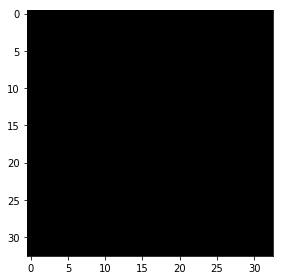

In [19]:
print(patches.shape,labels.shape)
io.imshow(patches[666,0,:,:])
plt.show()

In [3]:
class Brain_tumor_segmentation_model(object):

    """
    A class for compiling/loading, fitting and saving various models,
     viewing segmented images and analyzing results
    """

    def __init__(self, n_chan=4, loaded_model=False, model_name=None):
        """
        :param model_name: if loaded_model is True load the model name specified
        :param n_chan:number of channels being assessed. defaults to 4
        :param loaded_model: True if loading a pre-existing model. defaults to False
        """
        self.n_chan = n_chan
        self.loaded_model = loaded_model
        self.model = None

        if not self.loaded_model:
            self.model_name = None
            self._make_model()
            self._compile_model()
            print('model for {} ready and compiled, waiting for training'.format(self.model_name))
        else:
            if model_name is None:
                model_to_load = str(raw_input('Which model should I load? '))
            else:
                model_to_load = model_name
            self.model = self.load_model_weights(model_to_load)

    def _make_model(self):
        dropout_rate = 0.2
        
#         model_to_make = Sequential()
        inp = Input(shape=(4, 33, 33))
        model_to_make = Conv2D(64, (3, 3),
                                 kernel_initializer=glorot_normal(),
                                 bias_initializer='zeros',
                                 padding='same',
                                 data_format='channels_first',
                                 input_shape=(4, 33, 33)
                                 )(inp)
#         model_to_make = BatchNormalization()(model_to_make)
        model_to_make = LeakyReLU(alpha=0.333)(model_to_make)
        m1_res = model_to_make              # residual path
                         
        model_to_make = Conv2D(filters=64,
                                 kernel_size=(3, 3),
                                 padding='same',
                                 data_format='channels_first',
                                 input_shape=(64, 33, 33))(model_to_make)
#         model_to_make = BatchNormalization()(model_to_make)
        model_to_make = LeakyReLU(alpha=0.333)(model_to_make)
        model_to_make = Conv2D(filters=64,
                                 kernel_size=(3, 3),
                                 padding='same',
                                 data_format='channels_first',
                                 input_shape=(64, 33, 33))(model_to_make)
#             model_to_make = BatchNormalization()(model_to_make)
                
        model_to_make = add([model_to_make,m1_res])
        model_to_make = LeakyReLU(alpha=0.333)(model_to_make)

        model_to_make = MaxPool2D(pool_size=(3, 3),
                                    strides=(2, 2),
                                    data_format='channels_first',
                                    input_shape=(64, 33, 33))(model_to_make)

        model_to_make = Conv2D(filters=128,
                                 kernel_size=(3, 3),
                                 padding='same',
                                 data_format='channels_first',
                                 input_shape=(64, 16, 16))(model_to_make)
#         model_to_make = BatchNormalization()(model_to_make)

        model_to_make = LeakyReLU(alpha=0.333)(model_to_make)
        m1_res = model_to_make             # residual path

        model_to_make = Conv2D(filters=128,
                                 kernel_size=(3, 3),
                                 padding='same',
                                 data_format='channels_first',
                                 input_shape=(128, 16, 16))(model_to_make)
#         model_to_make = BatchNormalization()(model_to_make)
#         model_to_make = LeakyReLU(alpha=0.333)(model_to_make)

        model_to_make = Conv2D(filters=128,
                                 kernel_size=(3, 3),
                                 padding='same',
                                 data_format='channels_first',
                                 input_shape=(128, 16, 16))(model_to_make)
#             model_to_make = BatchNormalization()(model_to_make)
            
        model_to_make = add([model_to_make,m1_res])
        model_to_make = LeakyReLU(alpha=0.333)(model_to_make)
        
        model_to_make = MaxPool2D(pool_size=(3, 3),
                                    strides=(2, 2),
                                    data_format='channels_first',
                                    input_shape=(128, 16, 16))(model_to_make)
        
        model_to_make = Flatten()(model_to_make)
        model_to_make = Dense(units=256, input_dim=6272)(model_to_make)
        
        model_to_make = LeakyReLU(alpha=0.333)(model_to_make)
        
        model_to_make = Dropout(dropout_rate)(model_to_make)
        
        model_to_make = Dense(units=256, input_dim=256)(model_to_make)
        
        model_to_make = LeakyReLU(alpha=0.333)(model_to_make)
        
        model_to_make = Dropout(dropout_rate)(model_to_make)
        
        model_to_make = Dense(units=5,
                                input_dim=256)(model_to_make)
        
        model_to_make = Activation('softmax')(model_to_make)
        
        self.model = Model(inputs=inp,outputs=model_to_make)
        self.model.summary()

    def _compile_model(self):
        sgd = SGD(lr=3e-3,
                  decay=0,
                  momentum=0.9,
                  nesterov=True)
        print(sgd)
        self.model.compile(optimizer=sgd,
                           loss='categorical_crossentropy',
                           metrics=['accuracy'])
        plot_model(self.model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)
    
        
    @staticmethod
    def load_model_weights(model_name):
        """
        :param model_name: filepath to model and weights, not including extension
        :return: Model with loaded weights. can fit on model using loaded_model=True in fit_model method
        """
        print('Loading model {}'.format(model_name))
        model_to_load = '{}.json'.format(model_name)
        weights = '{}.hdf5'.format(model_name)
        with open(model_to_load,"r+") as f:
            m = f.readline()
        model_comp = model_from_json(json.loads(m))
        model_comp.load_weights(weights)
        print('Done.')
        return model_comp

    def fit_model(self, X_train, y_train):
        """
        :param X_train: list of patches to train on in form (n_sample, n_channel, h, w)
        :param y_train: list of labels corresponding to X_train patches in form (n_sample,)
        :return: Fits specified model
        """

        print(X_train.shape)
        print('*' * 100)
        print(y_train.shape)
        print('*' * 100)
        Y_train = np_utils.to_categorical(y_train, 5)

        shuffle = list(zip(X_train, Y_train))
        np.random.shuffle(shuffle)

        X_train = np.array([shuffle[i][0] for i in range(len(shuffle))])
        Y_train = np.array([shuffle[i][1] for i in range(len(shuffle))])
        EarlyStopping(monitor='val_loss', patience=2, mode='auto')

        n_epochs = 20

        self.model.fit(X_train, Y_train, epochs=n_epochs, batch_size=128, verbose=1)

    def save_model(self, model_name):
        """
        Saves current model as json and weigts as h5df file
        :param model_name: name to save model and weigths under, including filepath but not extension
        :return:
        """
        model_to_save = '{}.json'.format(model_name)
        weights = '{}.hdf5'.format(model_name)
        json_string = self.model.to_json()
        try:
            self.model.save_weights(weights)
        except:
            mkdir_p(model_name)
            self.model.save_weights(weights)

        with open(model_to_save, 'w') as f:
            json.dump(json_string, f)


    def predict_image(self, test_img):
        """
        predicts classes of input image
        :param test_img: filepath to image to predict on
        :return: segmented result
        """
        imgs = mpimg.imread(test_img).astype('float')
        imgs = rgb2gray(imgs).reshape(5, 216, 160)

        plist = []

        # create patches_to_predict from an entire slice
        for img in imgs[:-1]:
            if np.max(img) != 0:
                img /= np.max(img)
            p = extract_patches_2d(img, (33, 33))
            plist.append(p)
        patches_to_predict = np.array(
            list(zip(np.array(plist[0]), np.array(plist[1]), np.array(plist[2]), np.array(plist[3]))))
        # predict classes of each pixel based on model
        full_pred = self.model.predict(patches_to_predict)
        full_pred = np.argmax(full_pred,axis=1)
#         print(full_pred.shape)
        try:
                mkdir_p("./labels/")
                io.imsave("./labels/" + test_img[-5:], imgs[-1])
        except:
                io.imsave("./labels/" + test_img[-5:], imgs[-1])
        fp1 = full_pred.reshape(184, 128)
        return fp1

    def save_segmented_image(self, index, test_img, save=False):
        """
        Creates an image of original brain with segmentation overlay
        :param index: index of image to save
        :param test_img: filepath to test image for segmentation, including file extension
        :param save: If true, shows output image. (defaults to False)
        :return: if show is True, shows image of segmentation results
                 if show is false, returns segmented image.
        """

        segmentation = self.predict_image(test_img)

        img_mask = np.pad(segmentation, (16, 16), mode='edge')
        ones = np.argwhere(img_mask == 1)
        twos = np.argwhere(img_mask == 2)
        threes = np.argwhere(img_mask == 3)
        fours = np.argwhere(img_mask == 4)

        test_im = mpimg.imread(test_img).astype('float')
        test_back = rgb2gray(test_im).reshape(5, 216, 160)[-2]
        gray_img = img_as_float(test_back)

        # adjust gamma of image
        image = adjust_gamma(color.gray2rgb(gray_img), 0.65)
        sliced_image = image.copy()
        red_multiplier = [1, 0.2, 0.2]
        yellow_multiplier = [1, 1, 0.25]
        green_multiplier = [0.35, 0.75, 0.25]
        blue_multiplier = [0, 0.25, 0.9]

        # change colors of segmented classes
        for i in range(len(ones)):
            sliced_image[ones[i][0]][ones[i][1]] = red_multiplier
        for i in range(len(twos)):
            sliced_image[twos[i][0]][twos[i][1]] = green_multiplier
        for i in range(len(threes)):
            sliced_image[threes[i][0]][threes[i][1]] = blue_multiplier
        for i in range(len(fours)):
            sliced_image[fours[i][0]][fours[i][1]] = yellow_multiplier
        
        if save:

            try:
                mkdir_p('./results/')
                io.imsave('./results/result' + '_' + str(index) + '.png', sliced_image)
                savemha(img_mask,'./results/result' + '_' + str(index) + '.mha')
            except:
                io.imsave('./results/result' + '_' + str(index) + '.png', sliced_image)
                savemha(img_mask,'./results/result' + '_' + str(index) + '.mha')
        else:
            return sliced_image
    
    def get_dice_coef(self, test_img, label):
        '''
        Calculate dice coefficient for total slice, tumor-associated slice, advancing tumor and core tumor
        INPUT   (1) str 'test_img': filepath to slice to predict on
                (2) str 'label': filepath to ground truth label for test_img
        '''
        label = "./labels/" + label[-5:]
        segmentation = self.predict_image(test_img)
        seg_full = np.pad(segmentation, (16,16), mode='edge')
        gt = io.imread(label).astype('int')
        gt = np.divide(gt,np.max(gt))
        gt = np.round(gt * 4).astype('int')
        # dice coef of total image
        total = (len(np.argwhere(seg_full == gt)) * 2.) / (2 * 216 * 160)

        def unique_rows(a):
            '''
            helper function to get unique rows from 2D numpy array
            '''
            a = np.ascontiguousarray(a)
            unique_a = np.unique(a.view([('', a.dtype)]*a.shape[1]))
            return unique_a.view(a.dtype).reshape((unique_a.shape[0], a.shape[1]))

        # dice coef advancing tumor
        adv_gt = np.argwhere(gt == 4)
#         print(np.unique(gt))
        gt_a, seg_a = [], [] # classification of
        for i in adv_gt:
            gt_a.append(gt[i[0]][i[1]])
            seg_a.append(seg_full[i[0]][i[1]])
        gta = np.array(gt_a)
        sega = np.array(seg_a)
        adv = float(len(np.argwhere(gta == sega))) / len(adv_gt)

        # dice coef core tumor
        noadv_gt = np.argwhere(gt == 3)
        necrosis_gt = np.argwhere(gt == 1)
        live_tumor_gt = np.append(adv_gt, noadv_gt, axis = 0)
        core_gt = np.append(live_tumor_gt, necrosis_gt, axis = 0)
        gt_core, seg_core = [],[]
        for i in core_gt:
            gt_core.append(gt[i[0]][i[1]])
            seg_core.append(seg_full[i[0]][i[1]])
        gtcore, segcore = np.array(gt_core), np.array(seg_core)
        core = len(np.argwhere(gtcore == segcore)) / float(len(core_gt))

        print ('Region_______________________| Dice Coefficient')
        print ('Total Slice__________________| {0:.2f}'.format(total))
        print ('Advancing Tumor______________| {0:.2f}'.format(adv))
        print ('Core Tumor___________________| {0:.2f}'.format(core))
        print (' ')


In [91]:
model = Brain_tumor_segmentation_model()
model.fit_model(patches, labels)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_10 (InputLayer)           (None, 4, 33, 33)    0                                            
__________________________________________________________________________________________________
conv2d_74 (Conv2D)              (None, 64, 33, 33)   2368        input_10[0][0]                   
__________________________________________________________________________________________________
leaky_re_lu_88 (LeakyReLU)      (None, 64, 33, 33)   0           conv2d_74[0][0]                  
__________________________________________________________________________________________________
conv2d_75 (Conv2D)              (None, 64, 33, 33)   36928       leaky_re_lu_88[0][0]             
__________________________________________________________________________________________________
leaky_re_l

In [92]:
#saving the trained model and weights
model.save_model('residual_model')

In [93]:
#segments the given test images in folder and saves the result
tests = glob(r'D:\UB Coursework\Fall 2020- UB\CSE676_Deep_Learning\Project_2_MS_Project\experiment/**')
segmented_images = []
for index, slice_img in enumerate(tests):
    segmented_images.append(model.save_segmented_image(index, test_img=slice_img, save=True))

C:\Anaconda3\lib\site-packages\skimage\util\dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
C:\Anaconda3\lib\site-packages\skimage\util\dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


In [94]:
#Cell to find the DICE similarity coefficient between predicted and Ground Truth image
for slice_img in tests:
    print('-----Dice Coefficient for slice {} -----'.format(slice_img[84:]))
    model.get_dice_coef(test_img = slice_img, label = slice_img)

-----Dice Coefficient for slice 0_72.png -----


C:\Anaconda3\lib\site-packages\skimage\util\dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))


Region_______________________| Dice Coefficient
Total Slice__________________| 0.93
Advancing Tumor______________| 0.82
Core Tumor___________________| 0.85
 
-----Dice Coefficient for slice 3_103.png -----
Region_______________________| Dice Coefficient
Total Slice__________________| 0.92
Advancing Tumor______________| 0.86
Core Tumor___________________| 0.75
 
-----Dice Coefficient for slice 7_88.png -----
Region_______________________| Dice Coefficient
Total Slice__________________| 0.90
Advancing Tumor______________| 0.72
Core Tumor___________________| 0.81
 


In [66]:
#Cell to segment all 155 slices of a particular patient
tests = sorted(glob(r'D:\UB Coursework\Fall 2020- UB\CSE676_Deep_Learning\Project_2_MS_Project\experiment\all slices/**'))
segmented_images = []
for index, slice_img in enumerate(tests):
    segmented_images.append(model.save_segmented_image(index, test_img=slice_img, save=True))

C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./results/results/result_0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\util\dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./results/results/result_1.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./results/results/result_2.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./results/results/result_13.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./results/results/result_24.png is a low contrast image
  warn('%s is a low contrast image' %

C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: ./results/results/result_165.png is a low contrast image
  warn('%s is a low contrast image' % fname)


In [69]:
# Cell to colour the Ground Truth in training and save it!
tests1 = glob(r'D:\UB Coursework\Fall 2020- UB\CSE676_Deep_Learning\Project_2_MS_Project\experiment/**')
for index, slice_img in enumerate(tests1):
    imgs = mpimg.imread(slice_img).astype('float')
    imgs = rgb2gray(imgs).reshape(5, 216, 160)
    img_mask = imgs[-1]
    img_mask = np.divide(img_mask,np.max(img_mask))
    img_mask = np.round(img_mask * 4).astype('int')
    ones = np.argwhere(img_mask == 1)
    twos = np.argwhere(img_mask == 2)
    threes = np.argwhere(img_mask == 3)
    fours = np.argwhere(img_mask == 4)

    test_back = imgs[-2]
    # overlay = mark_boundaries(test_back, img_mask)
    gray_img = img_as_float(test_back)

    # adjust gamma of image
    image = adjust_gamma(color.gray2rgb(gray_img), 0.65)
    sliced_image = image.copy()
    red_multiplier = [1, 0.2, 0.2]
    yellow_multiplier = [1, 1, 0.25]
    green_multiplier = [0.35, 0.75, 0.25]
    blue_multiplier = [0, 0.25, 0.9]

    # change colors of segmented classes
    for i in range(len(ones)):
        sliced_image[ones[i][0]][ones[i][1]] = red_multiplier
    for i in range(len(twos)):
        sliced_image[twos[i][0]][twos[i][1]] = green_multiplier
    for i in range(len(threes)):
        sliced_image[threes[i][0]][threes[i][1]] = blue_multiplier
    for i in range(len(fours)):
        sliced_image[fours[i][0]][fours[i][1]] = yellow_multiplier

    try:
        mkdir_p('./results/')
        io.imsave('./results/resultGT' + '_' + str(index) + '.png', sliced_image)
    except:
        io.imsave('./results/resultGT' + '_' + str(index) + '.png', sliced_image)

C:\Anaconda3\lib\site-packages\skimage\util\dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


In [4]:
# run this cell to load the saved model and segment the images present in experiment folder
model1 = Brain_tumor_segmentation_model(loaded_model= True,model_name='residual_model')
location = glob(r'.\experiment/**')
for index, slice_img in enumerate(location):
    model1.save_segmented_image(index, test_img=slice_img, save=True)
    model1.get_dice_coef(test_img = slice_img, label = slice_img)

Loading model residual_model
Done.


C:\Anaconda3\lib\site-packages\skimage\util\dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
C:\Anaconda3\lib\site-packages\skimage\util\dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


Region_______________________| Dice Coefficient
Total Slice__________________| 0.93
Advancing Tumor______________| 0.82
Core Tumor___________________| 0.85
 
Region_______________________| Dice Coefficient
Total Slice__________________| 0.92
Advancing Tumor______________| 0.86
Core Tumor___________________| 0.75
 
Region_______________________| Dice Coefficient
Total Slice__________________| 0.90
Advancing Tumor______________| 0.72
Core Tumor___________________| 0.81
 
